# TODO:


- $\gamma_3$ = 2*0.0197, all  $(\theta, \lambda, \vartheta)$ and (y_step, logk_step) = (0.05, 0.05),  (y_max, logk_max) = (4,8) :
    
    converge but with kinks at y=2 for e(y):
    
    => check smaller (y_step, k_step)  (mainly y_step), tolerance level, time step may need to be adjusted accordingly.
    

- $\theta = 2$, five damage case $\gamma_3 \in [0. , 0.08, 0.16, 0.25 , 0.33]$, and (y_step, logk_step) = (0.05, 0.05),  (y_max, logk_max) = (4,8) :
    
    for non-zero $\gamma_3$:
    
    negative emission, explosion of pde error, and mc hitting the zero-bound.
    

- $\theta = 3$, five damage case $\gamma_3 \in [0. , 0.08, 0.16, 0.25 , 0.33]$, and (y_step, logk_step) = (0.05, 0.05),  (y_max, logk_max) = (4,8) :
    
    for non-zero $\gamma_3$:
    
    negative emission, 
    
    false transient errors oscillate at 1e-3 ~ 1e-4 level
    
    
4. $(\theta, \lambda, \vartheta) = (3, 0.134, 0.052)$
5. $(\theta, \lambda, \vartheta) = (3, 0.102, 0.036)$
6. $(\theta, \lambda, \vartheta) = (3, 0.0925, 0.032)$: reliable results $\gamma_3$ up to 0.18

In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
import SolveLinSys
import time
from derivative import derivatives_2d
from solver_ode import solve_ode, solve_ode_one, derivative_1d, solve_ode_neumann
from solver_jump import approach_one_100, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import matplotlib.transforms as transforms
from scipy.interpolate import RegularGridInterpolator, CubicSpline
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [570]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
y_bar = 2.3
y_jump=2.
y_overline = 2.3
y = 2.5
damage_min =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2
damage_max =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2 + 1/3/2*(y - y_jump)**2
damages = np.linspace(np.exp(-damage_max), np.exp(-damage_min), 10)
γ3_list = 2*( - np.log(damages) - γ1*(y- y_jump+2) - γ2/2*(y - y_jump+2)**2)/(y - y_jump)**2
γ3_list = np.flip(γ3_list)
γ3_list[0] = 0

dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
μk = - 0.043
σk = 0.0085
κ = 6.667
k0 = 80/α

In [730]:
γ3_list

array([0.        , 0.03635853, 0.07288307, 0.10957512, 0.14643624,
       0.18346798, 0.22067194, 0.25804973, 0.29560298, 0.33333333])

In [871]:
y_step = 0.1
y_grid = np.arange(0., 4 + y_step, y_step)

k_step = 0.2
k_grid = np.arange(0., 9. + k_step, k_step)

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
hy = y_grid[1] - y_grid[0]
hk = k_grid[1] - k_grid[0]
n_y = len(y_grid)
n_k = len(k_grid)

In [729]:
def solve_new(y_grid, k_grid, args, ϵ=0.5, max_iter=2000, tol=1e-6):
    
    δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3, y_bar, ξa, ϑ_bar, λ_bar = args
    n_y = len(y_grid)
    n_k = len(k_grid)
    dy = y_grid[1] - y_grid[0]
    dk = k_grid[1] - k_grid[0]
    
    (y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
    stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
    πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_k))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o

    dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
    ddΛ = γ2 + γ3*(y_mat > y_bar)

    # initial guess
    v0 =  (1/δ)*k_mat   -  η/δ*y_mat**2 
    # initial i
    a_i = κ*(1/δ)
    b_i = - (1 + α*κ)*(1/δ)
    c_i = α*(1/δ) - 1
    i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)

    ems = 0*np.ones(y_mat.shape)
    mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat)*α*λ_bar))**θ )

    episode = 0
    lhs_error = 0.5
    vd = - 1/δ

    while lhs_error > tol and episode < max_iter:
        vold = v0.copy()
        v0_dy = finiteDiff(v0,0,1,dy)
        v0_dy[v0_dy > - 1e-15] =  -1e-15
        v0_dyy = finiteDiff(v0,0,2,dy)
        v0_dk = finiteDiff(v0,1,1,dk)
    #     v0_dk[v0_dk > - 1e-15] =  1e-15
        v0_dkk = finiteDiff(v0,1,2,dk)
        # updating controls
        i_new = (1 -mc/v0_dk)*(1/κ)
    #     update emission
        if θ == 2:
            a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
            b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
                + vd*dΛ*np.sum(θ_mat*πa, axis=0)
            ems_new = - b/a
        elif θ == 3:
            a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))/(α**2*λ_bar**2*np.exp(2*k_mat))
            b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))*2/(α*λ_bar*np.exp(k_mat)) + (v0_dyy+ vd*ddΛ)*σy**2 
            c =  mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat)) + (v0_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
            Δ = b**2 - 4*a*c
            Δ[Δ < 0] = 0
            root1 = (-b - np.sqrt(Δ))/(2*a)
            root2 = (-b + np.sqrt(Δ))/(2*a)
            if root1.all() > 0:
                ems_new = root1
            else:
                ems_new = root2
        ems_new[ems_new < 0] = 0
        i_new = i_new*0.05 + i*0.95
        ems_new = ems_new*0.05 + ems*0.95
        ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0 )
    #     ratio[ratio > 1] = 1
        consumption = α - i_new - α*ϑ_bar*ratio**θ
    #     consumption[consumption < 1e-15] = 1e-15
        mc_new = 1/consumption

    #     mc_new[mc_new <= 1e-15] = 1e-15
    #     mc_new = mc_new*0.05 + mc*0.95
        temp = v0_dy + vd*dΛ
        weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
        πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
#         print("min ems:", np.min(ems_new))
#         print("min mc", np.min(mc_new))
        # HJB coefficient
        entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
        A =  -δ*np.ones(y_mat.shape)
        B_y = np.sum(θ_mat*πa, axis=0)*ems_new
        B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
        C_yy = 0.5*ems_new**2*σy**2
        C_kk = 0.5*σk**2*np.ones(y_mat.shape)
        D = np.log(consumption) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
            + ξa*entropy
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems = ems_new
        mc = mc_new
        i = i_new
    print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, i=i,  πa=πa, v0_dy=v0_dy, v0_dyy=v0_dyy)
    return result

HJB:

$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \phi(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)
\end{aligned}
$$



Denote

$$
mc = \frac{1}{\alpha - i - \alpha \vartheta (1 - \frac{e}{\alpha \lambda  \exp(k)})^\theta}
$$

First order condition for $i$:

$$
 - mc + \frac{d\phi}{dk} (1 - \kappa i) = 0
$$

FOC for $e$:

$$
mc \cdot (\bar{\vartheta} \theta \frac{1 }{\lambda \exp (k)}  (1 - \frac{e}{\alpha \lambda \exp{k}})^{\theta - 1}) + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell + \frac{d^2 \phi(y)}{dy^2}  \mid \varsigma \mid ^2  e + v_d (\Lambda' \sum \omega_\ell \theta_\ell + \Lambda'' \mid \varsigma \mid ^2 e) = 0
$$

$\theta = 3$:


In [851]:
# HJB for ϕ_m
θ = 3
y_bar = 2.3
ξa = 0.01
ξb = 3
ϑ_bar = 0.052
λ_bar = 0.134
γ3 = γ3_list[1]
# γ3 = 2*0.0197

α=0.115
# σy=0
σy=1.2*np.mean(θ_list)
ϵ=0.1


max_iter=10_000
tol=1e-5

n_y = len(y_grid)
n_k = len(k_grid)
dy = y_grid[1] - y_grid[0]
dk = k_grid[1] - k_grid[0]

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
ddΛ = γ2 + γ3*(y_mat > y_bar)

# initial guess
v0 =  (1/δ)*k_mat   -  η/δ*y_mat**2 
# initial i
a_i = κ*(1/δ)
b_i = - (1 + α*κ)*(1/δ)
c_i = α*(1/δ) - 1
i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)

ems = 0*np.ones(y_mat.shape)
mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat)*α*λ_bar))**θ )

episode = 0
lhs_error = 0.5
vd = - 1/δ

while lhs_error > tol :#and episode < max_iter:
    vold = v0.copy()
    v0_dy = finiteDiff(v0,0,1,dy)
    v0_dy[v0_dy > - 1e-15] =  -1e-15
    v0_dyy = finiteDiff(v0,0,2,dy)
    v0_dk = finiteDiff(v0,1,1,dk)
#     v0_dk[v0_dk > - 1e-15] =  1e-15
    v0_dkk = finiteDiff(v0,1,2,dk)
    # updating controls
    i_new = (1 -mc/v0_dk)*(1/κ)
#     update emission
    if θ == 2:
        a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = - b/a
    elif θ == 3:
        a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))/(α**2*λ_bar**2*np.exp(2*k_mat))
        b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))*2/(α*λ_bar*np.exp(k_mat)) + (v0_dyy+ vd*ddΛ)*σy**2 
        c =  mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat)) + (v0_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
    ems_new[ems_new < 0] = 0
    i_new = i_new*0.05 + i*0.95
    ems_new = ems_new*0.05 + ems*0.95
    ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0 )
#     ratio[ratio > 1] = 1
    consumption = α - i_new - α*ϑ_bar*ratio**θ
#     consumption[consumption < 1e-15] = 1e-15
    mc_new = 1/consumption
    
#     mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.05 + mc*0.95
    temp = v0_dy + vd*dΛ
    weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    print("min ems:", np.min(ems_new))
    print("min mc", np.min(mc_new))
    # HJB coefficient
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat.shape)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat.shape)
    D = np.log(consumption) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems = ems_new
    mc = mc_new
    i = i_new

min ems: 0.0
min mc 48.04137207524806
Episode 0: PDE Error: 1.949010868389; ft Error: 1.947405199106; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 45.246382789781855
Episode 1: PDE Error: 1.940478518190; ft Error: 1.939012825692; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 43.392111356870316
Episode 2: PDE Error: 1.935008888803; ft Error: 1.933578526513; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 42.11236818623128
Episode 3: PDE Error: 1.931083256484; ft Error: 1.929653243857; Iterations: 5; CG Error: 0.000000000035
min ems: 0.0
min mc 41.21034923591747
Episode 4: PDE Error: 1.927965893242; ft Error: 1.926577528134; Iterations: 5; CG Error: 0.000000000058
min ems: 0.0
min mc 40.56900249904684
Episode 5: PDE Error: 1.925318684743; ft Error: 1.923989042348; Iterations: 6; CG Error: 0.000000000010
min ems: 0.0
min mc 40.1135253006302
Episode 6: PDE Error: 1.922950997611; ft Error: 1.921689586281; Iterations: 6; CG Error: 0.000000000020
min e

Episode 59: PDE Error: 1.823829872021; ft Error: 1.823090409604; Iterations: 8; CG Error: 0.000000000021
min ems: 0.0
min mc 39.97870117085796
Episode 60: PDE Error: 1.822026006448; ft Error: 1.821291611939; Iterations: 8; CG Error: 0.000000000020
min ems: 0.0
min mc 39.978631859906145
Episode 61: PDE Error: 1.820236980865; ft Error: 1.819494159992; Iterations: 8; CG Error: 0.000000000019
min ems: 0.0
min mc 39.97843495907967
Episode 62: PDE Error: 1.818449080664; ft Error: 1.817698059856; Iterations: 8; CG Error: 0.000000000018
min ems: 0.0
min mc 39.9780932117122
Episode 63: PDE Error: 1.816662317505; ft Error: 1.815903317138; Iterations: 8; CG Error: 0.000000000017
min ems: 0.0
min mc 39.97769987282392
Episode 64: PDE Error: 1.814876702494; ft Error: 1.814109937040; Iterations: 8; CG Error: 0.000000000016
min ems: 0.0
min mc 39.97725984627303
Episode 65: PDE Error: 1.813092246218; ft Error: 1.812317924357; Iterations: 8; CG Error: 0.000000000015
min ems: 0.0
min mc 39.97675072121799

Episode 119: PDE Error: 1.719115973678; ft Error: 1.718311909425; Iterations: 7; CG Error: 0.000000000016
min ems: 0.0
min mc 39.916112349464264
Episode 120: PDE Error: 1.717427870814; ft Error: 1.716618425147; Iterations: 7; CG Error: 0.000000000016
min ems: 0.0
min mc 39.914606448139025
Episode 121: PDE Error: 1.715740731422; ft Error: 1.714926032029; Iterations: 7; CG Error: 0.000000000016
min ems: 0.0
min mc 39.91309079078769
Episode 122: PDE Error: 1.714054565225; ft Error: 1.713234736663; Iterations: 7; CG Error: 0.000000000015
min ems: 0.0
min mc 39.911565434697465
Episode 123: PDE Error: 1.712369381688; ft Error: 1.711544545477; Iterations: 7; CG Error: 0.000000000015
min ems: 0.0
min mc 39.9100304378251
Episode 124: PDE Error: 1.710685190029; ft Error: 1.709855464762; Iterations: 7; CG Error: 0.000000000014
min ems: 0.0
min mc 39.90848585882275
Episode 125: PDE Error: 1.709001999227; ft Error: 1.708167500661; Iterations: 7; CG Error: 0.000000000014
min ems: 0.0
min mc 39.90693

Episode 176: PDE Error: 1.626116932827; ft Error: 1.624607558451; Iterations: 6; CG Error: 0.000000000062
min ems: 0.0
min mc 39.81663124032481
Episode 177: PDE Error: 1.624533104778; ft Error: 1.623014030158; Iterations: 6; CG Error: 0.000000000062
min ems: 0.0
min mc 39.8146780931511
Episode 178: PDE Error: 1.622949914125; ft Error: 1.621421304175; Iterations: 6; CG Error: 0.000000000062
min ems: 0.0
min mc 39.812719289021594
Episode 179: PDE Error: 1.621367372809; ft Error: 1.619829389791; Iterations: 6; CG Error: 0.000000000061
min ems: 0.0
min mc 39.81075490629991
Episode 180: PDE Error: 1.619785492517; ft Error: 1.618238296116; Iterations: 6; CG Error: 0.000000000061
min ems: 0.0
min mc 39.808785023308324
Episode 181: PDE Error: 1.618204284689; ft Error: 1.616648032083; Iterations: 6; CG Error: 0.000000000061
min ems: 0.0
min mc 39.80680971831909
Episode 182: PDE Error: 1.616623760528; ft Error: 1.615058606463; Iterations: 6; CG Error: 0.000000000061
min ems: 0.0
min mc 39.804829

Episode 233: PDE Error: 1.537130748939; ft Error: 1.535597950652; Iterations: 6; CG Error: 0.000000000057
min ems: 0.0
min mc 39.69843518832828
Episode 234: PDE Error: 1.535597194033; ft Error: 1.534065475707; Iterations: 6; CG Error: 0.000000000057
min ems: 0.0
min mc 39.696275348546564
Episode 235: PDE Error: 1.534064712064; ft Error: 1.532534078950; Iterations: 6; CG Error: 0.000000000057
min ems: 0.0
min mc 39.694113953776935
Episode 236: PDE Error: 1.532533308273; ft Error: 1.531003765558; Iterations: 6; CG Error: 0.000000000057
min ems: 0.0
min mc 39.69195106742065
Episode 237: PDE Error: 1.531002987858; ft Error: 1.529474540694; Iterations: 6; CG Error: 0.000000000057
min ems: 0.0
min mc 39.68978675264261
Episode 238: PDE Error: 1.529473755978; ft Error: 1.527946409474; Iterations: 6; CG Error: 0.000000000058
min ems: 0.0
min mc 39.68762107236936
Episode 239: PDE Error: 1.527945617756; ft Error: 1.526419376974; Iterations: 6; CG Error: 0.000000000058
min ems: 0.0
min mc 39.68545

Episode 290: PDE Error: 1.451569757910; ft Error: 1.450105726120; Iterations: 6; CG Error: 0.000000000068
min ems: 0.0
min mc 39.573188704569354
Episode 291: PDE Error: 1.450104694064; ft Error: 1.448641979722; Iterations: 6; CG Error: 0.000000000069
min ems: 0.0
min mc 39.57098847952341
Episode 292: PDE Error: 1.448640946547; ft Error: 1.447179552799; Iterations: 6; CG Error: 0.000000000069
min ems: 0.0
min mc 39.568789394937745
Episode 293: PDE Error: 1.447178518654; ft Error: 1.445718448612; Iterations: 6; CG Error: 0.000000000069
min ems: 0.0
min mc 39.56659147648605
Episode 294: PDE Error: 1.445717413648; ft Error: 1.444258670398; Iterations: 6; CG Error: 0.000000000069
min ems: 0.0
min mc 39.56439474981709
Episode 295: PDE Error: 1.444257634759; ft Error: 1.442800221342; Iterations: 6; CG Error: 0.000000000070
min ems: 0.0
min mc 39.56219924055377
Episode 296: PDE Error: 1.442799185179; ft Error: 1.441343104615; Iterations: 6; CG Error: 0.000000000070
min ems: 0.0
min mc 39.56000

Episode 347: PDE Error: 1.370244140314; ft Error: 1.368859162362; Iterations: 6; CG Error: 0.000000000087
min ems: 0.0
min mc 39.44963890914622
Episode 348: PDE Error: 1.368858276835; ft Error: 1.367474734607; Iterations: 6; CG Error: 0.000000000088
min ems: 0.0
min mc 39.44753151822105
Episode 349: PDE Error: 1.367473854620; ft Error: 1.366091748821; Iterations: 6; CG Error: 0.000000000088
min ems: 0.0
min mc 39.44542683979606
Episode 350: PDE Error: 1.366090874438; ft Error: 1.364710205713; Iterations: 6; CG Error: 0.000000000088
min ems: 0.0
min mc 39.443324884772245
Episode 351: PDE Error: 1.364709337002; ft Error: 1.363330105945; Iterations: 6; CG Error: 0.000000000089
min ems: 0.0
min mc 39.44122566404394
Episode 352: PDE Error: 1.363329242962; ft Error: 1.361951450102; Iterations: 6; CG Error: 0.000000000089
min ems: 0.0
min mc 39.4391291884986
Episode 353: PDE Error: 1.361950592910; ft Error: 1.360574238724; Iterations: 6; CG Error: 0.000000000090
min ems: 0.0
min mc 39.4370354

Episode 404: PDE Error: 1.293546535018; ft Error: 1.292242905770; Iterations: 7; CG Error: 0.000000000013
min ems: 0.0
min mc 39.33414070650954
Episode 405: PDE Error: 1.292242297097; ft Error: 1.290940071084; Iterations: 7; CG Error: 0.000000000013
min ems: 0.0
min mc 39.33220546640711
Episode 406: PDE Error: 1.290939463808; ft Error: 1.289638639379; Iterations: 7; CG Error: 0.000000000013
min ems: 0.0
min mc 39.330273698335326
Episode 407: PDE Error: 1.289638033470; ft Error: 1.288338608940; Iterations: 7; CG Error: 0.000000000013
min ems: 0.0
min mc 39.32834541202084
Episode 408: PDE Error: 1.288338004367; ft Error: 1.287039978024; Iterations: 7; CG Error: 0.000000000013
min ems: 0.0
min mc 39.326420617153246
Episode 409: PDE Error: 1.287039374758; ft Error: 1.285742744864; Iterations: 7; CG Error: 0.000000000013
min ems: 0.0
min mc 39.324499323384465
Episode 410: PDE Error: 1.285742142875; ft Error: 1.284446907662; Iterations: 7; CG Error: 0.000000000013
min ems: 0.0
min mc 39.3225

Episode 461: PDE Error: 1.221393717270; ft Error: 1.220167255678; Iterations: 7; CG Error: 0.000000000016
min ems: 0.0
min mc 39.22937963757283
Episode 462: PDE Error: 1.220166684410; ft Error: 1.218941529628; Iterations: 7; CG Error: 0.000000000016
min ems: 0.0
min mc 39.22764714531594
Episode 463: PDE Error: 1.218940958433; ft Error: 1.217717109058; Iterations: 7; CG Error: 0.000000000016
min ems: 0.0
min mc 39.22591845965461
Episode 464: PDE Error: 1.217716537921; ft Error: 1.216493992555; Iterations: 7; CG Error: 0.000000000016
min ems: 0.0
min mc 39.224193587913504
Episode 465: PDE Error: 1.216493421465; ft Error: 1.215272178720; Iterations: 7; CG Error: 0.000000000016
min ems: 0.0
min mc 39.22247253736227
Episode 466: PDE Error: 1.215271607664; ft Error: 1.214051666153; Iterations: 7; CG Error: 0.000000000017
min ems: 0.0
min mc 39.22075531521457
Episode 467: PDE Error: 1.214051095119; ft Error: 1.212832453465; Iterations: 7; CG Error: 0.000000000017
min ems: 0.0
min mc 39.219041

Episode 518: PDE Error: 1.153497452566; ft Error: 1.152343207078; Iterations: 7; CG Error: 0.000000000020
min ems: 0.0
min mc 39.13689394908426
Episode 519: PDE Error: 1.152342623109; ft Error: 1.151189598720; Iterations: 7; CG Error: 0.000000000020
min ems: 0.0
min mc 39.13538837115313
Episode 520: PDE Error: 1.151189014245; ft Error: 1.150037209111; Iterations: 7; CG Error: 0.000000000020
min ems: 0.0
min mc 39.1338869193319
Episode 521: PDE Error: 1.150036624120; ft Error: 1.148886036380; Iterations: 7; CG Error: 0.000000000020
min ems: 0.0
min mc 39.13238959727925
Episode 522: PDE Error: 1.148885450865; ft Error: 1.147736078643; Iterations: 7; CG Error: 0.000000000020
min ems: 0.0
min mc 39.130896408581464
Episode 523: PDE Error: 1.147735492594; ft Error: 1.146587334006; Iterations: 7; CG Error: 0.000000000020
min ems: 0.0
min mc 39.12940143758555
Episode 524: PDE Error: 1.146586747409; ft Error: 1.145439800546; Iterations: 7; CG Error: 0.000000000020
min ems: 0.0
min mc 39.1279001

Episode 575: PDE Error: 1.089560870396; ft Error: 1.088472936524; Iterations: 7; CG Error: 0.000000000023
min ems: 0.0
min mc 39.056738370346274
Episode 576: PDE Error: 1.088472304812; ft Error: 1.087385470784; Iterations: 7; CG Error: 0.000000000023
min ems: 0.0
min mc 39.05544213149381
Episode 577: PDE Error: 1.087384837846; ft Error: 1.086299101464; Iterations: 7; CG Error: 0.000000000023
min ems: 0.0
min mc 39.0541432733592
Episode 578: PDE Error: 1.086298467288; ft Error: 1.085213826357; Iterations: 7; CG Error: 0.000000000023
min ems: 0.0
min mc 39.05284850742404
Episode 579: PDE Error: 1.085213190935; ft Error: 1.084129643277; Iterations: 7; CG Error: 0.000000000023
min ems: 0.0
min mc 39.05155783457189
Episode 580: PDE Error: 1.084129006591; ft Error: 1.083046550028; Iterations: 7; CG Error: 0.000000000023
min ems: 0.0
min mc 39.05027125560992
Episode 581: PDE Error: 1.083045912066; ft Error: 1.081964544431; Iterations: 7; CG Error: 0.000000000024
min ems: 0.0
min mc 39.0489887

Episode 632: PDE Error: 1.029205828231; ft Error: 1.028177438264; Iterations: 7; CG Error: 0.000000000027
min ems: 0.0
min mc 38.98669513459196
Episode 633: PDE Error: 1.028176716933; ft Error: 1.027149323518; Iterations: 7; CG Error: 0.000000000027
min ems: 0.0
min mc 38.98552786853568
Episode 634: PDE Error: 1.027148600286; ft Error: 1.026122202146; Iterations: 7; CG Error: 0.000000000027
min ems: 0.0
min mc 38.98436420701358
Episode 635: PDE Error: 1.026121476999; ft Error: 1.025096072867; Iterations: 7; CG Error: 0.000000000027
min ems: 0.0
min mc 38.98320414841384
Episode 636: PDE Error: 1.025095345800; ft Error: 1.024070934433; Iterations: 7; CG Error: 0.000000000028
min ems: 0.0
min mc 38.982047691077256
Episode 637: PDE Error: 1.024070205438; ft Error: 1.023046785614; Iterations: 7; CG Error: 0.000000000028
min ems: 0.0
min mc 38.98089483329711
Episode 638: PDE Error: 1.023046054680; ft Error: 1.022023625189; Iterations: 7; CG Error: 0.000000000028
min ems: 0.0
min mc 38.979745

Episode 689: PDE Error: 0.972103216978; ft Error: 0.971130078450; Iterations: 7; CG Error: 0.000000000032
min ems: 0.0
min mc 38.92539659557301
Episode 690: PDE Error: 0.971129241437; ft Error: 0.970157051338; Iterations: 7; CG Error: 0.000000000033
min ems: 0.0
min mc 38.924400103100396
Episode 691: PDE Error: 0.970156212263; ft Error: 0.969184970048; Iterations: 7; CG Error: 0.000000000033
min ems: 0.0
min mc 38.92340700767139
Episode 692: PDE Error: 0.969184128914; ft Error: 0.968213834042; Iterations: 7; CG Error: 0.000000000033
min ems: 0.0
min mc 38.922417306221625
Episode 693: PDE Error: 0.968212990851; ft Error: 0.967243642791; Iterations: 7; CG Error: 0.000000000033
min ems: 0.0
min mc 38.921430995640584
Episode 694: PDE Error: 0.967242797540; ft Error: 0.966274395760; Iterations: 7; CG Error: 0.000000000033
min ems: 0.0
min mc 38.92044807277187
Episode 695: PDE Error: 0.966273548451; ft Error: 0.965306092422; Iterations: 7; CG Error: 0.000000000033
min ems: 0.0
min mc 38.9194

Episode 746: PDE Error: 0.918081871940; ft Error: 0.917161959355; Iterations: 7; CG Error: 0.000000000039
min ems: 0.0
min mc 38.87391054608703
Episode 747: PDE Error: 0.917161010740; ft Error: 0.916242016036; Iterations: 7; CG Error: 0.000000000039
min ems: 0.0
min mc 38.873101467140074
Episode 748: PDE Error: 0.916241065607; ft Error: 0.915322988171; Iterations: 7; CG Error: 0.000000000039
min ems: 0.0
min mc 38.87229553878283
Episode 749: PDE Error: 0.915322035934; ft Error: 0.914404875164; Iterations: 7; CG Error: 0.000000000039
min ems: 0.0
min mc 38.87149275543899
Episode 750: PDE Error: 0.914403921113; ft Error: 0.913487676386; Iterations: 7; CG Error: 0.000000000039
min ems: 0.0
min mc 38.87069311149159
Episode 751: PDE Error: 0.913486720528; ft Error: 0.912571391224; Iterations: 7; CG Error: 0.000000000039
min ems: 0.0
min mc 38.86989660128329
Episode 752: PDE Error: 0.912570433561; ft Error: 0.911656019056; Iterations: 7; CG Error: 0.000000000040
min ems: 0.0
min mc 38.869103

Episode 803: PDE Error: 0.867035408190; ft Error: 0.866166720001; Iterations: 7; CG Error: 0.000000000046
min ems: 0.0
min mc 38.831847991268965
Episode 804: PDE Error: 0.866165672706; ft Error: 0.865297861216; Iterations: 7; CG Error: 0.000000000046
min ems: 0.0
min mc 38.83117910210195
Episode 805: PDE Error: 0.865296812282; ft Error: 0.864429876673; Iterations: 7; CG Error: 0.000000000047
min ems: 0.0
min mc 38.83051305323202
Episode 806: PDE Error: 0.864428826102; ft Error: 0.863562765553; Iterations: 7; CG Error: 0.000000000047
min ems: 0.0
min mc 38.82984983812171
Episode 807: PDE Error: 0.863561713350; ft Error: 0.862696527038; Iterations: 7; CG Error: 0.000000000047
min ems: 0.0
min mc 38.82918945020125
Episode 808: PDE Error: 0.862695473207; ft Error: 0.861831160312; Iterations: 7; CG Error: 0.000000000047
min ems: 0.0
min mc 38.82853188286879
Episode 809: PDE Error: 0.861830104850; ft Error: 0.860966664554; Iterations: 7; CG Error: 0.000000000047
min ems: 0.0
min mc 38.827877

Episode 860: PDE Error: 0.818832605813; ft Error: 0.818012545587; Iterations: 7; CG Error: 0.000000000055
min ems: 0.0
min mc 38.798051442963136
Episode 861: PDE Error: 0.818011405839; ft Error: 0.817192173873; Iterations: 7; CG Error: 0.000000000055
min ems: 0.0
min mc 38.79753317364388
Episode 862: PDE Error: 0.817191032550; ft Error: 0.816372627983; Iterations: 7; CG Error: 0.000000000055
min ems: 0.0
min mc 38.79701732811819
Episode 863: PDE Error: 0.816371485086; ft Error: 0.815553907057; Iterations: 7; CG Error: 0.000000000055
min ems: 0.0
min mc 38.79650389843869
Episode 864: PDE Error: 0.815552762589; ft Error: 0.814736010242; Iterations: 7; CG Error: 0.000000000055
min ems: 0.0
min mc 38.79599287664184
Episode 865: PDE Error: 0.814734864201; ft Error: 0.813918936686; Iterations: 7; CG Error: 0.000000000056
min ems: 0.0
min mc 38.79548425474835
Episode 866: PDE Error: 0.813917789064; ft Error: 0.813102685529; Iterations: 7; CG Error: 0.000000000056
min ems: 0.0
min mc 38.794978

Episode 917: PDE Error: 0.773318701686; ft Error: 0.772544500865; Iterations: 7; CG Error: 0.000000000064
min ems: 0.0
min mc 38.7713035090036
Episode 918: PDE Error: 0.772543270923; ft Error: 0.771769850518; Iterations: 7; CG Error: 0.000000000064
min ems: 0.0
min mc 38.77088985540361
Episode 919: PDE Error: 0.771768619038; ft Error: 0.770995978243; Iterations: 7; CG Error: 0.000000000065
min ems: 0.0
min mc 38.77047828260709
Episode 920: PDE Error: 0.770994745216; ft Error: 0.770222883228; Iterations: 7; CG Error: 0.000000000065
min ems: 0.0
min mc 38.77006878263319
Episode 921: PDE Error: 0.770221648648; ft Error: 0.769450564665; Iterations: 7; CG Error: 0.000000000065
min ems: 0.0
min mc 38.76966134749553
Episode 922: PDE Error: 0.769449328525; ft Error: 0.768679021738; Iterations: 7; CG Error: 0.000000000065
min ems: 0.0
min mc 38.76925596920253
Episode 923: PDE Error: 0.768677784038; ft Error: 0.767908253650; Iterations: 7; CG Error: 0.000000000065
min ems: 0.0
min mc 38.76885263

Episode 974: PDE Error: 0.730338922324; ft Error: 0.729607942275; Iterations: 7; CG Error: 0.000000000075
min ems: 0.0
min mc 38.75081179087677
Episode 975: PDE Error: 0.729606624309; ft Error: 0.728876380140; Iterations: 7; CG Error: 0.000000000075
min ems: 0.0
min mc 38.75050396358425
Episode 976: PDE Error: 0.728875060647; ft Error: 0.728145551609; Iterations: 7; CG Error: 0.000000000075
min ems: 0.0
min mc 38.750197762139344
Episode 977: PDE Error: 0.728144230587; ft Error: 0.727415455933; Iterations: 7; CG Error: 0.000000000076
min ems: 0.0
min mc 38.74989317871662
Episode 978: PDE Error: 0.727414133379; ft Error: 0.726686092357; Iterations: 7; CG Error: 0.000000000076
min ems: 0.0
min mc 38.7495902055011
Episode 979: PDE Error: 0.726684768276; ft Error: 0.725957460148; Iterations: 7; CG Error: 0.000000000076
min ems: 0.0
min mc 38.74928883468898
Episode 980: PDE Error: 0.725956134529; ft Error: 0.725229558542; Iterations: 7; CG Error: 0.000000000076
min ems: 0.0
min mc 38.7489890

Episode 1031: PDE Error: 0.689748387821; ft Error: 0.689058181454; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.735497807101204
Episode 1032: PDE Error: 0.689056778374; ft Error: 0.688367266581; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.735261249603056
Episode 1033: PDE Error: 0.688365862018; ft Error: 0.687677044103; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.735026022141135
Episode 1034: PDE Error: 0.687675638055; ft Error: 0.686987513319; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.73479211761875
Episode 1035: PDE Error: 0.686986105788; ft Error: 0.686298673534; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.73455952895601
Episode 1036: PDE Error: 0.686297264520; ft Error: 0.685610524052; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.734328249089764
Episode 1037: PDE Error: 0.685609113558; ft Error: 0.684923064179; Iterations: 7; CG Error: 0.000000000089
min ems: 0.0
min mc

Episode 1088: PDE Error: 0.651412730164; ft Error: 0.650759725429; Iterations: 8; CG Error: 0.000000000016
min ems: 0.0
min mc 38.723936394878244
Episode 1089: PDE Error: 0.650759536406; ft Error: 0.650107183560; Iterations: 8; CG Error: 0.000000000016
min ems: 0.0
min mc 38.72376487462036
Episode 1090: PDE Error: 0.650106994393; ft Error: 0.649455292147; Iterations: 8; CG Error: 0.000000000016
min ems: 0.0
min mc 38.72359431102098
Episode 1091: PDE Error: 0.649455102847; ft Error: 0.648804050163; Iterations: 8; CG Error: 0.000000000016
min ems: 0.0
min mc 38.723424698154666
Episode 1092: PDE Error: 0.648803860735; ft Error: 0.648153456789; Iterations: 8; CG Error: 0.000000000016
min ems: 0.0
min mc 38.72325603012101
Episode 1093: PDE Error: 0.648153267236; ft Error: 0.647503511375; Iterations: 8; CG Error: 0.000000000016
min ems: 0.0
min mc 38.72308830104437
Episode 1094: PDE Error: 0.647503321700; ft Error: 0.646854213416; Iterations: 8; CG Error: 0.000000000016
min ems: 0.0
min mc 3

Episode 1145: PDE Error: 0.615206224735; ft Error: 0.614589562123; Iterations: 8; CG Error: 0.000000000019
min ems: 0.0
min mc 38.71552292316823
Episode 1146: PDE Error: 0.614589365928; ft Error: 0.613973322883; Iterations: 8; CG Error: 0.000000000019
min ems: 0.0
min mc 38.71539719703771
Episode 1147: PDE Error: 0.613973126554; ft Error: 0.613357702357; Iterations: 8; CG Error: 0.000000000019
min ems: 0.0
min mc 38.71527212923548
Episode 1148: PDE Error: 0.613357505893; ft Error: 0.612742699823; Iterations: 8; CG Error: 0.000000000020
min ems: 0.0
min mc 38.71514771524717
Episode 1149: PDE Error: 0.612742503224; ft Error: 0.612128314566; Iterations: 8; CG Error: 0.000000000020
min ems: 0.0
min mc 38.71502395058303
Episode 1150: PDE Error: 0.612128117832; ft Error: 0.611514545869; Iterations: 8; CG Error: 0.000000000020
min ems: 0.0
min mc 38.7149008307781
Episode 1151: PDE Error: 0.611514349001; ft Error: 0.610901393028; Iterations: 8; CG Error: 0.000000000020
min ems: 0.0
min mc 38.7

Episode 1202: PDE Error: 0.581014059107; ft Error: 0.580431657110; Iterations: 8; CG Error: 0.000000000023
min ems: 0.0
min mc 38.709284720419184
Episode 1203: PDE Error: 0.580431452935; ft Error: 0.579849634594; Iterations: 8; CG Error: 0.000000000023
min ems: 0.0
min mc 38.70919002000773
Episode 1204: PDE Error: 0.579849430285; ft Error: 0.579268195046; Iterations: 8; CG Error: 0.000000000023
min ems: 0.0
min mc 38.70909575871095
Episode 1205: PDE Error: 0.579267990602; ft Error: 0.578687337913; Iterations: 8; CG Error: 0.000000000023
min ems: 0.0
min mc 38.709001933343636
Episode 1206: PDE Error: 0.578687133334; ft Error: 0.578107062644; Iterations: 8; CG Error: 0.000000000023
min ems: 0.0
min mc 38.70890854074211
Episode 1207: PDE Error: 0.578106857932; ft Error: 0.577527368692; Iterations: 8; CG Error: 0.000000000023
min ems: 0.0
min mc 38.70881557776407
Episode 1208: PDE Error: 0.577527163844; ft Error: 0.576948255502; Iterations: 8; CG Error: 0.000000000023
min ems: 0.0
min mc 3

Episode 1259: PDE Error: 0.548720897473; ft Error: 0.548170897797; Iterations: 8; CG Error: 0.000000000027
min ems: 0.0
min mc 38.70423911373545
Episode 1260: PDE Error: 0.548170686488; ft Error: 0.547621239625; Iterations: 8; CG Error: 0.000000000027
min ems: 0.0
min mc 38.70415592461636
Episode 1261: PDE Error: 0.547621028199; ft Error: 0.547072133606; Iterations: 8; CG Error: 0.000000000027
min ems: 0.0
min mc 38.70407299410555
Episode 1262: PDE Error: 0.547071922065; ft Error: 0.546523579204; Iterations: 8; CG Error: 0.000000000028
min ems: 0.0
min mc 38.70399032044474
Episode 1263: PDE Error: 0.546523367544; ft Error: 0.545975575874; Iterations: 8; CG Error: 0.000000000028
min ems: 0.0
min mc 38.70390790189011
Episode 1264: PDE Error: 0.545975364098; ft Error: 0.545428123077; Iterations: 8; CG Error: 0.000000000028
min ems: 0.0
min mc 38.703825736712105
Episode 1265: PDE Error: 0.545427911183; ft Error: 0.544881220270; Iterations: 8; CG Error: 0.000000000028
min ems: 0.0
min mc 38

Episode 1316: PDE Error: 0.518225152417; ft Error: 0.517705800846; Iterations: 8; CG Error: 0.000000000032
min ems: 0.0
min mc 38.69986389269097
Episode 1317: PDE Error: 0.517705583056; ft Error: 0.517186753615; Iterations: 8; CG Error: 0.000000000032
min ems: 0.0
min mc 38.69979302041004
Episode 1318: PDE Error: 0.517186535708; ft Error: 0.516668227867; Iterations: 8; CG Error: 0.000000000033
min ems: 0.0
min mc 38.69972232667707
Episode 1319: PDE Error: 0.516668009846; ft Error: 0.516150223076; Iterations: 8; CG Error: 0.000000000033
min ems: 0.0
min mc 38.69965181040524
Episode 1320: PDE Error: 0.516150004939; ft Error: 0.515632738711; Iterations: 8; CG Error: 0.000000000033
min ems: 0.0
min mc 38.69958147051739
Episode 1321: PDE Error: 0.515632520459; ft Error: 0.515115774245; Iterations: 8; CG Error: 0.000000000033
min ems: 0.0
min mc 38.699511305945485
Episode 1322: PDE Error: 0.515115555878; ft Error: 0.514599329152; Iterations: 8; CG Error: 0.000000000033
min ems: 0.0
min mc 38

Episode 1373: PDE Error: 0.489427560296; ft Error: 0.488937142055; Iterations: 8; CG Error: 0.000000000038
min ems: 0.0
min mc 38.696041042911986
Episode 1374: PDE Error: 0.488936917329; ft Error: 0.488446991982; Iterations: 8; CG Error: 0.000000000038
min ems: 0.0
min mc 38.695967143034295
Episode 1375: PDE Error: 0.488446767131; ft Error: 0.487957334186; Iterations: 8; CG Error: 0.000000000038
min ems: 0.0
min mc 38.695893373710895
Episode 1376: PDE Error: 0.487957109208; ft Error: 0.487468168174; Iterations: 8; CG Error: 0.000000000038
min ems: 0.0
min mc 38.69581973439001
Episode 1377: PDE Error: 0.487467943067; ft Error: 0.486979493452; Iterations: 8; CG Error: 0.000000000038
min ems: 0.0
min mc 38.69574622452416
Episode 1378: PDE Error: 0.486979268212; ft Error: 0.486491309521; Iterations: 8; CG Error: 0.000000000039
min ems: 0.0
min mc 38.69567284357037
Episode 1379: PDE Error: 0.486491084152; ft Error: 0.486003615896; Iterations: 8; CG Error: 0.000000000039
min ems: 0.0
min mc 

Episode 1430: PDE Error: 0.462233145704; ft Error: 0.461770052078; Iterations: 8; CG Error: 0.000000000045
min ems: 0.0
min mc 38.69202254870919
Episode 1431: PDE Error: 0.461769819334; ft Error: 0.461307191415; Iterations: 8; CG Error: 0.000000000045
min ems: 0.0
min mc 38.69195532357904
Episode 1432: PDE Error: 0.461306958516; ft Error: 0.460844795844; Iterations: 8; CG Error: 0.000000000045
min ems: 0.0
min mc 38.69188820347795
Episode 1433: PDE Error: 0.460844562787; ft Error: 0.460382864901; Iterations: 8; CG Error: 0.000000000045
min ems: 0.0
min mc 38.69182118804678
Episode 1434: PDE Error: 0.460382631690; ft Error: 0.459921398128; Iterations: 8; CG Error: 0.000000000045
min ems: 0.0
min mc 38.691754276928734
Episode 1435: PDE Error: 0.459921164763; ft Error: 0.459460395070; Iterations: 8; CG Error: 0.000000000045
min ems: 0.0
min mc 38.69168746976962
Episode 1436: PDE Error: 0.459460161548; ft Error: 0.458999855264; Iterations: 8; CG Error: 0.000000000045
min ems: 0.0
min mc 38

Episode 1487: PDE Error: 0.436553281257; ft Error: 0.436116013185; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.68834870715884
Episode 1488: PDE Error: 0.436115770719; ft Error: 0.435678942920; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.68828695834556
Episode 1489: PDE Error: 0.435678700268; ft Error: 0.435242312311; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.68822529735939
Episode 1490: PDE Error: 0.435242069471; ft Error: 0.434806120920; Iterations: 8; CG Error: 0.000000000053
min ems: 0.0
min mc 38.68816163659881
Episode 1491: PDE Error: 0.434805877894; ft Error: 0.434370368325; Iterations: 8; CG Error: 0.000000000053
min ems: 0.0
min mc 38.6880884491233
Episode 1492: PDE Error: 0.434370125107; ft Error: 0.433935054086; Iterations: 8; CG Error: 0.000000000053
min ems: 0.0
min mc 38.6880153583797
Episode 1493: PDE Error: 0.433934810678; ft Error: 0.433500177778; Iterations: 8; CG Error: 0.000000000053
min ems: 0.0
min mc 38.68

Episode 1544: PDE Error: 0.412305069715; ft Error: 0.411892221134; Iterations: 8; CG Error: 0.000000000061
min ems: 0.0
min mc 38.684342376075485
Episode 1545: PDE Error: 0.411891966276; ft Error: 0.411479534060; Iterations: 8; CG Error: 0.000000000061
min ems: 0.0
min mc 38.684274096814775
Episode 1546: PDE Error: 0.411479278953; ft Error: 0.411067262697; Iterations: 8; CG Error: 0.000000000061
min ems: 0.0
min mc 38.68420590278048
Episode 1547: PDE Error: 0.411067007338; ft Error: 0.410655406636; Iterations: 8; CG Error: 0.000000000061
min ems: 0.0
min mc 38.68413779377971
Episode 1548: PDE Error: 0.410655151022; ft Error: 0.410243965465; Iterations: 8; CG Error: 0.000000000061
min ems: 0.0
min mc 38.68406976962005
Episode 1549: PDE Error: 0.410243709600; ft Error: 0.409832938783; Iterations: 8; CG Error: 0.000000000061
min ems: 0.0
min mc 38.68400183010973
Episode 1550: PDE Error: 0.409832682663; ft Error: 0.409422326180; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 3

Episode 1601: PDE Error: 0.389410500339; ft Error: 0.389020746086; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.680581058349595
Episode 1602: PDE Error: 0.389020475050; ft Error: 0.388631114566; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.68051734534229
Episode 1603: PDE Error: 0.388630843206; ft Error: 0.388241876104; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.68045370742291
Episode 1604: PDE Error: 0.388241604419; ft Error: 0.387853030317; Iterations: 8; CG Error: 0.000000000071
min ems: 0.0
min mc 38.680390144427356
Episode 1605: PDE Error: 0.387852758302; ft Error: 0.387464576817; Iterations: 8; CG Error: 0.000000000071
min ems: 0.0
min mc 38.680326656191795
Episode 1606: PDE Error: 0.387464304467; ft Error: 0.387076515215; Iterations: 8; CG Error: 0.000000000071
min ems: 0.0
min mc 38.68026324255285
Episode 1607: PDE Error: 0.387076242530; ft Error: 0.386688845124; Iterations: 8; CG Error: 0.000000000071
min ems: 0.0
min mc 

Episode 1658: PDE Error: 0.367795795959; ft Error: 0.367427881084; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.67661648998629
Episode 1659: PDE Error: 0.367427588693; ft Error: 0.367060046151; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.67654627236099
Episode 1660: PDE Error: 0.367059753333; ft Error: 0.366692582755; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.67647613122938
Episode 1661: PDE Error: 0.366692289511; ft Error: 0.366325490530; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.6764060664395
Episode 1662: PDE Error: 0.366325196860; ft Error: 0.365958769112; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.676336077839686
Episode 1663: PDE Error: 0.365958475012; ft Error: 0.365592418128; Iterations: 8; CG Error: 0.000000000082
min ems: 0.0
min mc 38.67626616527846
Episode 1664: PDE Error: 0.365592123600; ft Error: 0.365226437216; Iterations: 8; CG Error: 0.000000000082
min ems: 0.0
min mc 38.

Episode 1715: PDE Error: 0.347390914098; ft Error: 0.347043648538; Iterations: 8; CG Error: 0.000000000092
min ems: 0.0
min mc 38.67273183951357
Episode 1716: PDE Error: 0.347043328389; ft Error: 0.346696414883; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 38.672665748089535
Episode 1717: PDE Error: 0.346696094171; ft Error: 0.346349532369; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 38.67259972496135
Episode 1718: PDE Error: 0.346349211096; ft Error: 0.346003000654; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 38.67253376999328
Episode 1719: PDE Error: 0.346002678815; ft Error: 0.345656819391; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 38.6724678830499
Episode 1720: PDE Error: 0.345656496983; ft Error: 0.345310988229; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 38.67240206399602
Episode 1721: PDE Error: 0.345310665252; ft Error: 0.344965506823; Iterations: 8; CG Error: 0.000000000094
min ems: 0.0
min mc 38.

Episode 1772: PDE Error: 0.328132673671; ft Error: 0.327804151475; Iterations: 9; CG Error: 0.000000000022
min ems: 0.0
min mc 38.66890801661458
Episode 1773: PDE Error: 0.327804633177; ft Error: 0.327476436100; Iterations: 9; CG Error: 0.000000000022
min ems: 0.0
min mc 38.668835736846134
Episode 1774: PDE Error: 0.327476919518; ft Error: 0.327149047475; Iterations: 9; CG Error: 0.000000000022
min ems: 0.0
min mc 38.66876352777432
Episode 1775: PDE Error: 0.327149532613; ft Error: 0.326821985515; Iterations: 9; CG Error: 0.000000000022
min ems: 0.0
min mc 38.66869138926933
Episode 1776: PDE Error: 0.326822472379; ft Error: 0.326495250138; Iterations: 9; CG Error: 0.000000000022
min ems: 0.0
min mc 38.66861932120164
Episode 1777: PDE Error: 0.326495738730; ft Error: 0.326168841253; Iterations: 9; CG Error: 0.000000000022
min ems: 0.0
min mc 38.66854732344191
Episode 1778: PDE Error: 0.326169331575; ft Error: 0.325842758766; Iterations: 9; CG Error: 0.000000000022
min ems: 0.0
min mc 38

Episode 1829: PDE Error: 0.309970378161; ft Error: 0.309641460278; Iterations: 9; CG Error: 0.000000000025
min ems: 0.0
min mc 38.66489719815015
Episode 1830: PDE Error: 0.309661164793; ft Error: 0.309332088465; Iterations: 9; CG Error: 0.000000000025
min ems: 0.0
min mc 38.66482874794989
Episode 1831: PDE Error: 0.309352265709; ft Error: 0.309023030733; Iterations: 9; CG Error: 0.000000000026
min ems: 0.0
min mc 38.664760361431355
Episode 1832: PDE Error: 0.309043680577; ft Error: 0.308714286761; Iterations: 9; CG Error: 0.000000000026
min ems: 0.0
min mc 38.66469203847838
Episode 1833: PDE Error: 0.308735409067; ft Error: 0.308405856219; Iterations: 9; CG Error: 0.000000000026
min ems: 0.0
min mc 38.6646237789751
Episode 1834: PDE Error: 0.308427450849; ft Error: 0.308097738778; Iterations: 9; CG Error: 0.000000000026
min ems: 0.0
min mc 38.66455558280581
Episode 1835: PDE Error: 0.308119805588; ft Error: 0.307789934112; Iterations: 9; CG Error: 0.000000000026
min ems: 0.0
min mc 38.

Episode 1886: PDE Error: 0.292837306951; ft Error: 0.292499088066; Iterations: 9; CG Error: 0.000000000029
min ems: 0.0
min mc 38.66109386532113
Episode 1887: PDE Error: 0.292545496040; ft Error: 0.292207108905; Iterations: 9; CG Error: 0.000000000029
min ems: 0.0
min mc 38.66102886631946
Episode 1888: PDE Error: 0.292253981662; ft Error: 0.291915426085; Iterations: 9; CG Error: 0.000000000029
min ems: 0.0
min mc 38.66096392474248
Episode 1889: PDE Error: 0.291962763531; ft Error: 0.291624039312; Iterations: 9; CG Error: 0.000000000029
min ems: 0.0
min mc 38.66089904048701
Episode 1890: PDE Error: 0.291671841364; ft Error: 0.291332948306; Iterations: 9; CG Error: 0.000000000030
min ems: 0.0
min mc 38.6608342134498
Episode 1891: PDE Error: 0.291381214880; ft Error: 0.291042152786; Iterations: 9; CG Error: 0.000000000030
min ems: 0.0
min mc 38.660769443528004
Episode 1892: PDE Error: 0.291090883795; ft Error: 0.290751652460; Iterations: 9; CG Error: 0.000000000030
min ems: 0.0
min mc 38.

Episode 1943: PDE Error: 0.276669194347; ft Error: 0.276321067917; Iterations: 9; CG Error: 0.000000000034
min ems: 0.0
min mc 38.65721443946542
Episode 1944: PDE Error: 0.276393842350; ft Error: 0.276045536614; Iterations: 9; CG Error: 0.000000000034
min ems: 0.0
min mc 38.65714385205555
Episode 1945: PDE Error: 0.276118771108; ft Error: 0.275770285893; Iterations: 9; CG Error: 0.000000000034
min ems: 0.0
min mc 38.657073325293446
Episode 1946: PDE Error: 0.275843980345; ft Error: 0.275495315484; Iterations: 9; CG Error: 0.000000000034
min ems: 0.0
min mc 38.65700285907971
Episode 1947: PDE Error: 0.275569469783; ft Error: 0.275220625108; Iterations: 9; CG Error: 0.000000000034
min ems: 0.0
min mc 38.65693245331509
Episode 1948: PDE Error: 0.275295239147; ft Error: 0.274946214489; Iterations: 9; CG Error: 0.000000000034
min ems: 0.0
min mc 38.656862107900594
Episode 1949: PDE Error: 0.275021288159; ft Error: 0.274672083352; Iterations: 9; CG Error: 0.000000000034
min ems: 0.0
min mc 3

Episode 2000: PDE Error: 0.261414109668; ft Error: 0.261055519636; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.65328492104819
Episode 2001: PDE Error: 0.261154318809; ft Error: 0.260795541237; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.653217637738166
Episode 2002: PDE Error: 0.260894792962; ft Error: 0.260535827725; Iterations: 9; CG Error: 0.000000000039
min ems: 0.0
min mc 38.6531504097266
Episode 2003: PDE Error: 0.260635531856; ft Error: 0.260276378831; Iterations: 9; CG Error: 0.000000000039
min ems: 0.0
min mc 38.65308323692537
Episode 2004: PDE Error: 0.260376535218; ft Error: 0.260017194278; Iterations: 9; CG Error: 0.000000000039
min ems: 0.0
min mc 38.65301611924653
Episode 2005: PDE Error: 0.260117802778; ft Error: 0.259758273799; Iterations: 9; CG Error: 0.000000000039
min ems: 0.0
min mc 38.6529490566022
Episode 2006: PDE Error: 0.259859334263; ft Error: 0.259499617118; Iterations: 9; CG Error: 0.000000000039
min ems: 0.0
min mc 38.6

Episode 2057: PDE Error: 0.247021158249; ft Error: 0.246651682704; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.64953552095405
Episode 2058: PDE Error: 0.246776048662; ft Error: 0.246406378615; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.64947125427293
Episode 2059: PDE Error: 0.246531189135; ft Error: 0.246161324460; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.649407038154514
Episode 2060: PDE Error: 0.246286579414; ft Error: 0.245916519995; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.6493428725209
Episode 2061: PDE Error: 0.246042219251; ft Error: 0.245671964963; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.6492787572943
Episode 2062: PDE Error: 0.245798108393; ft Error: 0.245427659115; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.64921469239712
Episode 2063: PDE Error: 0.245554246593; ft Error: 0.245183602203; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.6

Episode 2114: PDE Error: 0.233441806650; ft Error: 0.233061050080; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.64581466644214
Episode 2115: PDE Error: 0.233210560508; ft Error: 0.232829602534; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.645745542257146
Episode 2116: PDE Error: 0.232979550690; ft Error: 0.232598391199; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.64567647237385
Episode 2117: PDE Error: 0.232748776965; ft Error: 0.232367415833; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.64560745671647
Episode 2118: PDE Error: 0.232518239101; ft Error: 0.232136676217; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.645538495209394
Episode 2119: PDE Error: 0.232287936867; ft Error: 0.231906172107; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.64546958777739
Episode 2120: PDE Error: 0.232057870032; ft Error: 0.231675903287; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 3

Episode 2171: PDE Error: 0.220631277917; ft Error: 0.220238862205; Iterations: 9; CG Error: 0.000000000055
min ems: 0.0
min mc 38.64195910158431
Episode 2172: PDE Error: 0.220413140210; ft Error: 0.220020516871; Iterations: 9; CG Error: 0.000000000056
min ems: 0.0
min mc 38.64189295644609
Episode 2173: PDE Error: 0.220195226027; ft Error: 0.219802394960; Iterations: 9; CG Error: 0.000000000056
min ems: 0.0
min mc 38.641826861547734
Episode 2174: PDE Error: 0.219977535148; ft Error: 0.219584496257; Iterations: 9; CG Error: 0.000000000056
min ems: 0.0
min mc 38.64176081682258
Episode 2175: PDE Error: 0.219760067355; ft Error: 0.219366820540; Iterations: 9; CG Error: 0.000000000056
min ems: 0.0
min mc 38.64169482220391
Episode 2176: PDE Error: 0.219542822431; ft Error: 0.219149367596; Iterations: 9; CG Error: 0.000000000056
min ems: 0.0
min mc 38.64162887762521
Episode 2177: PDE Error: 0.219325800158; ft Error: 0.218932137204; Iterations: 9; CG Error: 0.000000000056
min ems: 0.0
min mc 38

Episode 2228: PDE Error: 0.208547842672; ft Error: 0.208143446769; Iterations: 9; CG Error: 0.000000000062
min ems: 0.0
min mc 38.63826711566562
Episode 2229: PDE Error: 0.208342101289; ft Error: 0.207937492836; Iterations: 9; CG Error: 0.000000000062
min ems: 0.0
min mc 38.63820373190262
Episode 2230: PDE Error: 0.208136571145; ft Error: 0.207731750073; Iterations: 9; CG Error: 0.000000000062
min ems: 0.0
min mc 38.63814039480481
Episode 2231: PDE Error: 0.207931252021; ft Error: 0.207526218267; Iterations: 9; CG Error: 0.000000000062
min ems: 0.0
min mc 38.63807710431356
Episode 2232: PDE Error: 0.207726143698; ft Error: 0.207320897191; Iterations: 9; CG Error: 0.000000000063
min ems: 0.0
min mc 38.63801386037043
Episode 2233: PDE Error: 0.207521245957; ft Error: 0.207115786636; Iterations: 9; CG Error: 0.000000000063
min ems: 0.0
min mc 38.637950662917085
Episode 2234: PDE Error: 0.207316558577; ft Error: 0.206910886377; Iterations: 9; CG Error: 0.000000000063
min ems: 0.0
min mc 38

Episode 2285: PDE Error: 0.197150753555; ft Error: 0.196734198812; Iterations: 9; CG Error: 0.000000000069
min ems: 0.0
min mc 38.634727056415436
Episode 2286: PDE Error: 0.196956650551; ft Error: 0.196539884114; Iterations: 9; CG Error: 0.000000000069
min ems: 0.0
min mc 38.63466624290647
Episode 2287: PDE Error: 0.196762742191; ft Error: 0.196345764273; Iterations: 9; CG Error: 0.000000000069
min ems: 0.0
min mc 38.63460547293233
Episode 2288: PDE Error: 0.196569027993; ft Error: 0.196151838828; Iterations: 9; CG Error: 0.000000000069
min ems: 0.0
min mc 38.63454474644173
Episode 2289: PDE Error: 0.196375507464; ft Error: 0.195958107294; Iterations: 9; CG Error: 0.000000000070
min ems: 0.0
min mc 38.634484063383645
Episode 2290: PDE Error: 0.196182180093; ft Error: 0.195764569173; Iterations: 9; CG Error: 0.000000000070
min ems: 0.0
min mc 38.63442342370714
Episode 2291: PDE Error: 0.195989045359; ft Error: 0.195571223965; Iterations: 9; CG Error: 0.000000000070
min ems: 0.0
min mc 3

Episode 2342: PDE Error: 0.186375159061; ft Error: 0.185947613680; Iterations: 9; CG Error: 0.000000000077
min ems: 0.0
min mc 38.63117994146609
Episode 2343: PDE Error: 0.186190695719; ft Error: 0.185762998805; Iterations: 9; CG Error: 0.000000000077
min ems: 0.0
min mc 38.63111530562704
Episode 2344: PDE Error: 0.186006355083; ft Error: 0.185578509183; Iterations: 9; CG Error: 0.000000000077
min ems: 0.0
min mc 38.631050717350774
Episode 2345: PDE Error: 0.185822134541; ft Error: 0.185394142276; Iterations: 9; CG Error: 0.000000000077
min ems: 0.0
min mc 38.63098617658651
Episode 2346: PDE Error: 0.185638031414; ft Error: 0.185209895483; Iterations: 9; CG Error: 0.000000000078
min ems: 0.0
min mc 38.630921683283724
Episode 2347: PDE Error: 0.185454042953; ft Error: 0.185025766133; Iterations: 9; CG Error: 0.000000000078
min ems: 0.0
min mc 38.63085723739212
Episode 2348: PDE Error: 0.185270166340; ft Error: 0.184841751492; Iterations: 9; CG Error: 0.000000000078
min ems: 0.0
min mc 3

Episode 2399: PDE Error: 0.175950736276; ft Error: 0.175521100126; Iterations: 9; CG Error: 0.000000000088
min ems: 0.0
min mc 38.62757017245038
Episode 2400: PDE Error: 0.175766915186; ft Error: 0.175337405301; Iterations: 9; CG Error: 0.000000000089
min ems: 0.0
min mc 38.62750817020536
Episode 2401: PDE Error: 0.175582951148; ft Error: 0.175153574197; Iterations: 9; CG Error: 0.000000000089
min ems: 0.0
min mc 38.62744621281661
Episode 2402: PDE Error: 0.175398837867; ft Error: 0.174969600516; Iterations: 9; CG Error: 0.000000000089
min ems: 0.0
min mc 38.627384300239804
Episode 2403: PDE Error: 0.175214569042; ft Error: 0.174785477953; Iterations: 9; CG Error: 0.000000000089
min ems: 0.0
min mc 38.6273224324308
Episode 2404: PDE Error: 0.175030138370; ft Error: 0.174601200188; Iterations: 9; CG Error: 0.000000000090
min ems: 0.0
min mc 38.62726060934539
Episode 2405: PDE Error: 0.174845539552; ft Error: 0.174416760892; Iterations: 9; CG Error: 0.000000000090
min ems: 0.0
min mc 38.

Episode 2456: PDE Error: 0.165085805665; ft Error: 0.164673048425; Iterations: 10; CG Error: 0.000000000033
min ems: 0.0
min mc 38.62410636536599
Episode 2457: PDE Error: 0.164886000470; ft Error: 0.164473526353; Iterations: 10; CG Error: 0.000000000034
min ems: 0.0
min mc 38.62404685156488
Episode 2458: PDE Error: 0.164685849659; ft Error: 0.164273652024; Iterations: 10; CG Error: 0.000000000034
min ems: 0.0
min mc 38.623987380260544
Episode 2459: PDE Error: 0.164485356331; ft Error: 0.164073427981; Iterations: 10; CG Error: 0.000000000034
min ems: 0.0
min mc 38.62392795141445
Episode 2460: PDE Error: 0.164284523918; ft Error: 0.163872857103; Iterations: 10; CG Error: 0.000000000034
min ems: 0.0
min mc 38.62386856498808
Episode 2461: PDE Error: 0.164083356179; ft Error: 0.163671942603; Iterations: 10; CG Error: 0.000000000034
min ems: 0.0
min mc 38.623809220943016
Episode 2462: PDE Error: 0.163881857205; ft Error: 0.163470688029; Iterations: 10; CG Error: 0.000000000035
min ems: 0.0
m

Episode 2513: PDE Error: 0.153353871652; ft Error: 0.152933462065; Iterations: 10; CG Error: 0.000000000048
min ems: 0.0
min mc 38.62078080564965
Episode 2514: PDE Error: 0.153147531671; ft Error: 0.152726403689; Iterations: 10; CG Error: 0.000000000049
min ems: 0.0
min mc 38.620723654918784
Episode 2515: PDE Error: 0.152941416377; ft Error: 0.152519549147; Iterations: 10; CG Error: 0.000000000049
min ems: 0.0
min mc 38.62066654461452
Episode 2516: PDE Error: 0.152735538332; ft Error: 0.152312911239; Iterations: 10; CG Error: 0.000000000049
min ems: 0.0
min mc 38.620609474702945
Episode 2517: PDE Error: 0.152529909986; ft Error: 0.152106502675; Iterations: 10; CG Error: 0.000000000050
min ems: 0.0
min mc 38.620552445150096
Episode 2518: PDE Error: 0.152324543663; ft Error: 0.151900336047; Iterations: 10; CG Error: 0.000000000050
min ems: 0.0
min mc 38.62049545592225
Episode 2519: PDE Error: 0.152119451558; ft Error: 0.151694423846; Iterations: 10; CG Error: 0.000000000050
min ems: 0.0


Episode 2570: PDE Error: 0.142245194827; ft Error: 0.141797492001; Iterations: 10; CG Error: 0.000000000064
min ems: 0.0
min mc 38.617586772046856
Episode 2571: PDE Error: 0.142065927626; ft Error: 0.141655374242; Iterations: 10; CG Error: 0.000000000064
min ems: 0.0
min mc 38.61753187368684
Episode 2572: PDE Error: 0.141887263842; ft Error: 0.141513375009; Iterations: 10; CG Error: 0.000000000065
min ems: 0.0
min mc 38.61747701393829
Episode 2573: PDE Error: 0.141709203347; ft Error: 0.141371494298; Iterations: 10; CG Error: 0.000000000065
min ems: 0.0
min mc 38.61742219277149
Episode 2574: PDE Error: 0.141531745822; ft Error: 0.141229732105; Iterations: 10; CG Error: 0.000000000065
min ems: 0.0
min mc 38.61736741015669
Episode 2575: PDE Error: 0.141354890769; ft Error: 0.141088088425; Iterations: 10; CG Error: 0.000000000065
min ems: 0.0
min mc 38.617312666064194
Episode 2576: PDE Error: 0.141178637511; ft Error: 0.140946563254; Iterations: 10; CG Error: 0.000000000066
min ems: 0.0
m

Episode 2627: PDE Error: 0.133745085592; ft Error: 0.133917330079; Iterations: 10; CG Error: 0.000000000073
min ems: 0.0
min mc 38.61442560555758
Episode 2628: PDE Error: 0.133610924755; ft Error: 0.133782991403; Iterations: 10; CG Error: 0.000000000073
min ems: 0.0
min mc 38.61436816439877
Episode 2629: PDE Error: 0.133476875567; ft Error: 0.133648765403; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0
min mc 38.61431076566022
Episode 2630: PDE Error: 0.133342938023; ft Error: 0.133514652074; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0
min mc 38.61425340931031
Episode 2631: PDE Error: 0.133209112117; ft Error: 0.133380651408; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0
min mc 38.614196095317446
Episode 2632: PDE Error: 0.133075397842; ft Error: 0.133246763398; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0
min mc 38.61413882365019
Episode 2633: PDE Error: 0.132941795192; ft Error: 0.133112988036; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0
mi

Episode 2684: PDE Error: 0.126310861018; ft Error: 0.126475310475; Iterations: 10; CG Error: 0.000000000076
min ems: 0.0
min mc 38.61121826103461
Episode 2685: PDE Error: 0.126184041242; ft Error: 0.126348328559; Iterations: 10; CG Error: 0.000000000076
min ems: 0.0
min mc 38.61116318911098
Episode 2686: PDE Error: 0.126057327600; ft Error: 0.126221453731; Iterations: 10; CG Error: 0.000000000076
min ems: 0.0
min mc 38.61110815789821
Episode 2687: PDE Error: 0.125930720084; ft Error: 0.126094685981; Iterations: 10; CG Error: 0.000000000076
min ems: 0.0
min mc 38.611053167367864
Episode 2688: PDE Error: 0.125804218686; ft Error: 0.125968197536; Iterations: 10; CG Error: 0.000000000077
min ems: 0.0
min mc 38.6109982174916
Episode 2689: PDE Error: 0.125677823398; ft Error: 0.125842182532; Iterations: 10; CG Error: 0.000000000077
min ems: 0.0
min mc 38.610943308241076
Episode 2690: PDE Error: 0.125551886855; ft Error: 0.125716272108; Iterations: 10; CG Error: 0.000000000077
min ems: 0.0
mi

Episode 2741: PDE Error: 0.119290498606; ft Error: 0.119448168320; Iterations: 10; CG Error: 0.000000000077
min ems: 0.0
min mc 38.60814332389658
Episode 2742: PDE Error: 0.119171143765; ft Error: 0.119328647876; Iterations: 10; CG Error: 0.000000000077
min ems: 0.0
min mc 38.608090528568816
Episode 2743: PDE Error: 0.119051887500; ft Error: 0.119209226878; Iterations: 10; CG Error: 0.000000000077
min ems: 0.0
min mc 38.60803777240909
Episode 2744: PDE Error: 0.118932729804; ft Error: 0.119089905318; Iterations: 10; CG Error: 0.000000000077
min ems: 0.0
min mc 38.60798505539173
Episode 2745: PDE Error: 0.118813670671; ft Error: 0.118970683189; Iterations: 10; CG Error: 0.000000000077
min ems: 0.0
min mc 38.607932377491075
Episode 2746: PDE Error: 0.118694710092; ft Error: 0.118851560484; Iterations: 10; CG Error: 0.000000000077
min ems: 0.0
min mc 38.607879738681426
Episode 2747: PDE Error: 0.118575848061; ft Error: 0.118732537194; Iterations: 10; CG Error: 0.000000000077
min ems: 0.0


Episode 2798: PDE Error: 0.112663080029; ft Error: 0.112813280689; Iterations: 10; CG Error: 0.000000000076
min ems: 0.0
min mc 38.60519576607523
Episode 2799: PDE Error: 0.112550248949; ft Error: 0.112700298355; Iterations: 10; CG Error: 0.000000000076
min ems: 0.0
min mc 38.60514516347245
Episode 2800: PDE Error: 0.112437511580; ft Error: 0.112587410541; Iterations: 10; CG Error: 0.000000000076
min ems: 0.0
min mc 38.605094598636235
Episode 2801: PDE Error: 0.112324867913; ft Error: 0.112474617237; Iterations: 10; CG Error: 0.000000000076
min ems: 0.0
min mc 38.60504407154317
Episode 2802: PDE Error: 0.112212317938; ft Error: 0.112361918434; Iterations: 10; CG Error: 0.000000000076
min ems: 0.0
min mc 38.60499358216956
Episode 2803: PDE Error: 0.112099861648; ft Error: 0.112249314122; Iterations: 10; CG Error: 0.000000000076
min ems: 0.0
min mc 38.60494313049228
Episode 2804: PDE Error: 0.111987499033; ft Error: 0.112136804292; Iterations: 10; CG Error: 0.000000000076
min ems: 0.0
mi

Episode 2855: PDE Error: 0.106403891204; ft Error: 0.106546938114; Iterations: 10; CG Error: 0.000000000075
min ems: 0.0
min mc 38.6023710202274
Episode 2856: PDE Error: 0.106297230224; ft Error: 0.106440139042; Iterations: 10; CG Error: 0.000000000075
min ems: 0.0
min mc 38.60232253387384
Episode 2857: PDE Error: 0.106190658308; ft Error: 0.106333429785; Iterations: 10; CG Error: 0.000000000075
min ems: 0.0
min mc 38.602274084003376
Episode 2858: PDE Error: 0.106084175446; ft Error: 0.106226810333; Iterations: 10; CG Error: 0.000000000075
min ems: 0.0
min mc 38.6022256705944
Episode 2859: PDE Error: 0.105977781628; ft Error: 0.106120280676; Iterations: 10; CG Error: 0.000000000075
min ems: 0.0
min mc 38.602177293625466
Episode 2860: PDE Error: 0.105871476842; ft Error: 0.106013840800; Iterations: 10; CG Error: 0.000000000075
min ems: 0.0
min mc 38.6021289530749
Episode 2861: PDE Error: 0.105765261079; ft Error: 0.105907490697; Iterations: 10; CG Error: 0.000000000075
min ems: 0.0
min 

Episode 2912: PDE Error: 0.100492446737; ft Error: 0.100628649071; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0
min mc 38.59966490454777
Episode 2913: PDE Error: 0.100391621060; ft Error: 0.100527697369; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0
min mc 38.599618464091094
Episode 2914: PDE Error: 0.100290880013; ft Error: 0.100426830994; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0
min mc 38.59957205893066
Episode 2915: PDE Error: 0.100190223583; ft Error: 0.100326049934; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0
min mc 38.599525689046445
Episode 2916: PDE Error: 0.100089651758; ft Error: 0.100225354177; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0
min mc 38.59947935441845
Episode 2917: PDE Error: 0.099989164527; ft Error: 0.100124743710; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0
min mc 38.599433055026445
Episode 2918: PDE Error: 0.099888761878; ft Error: 0.100024283883; Iterations: 10; CG Error: 0.000000000074
min ems: 0.0


Episode 2969: PDE Error: 0.094909405341; ft Error: 0.095039064944; Iterations: 10; CG Error: 0.000000000072
min ems: 0.0
min mc 38.5970735525479
Episode 2970: PDE Error: 0.094814234791; ft Error: 0.094943999617; Iterations: 10; CG Error: 0.000000000072
min ems: 0.0
min mc 38.597029092572065
Episode 2971: PDE Error: 0.094719413699; ft Error: 0.094849051372; Iterations: 10; CG Error: 0.000000000072
min ems: 0.0
min mc 38.59698466678234
Episode 2972: PDE Error: 0.094624671284; ft Error: 0.094754182439; Iterations: 10; CG Error: 0.000000000072
min ems: 0.0
min mc 38.596940275159824
Episode 2973: PDE Error: 0.094530007535; ft Error: 0.094659392808; Iterations: 10; CG Error: 0.000000000072
min ems: 0.0
min mc 38.59689591768565
Episode 2974: PDE Error: 0.094435422442; ft Error: 0.094564682468; Iterations: 10; CG Error: 0.000000000072
min ems: 0.0
min mc 38.59685159434092
Episode 2975: PDE Error: 0.094340915995; ft Error: 0.094470051409; Iterations: 10; CG Error: 0.000000000072
min ems: 0.0
mi

Episode 3026: PDE Error: 0.089638499181; ft Error: 0.089761991046; Iterations: 10; CG Error: 0.000000000071
min ems: 0.0
min mc 38.594593348626304
Episode 3027: PDE Error: 0.089548785928; ft Error: 0.089672160970; Iterations: 10; CG Error: 0.000000000071
min ems: 0.0
min mc 38.59455080758464
Episode 3028: PDE Error: 0.089459147448; ft Error: 0.089582406258; Iterations: 10; CG Error: 0.000000000071
min ems: 0.0
min mc 38.59450829967801
Episode 3029: PDE Error: 0.089369583729; ft Error: 0.089492726899; Iterations: 10; CG Error: 0.000000000071
min ems: 0.0
min mc 38.59446582488836
Episode 3030: PDE Error: 0.089280094759; ft Error: 0.089403122882; Iterations: 10; CG Error: 0.000000000071
min ems: 0.0
min mc 38.59442338319769
Episode 3031: PDE Error: 0.089190680527; ft Error: 0.089313594195; Iterations: 10; CG Error: 0.000000000071
min ems: 0.0
min mc 38.59438097458816
Episode 3032: PDE Error: 0.089101341022; ft Error: 0.089224140825; Iterations: 10; CG Error: 0.000000000071
min ems: 0.0
mi

Episode 3083: PDE Error: 0.084660451304; ft Error: 0.084777847034; Iterations: 10; CG Error: 0.000000000069
min ems: 0.0
min mc 38.59209565382145
Episode 3084: PDE Error: 0.084575643262; ft Error: 0.084692932236; Iterations: 10; CG Error: 0.000000000069
min ems: 0.0
min mc 38.59205215325419
Episode 3085: PDE Error: 0.084490906259; ft Error: 0.084608089028; Iterations: 10; CG Error: 0.000000000069
min ems: 0.0
min mc 38.592008688288196
Episode 3086: PDE Error: 0.084406240281; ft Error: 0.084523317397; Iterations: 10; CG Error: 0.000000000069
min ems: 0.0
min mc 38.591965258901986
Episode 3087: PDE Error: 0.084321645317; ft Error: 0.084438617330; Iterations: 10; CG Error: 0.000000000069
min ems: 0.0
min mc 38.59192186507436
Episode 3088: PDE Error: 0.084237121354; ft Error: 0.084353988816; Iterations: 10; CG Error: 0.000000000069
min ems: 0.0
min mc 38.59187850678392
Episode 3089: PDE Error: 0.084152668381; ft Error: 0.084269431841; Iterations: 10; CG Error: 0.000000000069
min ems: 0.0
m

Episode 3140: PDE Error: 0.079958743883; ft Error: 0.080070336516; Iterations: 10; CG Error: 0.000000000068
min ems: 0.0
min mc 38.58967232121441
Episode 3141: PDE Error: 0.079878574788; ft Error: 0.079990069905; Iterations: 10; CG Error: 0.000000000068
min ems: 0.0
min mc 38.589630816198174
Episode 3142: PDE Error: 0.079798473171; ft Error: 0.079909871284; Iterations: 10; CG Error: 0.000000000068
min ems: 0.0
min mc 38.5895893455852
Episode 3143: PDE Error: 0.079718439018; ft Error: 0.079829740641; Iterations: 10; CG Error: 0.000000000068
min ems: 0.0
min mc 38.58954790935484
Episode 3144: PDE Error: 0.079638472317; ft Error: 0.079749677963; Iterations: 10; CG Error: 0.000000000068
min ems: 0.0
min mc 38.58950650748639
Episode 3145: PDE Error: 0.079558573055; ft Error: 0.079669683236; Iterations: 10; CG Error: 0.000000000067
min ems: 0.0
min mc 38.589465139959096
Episode 3146: PDE Error: 0.079478741219; ft Error: 0.079589756447; Iterations: 10; CG Error: 0.000000000067
min ems: 0.0
mi

Episode 3197: PDE Error: 0.075518033802; ft Error: 0.075624104717; Iterations: 10; CG Error: 0.000000000066
min ems: 0.0
min mc 38.587360841547536
Episode 3198: PDE Error: 0.075442251659; ft Error: 0.075548233537; Iterations: 10; CG Error: 0.000000000066
min ems: 0.0
min mc 38.58732126479472
Episode 3199: PDE Error: 0.075366533600; ft Error: 0.075472426918; Iterations: 10; CG Error: 0.000000000066
min ems: 0.0
min mc 38.5872817212821
Episode 3200: PDE Error: 0.075290944309; ft Error: 0.075396684847; Iterations: 10; CG Error: 0.000000000066
min ems: 0.0
min mc 38.5872422109893
Episode 3201: PDE Error: 0.075215668674; ft Error: 0.075321309395; Iterations: 10; CG Error: 0.000000000066
min ems: 0.0
min mc 38.58720273389645
Episode 3202: PDE Error: 0.075140455806; ft Error: 0.075246000092; Iterations: 10; CG Error: 0.000000000066
min ems: 0.0
min mc 38.58716328998335
Episode 3203: PDE Error: 0.075065305692; ft Error: 0.075170754011; Iterations: 10; CG Error: 0.000000000066
min ems: 0.0
min 

Episode 3254: PDE Error: 0.071324722421; ft Error: 0.071425406445; Iterations: 10; CG Error: 0.000000000064
min ems: 0.0
min mc 38.58515743273243
Episode 3255: PDE Error: 0.071253382294; ft Error: 0.071353976375; Iterations: 10; CG Error: 0.000000000064
min ems: 0.0
min mc 38.5851197188179
Episode 3256: PDE Error: 0.071182101824; ft Error: 0.071282606397; Iterations: 10; CG Error: 0.000000000064
min ems: 0.0
min mc 38.58508203701081
Episode 3257: PDE Error: 0.071110880998; ft Error: 0.071211296499; Iterations: 10; CG Error: 0.000000000064
min ems: 0.0
min mc 38.58504438729145
Episode 3258: PDE Error: 0.071039719805; ft Error: 0.071140046668; Iterations: 10; CG Error: 0.000000000064
min ems: 0.0
min mc 38.58500676964024
Episode 3259: PDE Error: 0.070968618232; ft Error: 0.071068856893; Iterations: 10; CG Error: 0.000000000064
min ems: 0.0
min mc 38.584969184037526
Episode 3260: PDE Error: 0.070897576268; ft Error: 0.070997727161; Iterations: 10; CG Error: 0.000000000064
min ems: 0.0
min

Episode 3311: PDE Error: 0.067364884995; ft Error: 0.067460492975; Iterations: 10; CG Error: 0.000000000062
min ems: 0.0
min mc 38.58305841127606
Episode 3312: PDE Error: 0.067297444996; ft Error: 0.067392970712; Iterations: 10; CG Error: 0.000000000062
min ems: 0.0
min mc 38.58302249634999
Episode 3313: PDE Error: 0.067230061656; ft Error: 0.067325505514; Iterations: 10; CG Error: 0.000000000062
min ems: 0.0
min mc 38.58298661242302
Episode 3314: PDE Error: 0.067162734963; ft Error: 0.067258097370; Iterations: 10; CG Error: 0.000000000062
min ems: 0.0
min mc 38.582950759475835
Episode 3315: PDE Error: 0.067095464905; ft Error: 0.067190746265; Iterations: 10; CG Error: 0.000000000062
min ems: 0.0
min mc 38.58291493748938
Episode 3316: PDE Error: 0.067028251470; ft Error: 0.067123452188; Iterations: 10; CG Error: 0.000000000062
min ems: 0.0
min mc 38.58287914644433
Episode 3317: PDE Error: 0.066961094644; ft Error: 0.067056215127; Iterations: 10; CG Error: 0.000000000062
min ems: 0.0
mi

Episode 3368: PDE Error: 0.063624737045; ft Error: 0.063715527239; Iterations: 10; CG Error: 0.000000000060
min ems: 0.0
min mc 38.58106017399892
Episode 3369: PDE Error: 0.063560985417; ft Error: 0.063651700403; Iterations: 10; CG Error: 0.000000000060
min ems: 0.0
min mc 38.58102599546571
Episode 3370: PDE Error: 0.063497287593; ft Error: 0.063587927748; Iterations: 10; CG Error: 0.000000000060
min ems: 0.0
min mc 38.58099184684378
Episode 3371: PDE Error: 0.063433643561; ft Error: 0.063524209264; Iterations: 10; CG Error: 0.000000000060
min ems: 0.0
min mc 38.5809577281141
Episode 3372: PDE Error: 0.063370053308; ft Error: 0.063460544937; Iterations: 10; CG Error: 0.000000000060
min ems: 0.0
min mc 38.580923639258
Episode 3373: PDE Error: 0.063306516821; ft Error: 0.063396934754; Iterations: 10; CG Error: 0.000000000060
min ems: 0.0
min mc 38.58088958025648
Episode 3374: PDE Error: 0.063243034088; ft Error: 0.063333378702; Iterations: 10; CG Error: 0.000000000060
min ems: 0.0
min mc

Episode 3425: PDE Error: 0.060092095667; ft Error: 0.060178313998; Iterations: 10; CG Error: 0.000000000059
min ems: 0.0
min mc 38.57915918620327
Episode 3426: PDE Error: 0.060031832020; ft Error: 0.060117981624; Iterations: 10; CG Error: 0.000000000059
min ems: 0.0
min mc 38.57912668268504
Episode 3427: PDE Error: 0.059971619459; ft Error: 0.060057700687; Iterations: 10; CG Error: 0.000000000059
min ems: 0.0
min mc 38.57909420801366
Episode 3428: PDE Error: 0.059911457970; ft Error: 0.059997471176; Iterations: 10; CG Error: 0.000000000058
min ems: 0.0
min mc 38.57906176217076
Episode 3429: PDE Error: 0.059851347541; ft Error: 0.059937293076; Iterations: 10; CG Error: 0.000000000058
min ems: 0.0
min mc 38.57902934513796
Episode 3430: PDE Error: 0.059791288158; ft Error: 0.059877166374; Iterations: 10; CG Error: 0.000000000058
min ems: 0.0
min mc 38.578996956896866
Episode 3431: PDE Error: 0.059731461513; ft Error: 0.059817091059; Iterations: 10; CG Error: 0.000000000058
min ems: 0.0
mi

Episode 3482: PDE Error: 0.056755571780; ft Error: 0.056837334318; Iterations: 10; CG Error: 0.000000000056
min ems: 0.0
min mc 38.57735198953815
Episode 3483: PDE Error: 0.056698835986; ft Error: 0.056780406216; Iterations: 10; CG Error: 0.000000000056
min ems: 0.0
min mc 38.57732110113268
Episode 3484: PDE Error: 0.056642147790; ft Error: 0.056723649252; Iterations: 10; CG Error: 0.000000000056
min ems: 0.0
min mc 38.57729024053706
Episode 3485: PDE Error: 0.056585507178; ft Error: 0.056666940192; Iterations: 10; CG Error: 0.000000000056
min ems: 0.0
min mc 38.57725940773337
Episode 3486: PDE Error: 0.056528914140; ft Error: 0.056610279027; Iterations: 10; CG Error: 0.000000000056
min ems: 0.0
min mc 38.577228602703634
Episode 3487: PDE Error: 0.056472368664; ft Error: 0.056553665744; Iterations: 10; CG Error: 0.000000000056
min ems: 0.0
min mc 38.57719782542993
Episode 3488: PDE Error: 0.056415870737; ft Error: 0.056497100332; Iterations: 10; CG Error: 0.000000000056
min ems: 0.0
mi

Episode 3539: PDE Error: 0.053605292111; ft Error: 0.053682764825; Iterations: 10; CG Error: 0.000000000054
min ems: 0.0
min mc 38.57563521120353
Episode 3540: PDE Error: 0.053551657720; ft Error: 0.053629067191; Iterations: 10; CG Error: 0.000000000054
min ems: 0.0
min mc 38.57560587942231
Episode 3541: PDE Error: 0.053498068523; ft Error: 0.053575415051; Iterations: 10; CG Error: 0.000000000054
min ems: 0.0
min mc 38.57557657443375
Episode 3542: PDE Error: 0.053444524507; ft Error: 0.053521808391; Iterations: 10; CG Error: 0.000000000054
min ems: 0.0
min mc 38.57554729622009
Episode 3543: PDE Error: 0.053391025662; ft Error: 0.053468247202; Iterations: 10; CG Error: 0.000000000054
min ems: 0.0
min mc 38.57551804476342
Episode 3544: PDE Error: 0.053337571974; ft Error: 0.053414731468; Iterations: 10; CG Error: 0.000000000054
min ems: 0.0
min mc 38.57548882004602
Episode 3545: PDE Error: 0.053284163432; ft Error: 0.053361261181; Iterations: 10; CG Error: 0.000000000054
min ems: 0.0
min

Episode 3596: PDE Error: 0.050629714504; ft Error: 0.050703239389; Iterations: 10; CG Error: 0.000000000053
min ems: 0.0
min mc 38.57400554070871
Episode 3597: PDE Error: 0.050579013097; ft Error: 0.050652480116; Iterations: 10; CG Error: 0.000000000053
min ems: 0.0
min mc 38.57397770774148
Episode 3598: PDE Error: 0.050528354595; ft Error: 0.050601764027; Iterations: 10; CG Error: 0.000000000053
min ems: 0.0
min mc 38.57394990055352
Episode 3599: PDE Error: 0.050477738987; ft Error: 0.050551091112; Iterations: 10; CG Error: 0.000000000053
min ems: 0.0
min mc 38.57392211912711
Episode 3600: PDE Error: 0.050427166261; ft Error: 0.050500461358; Iterations: 10; CG Error: 0.000000000052
min ems: 0.0
min mc 38.57389436344436
Episode 3601: PDE Error: 0.050376636405; ft Error: 0.050449874753; Iterations: 10; CG Error: 0.000000000052
min ems: 0.0
min mc 38.57386663348745
Episode 3602: PDE Error: 0.050326149407; ft Error: 0.050399331285; Iterations: 10; CG Error: 0.000000000052
min ems: 0.0
min

Episode 3653: PDE Error: 0.047819159058; ft Error: 0.047888943476; Iterations: 10; CG Error: 0.000000000051
min ems: 0.0
min mc 38.572459684819435
Episode 3654: PDE Error: 0.047771231267; ft Error: 0.047840962762; Iterations: 10; CG Error: 0.000000000051
min ems: 0.0
min mc 38.572433292893294
Episode 3655: PDE Error: 0.047723344204; ft Error: 0.047793023037; Iterations: 10; CG Error: 0.000000000051
min ems: 0.0
min mc 38.57240692573421
Episode 3656: PDE Error: 0.047675497857; ft Error: 0.047745124289; Iterations: 10; CG Error: 0.000000000051
min ems: 0.0
min mc 38.57238058332451
Episode 3657: PDE Error: 0.047627692214; ft Error: 0.047697266506; Iterations: 10; CG Error: 0.000000000051
min ems: 0.0
min mc 38.57235426564653
Episode 3658: PDE Error: 0.047579927263; ft Error: 0.047649449675; Iterations: 10; CG Error: 0.000000000051
min ems: 0.0
min mc 38.57232797268271
Episode 3659: PDE Error: 0.047532202992; ft Error: 0.047601673786; Iterations: 10; CG Error: 0.000000000051
min ems: 0.0
m

Episode 3710: PDE Error: 0.045164481949; ft Error: 0.045230722435; Iterations: 10; CG Error: 0.000000000049
min ems: 0.0
min mc 38.57099435969386
Episode 3711: PDE Error: 0.045119176980; ft Error: 0.045185369088; Iterations: 10; CG Error: 0.000000000049
min ems: 0.0
min mc 38.57096935154849
Episode 3712: PDE Error: 0.045073910666; ft Error: 0.045140054641; Iterations: 10; CG Error: 0.000000000049
min ems: 0.0
min mc 38.57094436717777
Episode 3713: PDE Error: 0.045028850766; ft Error: 0.045094779080; Iterations: 10; CG Error: 0.000000000049
min ems: 0.0
min mc 38.57091940656458
Episode 3714: PDE Error: 0.044983839131; ft Error: 0.045049584846; Iterations: 10; CG Error: 0.000000000049
min ems: 0.0
min mc 38.57089446969184
Episode 3715: PDE Error: 0.044938865439; ft Error: 0.045004559118; Iterations: 10; CG Error: 0.000000000049
min ems: 0.0
min mc 38.57086955654237
Episode 3716: PDE Error: 0.044893929679; ft Error: 0.044959571560; Iterations: 10; CG Error: 0.000000000049
min ems: 0.0
min

Episode 3767: PDE Error: 0.042657666287; ft Error: 0.042720233379; Iterations: 10; CG Error: 0.000000000047
min ems: 0.0
min mc 38.56960634414538
Episode 3768: PDE Error: 0.042616684988; ft Error: 0.042677525882; Iterations: 10; CG Error: 0.000000000047
min ems: 0.0
min mc 38.56958266421441
Episode 3769: PDE Error: 0.042578405806; ft Error: 0.042634854658; Iterations: 10; CG Error: 0.000000000047
min ems: 0.0
min mc 38.56955900710221
Episode 3770: PDE Error: 0.042540160254; ft Error: 0.042592219693; Iterations: 10; CG Error: 0.000000000047
min ems: 0.0
min mc 38.569535372792224
Episode 3771: PDE Error: 0.042501946697; ft Error: 0.042549620979; Iterations: 10; CG Error: 0.000000000047
min ems: 0.0
min mc 38.56951176126804
Episode 3772: PDE Error: 0.042463763494; ft Error: 0.042507058504; Iterations: 10; CG Error: 0.000000000046
min ems: 0.0
min mc 38.56948817251309
Episode 3773: PDE Error: 0.042425609006; ft Error: 0.042464532256; Iterations: 10; CG Error: 0.000000000046
min ems: 0.0
mi

Episode 3824: PDE Error: 0.040508325508; ft Error: 0.040349532709; Iterations: 10; CG Error: 0.000000000045
min ems: 0.0
min mc 38.56829252654957
Episode 3825: PDE Error: 0.040476013305; ft Error: 0.040309161909; Iterations: 10; CG Error: 0.000000000045
min ems: 0.0
min mc 38.5682701211102
Episode 3826: PDE Error: 0.040443712908; ft Error: 0.040268825534; Iterations: 10; CG Error: 0.000000000044
min ems: 0.0
min mc 38.56824773755525
Episode 3827: PDE Error: 0.040411422873; ft Error: 0.040228523573; Iterations: 10; CG Error: 0.000000000044
min ems: 0.0
min mc 38.568225375868145
Episode 3828: PDE Error: 0.040379141751; ft Error: 0.040188256014; Iterations: 10; CG Error: 0.000000000044
min ems: 0.0
min mc 38.56820303603247
Episode 3829: PDE Error: 0.040346868088; ft Error: 0.040148022848; Iterations: 10; CG Error: 0.000000000044
min ems: 0.0
min mc 38.568180718031826
Episode 3830: PDE Error: 0.040314600422; ft Error: 0.040107824063; Iterations: 10; CG Error: 0.000000000044
min ems: 0.0
mi

Episode 3881: PDE Error: 0.038642297050; ft Error: 0.038110263091; Iterations: 10; CG Error: 0.000000000043
min ems: 0.0
min mc 38.56704985933539
Episode 3882: PDE Error: 0.038608335052; ft Error: 0.038072101902; Iterations: 10; CG Error: 0.000000000043
min ems: 0.0
min mc 38.56702867479012
Episode 3883: PDE Error: 0.038574306070; ft Error: 0.038033973379; Iterations: 10; CG Error: 0.000000000043
min ems: 0.0
min mc 38.56700751117599
Episode 3884: PDE Error: 0.038540209172; ft Error: 0.037995877514; Iterations: 10; CG Error: 0.000000000043
min ems: 0.0
min mc 38.566986368475945
Episode 3885: PDE Error: 0.038506043457; ft Error: 0.037957814295; Iterations: 10; CG Error: 0.000000000043
min ems: 0.0
min mc 38.56696524667295
Episode 3886: PDE Error: 0.038471808065; ft Error: 0.037919783711; Iterations: 10; CG Error: 0.000000000043
min ems: 0.0
min mc 38.5669441457498
Episode 3887: PDE Error: 0.038437502169; ft Error: 0.037881785753; Iterations: 10; CG Error: 0.000000000043
min ems: 0.0
min

Episode 3938: PDE Error: 0.036590181801; ft Error: 0.035995146229; Iterations: 10; CG Error: 0.000000000042
min ems: 0.0
min mc 38.5658752418804
Episode 3939: PDE Error: 0.036552292486; ft Error: 0.035959074415; Iterations: 10; CG Error: 0.000000000042
min ems: 0.0
min mc 38.56585522281325
Episode 3940: PDE Error: 0.036514361208; ft Error: 0.035923033597; Iterations: 10; CG Error: 0.000000000042
min ems: 0.0
min mc 38.56583522368665
Episode 3941: PDE Error: 0.036476389834; ft Error: 0.035887023765; Iterations: 10; CG Error: 0.000000000042
min ems: 0.0
min mc 38.56581524448302
Episode 3942: PDE Error: 0.036438380262; ft Error: 0.035851044908; Iterations: 10; CG Error: 0.000000000042
min ems: 0.0
min mc 38.56579528518481
Episode 3943: PDE Error: 0.036400334421; ft Error: 0.035815097017; Iterations: 10; CG Error: 0.000000000042
min ems: 0.0
min mc 38.56577534577446
Episode 3944: PDE Error: 0.036362254268; ft Error: 0.035779180080; Iterations: 10; CG Error: 0.000000000042
min ems: 0.0
min 

Episode 3995: PDE Error: 0.034427141803; ft Error: 0.033997305468; Iterations: 10; CG Error: 0.000000000041
min ems: 0.0
min mc 38.56476546769929
Episode 3996: PDE Error: 0.034389540803; ft Error: 0.033963209275; Iterations: 10; CG Error: 0.000000000041
min ems: 0.0
min mc 38.56474655735697
Episode 3997: PDE Error: 0.034351985475; ft Error: 0.033929243168; Iterations: 10; CG Error: 0.000000000041
min ems: 0.0
min mc 38.56472766596535
Episode 3998: PDE Error: 0.034314477576; ft Error: 0.033895331423; Iterations: 10; CG Error: 0.000000000041
min ems: 0.0
min mc 38.56470879350751
Episode 3999: PDE Error: 0.034277018836; ft Error: 0.033861448582; Iterations: 10; CG Error: 0.000000000041
min ems: 0.0
min mc 38.56468993996658
Episode 4000: PDE Error: 0.034239610952; ft Error: 0.033827594634; Iterations: 10; CG Error: 0.000000000041
min ems: 0.0
min mc 38.56467110532578
Episode 4001: PDE Error: 0.034202381958; ft Error: 0.033793769570; Iterations: 10; CG Error: 0.000000000041
min ems: 0.0
min

Episode 4052: PDE Error: 0.032444810714; ft Error: 0.032110261114; Iterations: 10; CG Error: 0.000000000039
min ems: 0.0
min mc 38.56368185428784
Episode 4053: PDE Error: 0.032412725575; ft Error: 0.032078032982; Iterations: 10; CG Error: 0.000000000039
min ems: 0.0
min mc 38.56366312184571
Episode 4054: PDE Error: 0.032380732320; ft Error: 0.032045832746; Iterations: 10; CG Error: 0.000000000038
min ems: 0.0
min mc 38.5636444085044
Episode 4055: PDE Error: 0.032348830746; ft Error: 0.032013660395; Iterations: 10; CG Error: 0.000000000038
min ems: 0.0
min mc 38.56362571424815
Episode 4056: PDE Error: 0.032317020639; ft Error: 0.031981515921; Iterations: 10; CG Error: 0.000000000038
min ems: 0.0
min mc 38.56360703906128
Episode 4057: PDE Error: 0.032285301773; ft Error: 0.031949399313; Iterations: 10; CG Error: 0.000000000038
min ems: 0.0
min mc 38.56358838292816
Episode 4058: PDE Error: 0.032253673914; ft Error: 0.031917310561; Iterations: 10; CG Error: 0.000000000038
min ems: 0.0
min 

Episode 4109: PDE Error: 0.030754009465; ft Error: 0.030317478644; Iterations: 10; CG Error: 0.000000000036
min ems: 0.0
min mc 38.56264414356352
Episode 4110: PDE Error: 0.030726669742; ft Error: 0.030286823985; Iterations: 10; CG Error: 0.000000000036
min ems: 0.0
min mc 38.562626475758954
Episode 4111: PDE Error: 0.030699403518; ft Error: 0.030256196617; Iterations: 10; CG Error: 0.000000000036
min ems: 0.0
min mc 38.56260882620984
Episode 4112: PDE Error: 0.030672210487; ft Error: 0.030225596527; Iterations: 10; CG Error: 0.000000000036
min ems: 0.0
min mc 38.56259119490193
Episode 4113: PDE Error: 0.030645090346; ft Error: 0.030195023704; Iterations: 10; CG Error: 0.000000000036
min ems: 0.0
min mc 38.56257358182121
Episode 4114: PDE Error: 0.030618042799; ft Error: 0.030164478137; Iterations: 10; CG Error: 0.000000000036
min ems: 0.0
min mc 38.562555986953626
Episode 4115: PDE Error: 0.030591067550; ft Error: 0.030133959814; Iterations: 10; CG Error: 0.000000000036
min ems: 0.0
m

Episode 4166: PDE Error: 0.029309043262; ft Error: 0.028718713966; Iterations: 9; CG Error: 0.000000000099
min ems: 0.0
min mc 38.561665805174975
Episode 4167: PDE Error: 0.029283654753; ft Error: 0.028693107222; Iterations: 9; CG Error: 0.000000000099
min ems: 0.0
min mc 38.56164915595797
Episode 4168: PDE Error: 0.029258428322; ft Error: 0.028667494030; Iterations: 9; CG Error: 0.000000000099
min ems: 0.0
min mc 38.56163252420243
Episode 4169: PDE Error: 0.029235017141; ft Error: 0.028642123508; Iterations: 9; CG Error: 0.000000000099
min ems: 0.0
min mc 38.5616159098894
Episode 4170: PDE Error: 0.029211667776; ft Error: 0.028616686141; Iterations: 9; CG Error: 0.000000000099
min ems: 0.0
min mc 38.56159931300076
Episode 4171: PDE Error: 0.029188380106; ft Error: 0.028591181670; Iterations: 9; CG Error: 0.000000000099
min ems: 0.0
min mc 38.56158273351882
Episode 4172: PDE Error: 0.029165154009; ft Error: 0.028565609767; Iterations: 9; CG Error: 0.000000000099
min ems: 0.0
min mc 38.

Episode 4223: PDE Error: 0.028059054733; ft Error: 0.027163746616; Iterations: 9; CG Error: 0.000000000095
min ems: 0.0
min mc 38.560744197726976
Episode 4224: PDE Error: 0.028038826967; ft Error: 0.027134321422; Iterations: 9; CG Error: 0.000000000095
min ems: 0.0
min mc 38.560728518384344
Episode 4225: PDE Error: 0.028018651735; ft Error: 0.027104829569; Iterations: 9; CG Error: 0.000000000095
min ems: 0.0
min mc 38.56071285559647
Episode 4226: PDE Error: 0.027998528800; ft Error: 0.027075272054; Iterations: 9; CG Error: 0.000000000095
min ems: 0.0
min mc 38.56069720934674
Episode 4227: PDE Error: 0.027978457922; ft Error: 0.027045649904; Iterations: 9; CG Error: 0.000000000095
min ems: 0.0
min mc 38.56068157961859
Episode 4228: PDE Error: 0.027958438859; ft Error: 0.027015964196; Iterations: 9; CG Error: 0.000000000095
min ems: 0.0
min mc 38.56066596639529
Episode 4229: PDE Error: 0.027938471371; ft Error: 0.026986216025; Iterations: 9; CG Error: 0.000000000095
min ems: 0.0
min mc 3

Episode 4280: PDE Error: 0.026983216755; ft Error: 0.025462020560; Iterations: 9; CG Error: 0.000000000093
min ems: 0.0
min mc 38.55987639669171
Episode 4281: PDE Error: 0.026965639948; ft Error: 0.025435845074; Iterations: 9; CG Error: 0.000000000093
min ems: 0.0
min mc 38.55986163343186
Episode 4282: PDE Error: 0.026948105577; ft Error: 0.025409694554; Iterations: 9; CG Error: 0.000000000093
min ems: 0.0
min mc 38.5598468857251
Episode 4283: PDE Error: 0.026930613627; ft Error: 0.025383568983; Iterations: 9; CG Error: 0.000000000092
min ems: 0.0
min mc 38.55983215355312
Episode 4284: PDE Error: 0.026913164087; ft Error: 0.025357468346; Iterations: 9; CG Error: 0.000000000092
min ems: 0.0
min mc 38.55981743689747
Episode 4285: PDE Error: 0.026895756960; ft Error: 0.025331392625; Iterations: 9; CG Error: 0.000000000092
min ems: 0.0
min mc 38.55980273573969
Episode 4286: PDE Error: 0.026878392251; ft Error: 0.025305341806; Iterations: 9; CG Error: 0.000000000092
min ems: 0.0
min mc 38.5

Episode 4337: PDE Error: 0.026051498690; ft Error: 0.024167902674; Iterations: 9; CG Error: 0.000000000090
min ems: 0.0
min mc 38.55905917164813
Episode 4338: PDE Error: 0.026036519468; ft Error: 0.024153214458; Iterations: 9; CG Error: 0.000000000090
min ems: 0.0
min mc 38.559045265348466
Episode 4339: PDE Error: 0.026021591700; ft Error: 0.024138573212; Iterations: 9; CG Error: 0.000000000090
min ems: 0.0
min mc 38.559031373548414
Episode 4340: PDE Error: 0.026006715613; ft Error: 0.024123978814; Iterations: 9; CG Error: 0.000000000089
min ems: 0.0
min mc 38.55901749622991
Episode 4341: PDE Error: 0.025991891430; ft Error: 0.024109431149; Iterations: 9; CG Error: 0.000000000089
min ems: 0.0
min mc 38.55900363337474
Episode 4342: PDE Error: 0.025977119371; ft Error: 0.024094930108; Iterations: 9; CG Error: 0.000000000089
min ems: 0.0
min mc 38.55898978496498
Episode 4343: PDE Error: 0.025962399654; ft Error: 0.024080475579; Iterations: 9; CG Error: 0.000000000089
min ems: 0.0
min mc 3

Episode 4394: PDE Error: 0.025426357108; ft Error: 0.023409173081; Iterations: 9; CG Error: 0.000000000086
min ems: 0.0
min mc 38.55828913979024
Episode 4395: PDE Error: 0.025419530144; ft Error: 0.023397372784; Iterations: 9; CG Error: 0.000000000086
min ems: 0.0
min mc 38.55827603229365
Episode 4396: PDE Error: 0.025412775766; ft Error: 0.023385618803; Iterations: 9; CG Error: 0.000000000085
min ems: 0.0
min mc 38.55826293833708
Episode 4397: PDE Error: 0.025406094057; ft Error: 0.023373911242; Iterations: 9; CG Error: 0.000000000085
min ems: 0.0
min mc 38.55824985790545
Episode 4398: PDE Error: 0.025399485100; ft Error: 0.023362250245; Iterations: 9; CG Error: 0.000000000085
min ems: 0.0
min mc 38.558236790983756
Episode 4399: PDE Error: 0.025392948979; ft Error: 0.023350635922; Iterations: 9; CG Error: 0.000000000085
min ems: 0.0
min mc 38.558223737557014
Episode 4400: PDE Error: 0.025386485779; ft Error: 0.023339068410; Iterations: 9; CG Error: 0.000000000085
min ems: 0.0
min mc 3

Episode 4451: PDE Error: 0.025156112598; ft Error: 0.022810218699; Iterations: 9; CG Error: 0.000000000081
min ems: 0.0
min mc 38.55756320953484
Episode 4452: PDE Error: 0.025153599671; ft Error: 0.022800950826; Iterations: 9; CG Error: 0.000000000081
min ems: 0.0
min mc 38.55755085189663
Episode 4453: PDE Error: 0.025151166100; ft Error: 0.022791719830; Iterations: 9; CG Error: 0.000000000081
min ems: 0.0
min mc 38.557538507058425
Episode 4454: PDE Error: 0.025148812000; ft Error: 0.022782525368; Iterations: 9; CG Error: 0.000000000081
min ems: 0.0
min mc 38.557526175009556
Episode 4455: PDE Error: 0.025146537481; ft Error: 0.022773367099; Iterations: 9; CG Error: 0.000000000081
min ems: 0.0
min mc 38.557513855739266
Episode 4456: PDE Error: 0.025144342651; ft Error: 0.022764244682; Iterations: 9; CG Error: 0.000000000081
min ems: 0.0
min mc 38.55750154923701
Episode 4457: PDE Error: 0.025142227617; ft Error: 0.022755157784; Iterations: 9; CG Error: 0.000000000080
min ems: 0.0
min mc 

Episode 4508: PDE Error: 0.025141859581; ft Error: 0.022367441392; Iterations: 9; CG Error: 0.000000000076
min ems: 0.0
min mc 38.556878968114376
Episode 4509: PDE Error: 0.025143979594; ft Error: 0.022360733462; Iterations: 9; CG Error: 0.000000000076
min ems: 0.0
min mc 38.55686732505689
Episode 4510: PDE Error: 0.025146181008; ft Error: 0.022354054937; Iterations: 9; CG Error: 0.000000000076
min ems: 0.0
min mc 38.55685569429798
Episode 4511: PDE Error: 0.025148463711; ft Error: 0.022347405517; Iterations: 9; CG Error: 0.000000000076
min ems: 0.0
min mc 38.55684407583056
Episode 4512: PDE Error: 0.025150827587; ft Error: 0.022340784919; Iterations: 9; CG Error: 0.000000000076
min ems: 0.0
min mc 38.55683246964752
Episode 4513: PDE Error: 0.025153272519; ft Error: 0.022334685277; Iterations: 9; CG Error: 0.000000000076
min ems: 0.0
min mc 38.55682087574175
Episode 4514: PDE Error: 0.025155798382; ft Error: 0.022328785759; Iterations: 9; CG Error: 0.000000000076
min ems: 0.0
min mc 38

Episode 4565: PDE Error: 0.025387812322; ft Error: 0.022076476720; Iterations: 9; CG Error: 0.000000000071
min ems: 0.0
min mc 38.556234746332834
Episode 4566: PDE Error: 0.025394275093; ft Error: 0.022072944487; Iterations: 9; CG Error: 0.000000000071
min ems: 0.0
min mc 38.55622379377236
Episode 4567: PDE Error: 0.025400804782; ft Error: 0.022069442327; Iterations: 9; CG Error: 0.000000000071
min ems: 0.0
min mc 38.556212853143826
Episode 4568: PDE Error: 0.025407400735; ft Error: 0.022065969836; Iterations: 9; CG Error: 0.000000000071
min ems: 0.0
min mc 38.55620192444089
Episode 4569: PDE Error: 0.025414062285; ft Error: 0.022062526588; Iterations: 9; CG Error: 0.000000000071
min ems: 0.0
min mc 38.556191007657446
Episode 4570: PDE Error: 0.025420788753; ft Error: 0.022059112138; Iterations: 9; CG Error: 0.000000000071
min ems: 0.0
min mc 38.55618010278711
Episode 4571: PDE Error: 0.025427579453; ft Error: 0.022055726017; Iterations: 9; CG Error: 0.000000000071
min ems: 0.0
min mc 

Episode 4622: PDE Error: 0.025842623947; ft Error: 0.021929074098; Iterations: 9; CG Error: 0.000000000067
min ems: 0.0
min mc 38.55562930250204
Episode 4623: PDE Error: 0.025851787052; ft Error: 0.021927118225; Iterations: 9; CG Error: 0.000000000067
min ems: 0.0
min mc 38.555619019386846
Episode 4624: PDE Error: 0.025860976891; ft Error: 0.021925138680; Iterations: 9; CG Error: 0.000000000067
min ems: 0.0
min mc 38.55560874780225
Episode 4625: PDE Error: 0.025870192706; ft Error: 0.021923133387; Iterations: 9; CG Error: 0.000000000067
min ems: 0.0
min mc 38.55559848773997
Episode 4626: PDE Error: 0.025879433739; ft Error: 0.021921100267; Iterations: 9; CG Error: 0.000000000066
min ems: 0.0
min mc 38.55558823919154
Episode 4627: PDE Error: 0.025888699225; ft Error: 0.021919037215; Iterations: 9; CG Error: 0.000000000066
min ems: 0.0
min mc 38.555578002148536
Episode 4628: PDE Error: 0.025897988397; ft Error: 0.021917612590; Iterations: 9; CG Error: 0.000000000066
min ems: 0.0
min mc 3

Episode 4679: PDE Error: 0.026384072654; ft Error: 0.021876771124; Iterations: 9; CG Error: 0.000000000062
min ems: 0.0
min mc 38.555061299833106
Episode 4680: PDE Error: 0.026393450063; ft Error: 0.021876565669; Iterations: 9; CG Error: 0.000000000062
min ems: 0.0
min mc 38.55505165883715
Episode 4681: PDE Error: 0.026402806042; ft Error: 0.021876293799; Iterations: 9; CG Error: 0.000000000062
min ems: 0.0
min mc 38.55504202879448
Episode 4682: PDE Error: 0.026412139742; ft Error: 0.021875953306; Iterations: 9; CG Error: 0.000000000062
min ems: 0.0
min mc 38.555032409692856
Episode 4683: PDE Error: 0.026421450317; ft Error: 0.021875541951; Iterations: 9; CG Error: 0.000000000062
min ems: 0.0
min mc 38.55502280152009
Episode 4684: PDE Error: 0.026430736928; ft Error: 0.021875057510; Iterations: 9; CG Error: 0.000000000062
min ems: 0.0
min mc 38.555013204263865
Episode 4685: PDE Error: 0.026439998734; ft Error: 0.021874497753; Iterations: 9; CG Error: 0.000000000062
min ems: 0.0
min mc 

Episode 4736: PDE Error: 0.026860174192; ft Error: 0.021867267452; Iterations: 9; CG Error: 0.000000000058
min ems: 0.0
min mc 38.55452886244011
Episode 4737: PDE Error: 0.026867000722; ft Error: 0.021866838466; Iterations: 9; CG Error: 0.000000000058
min ems: 0.0
min mc 38.55451982444645
Episode 4738: PDE Error: 0.026873756676; ft Error: 0.021866300905; Iterations: 9; CG Error: 0.000000000058
min ems: 0.0
min mc 38.55451079661001
Episode 4739: PDE Error: 0.026880441054; ft Error: 0.021865653423; Iterations: 9; CG Error: 0.000000000058
min ems: 0.0
min mc 38.55450177891513
Episode 4740: PDE Error: 0.026887052864; ft Error: 0.021865953620; Iterations: 9; CG Error: 0.000000000058
min ems: 0.0
min mc 38.554492771346126
Episode 4741: PDE Error: 0.026893591123; ft Error: 0.021866727535; Iterations: 9; CG Error: 0.000000000058
min ems: 0.0
min mc 38.55448377388735
Episode 4742: PDE Error: 0.026900054866; ft Error: 0.021867404164; Iterations: 9; CG Error: 0.000000000057
min ems: 0.0
min mc 38

Episode 4793: PDE Error: 0.027134339760; ft Error: 0.021879645232; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.554029435415174
Episode 4794: PDE Error: 0.027137934990; ft Error: 0.021879774957; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.55402095039211
Episode 4795: PDE Error: 0.027141559694; ft Error: 0.021880795834; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.55401247458439
Episode 4796: PDE Error: 0.027145219160; ft Error: 0.021881699473; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.55400400797508
Episode 4797: PDE Error: 0.027148918658; ft Error: 0.021882483996; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.553995550547164
Episode 4798: PDE Error: 0.027152663423; ft Error: 0.021883147487; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.55398710228357
Episode 4799: PDE Error: 0.027156458642; ft Error: 0.021883687982; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 3

Episode 4850: PDE Error: 0.027495657023; ft Error: 0.021896884388; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.553560003980195
Episode 4851: PDE Error: 0.027505776893; ft Error: 0.021897582757; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.55355201750971
Episode 4852: PDE Error: 0.027516024073; ft Error: 0.021898111531; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.55354403931436
Episode 4853: PDE Error: 0.027526397089; ft Error: 0.021898467036; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.55353606937871
Episode 4854: PDE Error: 0.027536894420; ft Error: 0.021898645520; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.55352810768727
Episode 4855: PDE Error: 0.027547514507; ft Error: 0.021898643143; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.553520154224664
Episode 4856: PDE Error: 0.027558255753; ft Error: 0.021898455991; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 3

Episode 4907: PDE Error: 0.028225021389; ft Error: 0.021880547646; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.55311755119496
Episode 4908: PDE Error: 0.028239629678; ft Error: 0.021879375385; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.553110013385215
Episode 4909: PDE Error: 0.028254269487; ft Error: 0.021877947753; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.55310248306532
Episode 4910: PDE Error: 0.028268939511; ft Error: 0.021876655804; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.55309496022358
Episode 4911: PDE Error: 0.028283638463; ft Error: 0.021876481550; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.55308744484831
Episode 4912: PDE Error: 0.028298365081; ft Error: 0.021876066147; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.553079936928114
Episode 4913: PDE Error: 0.028313118118; ft Error: 0.021875404757; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 3

Episode 4964: PDE Error: 0.029077113996; ft Error: 0.021799821468; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.552699540064054
Episode 4965: PDE Error: 0.029091960972; ft Error: 0.021797057036; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.55269241292326
Episode 4966: PDE Error: 0.029106792254; ft Error: 0.021795646030; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.552685292738
Episode 4967: PDE Error: 0.029121607406; ft Error: 0.021794042123; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.55267817950129
Episode 4968: PDE Error: 0.029136405999; ft Error: 0.021792140265; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.55267107320637
Episode 4969: PDE Error: 0.029151187617; ft Error: 0.021789935565; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.5526639738463
Episode 4970: PDE Error: 0.029165951853; ft Error: 0.021787423150; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.55

Episode 5021: PDE Error: 0.029888852812; ft Error: 0.021649651146; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.552304221972555
Episode 5022: PDE Error: 0.029902338730; ft Error: 0.021645809028; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.55229748248862
Episode 5023: PDE Error: 0.029915795518; ft Error: 0.021642879893; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.552290749685724
Episode 5024: PDE Error: 0.029929223077; ft Error: 0.021640019161; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.552284023560986
Episode 5025: PDE Error: 0.029942621311; ft Error: 0.021636825804; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.55227730411161
Episode 5026: PDE Error: 0.029955990127; ft Error: 0.021633295360; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.552270591334825
Episode 5027: PDE Error: 0.029969329433; ft Error: 0.021629423362; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc

Episode 5078: PDE Error: 0.030609039935; ft Error: 0.021333377306; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.55193067200197
Episode 5079: PDE Error: 0.030620768546; ft Error: 0.021320115482; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.551924310290175
Episode 5080: PDE Error: 0.030632465424; ft Error: 0.021306422590; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.55191795517363
Episode 5081: PDE Error: 0.030644130564; ft Error: 0.021292296324; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.55191160665187
Episode 5082: PDE Error: 0.030655763962; ft Error: 0.021277734486; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.55190526472444
Episode 5083: PDE Error: 0.030667365616; ft Error: 0.021262735014; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 38.551898929390845
Episode 5084: PDE Error: 0.030678935523; ft Error: 0.021247295964; Iterations: 9; CG Error: 0.000000000038
min ems: 0.0
min mc 3

Episode 5135: PDE Error: 0.031227199406; ft Error: 0.019881507144; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.55157857235614
Episode 5136: PDE Error: 0.031237141233; ft Error: 0.019844579501; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.55157258619455
Episode 5137: PDE Error: 0.031247052562; ft Error: 0.019807351449; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.55156660661719
Episode 5138: PDE Error: 0.031256933435; ft Error: 0.019769830405; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.55156063362356
Episode 5139: PDE Error: 0.031266783893; ft Error: 0.019732023944; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.55155466721359
Episode 5140: PDE Error: 0.031276603978; ft Error: 0.019693939765; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.55154870738689
Episode 5141: PDE Error: 0.031286393733; ft Error: 0.019655585708; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.

Episode 5192: PDE Error: 0.031746534938; ft Error: 0.017547349430; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.551247854793885
Episode 5193: PDE Error: 0.031754812554; ft Error: 0.017507058986; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.551242242946735
Episode 5194: PDE Error: 0.031763062436; ft Error: 0.017466947397; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.55123663763426
Episode 5195: PDE Error: 0.031771284637; ft Error: 0.017427020754; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.551231038854674
Episode 5196: PDE Error: 0.031779479210; ft Error: 0.017387284963; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.55122544660615
Episode 5197: PDE Error: 0.031787646208; ft Error: 0.017347745754; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.55121986088682
Episode 5198: PDE Error: 0.031795785685; ft Error: 0.017308408667; Iterations: 9; CG Error: 0.000000000046
min ems: 0.0
min mc 

Episode 5249: PDE Error: 0.032182747647; ft Error: 0.015640540760; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.55093834185371
Episode 5250: PDE Error: 0.032190529503; ft Error: 0.015614752925; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.550933098505574
Episode 5251: PDE Error: 0.032198284153; ft Error: 0.015589205916; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.5509278615264
Episode 5252: PDE Error: 0.032206011655; ft Error: 0.015563896753; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.550922630912055
Episode 5253: PDE Error: 0.032213712067; ft Error: 0.015538822393; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.55091740665825
Episode 5254: PDE Error: 0.032221385449; ft Error: 0.015513979721; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.55091218876073
Episode 5255: PDE Error: 0.032229031859; ft Error: 0.015489365552; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38

Episode 5306: PDE Error: 0.032584596200; ft Error: 0.014454008304; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.55064949511278
Episode 5307: PDE Error: 0.032590919984; ft Error: 0.014436423088; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.550644606767804
Episode 5308: PDE Error: 0.032597219851; ft Error: 0.014418887932; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.55063972448045
Episode 5309: PDE Error: 0.032603495858; ft Error: 0.014401400390; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.550634848243945
Episode 5310: PDE Error: 0.032609748059; ft Error: 0.014383958056; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.55062997805138
Episode 5311: PDE Error: 0.032615976511; ft Error: 0.014366558599; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.55062511389607
Episode 5312: PDE Error: 0.032622181271; ft Error: 0.014349199738; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 3

Episode 5363: PDE Error: 0.032908501567; ft Error: 0.013481246082; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.5503803149121
Episode 5364: PDE Error: 0.032913549962; ft Error: 0.013464151842; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.55037575997933
Episode 5365: PDE Error: 0.032918577537; ft Error: 0.013447048347; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.55037121066088
Episode 5366: PDE Error: 0.032923584345; ft Error: 0.013429935651; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.55036666694806
Episode 5367: PDE Error: 0.032928570438; ft Error: 0.013412813845; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.550362128832134
Episode 5368: PDE Error: 0.032933535868; ft Error: 0.013395683036; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.55035759630435
Episode 5369: PDE Error: 0.032938480686; ft Error: 0.013378543350; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.

Episode 5420: PDE Error: 0.033164550783; ft Error: 0.012499742694; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.550129379794605
Episode 5421: PDE Error: 0.033168495872; ft Error: 0.012482600665; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.55012513029737
Episode 5422: PDE Error: 0.033172423159; ft Error: 0.012465469491; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.55012088588348
Episode 5423: PDE Error: 0.033176332696; ft Error: 0.012448349572; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.550116646543046
Episode 5424: PDE Error: 0.033180224535; ft Error: 0.012431241304; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.55011241226639
Episode 5425: PDE Error: 0.033184098729; ft Error: 0.012414145067; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.550108183043726
Episode 5426: PDE Error: 0.033187955329; ft Error: 0.012397061254; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 

Episode 5477: PDE Error: 0.033362443018; ft Error: 0.015594557617; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54989498339612
Episode 5478: PDE Error: 0.033365449768; ft Error: 0.015519189288; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.5498910079179
Episode 5479: PDE Error: 0.033368441324; ft Error: 0.015436312070; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54988703696062
Episode 5480: PDE Error: 0.033371417724; ft Error: 0.015346581330; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54988307051444
Episode 5481: PDE Error: 0.033374379011; ft Error: 0.015250615322; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54987910856962
Episode 5482: PDE Error: 0.033377325223; ft Error: 0.015148997172; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.549875151116375
Episode 5483: PDE Error: 0.033380256401; ft Error: 0.015042276565; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.

Episode 5534: PDE Error: 0.033510721126; ft Error: 0.010679880703; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54967531423077
Episode 5535: PDE Error: 0.033512923523; ft Error: 0.010665451721; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.549671581153405
Episode 5536: PDE Error: 0.033515112885; ft Error: 0.010651052427; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54966785205918
Episode 5537: PDE Error: 0.033517289248; ft Error: 0.010636682887; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54966412693915
Episode 5538: PDE Error: 0.033519452646; ft Error: 0.010622343156; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.549660405784316
Episode 5539: PDE Error: 0.033521603115; ft Error: 0.010608033288; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54965668858596
Episode 5540: PDE Error: 0.033523740690; ft Error: 0.010593753356; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 3

Episode 5591: PDE Error: 0.033616464591; ft Error: 0.009907016602; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.549468633917094
Episode 5592: PDE Error: 0.033617978554; ft Error: 0.009894405507; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.5494651143284
Episode 5593: PDE Error: 0.033619481391; ft Error: 0.009881828630; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.549461598253295
Episode 5594: PDE Error: 0.033620973132; ft Error: 0.009869286014; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54945808568442
Episode 5595: PDE Error: 0.033622453808; ft Error: 0.009856777702; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54945457661426
Episode 5596: PDE Error: 0.033623923452; ft Error: 0.009844303733; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54945107103539
Episode 5597: PDE Error: 0.033625382093; ft Error: 0.009831864132; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38

Episode 5648: PDE Error: 0.033685890573; ft Error: 0.009242157417; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54927341936892
Episode 5649: PDE Error: 0.033686818232; ft Error: 0.009231421649; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.549270089075044
Episode 5650: PDE Error: 0.033687736437; ft Error: 0.009220714654; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54926676191984
Episode 5651: PDE Error: 0.033688645217; ft Error: 0.009210036218; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54926343789769
Episode 5652: PDE Error: 0.033689544597; ft Error: 0.009199386116; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54926011700298
Episode 5653: PDE Error: 0.033690434606; ft Error: 0.009188764127; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54925679923007
Episode 5654: PDE Error: 0.033691315270; ft Error: 0.009178170017; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38

Episode 5705: PDE Error: 0.033724455784; ft Error: 0.015593717684; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54908844888844
Episode 5706: PDE Error: 0.033724886441; ft Error: 0.015434892608; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54908528937637
Episode 5707: PDE Error: 0.033725309102; ft Error: 0.015272783951; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54908213272904
Episode 5708: PDE Error: 0.033725723790; ft Error: 0.015107857628; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54907897894251
Episode 5709: PDE Error: 0.033726130528; ft Error: 0.014940550990; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54907582801281
Episode 5710: PDE Error: 0.033726529341; ft Error: 0.014771274174; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54907267993605
Episode 5711: PDE Error: 0.033726920251; ft Error: 0.014600411378; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.

Episode 5762: PDE Error: 0.033736909998; ft Error: 0.008154310298; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54891282464559
Episode 5763: PDE Error: 0.033736920933; ft Error: 0.008145666012; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.548909822940736
Episode 5764: PDE Error: 0.033736925131; ft Error: 0.008137034552; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54890682391855
Episode 5765: PDE Error: 0.033736922612; ft Error: 0.008128415899; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54890382757655
Episode 5766: PDE Error: 0.033736913395; ft Error: 0.008119810049; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54890083391228
Episode 5767: PDE Error: 0.033736897502; ft Error: 0.008111216985; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54889784292327
Episode 5768: PDE Error: 0.033736874953; ft Error: 0.008102636702; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38

Episode 5819: PDE Error: 0.033727356501; ft Error: 0.007681971834; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54874594356451
Episode 5820: PDE Error: 0.033727014239; ft Error: 0.007674056726; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.548743091340214
Episode 5821: PDE Error: 0.033726666292; ft Error: 0.007666154492; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54874024168539
Episode 5822: PDE Error: 0.033726312676; ft Error: 0.007658265126; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54873739459857
Episode 5823: PDE Error: 0.033725953407; ft Error: 0.007650388625; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54873455007831
Episode 5824: PDE Error: 0.033725588500; ft Error: 0.007642524994; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.548731708123086
Episode 5825: PDE Error: 0.033725217971; ft Error: 0.007634674230; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 3

Episode 5876: PDE Error: 0.033699234889; ft Error: 0.007251236256; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54858742762019
Episode 5877: PDE Error: 0.033698593744; ft Error: 0.007244045985; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54858471974664
Episode 5878: PDE Error: 0.033697947813; ft Error: 0.007236868097; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54858201437227
Episode 5879: PDE Error: 0.033697297113; ft Error: 0.007229702576; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54857931149602
Episode 5880: PDE Error: 0.033696641660; ft Error: 0.007222549402; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54857661111682
Episode 5881: PDE Error: 0.033695981468; ft Error: 0.007215408557; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38.548573913233675
Episode 5882: PDE Error: 0.033695316553; ft Error: 0.007208280025; Iterations: 9; CG Error: 0.000000000051
min ems: 0.0
min mc 38

Episode 5933: PDE Error: 0.033655496245; ft Error: 0.006860546189; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.54843703964327
Episode 5934: PDE Error: 0.033654606256; ft Error: 0.006854026175; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.54843447272814
Episode 5935: PDE Error: 0.033653712316; ft Error: 0.006847517066; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.548431908260234
Episode 5936: PDE Error: 0.033652814436; ft Error: 0.006841018833; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.54842934623868
Episode 5937: PDE Error: 0.033651912630; ft Error: 0.006834531430; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.54842678666256
Episode 5938: PDE Error: 0.033651006912; ft Error: 0.006828054811; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 38.548424229531044
Episode 5939: PDE Error: 0.033650097296; ft Error: 0.006821588939; Iterations: 9; CG Error: 0.000000000050
min ems: 0.0
min mc 3

Episode 5990: PDE Error: 0.033598837567; ft Error: 0.006504903915; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.54829460571711
Episode 5991: PDE Error: 0.033597742669; ft Error: 0.006498925452; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.54829217688942
Episode 5992: PDE Error: 0.033596644526; ft Error: 0.006492954906; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.54828975045784
Episode 5993: PDE Error: 0.033595543150; ft Error: 0.006486992233; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.54828732642137
Episode 5994: PDE Error: 0.033594438552; ft Error: 0.006481037390; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.548284904779024
Episode 5995: PDE Error: 0.033593330744; ft Error: 0.006475090321; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.54828248552997
Episode 5996: PDE Error: 0.033592219737; ft Error: 0.006469150987; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38

Episode 6047: PDE Error: 0.033531571742; ft Error: 0.006175882852; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.54815995723221
Episode 6048: PDE Error: 0.033530309212; ft Error: 0.006170318063; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.54815766334714
Episode 6049: PDE Error: 0.033529044038; ft Error: 0.006164760584; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.54815537179782
Episode 6050: PDE Error: 0.033527776231; ft Error: 0.006159210438; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.54815308258305
Episode 6051: PDE Error: 0.033526505800; ft Error: 0.006153667654; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.548150795701716
Episode 6052: PDE Error: 0.033525232755; ft Error: 0.006148132247; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.548148511152604
Episode 6053: PDE Error: 0.033523957106; ft Error: 0.006142604253; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 3

Episode 6104: PDE Error: 0.033455662820; ft Error: 0.005871105054; Iterations: 9; CG Error: 0.000000000047
min ems: 0.0
min mc 38.548032897937325
Episode 6105: PDE Error: 0.033454264365; ft Error: 0.005865996159; Iterations: 9; CG Error: 0.000000000047
min ems: 0.0
min mc 38.548030735215015
Episode 6106: PDE Error: 0.033452863779; ft Error: 0.005860895773; Iterations: 9; CG Error: 0.000000000047
min ems: 0.0
min mc 38.54802857475599
Episode 6107: PDE Error: 0.033451461070; ft Error: 0.005855803897; Iterations: 9; CG Error: 0.000000000047
min ems: 0.0
min mc 38.54802641655874
Episode 6108: PDE Error: 0.033450056247; ft Error: 0.005850720546; Iterations: 9; CG Error: 0.000000000047
min ems: 0.0
min mc 38.548024260622036
Episode 6109: PDE Error: 0.033448649318; ft Error: 0.005845645715; Iterations: 9; CG Error: 0.000000000047
min ems: 0.0
min mc 38.54802210694442
Episode 6110: PDE Error: 0.033447240291; ft Error: 0.005840579407; Iterations: 9; CG Error: 0.000000000047
min ems: 0.0
min mc 

Episode 6161: PDE Error: 0.033372783616; ft Error: 0.005593318549; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.547913193451485
Episode 6162: PDE Error: 0.033371276275; ft Error: 0.005588680924; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.54791115745165
Episode 6163: PDE Error: 0.033369767241; ft Error: 0.005584050998; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.54790912363204
Episode 6164: PDE Error: 0.033368256520; ft Error: 0.005579428741; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.547907091991014
Episode 6165: PDE Error: 0.033366744120; ft Error: 0.005574814134; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.54790506252721
Episode 6166: PDE Error: 0.033365230048; ft Error: 0.005570207143; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.547903035239
Episode 6167: PDE Error: 0.033363714310; ft Error: 0.005565607742; Iterations: 9; CG Error: 0.000000000045
min ems: 0.0
min mc 38.

Episode 6218: PDE Error: 0.033284361717; ft Error: 0.005340430146; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.54780057548905
Episode 6219: PDE Error: 0.033282768580; ft Error: 0.005336186014; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.54779866125989
Episode 6220: PDE Error: 0.033281174123; ft Error: 0.005331947979; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.54779674912066
Episode 6221: PDE Error: 0.033279578352; ft Error: 0.005327716019; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.54779483906962
Episode 6222: PDE Error: 0.033277981274; ft Error: 0.005323490110; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.547792931105235
Episode 6223: PDE Error: 0.033276382893; ft Error: 0.005319270223; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38.54779102522577
Episode 6224: PDE Error: 0.033274783216; ft Error: 0.005315056337; Iterations: 9; CG Error: 0.000000000044
min ems: 0.0
min mc 38

Episode 6275: PDE Error: 0.033191616523; ft Error: 0.005107571387; Iterations: 9; CG Error: 0.000000000043
min ems: 0.0
min mc 38.547694751586164
Episode 6276: PDE Error: 0.033189957317; ft Error: 0.005103639190; Iterations: 9; CG Error: 0.000000000043
min ems: 0.0
min mc 38.547692953836375
Episode 6277: PDE Error: 0.033188297110; ft Error: 0.005099711900; Iterations: 9; CG Error: 0.000000000043
min ems: 0.0
min mc 38.54769115808141
Episode 6278: PDE Error: 0.033186635907; ft Error: 0.005095789506; Iterations: 9; CG Error: 0.000000000043
min ems: 0.0
min mc 38.547689364319446
Episode 6279: PDE Error: 0.033184973714; ft Error: 0.005091871990; Iterations: 9; CG Error: 0.000000000043
min ems: 0.0
min mc 38.54768757254881
Episode 6280: PDE Error: 0.033183310535; ft Error: 0.005087959329; Iterations: 9; CG Error: 0.000000000043
min ems: 0.0
min mc 38.54768578276778
Episode 6281: PDE Error: 0.033181646376; ft Error: 0.005084051520; Iterations: 9; CG Error: 0.000000000043
min ems: 0.0
min mc 

Episode 6332: PDE Error: 0.033095577596; ft Error: 0.004889493483; Iterations: 8; CG Error: 0.000000000100
min ems: 0.0
min mc 38.54759541649394
Episode 6333: PDE Error: 0.033093868987; ft Error: 0.004885550981; Iterations: 8; CG Error: 0.000000000100
min ems: 0.0
min mc 38.547593730316976
Episode 6334: PDE Error: 0.033092160043; ft Error: 0.004881620338; Iterations: 8; CG Error: 0.000000000099
min ems: 0.0
min mc 38.547592046053765
Episode 6335: PDE Error: 0.033090450765; ft Error: 0.004877701969; Iterations: 8; CG Error: 0.000000000099
min ems: 0.0
min mc 38.54759036369749
Episode 6336: PDE Error: 0.033088741151; ft Error: 0.004873796266; Iterations: 8; CG Error: 0.000000000099
min ems: 0.0
min mc 38.54758868324228
Episode 6337: PDE Error: 0.033087031199; ft Error: 0.004869903557; Iterations: 8; CG Error: 0.000000000099
min ems: 0.0
min mc 38.547587004682775
Episode 6338: PDE Error: 0.033085320906; ft Error: 0.004866024120; Iterations: 8; CG Error: 0.000000000099
min ems: 0.0
min mc 

Episode 6389: PDE Error: 0.032997570203; ft Error: 0.004683303375; Iterations: 8; CG Error: 0.000000000096
min ems: 0.0
min mc 38.5475022685378
Episode 6390: PDE Error: 0.032995838721; ft Error: 0.004679926847; Iterations: 8; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54750068709012
Episode 6391: PDE Error: 0.032994106830; ft Error: 0.004676555179; Iterations: 8; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54749910742423
Episode 6392: PDE Error: 0.032992374532; ft Error: 0.004673188246; Iterations: 8; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54749752953843
Episode 6393: PDE Error: 0.032990641828; ft Error: 0.004669825934; Iterations: 8; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54749595343072
Episode 6394: PDE Error: 0.032988908721; ft Error: 0.004666468130; Iterations: 8; CG Error: 0.000000000096
min ems: 0.0
min mc 38.547494379099334
Episode 6395: PDE Error: 0.032987175212; ft Error: 0.004663114717; Iterations: 8; CG Error: 0.000000000096
min ems: 0.0
min mc 38.

Episode 6446: PDE Error: 0.032898284900; ft Error: 0.004496182952; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 38.54741491564322
Episode 6447: PDE Error: 0.032896533612; ft Error: 0.004492969122; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 38.547413432795395
Episode 6448: PDE Error: 0.032894782049; ft Error: 0.004489757158; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 38.54741195162286
Episode 6449: PDE Error: 0.032893030212; ft Error: 0.004486547057; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 38.547410472123694
Episode 6450: PDE Error: 0.032891278103; ft Error: 0.004483338812; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 38.54740899429605
Episode 6451: PDE Error: 0.032889525725; ft Error: 0.004480132421; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 38.547407518138016
Episode 6452: PDE Error: 0.032887773082; ft Error: 0.004476927878; Iterations: 8; CG Error: 0.000000000093
min ems: 0.0
min mc 

Episode 6503: PDE Error: 0.032798095356; ft Error: 0.004316072800; Iterations: 8; CG Error: 0.000000000090
min ems: 0.0
min mc 38.547333011178054
Episode 6504: PDE Error: 0.032796332394; ft Error: 0.004312974328; Iterations: 8; CG Error: 0.000000000090
min ems: 0.0
min mc 38.547331620766464
Episode 6505: PDE Error: 0.032794569301; ft Error: 0.004309878236; Iterations: 8; CG Error: 0.000000000090
min ems: 0.0
min mc 38.54733023192076
Episode 6506: PDE Error: 0.032792806079; ft Error: 0.004306784524; Iterations: 8; CG Error: 0.000000000090
min ems: 0.0
min mc 38.5473288446389
Episode 6507: PDE Error: 0.032791042731; ft Error: 0.004303693215; Iterations: 8; CG Error: 0.000000000090
min ems: 0.0
min mc 38.547327458918936
Episode 6508: PDE Error: 0.032789279258; ft Error: 0.004300604323; Iterations: 8; CG Error: 0.000000000090
min ems: 0.0
min mc 38.547326074758956
Episode 6509: PDE Error: 0.032787515663; ft Error: 0.004297517858; Iterations: 8; CG Error: 0.000000000090
min ems: 0.0
min mc 

Episode 6560: PDE Error: 0.032697466987; ft Error: 0.004143565104; Iterations: 8; CG Error: 0.000000000087
min ems: 0.0
min mc 38.547256199991885
Episode 6561: PDE Error: 0.032695700333; ft Error: 0.004140617680; Iterations: 8; CG Error: 0.000000000087
min ems: 0.0
min mc 38.547254895736614
Episode 6562: PDE Error: 0.032693933681; ft Error: 0.004137673088; Iterations: 8; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54725359293678
Episode 6563: PDE Error: 0.032692167032; ft Error: 0.004134731332; Iterations: 8; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54725229159041
Episode 6564: PDE Error: 0.032690400390; ft Error: 0.004131792413; Iterations: 8; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54725099169561
Episode 6565: PDE Error: 0.032688633756; ft Error: 0.004128856339; Iterations: 8; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54724969325052
Episode 6566: PDE Error: 0.032686867133; ft Error: 0.004125923106; Iterations: 8; CG Error: 0.000000000086
min ems: 0.0
min mc 3

Episode 6617: PDE Error: 0.032596833056; ft Error: 0.003980111936; Iterations: 8; CG Error: 0.000000000084
min ems: 0.0
min mc 38.547184124243216
Episode 6618: PDE Error: 0.032595069872; ft Error: 0.003977326299; Iterations: 8; CG Error: 0.000000000084
min ems: 0.0
min mc 38.54718289989832
Episode 6619: PDE Error: 0.032593306808; ft Error: 0.003974543419; Iterations: 8; CG Error: 0.000000000084
min ems: 0.0
min mc 38.54718167690058
Episode 6620: PDE Error: 0.032591543864; ft Error: 0.003971763281; Iterations: 8; CG Error: 0.000000000084
min ems: 0.0
min mc 38.54718045524825
Episode 6621: PDE Error: 0.032589781044; ft Error: 0.003968985881; Iterations: 8; CG Error: 0.000000000084
min ems: 0.0
min mc 38.54717923493944
Episode 6622: PDE Error: 0.032588018348; ft Error: 0.003966211215; Iterations: 8; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54717801597236
Episode 6623: PDE Error: 0.032586255780; ft Error: 0.003963439274; Iterations: 8; CG Error: 0.000000000083
min ems: 0.0
min mc 38

Episode 6674: PDE Error: 0.032496575937; ft Error: 0.003825488108; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54711643309612
Episode 6675: PDE Error: 0.032494822461; ft Error: 0.003822845898; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.547115282632376
Episode 6676: PDE Error: 0.032493069206; ft Error: 0.003820205932; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54711413341313
Episode 6677: PDE Error: 0.032491316173; ft Error: 0.003817568195; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54711298543658
Episode 6678: PDE Error: 0.032489563363; ft Error: 0.003814932676; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54711183870104
Episode 6679: PDE Error: 0.032487810780; ft Error: 0.003812299370; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54711069320468
Episode 6680: PDE Error: 0.032486058423; ft Error: 0.003809668262; Iterations: 8; CG Error: 0.000000000080
min ems: 0.0
min mc 38

Episode 6731: PDE Error: 0.032397026167; ft Error: 0.003678198724; Iterations: 8; CG Error: 0.000000000078
min ems: 0.0
min mc 38.547052792961566
Episode 6732: PDE Error: 0.032395287757; ft Error: 0.003675670695; Iterations: 8; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54705171073378
Episode 6733: PDE Error: 0.032393549654; ft Error: 0.003673144471; Iterations: 8; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54705062965555
Episode 6734: PDE Error: 0.032391811859; ft Error: 0.003670620042; Iterations: 8; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54704954972543
Episode 6735: PDE Error: 0.032390074375; ft Error: 0.003668097404; Iterations: 8; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54704847094171
Episode 6736: PDE Error: 0.032388337202; ft Error: 0.003665576551; Iterations: 8; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54704739330286
Episode 6737: PDE Error: 0.032386600342; ft Error: 0.003663057482; Iterations: 8; CG Error: 0.000000000078
min ems: 0.0
min mc 38

Episode 6788: PDE Error: 0.032298466533; ft Error: 0.003536850860; Iterations: 8; CG Error: 0.000000000075
min ems: 0.0
min mc 38.54699289560271
Episode 6789: PDE Error: 0.032296747755; ft Error: 0.003534419106; Iterations: 8; CG Error: 0.000000000075
min ems: 0.0
min mc 38.54699187646215
Episode 6790: PDE Error: 0.032295029357; ft Error: 0.003531988958; Iterations: 8; CG Error: 0.000000000075
min ems: 0.0
min mc 38.546990858385726
Episode 6791: PDE Error: 0.032293311342; ft Error: 0.003529560407; Iterations: 8; CG Error: 0.000000000075
min ems: 0.0
min mc 38.54698984137192
Episode 6792: PDE Error: 0.032291593710; ft Error: 0.003527133453; Iterations: 8; CG Error: 0.000000000075
min ems: 0.0
min mc 38.54698882541934
Episode 6793: PDE Error: 0.032289876462; ft Error: 0.003524708094; Iterations: 8; CG Error: 0.000000000075
min ems: 0.0
min mc 38.54698781052655
Episode 6794: PDE Error: 0.032288159600; ft Error: 0.003522284328; Iterations: 8; CG Error: 0.000000000075
min ems: 0.0
min mc 38

Episode 6845: PDE Error: 0.032201137339; ft Error: 0.003400741734; Iterations: 8; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54693646252346
Episode 6846: PDE Error: 0.032199442061; ft Error: 0.003398398387; Iterations: 8; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54693550185773
Episode 6847: PDE Error: 0.032197747226; ft Error: 0.003396056546; Iterations: 8; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54693454217989
Episode 6848: PDE Error: 0.032196052835; ft Error: 0.003393716208; Iterations: 8; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54693358348862
Episode 6849: PDE Error: 0.032194358889; ft Error: 0.003391377373; Iterations: 8; CG Error: 0.000000000072
min ems: 0.0
min mc 38.546932625782716
Episode 6850: PDE Error: 0.032192665389; ft Error: 0.003389040044; Iterations: 8; CG Error: 0.000000000072
min ems: 0.0
min mc 38.546931669060925
Episode 6851: PDE Error: 0.032190972336; ft Error: 0.003386704216; Iterations: 8; CG Error: 0.000000000072
min ems: 0.0
min mc 3

Episode 6902: PDE Error: 0.032105241555; ft Error: 0.003269538115; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.546883245461714
Episode 6903: PDE Error: 0.032103573033; ft Error: 0.003267278632; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.54688233917335
Episode 6904: PDE Error: 0.032101905007; ft Error: 0.003265020590; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.5468814338052
Episode 6905: PDE Error: 0.032100237477; ft Error: 0.003262763980; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.54688052935618
Episode 6906: PDE Error: 0.032098570444; ft Error: 0.003260508803; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.54687962582517
Episode 6907: PDE Error: 0.032096903908; ft Error: 0.003258255061; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.54687872321104
Episode 6908: PDE Error: 0.032095237871; ft Error: 0.003256002750; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.

Episode 6959: PDE Error: 0.032010949473; ft Error: 0.003143006646; Iterations: 8; CG Error: 0.000000000067
min ems: 0.0
min mc 38.54683302388943
Episode 6960: PDE Error: 0.032009310430; ft Error: 0.003140827224; Iterations: 8; CG Error: 0.000000000067
min ems: 0.0
min mc 38.5468321683344
Episode 6961: PDE Error: 0.032007671925; ft Error: 0.003138649171; Iterations: 8; CG Error: 0.000000000067
min ems: 0.0
min mc 38.546831313639224
Episode 6962: PDE Error: 0.032006033960; ft Error: 0.003136472491; Iterations: 8; CG Error: 0.000000000067
min ems: 0.0
min mc 38.546830459802905
Episode 6963: PDE Error: 0.032004396534; ft Error: 0.003134297184; Iterations: 8; CG Error: 0.000000000067
min ems: 0.0
min mc 38.546829606824495
Episode 6964: PDE Error: 0.032002759650; ft Error: 0.003132123244; Iterations: 8; CG Error: 0.000000000067
min ems: 0.0
min mc 38.54682875470303
Episode 6965: PDE Error: 0.032001123306; ft Error: 0.003129950668; Iterations: 8; CG Error: 0.000000000067
min ems: 0.0
min mc 3

Episode 7016: PDE Error: 0.031918402806; ft Error: 0.003020938907; Iterations: 8; CG Error: 0.000000000065
min ems: 0.0
min mc 38.54678560111807
Episode 7017: PDE Error: 0.031916795494; ft Error: 0.003018836036; Iterations: 8; CG Error: 0.000000000065
min ems: 0.0
min mc 38.54678479303388
Episode 7018: PDE Error: 0.031915188756; ft Error: 0.003016734479; Iterations: 8; CG Error: 0.000000000065
min ems: 0.0
min mc 38.54678398575535
Episode 7019: PDE Error: 0.031913582593; ft Error: 0.003014634234; Iterations: 8; CG Error: 0.000000000065
min ems: 0.0
min mc 38.546783179281675
Episode 7020: PDE Error: 0.031911977006; ft Error: 0.003012535301; Iterations: 8; CG Error: 0.000000000065
min ems: 0.0
min mc 38.54678237361193
Episode 7021: PDE Error: 0.031910371994; ft Error: 0.003010437680; Iterations: 8; CG Error: 0.000000000064
min ems: 0.0
min mc 38.54678156874514
Episode 7022: PDE Error: 0.031908767559; ft Error: 0.003008341366; Iterations: 8; CG Error: 0.000000000064
min ems: 0.0
min mc 38

Episode 7073: PDE Error: 0.031827718248; ft Error: 0.002903143852; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.546740800474005
Episode 7074: PDE Error: 0.031826144510; ft Error: 0.002901114347; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54674003692228
Episode 7075: PDE Error: 0.031824571376; ft Error: 0.002899086102; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.546739274127304
Episode 7076: PDE Error: 0.031822998845; ft Error: 0.002897059117; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54673851208833
Episode 7077: PDE Error: 0.031821426919; ft Error: 0.002895033392; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54673775080455
Episode 7078: PDE Error: 0.031819855597; ft Error: 0.002893008922; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.546736990275015
Episode 7079: PDE Error: 0.031818284880; ft Error: 0.002890985714; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 

Episode 7130: PDE Error: 0.031738990592; ft Error: 0.002789448932; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.546698462688234
Episode 7131: PDE Error: 0.031737451913; ft Error: 0.002787489927; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.54669774102052
Episode 7132: PDE Error: 0.031735913861; ft Error: 0.002785532134; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.54669702006571
Episode 7133: PDE Error: 0.031734376436; ft Error: 0.002783575555; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.54669629982299
Episode 7134: PDE Error: 0.031732839637; ft Error: 0.002781620185; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.546695580291704
Episode 7135: PDE Error: 0.031731303467; ft Error: 0.002779666027; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.54669486147109
Episode 7136: PDE Error: 0.031729767923; ft Error: 0.002777713079; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 3

Episode 7187: PDE Error: 0.031652298797; ft Error: 0.002679698387; Iterations: 8; CG Error: 0.000000000058
min ems: 0.0
min mc 38.54665844469489
Episode 7188: PDE Error: 0.031650798082; ft Error: 0.002677807211; Iterations: 8; CG Error: 0.000000000058
min ems: 0.0
min mc 38.54665776254487
Episode 7189: PDE Error: 0.031649298706; ft Error: 0.002675917198; Iterations: 8; CG Error: 0.000000000058
min ems: 0.0
min mc 38.546657081068766
Episode 7190: PDE Error: 0.031647800873; ft Error: 0.002674028347; Iterations: 8; CG Error: 0.000000000058
min ems: 0.0
min mc 38.54665640026592
Episode 7191: PDE Error: 0.031646304828; ft Error: 0.002677316860; Iterations: 8; CG Error: 0.000000000057
min ems: 0.0
min mc 38.54665572013559
Episode 7192: PDE Error: 0.031644810859; ft Error: 0.002691265385; Iterations: 8; CG Error: 0.000000000057
min ems: 0.0
min mc 38.54665504067724
Episode 7193: PDE Error: 0.031643319302; ft Error: 0.002705913975; Iterations: 8; CG Error: 0.000000000057
min ems: 0.0
min mc 38

Episode 7244: PDE Error: 0.031594965181; ft Error: 0.003524837447; Iterations: 8; CG Error: 0.000000000056
min ems: 0.0
min mc 38.54662061946908
Episode 7245: PDE Error: 0.031595171745; ft Error: 0.003537599650; Iterations: 8; CG Error: 0.000000000056
min ems: 0.0
min mc 38.54661997475239
Episode 7246: PDE Error: 0.031595440103; ft Error: 0.003550279964; Iterations: 8; CG Error: 0.000000000056
min ems: 0.0
min mc 38.5466193306755
Episode 7247: PDE Error: 0.031595770454; ft Error: 0.003562880029; Iterations: 8; CG Error: 0.000000000056
min ems: 0.0
min mc 38.54661868723799
Episode 7248: PDE Error: 0.031596162937; ft Error: 0.003575401390; Iterations: 8; CG Error: 0.000000000055
min ems: 0.0
min mc 38.54661804443929
Episode 7249: PDE Error: 0.031596617631; ft Error: 0.003587845530; Iterations: 8; CG Error: 0.000000000055
min ems: 0.0
min mc 38.546617402278805
Episode 7250: PDE Error: 0.031597134558; ft Error: 0.003600213824; Iterations: 8; CG Error: 0.000000000055
min ems: 0.0
min mc 38.

Episode 7301: PDE Error: 0.031695745836; ft Error: 0.004148454085; Iterations: 8; CG Error: 0.000000000054
min ems: 0.0
min mc 38.546584876398406
Episode 7302: PDE Error: 0.031698792853; ft Error: 0.004157776581; Iterations: 8; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54658426732154
Episode 7303: PDE Error: 0.031701870045; ft Error: 0.004167048131; Iterations: 8; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54658365885556
Episode 7304: PDE Error: 0.031704976739; ft Error: 0.004176268860; Iterations: 8; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54658305100001
Episode 7305: PDE Error: 0.031708112271; ft Error: 0.004185438886; Iterations: 8; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54658244375432
Episode 7306: PDE Error: 0.031711275982; ft Error: 0.004194558329; Iterations: 8; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54658183711808
Episode 7307: PDE Error: 0.031714467222; ft Error: 0.004203627303; Iterations: 8; CG Error: 0.000000000054
min ems: 0.0
min mc 38

Episode 7358: PDE Error: 0.031900827954; ft Error: 0.004600910445; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.546551120566924
Episode 7359: PDE Error: 0.031904735779; ft Error: 0.004606958382; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.546550545587
Episode 7360: PDE Error: 0.031908646825; ft Error: 0.004612650838; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54654997119267
Episode 7361: PDE Error: 0.031912560795; ft Error: 0.004617925558; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54654939738354
Episode 7362: PDE Error: 0.031916477394; ft Error: 0.004622724739; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54654882415914
Episode 7363: PDE Error: 0.031920396327; ft Error: 0.004626994699; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54654825151902
Episode 7364: PDE Error: 0.031924317296; ft Error: 0.004630685579; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.5

Episode 7415: PDE Error: 0.032100446844; ft Error: 0.004739096549; Iterations: 8; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54651926934246
Episode 7416: PDE Error: 0.032102210841; ft Error: 0.004721046754; Iterations: 8; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54651872709353
Episode 7417: PDE Error: 0.032103833132; ft Error: 0.004701813715; Iterations: 8; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54651818540721
Episode 7418: PDE Error: 0.032105308101; ft Error: 0.004680332108; Iterations: 8; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54651764428317
Episode 7419: PDE Error: 0.032106630090; ft Error: 0.004655445448; Iterations: 8; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54651710372104
Episode 7420: PDE Error: 0.032107793406; ft Error: 0.004627384519; Iterations: 8; CG Error: 0.000000000051
min ems: 0.0
min mc 38.546516563720395
Episode 7421: PDE Error: 0.032108792327; ft Error: 0.004596384894; Iterations: 8; CG Error: 0.000000000051
min ems: 0.0
min mc 38

Episode 7472: PDE Error: 0.031825617231; ft Error: 0.004293194852; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.5464892471617
Episode 7473: PDE Error: 0.031812148388; ft Error: 0.004291452075; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54648873632139
Episode 7474: PDE Error: 0.031798369882; ft Error: 0.004289160730; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54648822601944
Episode 7475: PDE Error: 0.031784283973; ft Error: 0.004286308971; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.546487716255406
Episode 7476: PDE Error: 0.031769893047; ft Error: 0.004285449716; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.5464872070289
Episode 7477: PDE Error: 0.031755199612; ft Error: 0.004284419863; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54648669833949
Episode 7478: PDE Error: 0.031740206289; ft Error: 0.004282861426; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.5

Episode 7529: PDE Error: 0.030653989252; ft Error: 0.004199421103; Iterations: 8; CG Error: 0.000000000055
min ems: 0.0
min mc 38.54646097517441
Episode 7530: PDE Error: 0.030627875617; ft Error: 0.004197152979; Iterations: 8; CG Error: 0.000000000055
min ems: 0.0
min mc 38.546460494285554
Episode 7531: PDE Error: 0.030601627077; ft Error: 0.004196469090; Iterations: 8; CG Error: 0.000000000055
min ems: 0.0
min mc 38.54646001390824
Episode 7532: PDE Error: 0.030575245881; ft Error: 0.004195293974; Iterations: 8; CG Error: 0.000000000055
min ems: 0.0
min mc 38.546459534041944
Episode 7533: PDE Error: 0.030548734235; ft Error: 0.004193617260; Iterations: 8; CG Error: 0.000000000055
min ems: 0.0
min mc 38.54645905468623
Episode 7534: PDE Error: 0.030522094294; ft Error: 0.004191428620; Iterations: 8; CG Error: 0.000000000056
min ems: 0.0
min mc 38.54645857584055
Episode 7535: PDE Error: 0.030495328164; ft Error: 0.004189819441; Iterations: 8; CG Error: 0.000000000056
min ems: 0.0
min mc 3

Episode 7586: PDE Error: 0.028998656150; ft Error: 0.006012546704; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.546434365863085
Episode 7587: PDE Error: 0.028967200580; ft Error: 0.006057415671; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.54643391330346
Episode 7588: PDE Error: 0.028935675282; ft Error: 0.006101077399; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.5464334612254
Episode 7589: PDE Error: 0.028904080821; ft Error: 0.006143468026; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.54643300962832
Episode 7590: PDE Error: 0.028872417827; ft Error: 0.006184526320; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.54643255851178
Episode 7591: PDE Error: 0.028840687011; ft Error: 0.006224193484; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.54643210787499
Episode 7592: PDE Error: 0.028808889182; ft Error: 0.006262412987; Iterations: 8; CG Error: 0.000000000060
min ems: 0.0
min mc 38.

Episode 7643: PDE Error: 0.027196377358; ft Error: 0.006904023784; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54640932272219
Episode 7644: PDE Error: 0.027168621590; ft Error: 0.006911928842; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54640889674745
Episode 7645: PDE Error: 0.027141192419; ft Error: 0.006918892013; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54640847122283
Episode 7646: PDE Error: 0.027114098029; ft Error: 0.006924960437; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.546408046147754
Episode 7647: PDE Error: 0.027087346085; ft Error: 0.006930179212; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54640762152145
Episode 7648: PDE Error: 0.027060943703; ft Error: 0.006934591313; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.546407197343456
Episode 7649: PDE Error: 0.027034897435; ft Error: 0.006938237531; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 3

Episode 7700: PDE Error: 0.026186170803; ft Error: 0.007519107684; Iterations: 8; CG Error: 0.000000000058
min ems: 0.0
min mc 38.54638574272473
Episode 7701: PDE Error: 0.026177489307; ft Error: 0.007535836003; Iterations: 8; CG Error: 0.000000000058
min ems: 0.0
min mc 38.54638534143421
Episode 7702: PDE Error: 0.026169039081; ft Error: 0.007551702968; Iterations: 8; CG Error: 0.000000000058
min ems: 0.0
min mc 38.546384940559186
Episode 7703: PDE Error: 0.026160816167; ft Error: 0.007566720944; Iterations: 8; CG Error: 0.000000000058
min ems: 0.0
min mc 38.54638454009905
Episode 7704: PDE Error: 0.026152816669; ft Error: 0.007580902546; Iterations: 8; CG Error: 0.000000000058
min ems: 0.0
min mc 38.546384140053036
Episode 7705: PDE Error: 0.026145036751; ft Error: 0.007596581441; Iterations: 8; CG Error: 0.000000000058
min ems: 0.0
min mc 38.546383740420616
Episode 7706: PDE Error: 0.026137472637; ft Error: 0.007613830484; Iterations: 8; CG Error: 0.000000000057
min ems: 0.0
min mc 

Episode 7757: PDE Error: 0.025966977277; ft Error: 0.008341370440; Iterations: 8; CG Error: 0.000000000049
min ems: 0.0
min mc 38.5463635133449
Episode 7758: PDE Error: 0.025966760275; ft Error: 0.008353764749; Iterations: 8; CG Error: 0.000000000050
min ems: 0.0
min mc 38.54636313475006
Episode 7759: PDE Error: 0.025966630711; ft Error: 0.008366874047; Iterations: 8; CG Error: 0.000000000050
min ems: 0.0
min mc 38.546362756539914
Episode 7760: PDE Error: 0.025966587162; ft Error: 0.008381751614; Iterations: 8; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54636237871362
Episode 7761: PDE Error: 0.025966628237; ft Error: 0.008395726297; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.546362001270595
Episode 7762: PDE Error: 0.025966752569; ft Error: 0.008408808225; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54636162421
Episode 7763: PDE Error: 0.025966958818; ft Error: 0.008421007789; Iterations: 8; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54

Episode 7814: PDE Error: 0.026061418221; ft Error: 0.009081953813; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54634252219938
Episode 7815: PDE Error: 0.026064536368; ft Error: 0.009095485740; Iterations: 9; CG Error: 0.000000000055
min ems: 0.0
min mc 38.54634216391931
Episode 7816: PDE Error: 0.026067691565; ft Error: 0.009108073606; Iterations: 9; CG Error: 0.000000000056
min ems: 0.0
min mc 38.54634180598223
Episode 7817: PDE Error: 0.026070883255; ft Error: 0.009119727086; Iterations: 9; CG Error: 0.000000000056
min ems: 0.0
min mc 38.54634144838911
Episode 7818: PDE Error: 0.026074110889; ft Error: 0.009131556191; Iterations: 9; CG Error: 0.000000000057
min ems: 0.0
min mc 38.546341091140675
Episode 7819: PDE Error: 0.026077373926; ft Error: 0.009145249127; Iterations: 9; CG Error: 0.000000000058
min ems: 0.0
min mc 38.546340734237425
Episode 7820: PDE Error: 0.026080671834; ft Error: 0.009157991714; Iterations: 9; CG Error: 0.000000000059
min ems: 0.0
min mc 3

Episode 7871: PDE Error: 0.026284991944; ft Error: 0.009771428358; Iterations: 9; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54632264063349
Episode 7872: PDE Error: 0.026289546428; ft Error: 0.009783101232; Iterations: 9; CG Error: 0.000000000096
min ems: 0.0
min mc 38.546322301306105
Episode 7873: PDE Error: 0.026294117027; ft Error: 0.009793783487; Iterations: 9; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54632196229089
Episode 7874: PDE Error: 0.026298703515; ft Error: 0.009805508082; Iterations: 9; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54632162358712
Episode 7875: PDE Error: 0.026303305667; ft Error: 0.009817876878; Iterations: 9; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54632128519406
Episode 7876: PDE Error: 0.026307923264; ft Error: 0.009829243800; Iterations: 9; CG Error: 0.000000000098
min ems: 0.0
min mc 38.546320947110914
Episode 7877: PDE Error: 0.026312556087; ft Error: 0.009839618618; Iterations: 9; CG Error: 0.000000000098
min ems: 0.0
min mc 3

Episode 7928: PDE Error: 0.026565580105; ft Error: 0.010328814238; Iterations: 10; CG Error: 0.000000000045
min ems: 0.0
min mc 38.5463037608117
Episode 7929: PDE Error: 0.026570785358; ft Error: 0.010326494544; Iterations: 10; CG Error: 0.000000000045
min ems: 0.0
min mc 38.546303437999676
Episode 7930: PDE Error: 0.026575997531; ft Error: 0.010323288495; Iterations: 10; CG Error: 0.000000000044
min ems: 0.0
min mc 38.54630311547221
Episode 7931: PDE Error: 0.026581216508; ft Error: 0.010319208975; Iterations: 10; CG Error: 0.000000000044
min ems: 0.0
min mc 38.546302793228875
Episode 7932: PDE Error: 0.026586442177; ft Error: 0.010314268951; Iterations: 10; CG Error: 0.000000000044
min ems: 0.0
min mc 38.546302471269044
Episode 7933: PDE Error: 0.026591674426; ft Error: 0.010308481475; Iterations: 10; CG Error: 0.000000000044
min ems: 0.0
min mc 38.54630214959221
Episode 7934: PDE Error: 0.026596913144; ft Error: 0.010301859679; Iterations: 10; CG Error: 0.000000000044
min ems: 0.0
m

Episode 7985: PDE Error: 0.026869919618; ft Error: 0.009157169576; Iterations: 9; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54628581137238
Episode 7986: PDE Error: 0.026875354680; ft Error: 0.009124669602; Iterations: 9; CG Error: 0.000000000086
min ems: 0.0
min mc 38.546285504140045
Episode 7987: PDE Error: 0.026880791804; ft Error: 0.009091972452; Iterations: 9; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54628519715398
Episode 7988: PDE Error: 0.026886230930; ft Error: 0.009059086383; Iterations: 9; CG Error: 0.000000000085
min ems: 0.0
min mc 38.54628489041366
Episode 7989: PDE Error: 0.026891671997; ft Error: 0.009026019511; Iterations: 9; CG Error: 0.000000000085
min ems: 0.0
min mc 38.5462845839186
Episode 7990: PDE Error: 0.026897114946; ft Error: 0.008992779818; Iterations: 9; CG Error: 0.000000000084
min ems: 0.0
min mc 38.546284277668484
Episode 7991: PDE Error: 0.026902559719; ft Error: 0.008959375149; Iterations: 9; CG Error: 0.000000000084
min ems: 0.0
min mc 38

Episode 8042: PDE Error: 0.027181411310; ft Error: 0.007181221039; Iterations: 9; CG Error: 0.000000000065
min ems: 0.0
min mc 38.54626867959206
Episode 8043: PDE Error: 0.027186879801; ft Error: 0.007147017437; Iterations: 9; CG Error: 0.000000000065
min ems: 0.0
min mc 38.546268385723415
Episode 8044: PDE Error: 0.027192347559; ft Error: 0.007112897021; Iterations: 9; CG Error: 0.000000000064
min ems: 0.0
min mc 38.546268092077845
Episode 8045: PDE Error: 0.027197814546; ft Error: 0.007078861889; Iterations: 9; CG Error: 0.000000000064
min ems: 0.0
min mc 38.54626779865496
Episode 8046: PDE Error: 0.027203280722; ft Error: 0.007044914076; Iterations: 9; CG Error: 0.000000000064
min ems: 0.0
min mc 38.54626750545434
Episode 8047: PDE Error: 0.027208746050; ft Error: 0.007011055554; Iterations: 9; CG Error: 0.000000000063
min ems: 0.0
min mc 38.54626721247571
Episode 8048: PDE Error: 0.027214210491; ft Error: 0.006977288207; Iterations: 9; CG Error: 0.000000000063
min ems: 0.0
min mc 3

Episode 8099: PDE Error: 0.027490917244; ft Error: 0.005459449303; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.546252274934695
Episode 8100: PDE Error: 0.027496289778; ft Error: 0.005437296993; Iterations: 9; CG Error: 0.000000000049
min ems: 0.0
min mc 38.54625199323802
Episode 8101: PDE Error: 0.027501659774; ft Error: 0.005415184867; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.5462517117459
Episode 8102: PDE Error: 0.027507027207; ft Error: 0.005393113901; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.546251430457936
Episode 8103: PDE Error: 0.027512392052; ft Error: 0.005371085033; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.54625114937386
Episode 8104: PDE Error: 0.027517754283; ft Error: 0.005349099175; Iterations: 9; CG Error: 0.000000000048
min ems: 0.0
min mc 38.5462508684935
Episode 8105: PDE Error: 0.027523113875; ft Error: 0.005328101612; Iterations: 9; CG Error: 0.000000000047
min ems: 0.0
min mc 38.

Episode 8156: PDE Error: 0.027792431444; ft Error: 0.004462004799; Iterations: 8; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54623653754344
Episode 8157: PDE Error: 0.027797624044; ft Error: 0.004448181252; Iterations: 8; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54623626724116
Episode 8158: PDE Error: 0.027802812747; ft Error: 0.004434346605; Iterations: 8; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54623599713566
Episode 8159: PDE Error: 0.027807997542; ft Error: 0.004420500944; Iterations: 8; CG Error: 0.000000000095
min ems: 0.0
min mc 38.546235727225294
Episode 8160: PDE Error: 0.027813178415; ft Error: 0.004406644629; Iterations: 8; CG Error: 0.000000000095
min ems: 0.0
min mc 38.5462354575087
Episode 8161: PDE Error: 0.027818355355; ft Error: 0.004392778211; Iterations: 8; CG Error: 0.000000000094
min ems: 0.0
min mc 38.5462351879847
Episode 8162: PDE Error: 0.027823528350; ft Error: 0.004379018102; Iterations: 8; CG Error: 0.000000000094
min ems: 0.0
min mc 38.5

Episode 8213: PDE Error: 0.028081866200; ft Error: 0.003805264301; Iterations: 8; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54622142821292
Episode 8214: PDE Error: 0.028086819139; ft Error: 0.003795607590; Iterations: 8; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54622116842453
Episode 8215: PDE Error: 0.028091767564; ft Error: 0.003785917879; Iterations: 8; CG Error: 0.000000000071
min ems: 0.0
min mc 38.5462209088157
Episode 8216: PDE Error: 0.028096711467; ft Error: 0.003776196146; Iterations: 8; CG Error: 0.000000000071
min ems: 0.0
min mc 38.546220649386335
Episode 8217: PDE Error: 0.028101650837; ft Error: 0.003766443348; Iterations: 8; CG Error: 0.000000000071
min ems: 0.0
min mc 38.54622039013634
Episode 8218: PDE Error: 0.028106585663; ft Error: 0.003756660437; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.54622013106565
Episode 8219: PDE Error: 0.028111515938; ft Error: 0.003746848340; Iterations: 8; CG Error: 0.000000000070
min ems: 0.0
min mc 38.

Episode 8270: PDE Error: 0.028356713506; ft Error: 0.003321736712; Iterations: 8; CG Error: 0.000000000053
min ems: 0.0
min mc 38.546206904434754
Episode 8271: PDE Error: 0.028361395097; ft Error: 0.003314347786; Iterations: 8; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54620665476023
Episode 8272: PDE Error: 0.028366071704; ft Error: 0.003306923160; Iterations: 8; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54620640526171
Episode 8273: PDE Error: 0.028370743323; ft Error: 0.003299463618; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54620615593918
Episode 8274: PDE Error: 0.028375409945; ft Error: 0.003291969949; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54620590679265
Episode 8275: PDE Error: 0.028380071566; ft Error: 0.003284442913; Iterations: 8; CG Error: 0.000000000052
min ems: 0.0
min mc 38.54620565782215
Episode 8276: PDE Error: 0.028384728179; ft Error: 0.003276883274; Iterations: 8; CG Error: 0.000000000051
min ems: 0.0
min mc 38

Episode 8327: PDE Error: 0.028615444035; ft Error: 0.002941176019; Iterations: 8; CG Error: 0.000000000038
min ems: 0.0
min mc 38.546192953779645
Episode 8328: PDE Error: 0.028619832870; ft Error: 0.002935772245; Iterations: 8; CG Error: 0.000000000037
min ems: 0.0
min mc 38.5461927141404
Episode 8329: PDE Error: 0.028624216438; ft Error: 0.002930328595; Iterations: 8; CG Error: 0.000000000037
min ems: 0.0
min mc 38.54619247467786
Episode 8330: PDE Error: 0.028628594736; ft Error: 0.002924845734; Iterations: 8; CG Error: 0.000000000037
min ems: 0.0
min mc 38.54619223539208
Episode 8331: PDE Error: 0.028632967761; ft Error: 0.002919324317; Iterations: 8; CG Error: 0.000000000037
min ems: 0.0
min mc 38.54619199628316
Episode 8332: PDE Error: 0.028637335509; ft Error: 0.002913764996; Iterations: 8; CG Error: 0.000000000037
min ems: 0.0
min mc 38.546191757351025
Episode 8333: PDE Error: 0.028641697976; ft Error: 0.002908168410; Iterations: 8; CG Error: 0.000000000036
min ems: 0.0
min mc 38

Episode 8384: PDE Error: 0.028857107141; ft Error: 0.002636608530; Iterations: 7; CG Error: 0.000000000071
min ems: 0.0
min mc 38.546179568875615
Episode 8385: PDE Error: 0.028861190139; ft Error: 0.002631693685; Iterations: 7; CG Error: 0.000000000070
min ems: 0.0
min mc 38.5461793393803
Episode 8386: PDE Error: 0.028865267707; ft Error: 0.002626747150; Iterations: 7; CG Error: 0.000000000070
min ems: 0.0
min mc 38.546179110074
Episode 8387: PDE Error: 0.028869339845; ft Error: 0.002621769427; Iterations: 7; CG Error: 0.000000000069
min ems: 0.0
min mc 38.54617888095671
Episode 8388: PDE Error: 0.028873406552; ft Error: 0.002616761004; Iterations: 7; CG Error: 0.000000000069
min ems: 0.0
min mc 38.54617865202852
Episode 8389: PDE Error: 0.028877467828; ft Error: 0.002611722379; Iterations: 7; CG Error: 0.000000000068
min ems: 0.0
min mc 38.546178423289476
Episode 8390: PDE Error: 0.028881523673; ft Error: 0.002606654031; Iterations: 7; CG Error: 0.000000000067
min ems: 0.0
min mc 38.5

Episode 8441: PDE Error: 0.029081159638; ft Error: 0.002379934130; Iterations: 6; CG Error: 0.000000000093
min ems: 0.0
min mc 38.54616678784214
Episode 8442: PDE Error: 0.029084931233; ft Error: 0.002375479708; Iterations: 6; CG Error: 0.000000000091
min ems: 0.0
min mc 38.54616656873942
Episode 8443: PDE Error: 0.029088697256; ft Error: 0.002370997353; Iterations: 6; CG Error: 0.000000000090
min ems: 0.0
min mc 38.54616634982295
Episode 8444: PDE Error: 0.029092457710; ft Error: 0.002366487928; Iterations: 6; CG Error: 0.000000000089
min ems: 0.0
min mc 38.546166131096335
Episode 8445: PDE Error: 0.029096212600; ft Error: 0.002361952197; Iterations: 6; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54616591256255
Episode 8446: PDE Error: 0.029099961929; ft Error: 0.002357779549; Iterations: 6; CG Error: 0.000000000086
min ems: 0.0
min mc 38.546165694224
Episode 8447: PDE Error: 0.029103705702; ft Error: 0.002354221366; Iterations: 6; CG Error: 0.000000000085
min ems: 0.0
min mc 38.5

Episode 8498: PDE Error: 0.029287370266; ft Error: 0.003573801650; Iterations: 6; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54615462119703
Episode 8499: PDE Error: 0.029290830337; ft Error: 0.003836087986; Iterations: 6; CG Error: 0.000000000073
min ems: 0.0
min mc 38.54615441358797
Episode 8500: PDE Error: 0.029294285019; ft Error: 0.004119951144; Iterations: 6; CG Error: 0.000000000075
min ems: 0.0
min mc 38.546154206179324
Episode 8501: PDE Error: 0.029297734318; ft Error: 0.004427704737; Iterations: 6; CG Error: 0.000000000076
min ems: 0.0
min mc 38.54615399897176
Episode 8502: PDE Error: 0.029301178243; ft Error: 0.004761968851; Iterations: 6; CG Error: 0.000000000077
min ems: 0.0
min mc 38.54615379196594
Episode 8503: PDE Error: 0.029304616806; ft Error: 0.005125716481; Iterations: 6; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54615358516266
Episode 8504: PDE Error: 0.029308050015; ft Error: 0.005522327746; Iterations: 6; CG Error: 0.000000000079
min ems: 0.0
min mc 38

Episode 8555: PDE Error: 0.029476152127; ft Error: 0.012178961256; Iterations: 7; CG Error: 0.000000000040
min ems: 0.0
min mc 38.54614311821736
Episode 8556: PDE Error: 0.029479312822; ft Error: 0.011947766757; Iterations: 7; CG Error: 0.000000000040
min ems: 0.0
min mc 38.54614292236999
Episode 8557: PDE Error: 0.029482468358; ft Error: 0.011716443362; Iterations: 7; CG Error: 0.000000000040
min ems: 0.0
min mc 38.5461427267222
Episode 8558: PDE Error: 0.029485618736; ft Error: 0.011485336817; Iterations: 7; CG Error: 0.000000000041
min ems: 0.0
min mc 38.54614253127404
Episode 8559: PDE Error: 0.029488763958; ft Error: 0.011254768691; Iterations: 7; CG Error: 0.000000000041
min ems: 0.0
min mc 38.54614233602548
Episode 8560: PDE Error: 0.029491904026; ft Error: 0.011025037508; Iterations: 7; CG Error: 0.000000000041
min ems: 0.0
min mc 38.54614214097651
Episode 8561: PDE Error: 0.029495038943; ft Error: 0.010796419848; Iterations: 7; CG Error: 0.000000000041
min ems: 0.0
min mc 38.5

Episode 8612: PDE Error: 0.029648170550; ft Error: 0.002920893247; Iterations: 7; CG Error: 0.000000000049
min ems: 0.0
min mc 38.54613227448067
Episode 8613: PDE Error: 0.029651042653; ft Error: 0.002841844672; Iterations: 7; CG Error: 0.000000000049
min ems: 0.0
min mc 38.54613209004713
Episode 8614: PDE Error: 0.029653909804; ft Error: 0.002764991584; Iterations: 7; CG Error: 0.000000000049
min ems: 0.0
min mc 38.546131905812516
Episode 8615: PDE Error: 0.029656772007; ft Error: 0.002690283754; Iterations: 7; CG Error: 0.000000000049
min ems: 0.0
min mc 38.54613172177678
Episode 8616: PDE Error: 0.029659629265; ft Error: 0.002617671431; Iterations: 7; CG Error: 0.000000000049
min ems: 0.0
min mc 38.54613153793973
Episode 8617: PDE Error: 0.029662481581; ft Error: 0.002547105363; Iterations: 7; CG Error: 0.000000000049
min ems: 0.0
min mc 38.5461313543013
Episode 8618: PDE Error: 0.029665328957; ft Error: 0.002478536858; Iterations: 7; CG Error: 0.000000000049
min ems: 0.0
min mc 38.

Episode 8669: PDE Error: 0.029804060518; ft Error: 0.001650827139; Iterations: 7; CG Error: 0.000000000057
min ems: 0.0
min mc 38.54612207555126
Episode 8670: PDE Error: 0.029806654879; ft Error: 0.001648298858; Iterations: 7; CG Error: 0.000000000057
min ems: 0.0
min mc 38.54612190225931
Episode 8671: PDE Error: 0.029809244451; ft Error: 0.001645750401; Iterations: 7; CG Error: 0.000000000058
min ems: 0.0
min mc 38.546121729159616
Episode 8672: PDE Error: 0.029811829237; ft Error: 0.001643181993; Iterations: 7; CG Error: 0.000000000058
min ems: 0.0
min mc 38.54612155625193
Episode 8673: PDE Error: 0.029814409241; ft Error: 0.001640593856; Iterations: 7; CG Error: 0.000000000058
min ems: 0.0
min mc 38.546121383536324
Episode 8674: PDE Error: 0.029816984466; ft Error: 0.001637986206; Iterations: 7; CG Error: 0.000000000058
min ems: 0.0
min mc 38.546121211012654
Episode 8675: PDE Error: 0.029819554915; ft Error: 0.001635359262; Iterations: 7; CG Error: 0.000000000058
min ems: 0.0
min mc 

Episode 8726: PDE Error: 0.029944396026; ft Error: 0.001507929745; Iterations: 7; CG Error: 0.000000000065
min ems: 0.0
min mc 38.546112501398156
Episode 8727: PDE Error: 0.029946722985; ft Error: 0.001505547373; Iterations: 7; CG Error: 0.000000000065
min ems: 0.0
min mc 38.546112338877485
Episode 8728: PDE Error: 0.029949045363; ft Error: 0.001503147537; Iterations: 7; CG Error: 0.000000000065
min ems: 0.0
min mc 38.54611217654196
Episode 8729: PDE Error: 0.029951363162; ft Error: 0.001500730428; Iterations: 7; CG Error: 0.000000000065
min ems: 0.0
min mc 38.54611201439145
Episode 8730: PDE Error: 0.029953676386; ft Error: 0.001498296239; Iterations: 7; CG Error: 0.000000000065
min ems: 0.0
min mc 38.54611185242586
Episode 8731: PDE Error: 0.029955985040; ft Error: 0.001495845153; Iterations: 7; CG Error: 0.000000000066
min ems: 0.0
min mc 38.54611169064496
Episode 8732: PDE Error: 0.029958289127; ft Error: 0.001493377365; Iterations: 7; CG Error: 0.000000000066
min ems: 0.0
min mc 3

Episode 8783: PDE Error: 0.030069839116; ft Error: 0.001516076846; Iterations: 7; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54610352861823
Episode 8784: PDE Error: 0.030071911476; ft Error: 0.001518064928; Iterations: 7; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54610337639275
Episode 8785: PDE Error: 0.030073979493; ft Error: 0.001520046466; Iterations: 7; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54610322434272
Episode 8786: PDE Error: 0.030076043172; ft Error: 0.001522021462; Iterations: 7; CG Error: 0.000000000072
min ems: 0.0
min mc 38.546103072467886
Episode 8787: PDE Error: 0.030078102516; ft Error: 0.001524004970; Iterations: 7; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54610292076815
Episode 8788: PDE Error: 0.030080157530; ft Error: 0.001525983182; Iterations: 7; CG Error: 0.000000000072
min ems: 0.0
min mc 38.54610276924327
Episode 8789: PDE Error: 0.030082208218; ft Error: 0.001527954834; Iterations: 7; CG Error: 0.000000000072
min ems: 0.0
min mc 38

Episode 8840: PDE Error: 0.030181160824; ft Error: 0.001621955713; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.546095125868646
Episode 8841: PDE Error: 0.030182992671; ft Error: 0.001623671342; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.546094983317474
Episode 8842: PDE Error: 0.030184820428; ft Error: 0.001625389472; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54609484092981
Episode 8843: PDE Error: 0.030186644099; ft Error: 0.001627106648; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54609469870554
Episode 8844: PDE Error: 0.030188463689; ft Error: 0.001628817625; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.546094556644356
Episode 8845: PDE Error: 0.030190279203; ft Error: 0.001630522405; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54609441474606
Episode 8846: PDE Error: 0.030192090644; ft Error: 0.001632221005; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 

Episode 8897: PDE Error: 0.030279180511; ft Error: 0.001712871939; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.546087254972846
Episode 8898: PDE Error: 0.030280786450; ft Error: 0.001714335785; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54608712138874
Episode 8899: PDE Error: 0.030282388559; ft Error: 0.001715793829; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54608698795549
Episode 8900: PDE Error: 0.030283986840; ft Error: 0.001717254323; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54608685467296
Episode 8901: PDE Error: 0.030285581301; ft Error: 0.001718712614; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.546086721540775
Episode 8902: PDE Error: 0.030287171944; ft Error: 0.001720165100; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54608658855888
Episode 8903: PDE Error: 0.030288758775; ft Error: 0.001721611777; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 3

Episode 8954: PDE Error: 0.030364740261; ft Error: 0.001789772820; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54607987499866
Episode 8955: PDE Error: 0.030366135232; ft Error: 0.001791004247; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54607974966404
Episode 8956: PDE Error: 0.030367526636; ft Error: 0.001792230244; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54607962446798
Episode 8957: PDE Error: 0.030368914479; ft Error: 0.001793450825; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54607949941029
Episode 8958: PDE Error: 0.030370298765; ft Error: 0.001794666000; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54607937449076
Episode 8959: PDE Error: 0.030371679499; ft Error: 0.001795875783; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.546079249709116
Episode 8960: PDE Error: 0.030373056685; ft Error: 0.001797087510; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38

Episode 9011: PDE Error: 0.030438698971; ft Error: 0.001853590751; Iterations: 7; CG Error: 0.000000000089
min ems: 0.0
min mc 38.546072946143966
Episode 9012: PDE Error: 0.030439898141; ft Error: 0.001854598764; Iterations: 7; CG Error: 0.000000000089
min ems: 0.0
min mc 38.546072828388176
Episode 9013: PDE Error: 0.030441094011; ft Error: 0.001855601743; Iterations: 7; CG Error: 0.000000000089
min ems: 0.0
min mc 38.54607271075983
Episode 9014: PDE Error: 0.030442286587; ft Error: 0.001856599695; Iterations: 7; CG Error: 0.000000000089
min ems: 0.0
min mc 38.54607259325864
Episode 9015: PDE Error: 0.030443475872; ft Error: 0.001857592642; Iterations: 7; CG Error: 0.000000000089
min ems: 0.0
min mc 38.546072475884486
Episode 9016: PDE Error: 0.030444661872; ft Error: 0.001858587360; Iterations: 7; CG Error: 0.000000000089
min ems: 0.0
min mc 38.54607235863727
Episode 9017: PDE Error: 0.030445844591; ft Error: 0.001859578866; Iterations: 7; CG Error: 0.000000000089
min ems: 0.0
min mc 

Episode 9068: PDE Error: 0.030501921020; ft Error: 0.001905283926; Iterations: 7; CG Error: 0.000000000091
min ems: 0.0
min mc 38.54606643229183
Episode 9069: PDE Error: 0.030502939485; ft Error: 0.001906087373; Iterations: 7; CG Error: 0.000000000091
min ems: 0.0
min mc 38.54606632152258
Episode 9070: PDE Error: 0.030503954913; ft Error: 0.001906886164; Iterations: 7; CG Error: 0.000000000091
min ems: 0.0
min mc 38.546066210871146
Episode 9071: PDE Error: 0.030504967308; ft Error: 0.001907680316; Iterations: 7; CG Error: 0.000000000091
min ems: 0.0
min mc 38.54606610033745
Episode 9072: PDE Error: 0.030505976674; ft Error: 0.001908469836; Iterations: 7; CG Error: 0.000000000091
min ems: 0.0
min mc 38.54606598992117
Episode 9073: PDE Error: 0.030506983016; ft Error: 0.001909254740; Iterations: 7; CG Error: 0.000000000091
min ems: 0.0
min mc 38.54606587962227
Episode 9074: PDE Error: 0.030507986338; ft Error: 0.001910035040; Iterations: 7; CG Error: 0.000000000091
min ems: 0.0
min mc 38

Episode 9125: PDE Error: 0.030555256017; ft Error: 0.001943995269; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.546060302118704
Episode 9126: PDE Error: 0.030556108430; ft Error: 0.001944551902; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.54606019783044
Episode 9127: PDE Error: 0.030556958056; ft Error: 0.001945104526; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.54606009365184
Episode 9128: PDE Error: 0.030557804900; ft Error: 0.001945653148; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.54605998958278
Episode 9129: PDE Error: 0.030558648966; ft Error: 0.001946197782; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.54605988562307
Episode 9130: PDE Error: 0.030559490258; ft Error: 0.001946738437; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.54605978177265
Episode 9131: PDE Error: 0.030560328781; ft Error: 0.001947275125; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38

Episode 9182: PDE Error: 0.030599520225; ft Error: 0.001969620381; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.54605452899803
Episode 9183: PDE Error: 0.030600220531; ft Error: 0.001969964467; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.546054430760364
Episode 9184: PDE Error: 0.030600918289; ft Error: 0.001970305096; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.54605433262535
Episode 9185: PDE Error: 0.030601613502; ft Error: 0.001970642289; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.54605423459286
Episode 9186: PDE Error: 0.030602306174; ft Error: 0.001970976051; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.54605413666286
Episode 9187: PDE Error: 0.030602996309; ft Error: 0.001971306388; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.5460540388352
Episode 9188: PDE Error: 0.030603683912; ft Error: 0.001971633311; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.

Episode 9239: PDE Error: 0.030635486050; ft Error: 0.001983987688; Iterations: 7; CG Error: 0.000000000095
min ems: 0.0
min mc 38.54604909003535
Episode 9240: PDE Error: 0.030636047383; ft Error: 0.001984149216; Iterations: 7; CG Error: 0.000000000095
min ems: 0.0
min mc 38.54604899747261
Episode 9241: PDE Error: 0.030636606389; ft Error: 0.001984307786; Iterations: 7; CG Error: 0.000000000095
min ems: 0.0
min mc 38.546048905006266
Episode 9242: PDE Error: 0.030637163073; ft Error: 0.001984463412; Iterations: 7; CG Error: 0.000000000095
min ems: 0.0
min mc 38.546048812636286
Episode 9243: PDE Error: 0.030637717438; ft Error: 0.001984616098; Iterations: 7; CG Error: 0.000000000095
min ems: 0.0
min mc 38.54604872036253
Episode 9244: PDE Error: 0.030638269489; ft Error: 0.001984765851; Iterations: 7; CG Error: 0.000000000095
min ems: 0.0
min mc 38.54604862818486
Episode 9245: PDE Error: 0.030638819229; ft Error: 0.001984912683; Iterations: 7; CG Error: 0.000000000095
min ems: 0.0
min mc 3

Episode 9296: PDE Error: 0.030663878592; ft Error: 0.001988709816; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54604396487415
Episode 9297: PDE Error: 0.030664313248; ft Error: 0.001988715420; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54604387764571
Episode 9298: PDE Error: 0.030664745786; ft Error: 0.001988718510; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54604379050796
Episode 9299: PDE Error: 0.030665176210; ft Error: 0.001988719089; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.546043703460874
Episode 9300: PDE Error: 0.030665604523; ft Error: 0.001988717167; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.546043616504335
Episode 9301: PDE Error: 0.030666030729; ft Error: 0.001988712751; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54604352963821
Episode 9302: PDE Error: 0.030666454832; ft Error: 0.001988705848; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 3

Episode 9353: PDE Error: 0.030685375984; ft Error: 0.001985217932; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54603913485845
Episode 9354: PDE Error: 0.030685695450; ft Error: 0.001985091134; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54603905265069
Episode 9355: PDE Error: 0.030686012994; ft Error: 0.001984962207; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54603897052842
Episode 9356: PDE Error: 0.030686328618; ft Error: 0.001984831156; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54603888849154
Episode 9357: PDE Error: 0.030686642326; ft Error: 0.001984697983; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54603880653994
Episode 9358: PDE Error: 0.030686954120; ft Error: 0.001984562695; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.546038724673565
Episode 9359: PDE Error: 0.030687264005; ft Error: 0.001984425304; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38

Episode 9410: PDE Error: 0.030700611252; ft Error: 0.001974763653; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54603458298792
Episode 9411: PDE Error: 0.030700826246; ft Error: 0.001974524790; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54603450552094
Episode 9412: PDE Error: 0.030701039499; ft Error: 0.001974284122; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.546034428134895
Episode 9413: PDE Error: 0.030701251014; ft Error: 0.001974041655; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.546034350829764
Episode 9414: PDE Error: 0.030701460793; ft Error: 0.001973797397; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.546034273605436
Episode 9415: PDE Error: 0.030701668839; ft Error: 0.001973551349; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54603419646187
Episode 9416: PDE Error: 0.030701875156; ft Error: 0.001973303521; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 

Episode 9467: PDE Error: 0.030710174570; ft Error: 0.001958418557; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.54603029460226
Episode 9468: PDE Error: 0.030710295078; ft Error: 0.001958084882; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.54603022164527
Episode 9469: PDE Error: 0.030710414013; ft Error: 0.001957749683; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.5460301487657
Episode 9470: PDE Error: 0.030710531377; ft Error: 0.001957412960; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.54603007596353
Episode 9471: PDE Error: 0.030710647175; ft Error: 0.001957074724; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.546030003238634
Episode 9472: PDE Error: 0.030710761409; ft Error: 0.001956734970; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.54602993059101
Episode 9473: PDE Error: 0.030710874081; ft Error: 0.001956393711; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.

Episode 9524: PDE Error: 0.030714615498; ft Error: 0.001937089087; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.54602625828945
Episode 9525: PDE Error: 0.030714650811; ft Error: 0.001936675180; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.5460261896753
Episode 9526: PDE Error: 0.030714684707; ft Error: 0.001936259985; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.54602612113624
Episode 9527: PDE Error: 0.030714717191; ft Error: 0.001935843502; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.54602605267224
Episode 9528: PDE Error: 0.030714748264; ft Error: 0.001935425736; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.54602598428328
Episode 9529: PDE Error: 0.030714777929; ft Error: 0.001935006688; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.546025915969366
Episode 9530: PDE Error: 0.030714806189; ft Error: 0.001934586364; Iterations: 7; CG Error: 0.000000000098
min ems: 0.0
min mc 38.

Episode 9581: PDE Error: 0.030714445102; ft Error: 0.001911542635; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54602246634466
Episode 9582: PDE Error: 0.030714403853; ft Error: 0.001911060889; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54602240196934
Episode 9583: PDE Error: 0.030714361335; ft Error: 0.001910578052; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54602233766773
Episode 9584: PDE Error: 0.030714317549; ft Error: 0.001910094129; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54602227343987
Episode 9585: PDE Error: 0.030714272498; ft Error: 0.001909609122; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54602220928575
Episode 9586: PDE Error: 0.030714226185; ft Error: 0.001909123033; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54602214520533
Episode 9587: PDE Error: 0.030714178612; ft Error: 0.001908635868; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.

Episode 9638: PDE Error: 0.030710138175; ft Error: 0.001882434735; Iterations: 7; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54601891413583
Episode 9639: PDE Error: 0.030710028386; ft Error: 0.001881895784; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54601885393627
Episode 9640: PDE Error: 0.030709917463; ft Error: 0.001881355913; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.546018793809424
Episode 9641: PDE Error: 0.030709805408; ft Error: 0.001880815126; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54601873375526
Episode 9642: PDE Error: 0.030709692222; ft Error: 0.001880273431; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54601867377389
Episode 9643: PDE Error: 0.030709577909; ft Error: 0.001879730825; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54601861386522
Episode 9644: PDE Error: 0.030709462470; ft Error: 0.001879187313; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38

Episode 9695: PDE Error: 0.030702134863; ft Error: 0.001850330708; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54601559826192
Episode 9696: PDE Error: 0.030701963949; ft Error: 0.001849743801; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.546015542173976
Episode 9697: PDE Error: 0.030701792025; ft Error: 0.001849156125; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54601548615724
Episode 9698: PDE Error: 0.030701619094; ft Error: 0.001848567689; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54601543021171
Episode 9699: PDE Error: 0.030701445158; ft Error: 0.001847978493; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54601537433751
Episode 9700: PDE Error: 0.030701270218; ft Error: 0.001847388535; Iterations: 7; CG Error: 0.000000000096
min ems: 0.0
min mc 38.54601531853449
Episode 9701: PDE Error: 0.030701094277; ft Error: 0.001846797821; Iterations: 7; CG Error: 0.000000000095
min ems: 0.0
min mc 38

min ems: 0.0
min mc 38.546012566083746
Episode 9752: PDE Error: 0.030690841989; ft Error: 0.001815724579; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.54601251392607
Episode 9753: PDE Error: 0.030690616807; ft Error: 0.001815097795; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.546012461837144
Episode 9754: PDE Error: 0.030690390732; ft Error: 0.001814470380; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.54601240981697
Episode 9755: PDE Error: 0.030690163765; ft Error: 0.001813842331; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.546012357865415
Episode 9756: PDE Error: 0.030689935908; ft Error: 0.001813213652; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.54601230598253
Episode 9757: PDE Error: 0.030689707162; ft Error: 0.001812584350; Iterations: 7; CG Error: 0.000000000094
min ems: 0.0
min mc 38.546012254168176
Episode 9758: PDE Error: 0.030689477530; ft Error: 0.001811954422; Iterations: 7; CG Err

min ems: 0.0
min mc 38.54600970092236
Episode 9809: PDE Error: 0.030676635642; ft Error: 0.001779048664; Iterations: 7; CG Error: 0.000000000093
min ems: 0.0
min mc 38.54600965257581
Episode 9810: PDE Error: 0.030676362527; ft Error: 0.001778389110; Iterations: 7; CG Error: 0.000000000093
min ems: 0.0
min mc 38.546009604293886
Episode 9811: PDE Error: 0.030676088624; ft Error: 0.001777729036; Iterations: 7; CG Error: 0.000000000093
min ems: 0.0
min mc 38.54600955607647
Episode 9812: PDE Error: 0.030675813936; ft Error: 0.001777068452; Iterations: 7; CG Error: 0.000000000093
min ems: 0.0
min mc 38.54600950792355
Episode 9813: PDE Error: 0.030675538464; ft Error: 0.001776407355; Iterations: 7; CG Error: 0.000000000093
min ems: 0.0
min mc 38.54600945983504
Episode 9814: PDE Error: 0.030675262210; ft Error: 0.001775745745; Iterations: 7; CG Error: 0.000000000093
min ems: 0.0
min mc 38.54600941181073
Episode 9815: PDE Error: 0.030674985175; ft Error: 0.001775083630; Iterations: 7; CG Error:

min ems: 0.0
min mc 38.5460070456964
Episode 9866: PDE Error: 0.030659862766; ft Error: 0.001740684716; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.54600700088825
Episode 9867: PDE Error: 0.030659547556; ft Error: 0.001739998689; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.54600695613938
Episode 9868: PDE Error: 0.030659231657; ft Error: 0.001739312250; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.546006911449695
Episode 9869: PDE Error: 0.030658915071; ft Error: 0.001738625396; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.54600686681906
Episode 9870: PDE Error: 0.030658597799; ft Error: 0.001737938134; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.546006822247385
Episode 9871: PDE Error: 0.030658279843; ft Error: 0.001737250461; Iterations: 7; CG Error: 0.000000000092
min ems: 0.0
min mc 38.54600677773455
Episode 9872: PDE Error: 0.030657961204; ft Error: 0.001736562381; Iterations: 7; CG Error:

min ems: 0.0
min mc 38.54600458323498
Episode 9923: PDE Error: 0.030640843426; ft Error: 0.001700969030; Iterations: 7; CG Error: 0.000000000090
min ems: 0.0
min mc 38.5460045416418
Episode 9924: PDE Error: 0.030640491501; ft Error: 0.001700262037; Iterations: 7; CG Error: 0.000000000090
min ems: 0.0
min mc 38.54600450010212
Episode 9925: PDE Error: 0.030640138977; ft Error: 0.001699554723; Iterations: 7; CG Error: 0.000000000090
min ems: 0.0
min mc 38.546004458615826
Episode 9926: PDE Error: 0.030639785855; ft Error: 0.001698847086; Iterations: 7; CG Error: 0.000000000090
min ems: 0.0
min mc 38.54600441718273
Episode 9927: PDE Error: 0.030639432138; ft Error: 0.001698139129; Iterations: 7; CG Error: 0.000000000090
min ems: 0.0
min mc 38.54600437580284
Episode 9928: PDE Error: 0.030639077826; ft Error: 0.001697430860; Iterations: 7; CG Error: 0.000000000090
min ems: 0.0
min mc 38.546004334475995
Episode 9929: PDE Error: 0.030638722921; ft Error: 0.001696722270; Iterations: 7; CG Error:

min ems: 0.0
min mc 38.54600229490103
Episode 9980: PDE Error: 0.030619870868; ft Error: 0.001660199740; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.54600225620205
Episode 9981: PDE Error: 0.030619487139; ft Error: 0.001659476720; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.546002217551155
Episode 9982: PDE Error: 0.030619102894; ft Error: 0.001658753461; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.54600217894827
Episode 9983: PDE Error: 0.030618718133; ft Error: 0.001658029958; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.54600214039337
Episode 9984: PDE Error: 0.030618332859; ft Error: 0.001657306218; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.54600210188637
Episode 9985: PDE Error: 0.030617947072; ft Error: 0.001656582241; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.5460020634272
Episode 9986: PDE Error: 0.030617560774; ft Error: 0.001655858034; Iterations: 7; CG Error: 

min ems: 0.0
min mc 38.54600016365123
Episode 10037: PDE Error: 0.030597213511; ft Error: 0.001618640840; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54600012757732
Episode 10038: PDE Error: 0.030596802484; ft Error: 0.001617906123; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54600009154747
Episode 10039: PDE Error: 0.030596391017; ft Error: 0.001617171241; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54600005556159
Episode 10040: PDE Error: 0.030595979109; ft Error: 0.001616436192; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54600001961981
Episode 10041: PDE Error: 0.030595566763; ft Error: 0.001615700974; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.545999983721984
Episode 10042: PDE Error: 0.030595153980; ft Error: 0.001614965589; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54599994786805
Episode 10043: PDE Error: 0.030594740761; ft Error: 0.001614230039; Iterations: 7; CG

min ems: 0.0
min mc 38.545998176343765
Episode 10094: PDE Error: 0.030573117673; ft Error: 0.001576525651; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.545998142705876
Episode 10095: PDE Error: 0.030572683488; ft Error: 0.001575783086; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.545998109109554
Episode 10096: PDE Error: 0.030572248932; ft Error: 0.001575040418; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.54599807555477
Episode 10097: PDE Error: 0.030571814005; ft Error: 0.001574297643; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.54599804204141
Episode 10098: PDE Error: 0.030571378709; ft Error: 0.001573554765; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.545998008569526
Episode 10099: PDE Error: 0.030570943044; ft Error: 0.001572811781; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.5459979751391
Episode 10100: PDE Error: 0.030570507013; ft Error: 0.001572068697; Iterations: 7; 

min ems: 0.0
min mc 38.545996324409415
Episode 10151: PDE Error: 0.030547809255; ft Error: 0.001534060183; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54599629309373
Episode 10152: PDE Error: 0.030547355681; ft Error: 0.001533313197; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54599626181821
Episode 10153: PDE Error: 0.030546901799; ft Error: 0.001532566159; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54599623058277
Episode 10154: PDE Error: 0.030546447609; ft Error: 0.001531819070; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.545996199387325
Episode 10155: PDE Error: 0.030545993112; ft Error: 0.001531071939; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.545996168231845
Episode 10156: PDE Error: 0.030545538310; ft Error: 0.001530324757; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54599613711642
Episode 10157: PDE Error: 0.030545083203; ft Error: 0.001529577534; Iterations: 7; 

min ems: 0.0
min mc 38.54599460282071
Episode 10208: PDE Error: 0.030521493132; ft Error: 0.001491431178; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54599457375983
Episode 10209: PDE Error: 0.030521023826; ft Error: 0.001490683235; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54599454473803
Episode 10210: PDE Error: 0.030520554415; ft Error: 0.001489935332; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54599451575533
Episode 10211: PDE Error: 0.030520084969; ft Error: 0.001489187475; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54599448681165
Episode 10212: PDE Error: 0.030519615578; ft Error: 0.001488439659; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.545994457907014
Episode 10213: PDE Error: 0.030519146356; ft Error: 0.001487691882; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.545994429041386
Episode 10214: PDE Error: 0.030518677450; ft Error: 0.001487523047; Iterations: 7; C

min ems: 0.0
min mc 38.54599300822538
Episode 10265: PDE Error: 0.030514816227; ft Error: 0.002361171189; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.5459929813634
Episode 10266: PDE Error: 0.030515736272; ft Error: 0.002375247767; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.545992954539344
Episode 10267: PDE Error: 0.030516715556; ft Error: 0.002389233995; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.545992927753204
Episode 10268: PDE Error: 0.030517754557; ft Error: 0.002403131932; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.545992901005015
Episode 10269: PDE Error: 0.030518853683; ft Error: 0.002416943537; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.54599287429467
Episode 10270: PDE Error: 0.030520013276; ft Error: 0.002430670647; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.54599284762213
Episode 10271: PDE Error: 0.030521233614; ft Error: 0.002444315016; Iterations: 7; C

min ems: 0.0
min mc 38.5459915367555
Episode 10322: PDE Error: 0.030657030492; ft Error: 0.003052854593; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.54599151200641
Episode 10323: PDE Error: 0.030660857455; ft Error: 0.003063308114; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.54599148729342
Episode 10324: PDE Error: 0.030664716569; ft Error: 0.003073709453; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.545991462616435
Episode 10325: PDE Error: 0.030668607137; ft Error: 0.003084058754; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.545991437975474
Episode 10326: PDE Error: 0.030672528466; ft Error: 0.003094356153; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.545991413370515
Episode 10327: PDE Error: 0.030676479872; ft Error: 0.003104601783; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.54599138880145
Episode 10328: PDE Error: 0.030680460677; ft Error: 0.003114795770; Iterations: 7; C

min ems: 0.0
min mc 38.545990182472416
Episode 10379: PDE Error: 0.030908894021; ft Error: 0.003568471768; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.545990159715416
Episode 10380: PDE Error: 0.030913649935; ft Error: 0.003576057738; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54599013699212
Episode 10381: PDE Error: 0.030918409558; ft Error: 0.003583468210; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54599011430237
Episode 10382: PDE Error: 0.030923172575; ft Error: 0.003590627795; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54599009164627
Episode 10383: PDE Error: 0.030927938680; ft Error: 0.003597466518; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54599006902372
Episode 10384: PDE Error: 0.030932707565; ft Error: 0.003603919417; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54599004643477
Episode 10385: PDE Error: 0.030937478930; ft Error: 0.003609926169; Iterations: 7; C

min ems: 0.0
min mc 38.545988937768286
Episode 10436: PDE Error: 0.031161538957; ft Error: 0.003819292998; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54598891685829
Episode 10437: PDE Error: 0.031164464751; ft Error: 0.003805096543; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54598889597936
Episode 10438: PDE Error: 0.031167261953; ft Error: 0.003789725495; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.5459888751314
Episode 10439: PDE Error: 0.031169925055; ft Error: 0.003773175064; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54598885431436
Episode 10440: PDE Error: 0.031172448499; ft Error: 0.003755440806; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54598883352815
Episode 10441: PDE Error: 0.031174826675; ft Error: 0.003736304054; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54598881277268
Episode 10442: PDE Error: 0.031177053932; ft Error: 0.003713674542; Iterations: 7; CG 

min ems: 0.0
min mc 38.54598779400274
Episode 10493: PDE Error: 0.030970159659; ft Error: 0.003364833708; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.545987774785964
Episode 10494: PDE Error: 0.030958268722; ft Error: 0.003365244557; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54598775559768
Episode 10495: PDE Error: 0.030946063162; ft Error: 0.003365149245; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54598773643788
Episode 10496: PDE Error: 0.030933544916; ft Error: 0.003364522115; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54598771730653
Episode 10497: PDE Error: 0.030920716067; ft Error: 0.003363351175; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.545987698203575
Episode 10498: PDE Error: 0.030907578836; ft Error: 0.003361624531; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54598767912896
Episode 10499: PDE Error: 0.030894135577; ft Error: 0.003359899671; Iterations: 7; C

min ems: 0.0
min mc 38.545986743250516
Episode 10550: PDE Error: 0.029876798052; ft Error: 0.003757797173; Iterations: 8; CG Error: 0.000000000035
min ems: 0.0
min mc 38.54598672564006
Episode 10551: PDE Error: 0.029851841856; ft Error: 0.003809821376; Iterations: 8; CG Error: 0.000000000035
min ems: 0.0
min mc 38.54598670805964
Episode 10552: PDE Error: 0.029826743890; ft Error: 0.003861810093; Iterations: 8; CG Error: 0.000000000035
min ems: 0.0
min mc 38.545986690508336
Episode 10553: PDE Error: 0.029801506522; ft Error: 0.003913765440; Iterations: 8; CG Error: 0.000000000035
min ems: 0.0
min mc 38.5459866729854
Episode 10554: PDE Error: 0.029776132081; ft Error: 0.003965689513; Iterations: 8; CG Error: 0.000000000035
min ems: 0.0
min mc 38.54598665549025
Episode 10555: PDE Error: 0.029750622848; ft Error: 0.004017584378; Iterations: 8; CG Error: 0.000000000035
min ems: 0.0
min mc 38.54598663802239
Episode 10556: PDE Error: 0.029724981060; ft Error: 0.004069452070; Iterations: 8; CG

min ems: 0.0
min mc 38.54598578009818
Episode 10607: PDE Error: 0.028280002915; ft Error: 0.006703014624; Iterations: 8; CG Error: 0.000000000041
min ems: 0.0
min mc 38.54598576389939
Episode 10608: PDE Error: 0.028249493606; ft Error: 0.006750136869; Iterations: 8; CG Error: 0.000000000041
min ems: 0.0
min mc 38.54598574772408
Episode 10609: PDE Error: 0.028218912822; ft Error: 0.006796251804; Iterations: 8; CG Error: 0.000000000041
min ems: 0.0
min mc 38.545985731572124
Episode 10610: PDE Error: 0.028188261012; ft Error: 0.006841286763; Iterations: 8; CG Error: 0.000000000041
min ems: 0.0
min mc 38.54598571544354
Episode 10611: PDE Error: 0.028157538652; ft Error: 0.006885172303; Iterations: 8; CG Error: 0.000000000041
min ems: 0.0
min mc 38.54598569933829
Episode 10612: PDE Error: 0.028126746255; ft Error: 0.006927841971; Iterations: 8; CG Error: 0.000000000041
min ems: 0.0
min mc 38.54598568325632
Episode 10613: PDE Error: 0.028095884389; ft Error: 0.006969232129; Iterations: 8; CG

min ems: 0.0
min mc 38.54598489340102
Episode 10664: PDE Error: 0.026510955372; ft Error: 0.007661714171; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598487849755
Episode 10665: PDE Error: 0.026483034451; ft Error: 0.007671777154; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.545984863616184
Episode 10666: PDE Error: 0.026455413820; ft Error: 0.007680756377; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.545984848756916
Episode 10667: PDE Error: 0.026428102988; ft Error: 0.007688703309; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598483391967
Episode 10668: PDE Error: 0.026401111035; ft Error: 0.007695668231; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598481910444
Episode 10669: PDE Error: 0.026374446570; ft Error: 0.007701699808; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598480431115
Episode 10670: PDE Error: 0.026348117703; ft Error: 0.007706844833; Iterations: 8; C

min ems: 0.0
min mc 38.54598407836949
Episode 10721: PDE Error: 0.025518924104; ft Error: 0.008229602587; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.545984064683935
Episode 10722: PDE Error: 0.025517886133; ft Error: 0.008242342311; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598405101903
Episode 10723: PDE Error: 0.025516852137; ft Error: 0.008254278933; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598403737478
Episode 10724: PDE Error: 0.025515822211; ft Error: 0.008270705157; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598402375124
Episode 10725: PDE Error: 0.025514796450; ft Error: 0.008286496143; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.545984010148295
Episode 10726: PDE Error: 0.025513774948; ft Error: 0.008301428599; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598399656593
Episode 10727: PDE Error: 0.025512757800; ft Error: 0.008315514942; Iterations: 8; C

min ems: 0.0
min mc 38.54598333065704
Episode 10778: PDE Error: 0.025468811910; ft Error: 0.009016133951; Iterations: 8; CG Error: 0.000000000047
min ems: 0.0
min mc 38.545983318118
Episode 10779: PDE Error: 0.025468145655; ft Error: 0.009030236038; Iterations: 8; CG Error: 0.000000000047
min ems: 0.0
min mc 38.54598330559852
Episode 10780: PDE Error: 0.025467488329; ft Error: 0.009043442423; Iterations: 8; CG Error: 0.000000000048
min ems: 0.0
min mc 38.54598329309864
Episode 10781: PDE Error: 0.025466840003; ft Error: 0.009055763053; Iterations: 8; CG Error: 0.000000000048
min ems: 0.0
min mc 38.545983280618216
Episode 10782: PDE Error: 0.025466200745; ft Error: 0.009067207847; Iterations: 8; CG Error: 0.000000000048
min ems: 0.0
min mc 38.545983268157116
Episode 10783: PDE Error: 0.025465570627; ft Error: 0.009080988843; Iterations: 8; CG Error: 0.000000000049
min ems: 0.0
min mc 38.54598325571522
Episode 10784: PDE Error: 0.025464949713; ft Error: 0.009094892763; Iterations: 8; CG 

min ems: 0.0
min mc 38.545982646225276
Episode 10835: PDE Error: 0.025446925798; ft Error: 0.009727747508; Iterations: 9; CG Error: 0.000000000054
min ems: 0.0
min mc 38.54598263473018
Episode 10836: PDE Error: 0.025446863989; ft Error: 0.009739183976; Iterations: 9; CG Error: 0.000000000055
min ems: 0.0
min mc 38.54598262325285
Episode 10837: PDE Error: 0.025446814239; ft Error: 0.009749697232; Iterations: 9; CG Error: 0.000000000055
min ems: 0.0
min mc 38.54598261179329
Episode 10838: PDE Error: 0.025446776586; ft Error: 0.009762964374; Iterations: 9; CG Error: 0.000000000056
min ems: 0.0
min mc 38.54598260035163
Episode 10839: PDE Error: 0.025446751069; ft Error: 0.009775527682; Iterations: 9; CG Error: 0.000000000057
min ems: 0.0
min mc 38.5459825889279
Episode 10840: PDE Error: 0.025446737724; ft Error: 0.009787151312; Iterations: 9; CG Error: 0.000000000058
min ems: 0.0
min mc 38.54598257752212
Episode 10841: PDE Error: 0.025446736591; ft Error: 0.009797844955; Iterations: 9; CG 

min ems: 0.0
min mc 38.54598201923892
Episode 10892: PDE Error: 0.025655784046; ft Error: 0.010385528096; Iterations: 9; CG Error: 0.000000000096
min ems: 0.0
min mc 38.545982008735166
Episode 10893: PDE Error: 0.025660886230; ft Error: 0.010395501668; Iterations: 9; CG Error: 0.000000000097
min ems: 0.0
min mc 38.5459819982478
Episode 10894: PDE Error: 0.025666004733; ft Error: 0.010407265593; Iterations: 9; CG Error: 0.000000000097
min ems: 0.0
min mc 38.54598198777679
Episode 10895: PDE Error: 0.025671139321; ft Error: 0.010418941504; Iterations: 9; CG Error: 0.000000000098
min ems: 0.0
min mc 38.5459819773221
Episode 10896: PDE Error: 0.025676289763; ft Error: 0.010429622236; Iterations: 9; CG Error: 0.000000000098
min ems: 0.0
min mc 38.545981966883744
Episode 10897: PDE Error: 0.025681455830; ft Error: 0.010439317520; Iterations: 9; CG Error: 0.000000000099
min ems: 0.0
min mc 38.545981956461496
Episode 10898: PDE Error: 0.025686637299; ft Error: 0.010451655552; Iterations: 9; CG

min ems: 0.0
min mc 38.54598144467891
Episode 10949: PDE Error: 0.025968276330; ft Error: 0.010942800551; Iterations: 10; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598143504501
Episode 10950: PDE Error: 0.025974039695; ft Error: 0.010942225450; Iterations: 10; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598142542621
Episode 10951: PDE Error: 0.025979809800; ft Error: 0.010940733816; Iterations: 10; CG Error: 0.000000000046
min ems: 0.0
min mc 38.545981415822496
Episode 10952: PDE Error: 0.025985586527; ft Error: 0.010938338158; Iterations: 10; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598140623385
Episode 10953: PDE Error: 0.025991369759; ft Error: 0.010935051110; Iterations: 10; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598139666025
Episode 10954: PDE Error: 0.025997159381; ft Error: 0.010930885404; Iterations: 10; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54598138710157
Episode 10955: PDE Error: 0.026002955279; ft Error: 0.010925853881; Iterations:

min ems: 0.0
min mc 38.54598091914081
Episode 11006: PDE Error: 0.026304239434; ft Error: 0.009822061452; Iterations: 9; CG Error: 0.000000000093
min ems: 0.0
min mc 38.545980910341356
Episode 11007: PDE Error: 0.026310213983; ft Error: 0.009789321991; Iterations: 9; CG Error: 0.000000000092
min ems: 0.0
min mc 38.54598090155492
Episode 11008: PDE Error: 0.026316190205; ft Error: 0.009756371178; Iterations: 9; CG Error: 0.000000000092
min ems: 0.0
min mc 38.54598089278146
Episode 11009: PDE Error: 0.026322168041; ft Error: 0.009723217653; Iterations: 9; CG Error: 0.000000000091
min ems: 0.0
min mc 38.54598088402102
Episode 11010: PDE Error: 0.026328147436; ft Error: 0.009689869892; Iterations: 9; CG Error: 0.000000000091
min ems: 0.0
min mc 38.54598087527349
Episode 11011: PDE Error: 0.026334128331; ft Error: 0.009656336204; Iterations: 9; CG Error: 0.000000000091
min ems: 0.0
min mc 38.545980866538834
Episode 11012: PDE Error: 0.026340110670; ft Error: 0.009622624734; Iterations: 9; C

min ems: 0.0
min mc 38.54598043750955
Episode 11063: PDE Error: 0.026645899100; ft Error: 0.007815900817; Iterations: 9; CG Error: 0.000000000071
min ems: 0.0
min mc 38.54598042940806
Episode 11064: PDE Error: 0.026651886494; ft Error: 0.007780946679; Iterations: 9; CG Error: 0.000000000070
min ems: 0.0
min mc 38.54598042131808
Episode 11065: PDE Error: 0.026657872795; ft Error: 0.007746070718; Iterations: 9; CG Error: 0.000000000070
min ems: 0.0
min mc 38.545980413239654
Episode 11066: PDE Error: 0.026663857964; ft Error: 0.007711275149; Iterations: 9; CG Error: 0.000000000070
min ems: 0.0
min mc 38.54598040517272
Episode 11067: PDE Error: 0.026669841962; ft Error: 0.007676562137; Iterations: 9; CG Error: 0.000000000069
min ems: 0.0
min mc 38.5459803971172
Episode 11068: PDE Error: 0.026675824750; ft Error: 0.007641933771; Iterations: 9; CG Error: 0.000000000069
min ems: 0.0
min mc 38.54598038907308
Episode 11069: PDE Error: 0.026681806290; ft Error: 0.007607392074; Iterations: 9; CG 

min ems: 0.0
min mc 38.54597999345697
Episode 11120: PDE Error: 0.026984395742; ft Error: 0.006030455863; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54597998597679
Episode 11121: PDE Error: 0.026990266023; ft Error: 0.006006359201; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.54597997850689
Episode 11122: PDE Error: 0.026996133385; ft Error: 0.005982482171; Iterations: 9; CG Error: 0.000000000053
min ems: 0.0
min mc 38.545979971047295
Episode 11123: PDE Error: 0.027001997803; ft Error: 0.005959775094; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.5459799635979
Episode 11124: PDE Error: 0.027007859251; ft Error: 0.005937107780; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.5459799561587
Episode 11125: PDE Error: 0.027013717705; ft Error: 0.005914481210; Iterations: 9; CG Error: 0.000000000052
min ems: 0.0
min mc 38.545979948729716
Episode 11126: PDE Error: 0.027019573139; ft Error: 0.005891896346; Iterations: 9; CG 

min ems: 0.0
min mc 38.54597958296276
Episode 11177: PDE Error: 0.027313663419; ft Error: 0.004975380767; Iterations: 9; CG Error: 0.000000000041
min ems: 0.0
min mc 38.54597957603992
Episode 11178: PDE Error: 0.027319331467; ft Error: 0.004961116234; Iterations: 9; CG Error: 0.000000000040
min ems: 0.0
min mc 38.545979569126374
Episode 11179: PDE Error: 0.027324995400; ft Error: 0.004946834132; Iterations: 9; CG Error: 0.000000000040
min ems: 0.0
min mc 38.545979562222044
Episode 11180: PDE Error: 0.027330655200; ft Error: 0.004932535610; Iterations: 9; CG Error: 0.000000000040
min ems: 0.0
min mc 38.54597955532701
Episode 11181: PDE Error: 0.027336310852; ft Error: 0.004918221808; Iterations: 9; CG Error: 0.000000000040
min ems: 0.0
min mc 38.54597954844126
Episode 11182: PDE Error: 0.027341962338; ft Error: 0.004903893833; Iterations: 9; CG Error: 0.000000000040
min ems: 0.0
min mc 38.54597954156476
Episode 11183: PDE Error: 0.027347609642; ft Error: 0.004889552778; Iterations: 9; C

min ems: 0.0
min mc 38.54597920297746
Episode 11234: PDE Error: 0.027629714024; ft Error: 0.004278235016; Iterations: 8; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54597919656725
Episode 11235: PDE Error: 0.027635120823; ft Error: 0.004268226692; Iterations: 8; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597919016556
Episode 11236: PDE Error: 0.027640522649; ft Error: 0.004258182887; Iterations: 8; CG Error: 0.000000000082
min ems: 0.0
min mc 38.545979183772324
Episode 11237: PDE Error: 0.027645919492; ft Error: 0.004248104610; Iterations: 8; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597917738752
Episode 11238: PDE Error: 0.027651311346; ft Error: 0.004237992860; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54597917101125
Episode 11239: PDE Error: 0.027656698203; ft Error: 0.004227848614; Iterations: 8; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54597916464349
Episode 11240: PDE Error: 0.027662080054; ft Error: 0.004217672835; Iterations: 8; CG

min ems: 0.0
min mc 38.54597885089152
Episode 11291: PDE Error: 0.027929739331; ft Error: 0.003762622629; Iterations: 8; CG Error: 0.000000000063
min ems: 0.0
min mc 38.54597884495125
Episode 11292: PDE Error: 0.027934850647; ft Error: 0.003754913328; Iterations: 8; CG Error: 0.000000000063
min ems: 0.0
min mc 38.545978839019
Episode 11293: PDE Error: 0.027939956581; ft Error: 0.003747166365; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54597883309468
Episode 11294: PDE Error: 0.027945057128; ft Error: 0.003739382555; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54597882717838
Episode 11295: PDE Error: 0.027950152282; ft Error: 0.003731562701; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54597882127001
Episode 11296: PDE Error: 0.027955242038; ft Error: 0.003723707599; Iterations: 8; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54597881536967
Episode 11297: PDE Error: 0.027960326389; ft Error: 0.003715818031; Iterations: 8; CG Er

min ems: 0.0
min mc 38.54597852490288
Episode 11348: PDE Error: 0.028212343615; ft Error: 0.003353805979; Iterations: 8; CG Error: 0.000000000047
min ems: 0.0
min mc 38.545978519410106
Episode 11349: PDE Error: 0.028217140268; ft Error: 0.003346824648; Iterations: 8; CG Error: 0.000000000047
min ems: 0.0
min mc 38.54597851392504
Episode 11350: PDE Error: 0.028221931282; ft Error: 0.003341007622; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54597850844771
Episode 11351: PDE Error: 0.028226716655; ft Error: 0.003335238064; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54597850297809
Episode 11352: PDE Error: 0.028231496384; ft Error: 0.003329428371; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.545978497516124
Episode 11353: PDE Error: 0.028236270465; ft Error: 0.003323579211; Iterations: 8; CG Error: 0.000000000046
min ems: 0.0
min mc 38.54597849206194
Episode 11354: PDE Error: 0.028241038895; ft Error: 0.003317691242; Iterations: 8; C

min ems: 0.0
min mc 38.54597822367796
Episode 11405: PDE Error: 0.028476711953; ft Error: 0.003023802800; Iterations: 7; CG Error: 0.000000000090
min ems: 0.0
min mc 38.545978218597575
Episode 11406: PDE Error: 0.028481184290; ft Error: 0.003018621052; Iterations: 7; CG Error: 0.000000000089
min ems: 0.0
min mc 38.5459782135251
Episode 11407: PDE Error: 0.028485650763; ft Error: 0.003013404659; Iterations: 7; CG Error: 0.000000000089
min ems: 0.0
min mc 38.545978208460646
Episode 11408: PDE Error: 0.028490111372; ft Error: 0.003008154343; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.54597820340418
Episode 11409: PDE Error: 0.028494566119; ft Error: 0.003002870778; Iterations: 7; CG Error: 0.000000000088
min ems: 0.0
min mc 38.54597819835576
Episode 11410: PDE Error: 0.028499015004; ft Error: 0.002997554624; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597819331544
Episode 11411: PDE Error: 0.028503458029; ft Error: 0.002992206521; Iterations: 7; CG

min ems: 0.0
min mc 38.54597794698483
Episode 11462: PDE Error: 0.028722306487; ft Error: 0.002745578226; Iterations: 7; CG Error: 0.000000000060
min ems: 0.0
min mc 38.54597794236366
Episode 11463: PDE Error: 0.028726446352; ft Error: 0.002740847599; Iterations: 7; CG Error: 0.000000000060
min ems: 0.0
min mc 38.54597793775047
Episode 11464: PDE Error: 0.028730580427; ft Error: 0.002736089473; Iterations: 7; CG Error: 0.000000000059
min ems: 0.0
min mc 38.545977933145274
Episode 11465: PDE Error: 0.028734708712; ft Error: 0.002731304266; Iterations: 7; CG Error: 0.000000000059
min ems: 0.0
min mc 38.545977928548055
Episode 11466: PDE Error: 0.028738831210; ft Error: 0.002726492390; Iterations: 7; CG Error: 0.000000000058
min ems: 0.0
min mc 38.54597792395869
Episode 11467: PDE Error: 0.028742947923; ft Error: 0.002721654250; Iterations: 7; CG Error: 0.000000000058
min ems: 0.0
min mc 38.54597791937714
Episode 11468: PDE Error: 0.028747058852; ft Error: 0.002716790259; Iterations: 7; C

min ems: 0.0
min mc 38.5459776957313
Episode 11519: PDE Error: 0.028949078211; ft Error: 0.002505239934; Iterations: 6; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54597769152983
Episode 11520: PDE Error: 0.028952889157; ft Error: 0.002500918306; Iterations: 6; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54597768733639
Episode 11521: PDE Error: 0.028956694321; ft Error: 0.002496985875; Iterations: 6; CG Error: 0.000000000080
min ems: 0.0
min mc 38.545977683151065
Episode 11522: PDE Error: 0.028960493708; ft Error: 0.002493555617; Iterations: 6; CG Error: 0.000000000079
min ems: 0.0
min mc 38.54597767897376
Episode 11523: PDE Error: 0.028964287324; ft Error: 0.002490094774; Iterations: 6; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54597767480453
Episode 11524: PDE Error: 0.028968075172; ft Error: 0.002486603748; Iterations: 6; CG Error: 0.000000000077
min ems: 0.0
min mc 38.54597767064339
Episode 11525: PDE Error: 0.028971857257; ft Error: 0.002483082933; Iterations: 6; CG 

min ems: 0.0
min mc 38.54597746882806
Episode 11576: PDE Error: 0.029157194753; ft Error: 0.002297407653; Iterations: 6; CG Error: 0.000000000067
min ems: 0.0
min mc 38.545977465064155
Episode 11577: PDE Error: 0.029160681854; ft Error: 0.002294286802; Iterations: 6; CG Error: 0.000000000067
min ems: 0.0
min mc 38.54597746130726
Episode 11578: PDE Error: 0.029164163284; ft Error: 0.002291138705; Iterations: 6; CG Error: 0.000000000068
min ems: 0.0
min mc 38.54597745755741
Episode 11579: PDE Error: 0.029167639043; ft Error: 0.002287963709; Iterations: 6; CG Error: 0.000000000068
min ems: 0.0
min mc 38.54597745381453
Episode 11580: PDE Error: 0.029171109132; ft Error: 0.002284762155; Iterations: 6; CG Error: 0.000000000069
min ems: 0.0
min mc 38.54597745007866
Episode 11581: PDE Error: 0.029174573550; ft Error: 0.002281534380; Iterations: 6; CG Error: 0.000000000069
min ems: 0.0
min mc 38.545977446349745
Episode 11582: PDE Error: 0.029178032300; ft Error: 0.002278280712; Iterations: 6; C

min ems: 0.0
min mc 38.5459772654101
Episode 11633: PDE Error: 0.029346994380; ft Error: 0.002112572524; Iterations: 6; CG Error: 0.000000000089
min ems: 0.0
min mc 38.545977262041404
Episode 11634: PDE Error: 0.029350163692; ft Error: 0.002109669175; Iterations: 6; CG Error: 0.000000000089
min ems: 0.0
min mc 38.54597725867945
Episode 11635: PDE Error: 0.029353327558; ft Error: 0.002106741939; Iterations: 6; CG Error: 0.000000000090
min ems: 0.0
min mc 38.545977255324196
Episode 11636: PDE Error: 0.029356485980; ft Error: 0.002103791073; Iterations: 6; CG Error: 0.000000000090
min ems: 0.0
min mc 38.545977251975735
Episode 11637: PDE Error: 0.029359638964; ft Error: 0.002100816838; Iterations: 6; CG Error: 0.000000000091
min ems: 0.0
min mc 38.545977248633974
Episode 11638: PDE Error: 0.029362786511; ft Error: 0.002097819488; Iterations: 6; CG Error: 0.000000000091
min ems: 0.0
min mc 38.54597724529896
Episode 11639: PDE Error: 0.029365928627; ft Error: 0.002094799283; Iterations: 6; 

min ems: 0.0
min mc 38.54597708450951
Episode 11690: PDE Error: 0.029519355194; ft Error: 0.001944310551; Iterations: 7; CG Error: 0.000000000044
min ems: 0.0
min mc 38.54597708152771
Episode 11691: PDE Error: 0.029522235133; ft Error: 0.001941592868; Iterations: 7; CG Error: 0.000000000044
min ems: 0.0
min mc 38.545977078551246
Episode 11692: PDE Error: 0.029525110120; ft Error: 0.001938854668; Iterations: 7; CG Error: 0.000000000044
min ems: 0.0
min mc 38.545977075580126
Episode 11693: PDE Error: 0.029527980157; ft Error: 0.001936096137; Iterations: 7; CG Error: 0.000000000044
min ems: 0.0
min mc 38.54597707261439
Episode 11694: PDE Error: 0.029530845242; ft Error: 0.001933317462; Iterations: 7; CG Error: 0.000000000044
min ems: 0.0
min mc 38.54597706965396
Episode 11695: PDE Error: 0.029533705377; ft Error: 0.001930518832; Iterations: 7; CG Error: 0.000000000044
min ems: 0.0
min mc 38.54597706669878
Episode 11696: PDE Error: 0.029536560561; ft Error: 0.001927700446; Iterations: 7; C

min ems: 0.0
min mc 38.54597692248049
Episode 11747: PDE Error: 0.029675649611; ft Error: 0.001788717557; Iterations: 7; CG Error: 0.000000000050
min ems: 0.0
min mc 38.54597691977
Episode 11748: PDE Error: 0.029678250097; ft Error: 0.001786155702; Iterations: 7; CG Error: 0.000000000050
min ems: 0.0
min mc 38.545976917063655
Episode 11749: PDE Error: 0.029680845764; ft Error: 0.001783575694; Iterations: 7; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54597691436137
Episode 11750: PDE Error: 0.029683436617; ft Error: 0.001780977726; Iterations: 7; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54597691166311
Episode 11751: PDE Error: 0.029686022659; ft Error: 0.001778361990; Iterations: 7; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54597690896889
Episode 11752: PDE Error: 0.029688603894; ft Error: 0.001775728681; Iterations: 7; CG Error: 0.000000000051
min ems: 0.0
min mc 38.54597690627868
Episode 11753: PDE Error: 0.029691180325; ft Error: 0.001773077981; Iterations: 7; CG Er

min ems: 0.0
min mc 38.545976773865206
Episode 11804: PDE Error: 0.029816299465; ft Error: 0.001643021889; Iterations: 7; CG Error: 0.000000000056
min ems: 0.0
min mc 38.54597677135157
Episode 11805: PDE Error: 0.029818631534; ft Error: 0.001640598563; Iterations: 7; CG Error: 0.000000000056
min ems: 0.0
min mc 38.545976768840625
Episode 11806: PDE Error: 0.029820959015; ft Error: 0.001638159526; Iterations: 7; CG Error: 0.000000000056
min ems: 0.0
min mc 38.54597676633241
Episode 11807: PDE Error: 0.029823281911; ft Error: 0.001635704948; Iterations: 7; CG Error: 0.000000000057
min ems: 0.0
min mc 38.5459767638269
Episode 11808: PDE Error: 0.029825600228; ft Error: 0.001633234995; Iterations: 7; CG Error: 0.000000000057
min ems: 0.0
min mc 38.54597676132407
Episode 11809: PDE Error: 0.029827913969; ft Error: 0.001630749829; Iterations: 7; CG Error: 0.000000000057
min ems: 0.0
min mc 38.545976758824025
Episode 11810: PDE Error: 0.029830223139; ft Error: 0.001628249615; Iterations: 7; C

min ems: 0.0
min mc 38.54597663428626
Episode 11861: PDE Error: 0.029942034772; ft Error: 0.001505707946; Iterations: 7; CG Error: 0.000000000062
min ems: 0.0
min mc 38.545976631891186
Episode 11862: PDE Error: 0.029944112473; ft Error: 0.001503413380; Iterations: 7; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54597662949743
Episode 11863: PDE Error: 0.029946185845; ft Error: 0.001501105291; Iterations: 7; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54597662710509
Episode 11864: PDE Error: 0.029948254892; ft Error: 0.001498783830; Iterations: 7; CG Error: 0.000000000062
min ems: 0.0
min mc 38.54597662471409
Episode 11865: PDE Error: 0.029950319620; ft Error: 0.001496449133; Iterations: 7; CG Error: 0.000000000062
min ems: 0.0
min mc 38.545976622324304
Episode 11866: PDE Error: 0.029952380033; ft Error: 0.001494101347; Iterations: 7; CG Error: 0.000000000062
min ems: 0.0
min mc 38.545976619935814
Episode 11867: PDE Error: 0.029954436135; ft Error: 0.001491740611; Iterations: 7; 

min ems: 0.0
min mc 38.54597649927613
Episode 11918: PDE Error: 0.030053692668; ft Error: 0.001486307973; Iterations: 7; CG Error: 0.000000000067
min ems: 0.0
min mc 38.54597649692259
Episode 11919: PDE Error: 0.030055531159; ft Error: 0.001488013324; Iterations: 7; CG Error: 0.000000000067
min ems: 0.0
min mc 38.545976494569096
Episode 11920: PDE Error: 0.030057365592; ft Error: 0.001489713285; Iterations: 7; CG Error: 0.000000000067
min ems: 0.0
min mc 38.545976492215736
Episode 11921: PDE Error: 0.030059195971; ft Error: 0.001491407298; Iterations: 7; CG Error: 0.000000000067
min ems: 0.0
min mc 38.54597648986243
Episode 11922: PDE Error: 0.030061022301; ft Error: 0.001493095374; Iterations: 7; CG Error: 0.000000000067
min ems: 0.0
min mc 38.545976487509094
Episode 11923: PDE Error: 0.030062844586; ft Error: 0.001494777524; Iterations: 7; CG Error: 0.000000000067
min ems: 0.0
min mc 38.54597648515574
Episode 11924: PDE Error: 0.030064662833; ft Error: 0.001496453752; Iterations: 7; 

min ems: 0.0
min mc 38.54597636467138
Episode 11975: PDE Error: 0.030152149268; ft Error: 0.001576192750; Iterations: 7; CG Error: 0.000000000071
min ems: 0.0
min mc 38.545976362291164
Episode 11976: PDE Error: 0.030153764069; ft Error: 0.001577644896; Iterations: 7; CG Error: 0.000000000071
min ems: 0.0
min mc 38.54597635990999
Episode 11977: PDE Error: 0.030155375085; ft Error: 0.001579091447; Iterations: 7; CG Error: 0.000000000071
min ems: 0.0
min mc 38.545976357527884
Episode 11978: PDE Error: 0.030156982321; ft Error: 0.001580532402; Iterations: 7; CG Error: 0.000000000071
min ems: 0.0
min mc 38.545976355144745
Episode 11979: PDE Error: 0.030158585782; ft Error: 0.001581967783; Iterations: 7; CG Error: 0.000000000071
min ems: 0.0
min mc 38.545976352760626
Episode 11980: PDE Error: 0.030160185472; ft Error: 0.001583398110; Iterations: 7; CG Error: 0.000000000071
min ems: 0.0
min mc 38.54597635037554
Episode 11981: PDE Error: 0.030161781397; ft Error: 0.001584832390; Iterations: 7;

min ems: 0.0
min mc 38.5459762270136
Episode 12032: PDE Error: 0.030238293200; ft Error: 0.001652293970; Iterations: 7; CG Error: 0.000000000074
min ems: 0.0
min mc 38.54597622455505
Episode 12033: PDE Error: 0.030239699952; ft Error: 0.001653512796; Iterations: 7; CG Error: 0.000000000075
min ems: 0.0
min mc 38.54597622209472
Episode 12034: PDE Error: 0.030241103194; ft Error: 0.001654726377; Iterations: 7; CG Error: 0.000000000075
min ems: 0.0
min mc 38.545976219632536
Episode 12035: PDE Error: 0.030242502931; ft Error: 0.001655934731; Iterations: 7; CG Error: 0.000000000075
min ems: 0.0
min mc 38.54597621716866
Episode 12036: PDE Error: 0.030243899167; ft Error: 0.001657137868; Iterations: 7; CG Error: 0.000000000075
min ems: 0.0
min mc 38.54597621470294
Episode 12037: PDE Error: 0.030245291907; ft Error: 0.001658338081; Iterations: 7; CG Error: 0.000000000075
min ems: 0.0
min mc 38.545976212235495
Episode 12038: PDE Error: 0.030246681157; ft Error: 0.001659539550; Iterations: 7; CG

min ems: 0.0
min mc 38.54597608385153
Episode 12089: PDE Error: 0.030313015838; ft Error: 0.001715607839; Iterations: 7; CG Error: 0.000000000077
min ems: 0.0
min mc 38.54597608128111
Episode 12090: PDE Error: 0.030314230136; ft Error: 0.001716611885; Iterations: 7; CG Error: 0.000000000077
min ems: 0.0
min mc 38.54597607870856
Episode 12091: PDE Error: 0.030315441196; ft Error: 0.001717611045; Iterations: 7; CG Error: 0.000000000077
min ems: 0.0
min mc 38.54597607613386
Episode 12092: PDE Error: 0.030316649021; ft Error: 0.001718605333; Iterations: 7; CG Error: 0.000000000077
min ems: 0.0
min mc 38.54597607355703
Episode 12093: PDE Error: 0.030317853618; ft Error: 0.001719594759; Iterations: 7; CG Error: 0.000000000077
min ems: 0.0
min mc 38.54597607097806
Episode 12094: PDE Error: 0.030319054990; ft Error: 0.001720579335; Iterations: 7; CG Error: 0.000000000077
min ems: 0.0
min mc 38.545976068396925
Episode 12095: PDE Error: 0.030320253141; ft Error: 0.001721562186; Iterations: 7; CG

min ems: 0.0
min mc 38.54597593383935
Episode 12146: PDE Error: 0.030377198165; ft Error: 0.001765732303; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.54597593114314
Episode 12147: PDE Error: 0.030378235266; ft Error: 0.001766482326; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.5459759284447
Episode 12148: PDE Error: 0.030379269391; ft Error: 0.001767228089; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.545975925744024
Episode 12149: PDE Error: 0.030380300544; ft Error: 0.001767969595; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.5459759230412
Episode 12150: PDE Error: 0.030381328730; ft Error: 0.001768706861; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.54597592033614
Episode 12151: PDE Error: 0.030382353954; ft Error: 0.001769439903; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.545975917628844
Episode 12152: PDE Error: 0.030383376220; ft Error: 0.001770168724; Iterations: 7; CG 

min ems: 0.0
min mc 38.54597577665025
Episode 12203: PDE Error: 0.030431693130; ft Error: 0.001801999277; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.54597577383051
Episode 12204: PDE Error: 0.030432567652; ft Error: 0.001802523549; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.54597577100876
Episode 12205: PDE Error: 0.030433439447; ft Error: 0.001803044157; Iterations: 7; CG Error: 0.000000000080
min ems: 0.0
min mc 38.545975768184945
Episode 12206: PDE Error: 0.030434308520; ft Error: 0.001803561115; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54597576535904
Episode 12207: PDE Error: 0.030435174874; ft Error: 0.001804074433; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.545975762531135
Episode 12208: PDE Error: 0.030436038515; ft Error: 0.001804584118; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.5459757597012
Episode 12209: PDE Error: 0.030436899446; ft Error: 0.001805090184; Iterations: 7; CG

min ems: 0.0
min mc 38.54597561278348
Episode 12260: PDE Error: 0.030477311531; ft Error: 0.001826318144; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597560985483
Episode 12261: PDE Error: 0.030478037271; ft Error: 0.001826648728; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597560692444
Episode 12262: PDE Error: 0.030478760518; ft Error: 0.001826976178; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597560399225
Episode 12263: PDE Error: 0.030479481277; ft Error: 0.001827300490; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597560105832
Episode 12264: PDE Error: 0.030480199552; ft Error: 0.001827621680; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597559812267
Episode 12265: PDE Error: 0.030480915346; ft Error: 0.001827939760; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597559518529
Episode 12266: PDE Error: 0.030481628664; ft Error: 0.001828254733; Iterations: 7; CG 

min ems: 0.0
min mc 38.54597544329405
Episode 12317: PDE Error: 0.030514815231; ft Error: 0.001840391379; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.5459754402785
Episode 12318: PDE Error: 0.030515405106; ft Error: 0.001840555968; Iterations: 7; CG Error: 0.000000000084
min ems: 0.0
min mc 38.5459754372616
Episode 12319: PDE Error: 0.030515992708; ft Error: 0.001840717867; Iterations: 7; CG Error: 0.000000000084
min ems: 0.0
min mc 38.545975434243424
Episode 12320: PDE Error: 0.030516578039; ft Error: 0.001840877089; Iterations: 7; CG Error: 0.000000000084
min ems: 0.0
min mc 38.54597543122401
Episode 12321: PDE Error: 0.030517161104; ft Error: 0.001841033634; Iterations: 7; CG Error: 0.000000000084
min ems: 0.0
min mc 38.5459754282033
Episode 12322: PDE Error: 0.030517741907; ft Error: 0.001841187515; Iterations: 7; CG Error: 0.000000000084
min ems: 0.0
min mc 38.545975425181275
Episode 12323: PDE Error: 0.030518320451; ft Error: 0.001841338737; Iterations: 7; CG E

min ems: 0.0
min mc 38.54597526958636
Episode 12374: PDE Error: 0.030544916076; ft Error: 0.001845691266; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.5459752665104
Episode 12375: PDE Error: 0.030545382137; ft Error: 0.001845713872; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.54597526343364
Episode 12376: PDE Error: 0.030545846128; ft Error: 0.001845734182; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.545975260356045
Episode 12377: PDE Error: 0.030546308052; ft Error: 0.001845752205; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.545975257277696
Episode 12378: PDE Error: 0.030546767914; ft Error: 0.001845767941; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.54597525419855
Episode 12379: PDE Error: 0.030547225717; ft Error: 0.001845781400; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.545975251118634
Episode 12380: PDE Error: 0.030547681463; ft Error: 0.001845792590; Iterations: 7; C

min ems: 0.0
min mc 38.5459750932275
Episode 12431: PDE Error: 0.030568277611; ft Error: 0.001843495445; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.545975090119505
Episode 12432: PDE Error: 0.030568631082; ft Error: 0.001843396882; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54597508701129
Episode 12433: PDE Error: 0.030568982674; ft Error: 0.001843296360; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54597508390277
Episode 12434: PDE Error: 0.030569332389; ft Error: 0.001843193888; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.545975080794
Episode 12435: PDE Error: 0.030569680231; ft Error: 0.001843089465; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.545975077685036
Episode 12436: PDE Error: 0.030570026203; ft Error: 0.001842983105; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54597507457571
Episode 12437: PDE Error: 0.030570370307; ft Error: 0.001842874806; Iterations: 7; CG E

min ems: 0.0
min mc 38.545974915858245
Episode 12488: PDE Error: 0.030585517709; ft Error: 0.001834907001; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597491274758
Episode 12489: PDE Error: 0.030585769039; ft Error: 0.001834705153; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.545974909637074
Episode 12490: PDE Error: 0.030586018667; ft Error: 0.001834501635; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597490652675
Episode 12491: PDE Error: 0.030586266595; ft Error: 0.001834296455; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.545974903416635
Episode 12492: PDE Error: 0.030586512826; ft Error: 0.001834089616; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597490030676
Episode 12493: PDE Error: 0.030586757362; ft Error: 0.001833881122; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597489719713
Episode 12494: PDE Error: 0.030587000207; ft Error: 0.001833670977; Iterations: 7; 

min ems: 0.0
min mc 38.54597473915842
Episode 12545: PDE Error: 0.030597211264; ft Error: 0.001820870236; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597473607474
Episode 12546: PDE Error: 0.030597370173; ft Error: 0.001820580367; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597473299185
Episode 12547: PDE Error: 0.030597527542; ft Error: 0.001820289074; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.545974729909666
Episode 12548: PDE Error: 0.030597683375; ft Error: 0.001819996363; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597472682829
Episode 12549: PDE Error: 0.030597837675; ft Error: 0.001819702237; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.545974723747726
Episode 12550: PDE Error: 0.030597990445; ft Error: 0.001819406705; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597472066787
Episode 12551: PDE Error: 0.030598141686; ft Error: 0.001819109765; Iterations: 7; C

min ems: 0.0
min mc 38.54597456485911
Episode 12602: PDE Error: 0.030603892723; ft Error: 0.001802190660; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597456183311
Episode 12603: PDE Error: 0.030603968238; ft Error: 0.001801825797; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.545974558808375
Episode 12604: PDE Error: 0.030604042367; ft Error: 0.001801459723; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597455578493
Episode 12605: PDE Error: 0.030604115112; ft Error: 0.001801092441; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597455276281
Episode 12606: PDE Error: 0.030604186475; ft Error: 0.001800723954; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.545974549742006
Episode 12607: PDE Error: 0.030604256460; ft Error: 0.001800354271; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597454672256
Episode 12608: PDE Error: 0.030604325068; ft Error: 0.001799983388; Iterations: 7; C

min ems: 0.0
min mc 38.54597439471682
Episode 12659: PDE Error: 0.030606058746; ft Error: 0.001779558013; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.545974391779616
Episode 12660: PDE Error: 0.030606059264; ft Error: 0.001779129331; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.5459743888442
Episode 12661: PDE Error: 0.030606058537; ft Error: 0.001778699622; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.5459743859106
Episode 12662: PDE Error: 0.030606056569; ft Error: 0.001778268886; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597438297879
Episode 12663: PDE Error: 0.030606053360; ft Error: 0.001777837125; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597438004884
Episode 12664: PDE Error: 0.030606048914; ft Error: 0.001777404344; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.5459743771208
Episode 12665: PDE Error: 0.030606043233; ft Error: 0.001776970548; Iterations: 7; CG Er

min ems: 0.0
min mc 38.545974230478414
Episode 12716: PDE Error: 0.030604170161; ft Error: 0.001753565492; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.5459742276598
Episode 12717: PDE Error: 0.030604103439; ft Error: 0.001753082718; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597422484355
Episode 12718: PDE Error: 0.030604035602; ft Error: 0.001752599072; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597422202963
Episode 12719: PDE Error: 0.030603966655; ft Error: 0.001752114563; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597421921804
Episode 12720: PDE Error: 0.030603896597; ft Error: 0.001751629187; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.545974216408844
Episode 12721: PDE Error: 0.030603825432; ft Error: 0.001751142947; Iterations: 7; CG Error: 0.000000000087
min ems: 0.0
min mc 38.54597421360194
Episode 12722: PDE Error: 0.030603753162; ft Error: 0.001750655849; Iterations: 7; CG

min ems: 0.0
min mc 38.5459740737748
Episode 12773: PDE Error: 0.030598652443; ft Error: 0.001724732304; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54597407110156
Episode 12774: PDE Error: 0.030598525657; ft Error: 0.001724203903; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.545974068431065
Episode 12775: PDE Error: 0.030598397879; ft Error: 0.001723674770; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.545974065763296
Episode 12776: PDE Error: 0.030598269110; ft Error: 0.001723144909; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54597406309831
Episode 12777: PDE Error: 0.030598139351; ft Error: 0.001722614321; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.545974060436144
Episode 12778: PDE Error: 0.030598008606; ft Error: 0.001722083007; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54597405777671
Episode 12779: PDE Error: 0.030597876876; ft Error: 0.001721550971; Iterations: 7; C

min ems: 0.0
min mc 38.54597392597789
Episode 12830: PDE Error: 0.030589899496; ft Error: 0.001693510687; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.545973923471095
Episode 12831: PDE Error: 0.030589719286; ft Error: 0.001692944086; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54597392096735
Episode 12832: PDE Error: 0.030589538195; ft Error: 0.001692376875; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.54597391846671
Episode 12833: PDE Error: 0.030589356224; ft Error: 0.001691809059; Iterations: 7; CG Error: 0.000000000086
min ems: 0.0
min mc 38.545973915969135
Episode 12834: PDE Error: 0.030589173376; ft Error: 0.001691240637; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.54597391347466
Episode 12835: PDE Error: 0.030588989653; ft Error: 0.001690671613; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.545973910983214
Episode 12836: PDE Error: 0.030588805056; ft Error: 0.001690101985; Iterations: 7; 

min ems: 0.0
min mc 38.545973788064146
Episode 12887: PDE Error: 0.030578275232; ft Error: 0.001660300063; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.54597378573669
Episode 12888: PDE Error: 0.030578047726; ft Error: 0.001659701879; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.54597378341252
Episode 12889: PDE Error: 0.030577819441; ft Error: 0.001659103192; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.54597378109151
Episode 12890: PDE Error: 0.030577590381; ft Error: 0.001658504007; Iterations: 7; CG Error: 0.000000000085
min ems: 0.0
min mc 38.54597377877357
Episode 12891: PDE Error: 0.030577360547; ft Error: 0.001657904320; Iterations: 7; CG Error: 0.000000000084
min ems: 0.0
min mc 38.545973776458816
Episode 12892: PDE Error: 0.030577129940; ft Error: 0.001657304140; Iterations: 7; CG Error: 0.000000000084
min ems: 0.0
min mc 38.54597377414729
Episode 12893: PDE Error: 0.030576898563; ft Error: 0.001656703463; Iterations: 7; C

min ems: 0.0
min mc 38.545973660537136
Episode 12944: PDE Error: 0.030564116163; ft Error: 0.001625452915; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54597365839343
Episode 12945: PDE Error: 0.030563847029; ft Error: 0.001624828861; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54597365625297
Episode 12946: PDE Error: 0.030563577212; ft Error: 0.001624204405; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54597365411571
Episode 12947: PDE Error: 0.030563306714; ft Error: 0.001623579544; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.545973651981654
Episode 12948: PDE Error: 0.030563035535; ft Error: 0.001622954283; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.54597364985079
Episode 12949: PDE Error: 0.030562763679; ft Error: 0.001622328620; Iterations: 7; CG Error: 0.000000000083
min ems: 0.0
min mc 38.545973647723144
Episode 12950: PDE Error: 0.030562491146; ft Error: 0.001621702557; Iterations: 7; 

min ems: 0.0
min mc 38.54597354343997
Episode 13001: PDE Error: 0.030547731004; ft Error: 0.001589280487; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597354147729
Episode 13002: PDE Error: 0.030547425405; ft Error: 0.001588635776; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.545973539517604
Episode 13003: PDE Error: 0.030547119209; ft Error: 0.001587990743; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597353756108
Episode 13004: PDE Error: 0.030546812419; ft Error: 0.001587345390; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.545973535607644
Episode 13005: PDE Error: 0.030546505035; ft Error: 0.001586699722; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597353365739
Episode 13006: PDE Error: 0.030546197060; ft Error: 0.001586053736; Iterations: 7; CG Error: 0.000000000082
min ems: 0.0
min mc 38.54597353171018
Episode 13007: PDE Error: 0.030545888494; ft Error: 0.001585407437; Iterations: 7; C

min ems: 0.0
min mc 38.54597343645984
Episode 13058: PDE Error: 0.030529402106; ft Error: 0.001552060397; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54597343467047
Episode 13059: PDE Error: 0.030529064787; ft Error: 0.001551399569; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54597343288404
Episode 13060: PDE Error: 0.030528726952; ft Error: 0.001550738500; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.545973431100585
Episode 13061: PDE Error: 0.030528388602; ft Error: 0.001550077189; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54597342932004
Episode 13062: PDE Error: 0.030528049738; ft Error: 0.001549415630; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54597342754249
Episode 13063: PDE Error: 0.030527710362; ft Error: 0.001548753830; Iterations: 7; CG Error: 0.000000000081
min ems: 0.0
min mc 38.54597342576793
Episode 13064: PDE Error: 0.030527370475; ft Error: 0.001548091795; Iterations: 7; CG

min ems: 0.0
min mc 38.54597333910672
Episode 13115: PDE Error: 0.030509389271; ft Error: 0.001514038283; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.54597333748153
Episode 13116: PDE Error: 0.030509024609; ft Error: 0.001513365405; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.545973335859124
Episode 13117: PDE Error: 0.030508659503; ft Error: 0.001512692354; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.545973334239484
Episode 13118: PDE Error: 0.030508293957; ft Error: 0.001512019120; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.545973332622665
Episode 13119: PDE Error: 0.030507927970; ft Error: 0.001511345715; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.54597333100862
Episode 13120: PDE Error: 0.030507561544; ft Error: 0.001510672131; Iterations: 7; CG Error: 0.000000000079
min ems: 0.0
min mc 38.54597332939736
Episode 13121: PDE Error: 0.030507194680; ft Error: 0.001509998372; Iterations: 7; 

min ems: 0.0
min mc 38.545973250844845
Episode 13172: PDE Error: 0.030487931924; ft Error: 0.001475432052; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.545973249374526
Episode 13173: PDE Error: 0.030487543919; ft Error: 0.001474750762; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54597324790686
Episode 13174: PDE Error: 0.030487155537; ft Error: 0.001474069358; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54597324644175
Episode 13175: PDE Error: 0.030486766781; ft Error: 0.001473387832; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.5459732449793
Episode 13176: PDE Error: 0.030486377650; ft Error: 0.001472706195; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.5459732435195
Episode 13177: PDE Error: 0.030485988146; ft Error: 0.001472024444; Iterations: 7; CG Error: 0.000000000078
min ems: 0.0
min mc 38.54597324206238
Episode 13178: PDE Error: 0.030485598271; ft Error: 0.001471342579; Iterations: 7; CG 

min ems: 0.0
min mc 38.545973171182744
Episode 13229: PDE Error: 0.030465246910; ft Error: 0.001436439428; Iterations: 7; CG Error: 0.000000000076
min ems: 0.0
min mc 38.54597316985914
Episode 13230: PDE Error: 0.030464839180; ft Error: 0.001435753103; Iterations: 7; CG Error: 0.000000000076
min ems: 0.0
min mc 38.545973168538076
Episode 13231: PDE Error: 0.030464431136; ft Error: 0.001435066782; Iterations: 7; CG Error: 0.000000000076
min ems: 0.0
min mc 38.54597316721948
Episode 13232: PDE Error: 0.030464022781; ft Error: 0.001434380463; Iterations: 7; CG Error: 0.000000000076
min ems: 0.0
min mc 38.54597316590339
Episode 13233: PDE Error: 0.030463614119; ft Error: 0.001433694144; Iterations: 7; CG Error: 0.000000000076
min ems: 0.0
min mc 38.54597316458981
Episode 13234: PDE Error: 0.030463205158; ft Error: 0.001433007826; Iterations: 7; CG Error: 0.000000000076
min ems: 0.0
min mc 38.54597316327867
Episode 13235: PDE Error: 0.030462795907; ft Error: 0.001432321508; Iterations: 7; C

KeyboardInterrupt: 

In [852]:
y_mat.shape

(81, 181)

In [853]:
indicator = (ems > 0)

(array([0.05555556, 0.08333333, 0.13194444, 0.13888889, 0.11805556,
        0.20138889, 0.10416667, 0.07638889, 0.0625    , 0.02777778]),
 array([1.0154  , 1.194787, 1.374174, 1.553561, 1.732948, 1.912335,
        2.091722, 2.271109, 2.450496, 2.629883, 2.80927 ]),
 <BarContainer object of 10 artists>)

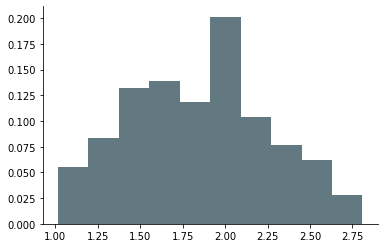

In [854]:
plt.hist(θ_list*1000, weights=πa[:,-1,-1])
plt.hist(θ_list*1000, weights=πa_o[:, 0, 0], alpha=0.3)

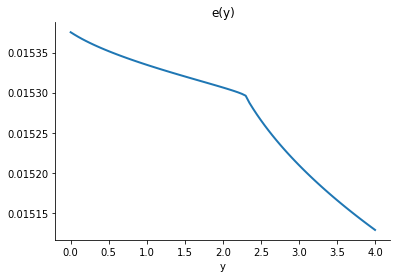

In [855]:
plt.plot(y_grid, ems[:, 0])
plt.xlabel('y')
plt.title('e(y)')
# plt.savefig('emission.png')
plt.show()

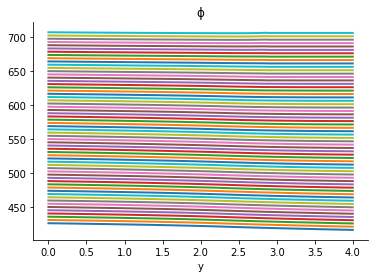

In [856]:
plt.plot(y_grid, v0[:, -60:])
plt.xlabel('y')
plt.title('ϕ')
# plt.savefig('emission.png')
plt.show()

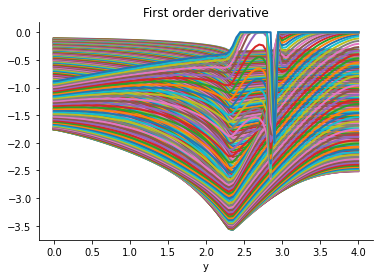

In [857]:
plt.plot(y_grid, v0_dy)
plt.title('First order derivative')
plt.xlabel('y')
# plt.savefig('1stderi.png')
plt.show()

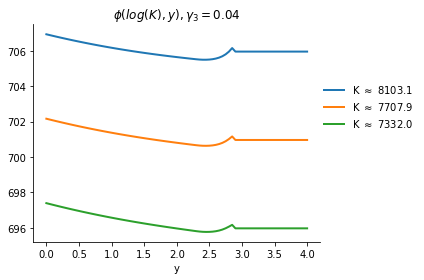

In [858]:
loc1 = np.abs(np.exp(k_grid) - 700).argmin()
# plt.plot(y_grid, v0[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
# plt.plot(y_grid, v0[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.plot(y_grid, v0[:, -1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])),)
plt.plot(y_grid, v0[:, -2], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-2])), )
plt.plot(y_grid, v0[:, -3], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-3])), )
plt.legend(loc=(1, 0.5))
plt.title(r'$\phi(log(K), y), \gamma_3 = {:.2f}$'.format(γ3))
plt.xlabel('y')
plt.tight_layout()
# plt.savefig('v.png', dpi=300)
plt.show()

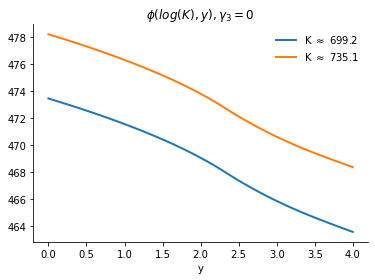

In [859]:
plt.plot(y_grid, v0[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, v0[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\phi(log(K), y), \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ϕ_new.png', dpi=300)
plt.show()

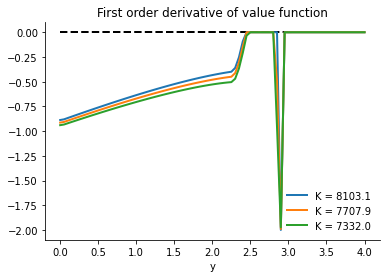

In [860]:
plt.plot(y_grid, v0_dy[:,-1], label="K = {:.1f}".format(np.exp(k_grid[-1])))
plt.plot(y_grid, v0_dy[:,-2], label="K = {:.1f}".format(np.exp(k_grid[-2])))
plt.plot(y_grid, v0_dy[:,-3], label="K = {:.1f}".format(np.exp(k_grid[-3])))
plt.hlines(0, 0, 3, linestyle='dashed', color="black")
plt.legend(loc=4)
plt.title('First order derivative of value function')
plt.xlabel('y')
# plt.savefig('firstoder.png', dpi=300)
plt.show()

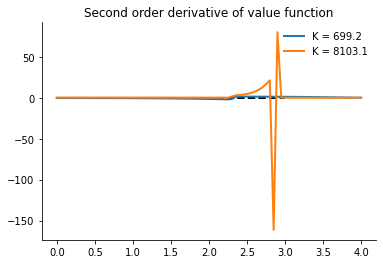

In [861]:
plt.plot(y_grid, v0_dyy[:,loc1], label="K = {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, v0_dyy[:, -1], label="K = {:.1f}".format(np.exp(k_grid[-1])))
plt.hlines(0, 0, 3, linestyle='dashed', color="black")
plt.legend()
plt.title('Second order derivative of value function')
# plt.savefig('secondorder.png', dpi=300)
plt.show()

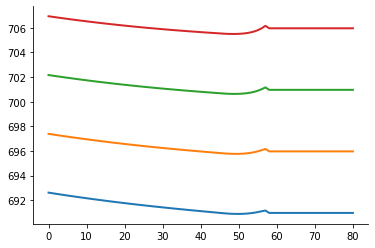

In [862]:
plt.plot(v0[:, -4:])
plt.show()

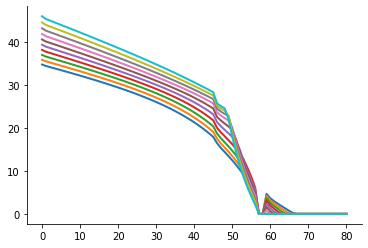

In [863]:
plt.plot(ems[:, -10:])
plt.show()

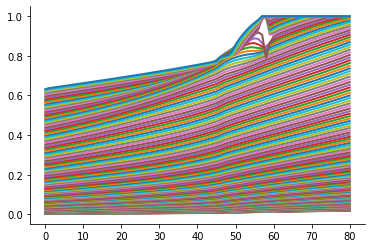

In [864]:
plt.plot(1 -  ems_new/(α*λ_bar*np.exp(k_mat)))
plt.show()

Text(0.5, 0, 'y')

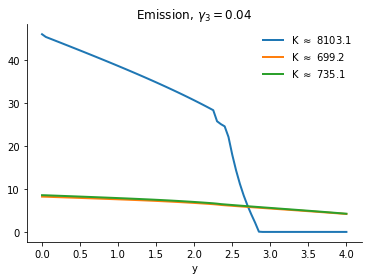

In [865]:
# plt.plot(y_grid, ems[:, -1])
# plt.plot(y_grid, ems[:, 0], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[0])))
plt.plot(y_grid, ems[:, -1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])))
plt.plot(y_grid, ems[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ems[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'Emission, $\gamma_3 = {:.2f}$'.format(γ3))
plt.xlabel('y')
# plt.savefig('emission_2.png', dpi=300)
# plt.ylim(0,12)

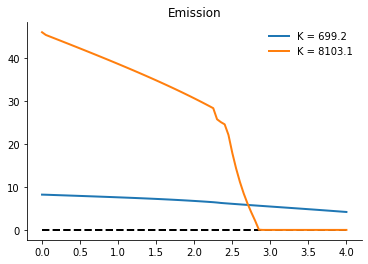

In [866]:
plt.plot(y_grid, ems[:,loc1], label="K = {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ems[:, -1], label="K = {:.1f}".format(np.exp(k_grid[-1])))
plt.hlines(0, 0, 4, linestyle='dashed', color="black")
plt.legend()
plt.title('Emission')
# plt.savefig('emission.png', dpi=300)
plt.show()

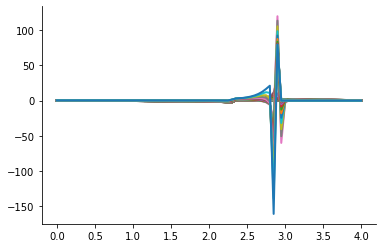

In [867]:
plt.plot(y_grid, v0_dyy)
plt.show()

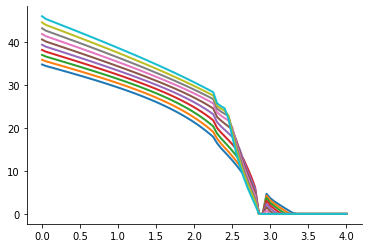

In [868]:
plt.plot(y_grid, ems[:, -10:])
plt.show()

In [869]:
y_grid[-10], y_mat.shape

(3.5500000000000003, (81, 181))

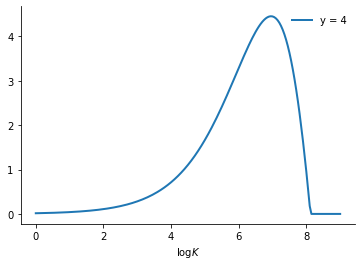

In [870]:
plt.plot(k_grid, ems[-1], label="y = 4")
plt.xlabel("$\log K$")
plt.legend()
# plt.savefig('e_logk.png')

Text(0.5, 1.0, 'Emission, $\\gamma_3 = 0.04$')

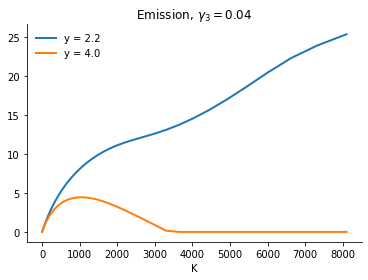

In [774]:
loc = np.abs(y_grid  - 2.2).argmin()
plt.plot(np.exp(k_grid), ems[loc], label = "y = {}".format(y_grid[loc]))
loc = np.abs(y_grid  - 4).argmin()
plt.plot(np.exp(k_grid), ems[loc], label = "y = {}".format(y_grid[loc]))
plt.legend()
plt.xlabel('K')
plt.title('Emission, $\gamma_3 = {:.2f}$'.format(γ3))
# plt.savefig('emission_k.png', dpi=300)

Text(0.5, 1.0, 'Emission')

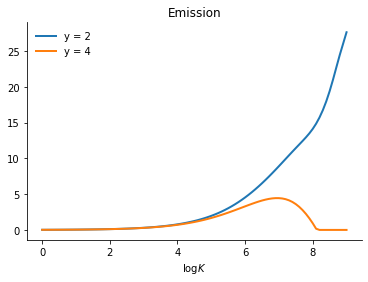

In [775]:
loc = np.abs(y_grid  - 2).argmin()
plt.plot(k_grid, ems[loc], label = "y = 2")
loc = np.abs(y_grid  - 4).argmin()
plt.plot(k_grid, ems[loc], label = "y = 4")
plt.legend()
plt.xlabel('$\log K$')
plt.title('Emission')
# plt.savefig('emission_k_9.png', dpi=300)

Text(0.5, 0, 'y')

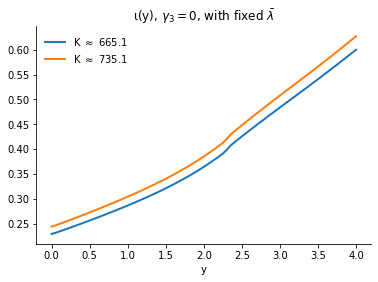

In [776]:
iota = 1 - ems/np.exp(k_mat)/α/λ_bar
plt.plot(y_grid, iota[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, iota[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'ι(y), $\gamma_3 = 0$, with fixed $\bar \lambda$')
plt.xlabel('y')
# plt.savefig('iota_01.png', dpi=300)

Text(0.5, 0, 'y')

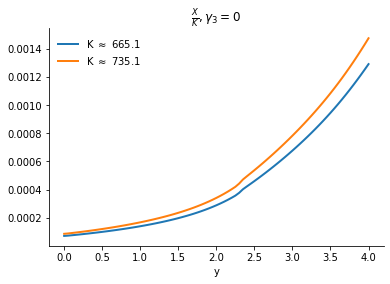

In [777]:
ra = α*ϑ_bar*iota**θ
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{X}{K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('XK_new.png', dpi=300)

Text(0.5, 0, 'y')

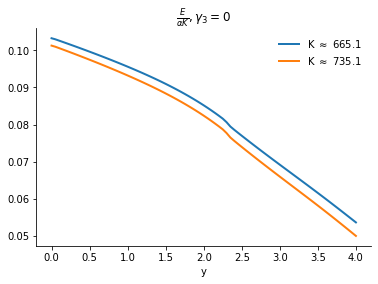

In [778]:
ra = ems/np.exp(k_mat)/α
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{E}{\alpha K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ratio_01.png', dpi=300)

Text(0.5, 0, 'y')

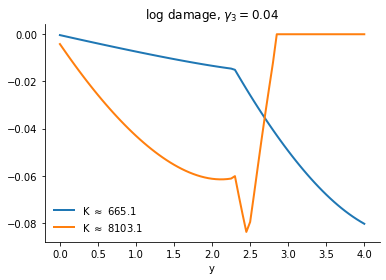

In [779]:
logn_drift = vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2)
plt.plot(y_grid, logn_drift[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, logn_drift[:, -1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])))
plt.legend()
plt.title(r'log damage, $\gamma_3 = {:.2f}$'.format(γ3))
plt.xlabel('y')
# plt.savefig('logn.png', dpi=300)

Text(0.5, 0, 'y')

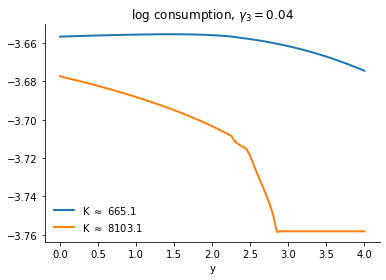

In [780]:
plt.plot(y_grid, np.log(consumption[:, loc1]), label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, np.log(consumption[:, -1]), label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])))
plt.legend()
plt.title(r'log consumption, $\gamma_3 = {:.2f}$'.format(γ3))
plt.xlabel('y')
# plt.savefig('logC.png', dpi=300)

In [781]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [782]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_new, args_list)
    return res_list        

In [783]:
γ3_list.shape, y_bar

((10,), 2.3)

# Testing parameters


## 1. $(\theta, \lambda, \vartheta) = (3, 0.134, 0.052)$

In [332]:
args_list = []

θ=3
ξa=0.01
ϑ_bar=0.052
λ_bar=0.134

y_bar = 2.3

for γ3_i in γ3_list:
    args_func = (δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3_i, y_bar, ξa, ϑ_bar, λ_bar)
    args_iter = (y_grid, k_grid, args_func, 0.05, 10_000, 1e-5)
    args_list.append(args_iter)

res_list = ode_y_parallel(args_list)

Episode 10000: PDE Error: 0.021186343041; ft Error: 0.012082354145; Iterations: 3; CG Error: 0.000000000080
Episode 10000: PDE Error: 0.023014495257; ft Error: 0.012101426369; Iterations: 3; CG Error: 0.000000000076
Episode 10000: PDE Error: 0.070781298471; ft Error: 0.066303266144; Iterations: 4; CG Error: 0.000000000008
Episode 10000: PDE Error: 0.023455208588; ft Error: 0.012105226056; Iterations: 3; CG Error: 0.000000000076
Episode 10000: PDE Error: 0.023919006333; ft Error: 0.012108316814; Iterations: 3; CG Error: 0.000000000076
Episode 10000: PDE Error: 0.034876979901; ft Error: 0.033809256283; Iterations: 4; CG Error: 0.000000000012
Episode 10000: PDE Error: 0.022482400899; ft Error: 0.012096658439; Iterations: 3; CG Error: 0.000000000076
Episode 10000: PDE Error: 0.030499279825; ft Error: 0.029237854371; Iterations: 4; CG Error: 0.000000000021
Episode 10000: PDE Error: 0.083669492725; ft Error: 0.064146376328; Iterations: 3; CG Error: 0.000000000088
Episode 10000: PDE Error: 0.

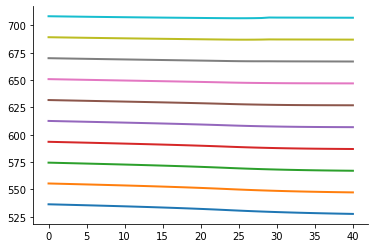

In [872]:
plt.plot(res_list[1]['v0'][:,-10:])
plt.show()

In [873]:
res_list[1]['v0'].shape

(41, 46)

## 2. $(\theta, \lambda, \vartheta) = (3, 0.102, 0.036)$

In [111]:
# args_list_2 = []

# θ=3
# ξa=0.01
# ϑ_bar=0.036
# λ_bar=0.102

# for γ3_i in γ3_two:
#     args_func = (δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3_i, y_bar, ξa, ϑ_bar, λ_bar)
#     args_iter = (y_grid, k_grid, args_func, 0.5, 4_000, 1e-7)
#     args_list_2.append(args_iter)

# res_list_2 = ode_y_parallel(args_list_2)
# res_two_damage.append(res_list_2)

## 3. $(\theta, \lambda, \vartheta) = (3, 0.0925, 0.032)$

In [112]:
# args_list_3 = []

# θ=3
# ξa=0.01
# ϑ_bar=0.032
# λ_bar=0.0925

# for γ3_i in γ3_two:
#     args_func = (δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3_i, y_bar, ξa, ϑ_bar, λ_bar)
#     args_iter = (y_grid, k_grid, args_func, 0.5, 4_000, 1e-7)
#     args_list_3.append(args_iter)

# res_list_3 = ode_y_parallel(args_list_3)
# res_two_damage.append(res_list_3)

In [874]:
res_data = dict(
    y_grid=y_grid,
    k_grid=k_grid,
    res_list=res_list,
)

pickle.dump(res_data, open('../data/res_10_23', 'wb'))

res_data = pickle.load(open('../data/res_10_23', 'rb'))
y_grid = res_data['y_grid']
k_grid = res_data['k_grid']

In [114]:
# res_list_1 =  pickle.load(open("../data/reslist1.p", "rb"))
# res_list_2 =  pickle.load(open("../data/reslist2.p", "rb"))
# res_list_3 =  pickle.load(open("../data/reslist3.p", "rb"))
# res_list_4 =  pickle.load(open("../data/reslist4.p", "rb"))
# res_list_5 =  pickle.load(open("../data/reslist5.p", "rb"))
# res_list_6 =  pickle.load(open("../data/reslist6.p", "rb"))
# res_two_damage =  pickle.load(open("../data/res_two_damage", "rb"))

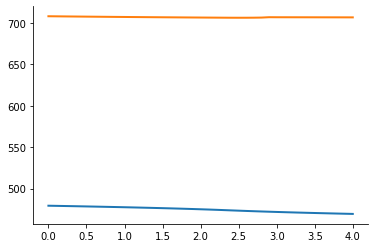

In [875]:
loc = np.abs(np.exp(k_grid) - 700).argmin()
plt.plot(y_grid, res_list[1]['v0'][:,loc])
plt.plot(y_grid, res_list[1]['v0'][:,-1])
plt.show()

In [876]:
y_grid[30]

3.0

In [877]:
v_list = np.zeros((len(res_list), n_y, n_k))
ems_list = np.zeros((len(res_list), n_y, n_k))
for i in range(len(res_list)):
    v_list[i] = res_list[i]['v0']    
    ems_list[i] = res_list[i]['ems']

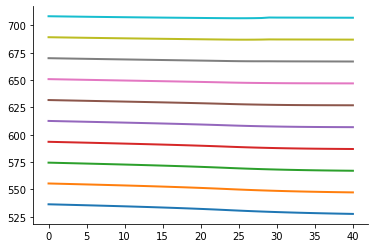

In [878]:
plt.plot(v_list[1][:, -10:])
plt.show()

In [641]:
loc23 = np.abs(y_grid - 2.4).argmin()
y_grid_cap = y_grid[:loc23+1]
y_grid_cap

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4])

In [896]:
# solve pre jump
loc23 = np.abs(y_grid - 2.4).argmin()
y_grid_cap = y_grid[:loc23+1]
n_y = len(y_grid_cap)
n_k = len(k_grid)
dy = y_grid_cap[1] - y_grid_cap[0]
dk = k_grid[1] - k_grid[0]
(y_mat_cap, k_mat_cap) = np.meshgrid(y_grid_cap, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat_cap.reshape(-1,1, order='F'), k_mat_cap.reshape(-1,1,order='F')])


πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

πd_o = np.zeros((len(γ3_list), n_y, n_k))
for i in range(len(γ3_list)):
    πd_o[i] = dmg_weight[i]

dΛ = γ1 + γ2*y_mat_cap 
ddΛ = γ2 

ξp = 5
ξa = 0.01
ξw = 100_000

numy_bar = len(y_grid_cap) - 1

r1=1.5
r2=2.5

y_lower = 1.8
intensity = r1*(np.exp(r2/2*(y_mat_cap- y_lower)**2)-1)*(y_mat_cap >= y_lower)


ϕ = np.average(v_list, axis=0, weights=dmg_weight)[:numy_bar+1]
ϕ_dk = derivatives_2d(ϕ, 1, 1, dk)
ems = 0*np.ones(y_mat_cap.shape)
# initial i
a_i = κ*ϕ_dk
b_i = - (1 + α*κ)*ϕ_dk
c_i = α*ϕ_dk - 1
i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)
mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat_cap)*α*λ_bar))**θ )

episode = 0
lhs_error = 1
πᵈo = dmg_weight

v_average = np.average(np.exp(-1/ξp*v_list), weights=dmg_weight, axis=0)
ϕ_bound = -ξp*np.log(v_average)

ϕ = ϕ_bound[:numy_bar+1]

tol= 1e-7
ϵ = 0.05
max_iter = 4000
vd = -1/δ

while lhs_error > tol: # and episode < max_iter:
    ϕ_old = ϕ.copy()
    ϕ_dy = derivatives_2d(ϕ, 0, 1, dy)
    ϕ_dyy = derivatives_2d(ϕ, 0, 2, dy)
    ϕ_dk = derivatives_2d(ϕ, 1, 1, dk)
    ϕ_dkk = derivatives_2d(ϕ, 1, 2, dk)
    # update control
    # updating controls
    i_new = (1 -mc/ϕ_dk)*(1/κ)
#     update emission
    if θ == 2:
        a = ϕ_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + ϕ_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = - b/a
    elif θ == 3:
        a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap))/(α**2*λ_bar**2*np.exp(2*k_mat_cap))
        b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap))*2/(α*λ_bar*np.exp(k_mat_cap)) + (ϕ_dyy+ vd*ddΛ)*σy**2 
        c =  mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap)) + (ϕ_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
    ems_new[ems_new < 0] = 0
    i_new = i_new*0.05 + i*0.95
    ems_new = ems_new*0.05 + ems*0.95
    ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat_cap)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat_cap))) > 0 )
#     ratio[ratio > 1] = 1
    consumption = α - i_new - α*ϑ_bar*ratio**θ
#     consumption[consumption < 1e-15] = 1e-15
    mc_new = 1/consumption
    
#     mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.05 + mc*0.95
    temp = ϕ_dy + vd*dΛ
    weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    print("min ems:", np.min(ems_new))
    print("min mc", np.min(mc_new))
    # HJB coefficient
    ϕ_ref = np.zeros((len(γ3_list), n_y, n_k))
    for i in range(len(γ3_list)):
        ϕ_ref[i] = v_list[i, numy_bar]
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref))
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat_cap.shape) - intensity*np.sum(πd_o*g_list, axis=0)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat_cap.shape)
    D = np.log(consumption) + k_mat_cap + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy + ξp*intensity * np.sum(πd_o*(1 - g_list + g_list*np.log(g_list)), axis=0)\
        + intensity*np.sum(πd_o*(g_list*ϕ_ref), axis=0)
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, ϕ, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(ϕ.shape,order = "F")
    rhs = A*ϕ + B_y*ϕ_dy + B_k*ϕ_dk + C_yy*ϕ_dyy + C_kk*ϕ_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - ϕ)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    ϕ = out_comp
    ems = ems_new
    mc = mc_new
    i = i_new

solution = dict(ϕ=ϕ, ems=ems, i=i, g_list=g_list)

min ems: 0.0007642272977299345
min mc 46.55498812500033
Episode 0: PDE Error: 0.764081741012; ft Error: 0.747341283461; Iterations: 3; CG Error: 0.000000000001
min ems: 0.0014900045442882356
min mc 44.145795648235875
Episode 1: PDE Error: 0.719955380360; ft Error: 0.704452258495; Iterations: 3; CG Error: 0.000000000002
min ems: 0.002179346231628905
min mc 42.478431299620695
Episode 2: PDE Error: 0.683241169614; ft Error: 0.668727813014; Iterations: 3; CG Error: 0.000000000002
min ems: 0.002834132391423245
min mc 41.292865800745645
Episode 3: PDE Error: 0.651514749396; ft Error: 0.637807935689; Iterations: 3; CG Error: 0.000000000004
min ems: 0.0034561304858024026
min mc 40.43318060364664
Episode 4: PDE Error: 0.623434442544; ft Error: 0.610388948679; Iterations: 3; CG Error: 0.000000000005
min ems: 0.004047008050299672
min mc 39.804068172023534
Episode 5: PDE Error: 0.598184133914; ft Error: 0.585679745471; Iterations: 3; CG Error: 0.000000000006
min ems: 0.004608341491295801
min mc 39

min ems: 0.014937765700124983
min mc 38.60188703258388
Episode 73: PDE Error: 0.204629442819; ft Error: 0.184214269192; Iterations: 4; CG Error: 0.000000000014
min ems: 0.014954892887290731
min mc 38.602139801568114
Episode 74: PDE Error: 0.202578346213; ft Error: 0.183072769233; Iterations: 4; CG Error: 0.000000000014
min ems: 0.014971163616779607
min mc 38.60237223102037
Episode 75: PDE Error: 0.200551893864; ft Error: 0.181935707241; Iterations: 4; CG Error: 0.000000000014
min ems: 0.014986620809330272
min mc 38.602586150832
Episode 76: PDE Error: 0.198549704053; ft Error: 0.180803124147; Iterations: 4; CG Error: 0.000000000014
min ems: 0.015001305238415715
min mc 38.60278321677045
Episode 77: PDE Error: 0.196571404473; ft Error: 0.179675059063; Iterations: 4; CG Error: 0.000000000014
min ems: 0.015015255637615547
min mc 38.60296492749738
Episode 78: PDE Error: 0.195503379829; ft Error: 0.178551549135; Iterations: 4; CG Error: 0.000000000015
min ems: 0.015028508802620617
min mc 38.6

min ems: 0.015266952119378972
min mc 38.6055678212667
Episode 147: PDE Error: 0.147015981301; ft Error: 0.114576649314; Iterations: 4; CG Error: 0.000000000014
min ems: 0.015267273321401827
min mc 38.60557266910725
Episode 148: PDE Error: 0.146408115457; ft Error: 0.113838351388; Iterations: 4; CG Error: 0.000000000014
min ems: 0.015267576175431773
min mc 38.60557734633945
Episode 149: PDE Error: 0.145802728833; ft Error: 0.113103996443; Iterations: 4; CG Error: 0.000000000014
min ems: 0.015267861640705819
min mc 38.605581859470306
Episode 150: PDE Error: 0.145199809766; ft Error: 0.112373567011; Iterations: 4; CG Error: 0.000000000014
min ems: 0.01526813062824696
min mc 38.605586214712645
Episode 151: PDE Error: 0.144599346603; ft Error: 0.111647045687; Iterations: 4; CG Error: 0.000000000014
min ems: 0.015268384003276925
min mc 38.60559041800199
Episode 152: PDE Error: 0.144001327708; ft Error: 0.110924415106; Iterations: 4; CG Error: 0.000000000014
min ems: 0.015268622587508345
min 

min ems: 0.015271944129662115
min mc 38.60569898180137
Episode 222: PDE Error: 0.107572782663; ft Error: 0.088829616179; Iterations: 4; CG Error: 0.000000000013
min ems: 0.015271945385724963
min mc 38.60569935032182
Episode 223: PDE Error: 0.107121868657; ft Error: 0.088556733695; Iterations: 4; CG Error: 0.000000000013
min ems: 0.015271946845623751
min mc 38.60569970688114
Episode 224: PDE Error: 0.106672716827; ft Error: 0.088283532408; Iterations: 4; CG Error: 0.000000000013
min ems: 0.015271948526599318
min mc 38.605700051897784
Episode 225: PDE Error: 0.106225320458; ft Error: 0.088010022679; Iterations: 4; CG Error: 0.000000000013
min ems: 0.015271950444886422
min mc 38.60570038577597
Episode 226: PDE Error: 0.105779672916; ft Error: 0.087736214761; Iterations: 4; CG Error: 0.000000000013
min ems: 0.015271952615765071
min mc 38.605700708906
Episode 227: PDE Error: 0.105335767638; ft Error: 0.087462118810; Iterations: 4; CG Error: 0.000000000013
min ems: 0.015271955053609116
min m

min ems: 0.015273089460377594
min mc 38.60571010760195
Episode 297: PDE Error: 0.088587403261; ft Error: 0.070374259731; Iterations: 4; CG Error: 0.000000000012
min ems: 0.015273120903715676
min mc 38.60571015760374
Episode 298: PDE Error: 0.088428009592; ft Error: 0.070292523658; Iterations: 4; CG Error: 0.000000000012
min ems: 0.015273152756246173
min mc 38.60571020668693
Episode 299: PDE Error: 0.088268198988; ft Error: 0.070209802954; Iterations: 4; CG Error: 0.000000000012
min ems: 0.015273185016369501
min mc 38.605710254877245
Episode 300: PDE Error: 0.088107975644; ft Error: 0.070126104655; Iterations: 4; CG Error: 0.000000000012
min ems: 0.015273217682476768
min mc 38.60571030219939
Episode 301: PDE Error: 0.087947343744; ft Error: 0.070041435765; Iterations: 4; CG Error: 0.000000000012
min ems: 0.015273250752950725
min mc 38.60571034867718
Episode 302: PDE Error: 0.087786307458; ft Error: 0.069955803259; Iterations: 4; CG Error: 0.000000000012
min ems: 0.015273284226166726
min

Episode 371: PDE Error: 0.076767741369; ft Error: 0.063106700158; Iterations: 4; CG Error: 0.000000000011
min ems: 0.015275269954310207
min mc 38.605712313236324
Episode 372: PDE Error: 0.076609180673; ft Error: 0.063002317827; Iterations: 4; CG Error: 0.000000000011
min ems: 0.01527524337995954
min mc 38.605712329455294
Episode 373: PDE Error: 0.076450466730; ft Error: 0.062897360289; Iterations: 4; CG Error: 0.000000000011
min ems: 0.015275216959281815
min mc 38.60571234544895
Episode 374: PDE Error: 0.076291602573; ft Error: 0.062791832236; Iterations: 4; CG Error: 0.000000000011
min ems: 0.015275190691931978
min mc 38.60571236122012
Episode 375: PDE Error: 0.076132591232; ft Error: 0.062685738336; Iterations: 4; CG Error: 0.000000000011
min ems: 0.01527516457756578
min mc 38.60571237677168
Episode 376: PDE Error: 0.075973435733; ft Error: 0.062579083238; Iterations: 4; CG Error: 0.000000000011
min ems: 0.015275138615839776
min mc 38.605712392106426
Episode 377: PDE Error: 0.0758141

min ems: 0.015273697183002019
min mc 38.60571305499096
Episode 446: PDE Error: 0.065268164352; ft Error: 0.055506748647; Iterations: 4; CG Error: 0.000000000011
min ems: 0.015273681107173198
min mc 38.60571306039097
Episode 447: PDE Error: 0.065124781568; ft Error: 0.055401006184; Iterations: 4; CG Error: 0.000000000011
min ems: 0.015273665161963256
min mc 38.60571306570627
Episode 448: PDE Error: 0.064981401818; ft Error: 0.055294937957; Iterations: 4; CG Error: 0.000000000011
min ems: 0.01527364934709546
min mc 38.60571307093812
Episode 449: PDE Error: 0.064838027216; ft Error: 0.055188547200; Iterations: 4; CG Error: 0.000000000011
min ems: 0.015273633662293933
min mc 38.6057130760877
Episode 450: PDE Error: 0.064694659868; ft Error: 0.055081837127; Iterations: 4; CG Error: 0.000000000011
min ems: 0.01527361810728368
min mc 38.60571308115619
Episode 451: PDE Error: 0.064551301880; ft Error: 0.054974810945; Iterations: 4; CG Error: 0.000000000011
min ems: 0.015273602681790552
min mc 

min ems: 0.015272843383116385
min mc 38.60571328963637
Episode 520: PDE Error: 0.055130835145; ft Error: 0.049475801193; Iterations: 4; CG Error: 0.000000000010
min ems: 0.015272836278330983
min mc 38.605713291236896
Episode 521: PDE Error: 0.055008146483; ft Error: 0.049414696731; Iterations: 4; CG Error: 0.000000000010
min ems: 0.015272829285830694
min mc 38.60571329281061
Episode 522: PDE Error: 0.054885532990; ft Error: 0.049353144260; Iterations: 4; CG Error: 0.000000000010
min ems: 0.015272822405394775
min mc 38.605713294358
Episode 523: PDE Error: 0.054762996017; ft Error: 0.049291146152; Iterations: 4; CG Error: 0.000000000010
min ems: 0.015272815636803177
min mc 38.60571329587946
Episode 524: PDE Error: 0.054640536917; ft Error: 0.049228704794; Iterations: 4; CG Error: 0.000000000010
min ems: 0.015272808979836459
min mc 38.60571329737547
Episode 525: PDE Error: 0.054518157033; ft Error: 0.049165822561; Iterations: 4; CG Error: 0.000000000010
min ems: 0.015272802434275824
min m

min ems: 0.015272606319432724
min mc 38.60571335676173
Episode 592: PDE Error: 0.046567821121; ft Error: 0.045388658416; Iterations: 3; CG Error: 0.000000000069
min ems: 0.015272606771723637
min mc 38.60571335723395
Episode 593: PDE Error: 0.046465736672; ft Error: 0.045329831097; Iterations: 3; CG Error: 0.000000000068
min ems: 0.015272607321939873
min mc 38.605713357698285
Episode 594: PDE Error: 0.046363747789; ft Error: 0.045270678295; Iterations: 3; CG Error: 0.000000000068
min ems: 0.015272607969901859
min mc 38.6057133581548
Episode 595: PDE Error: 0.046261855297; ft Error: 0.045211201847; Iterations: 3; CG Error: 0.000000000067
min ems: 0.015272608715430494
min mc 38.605713358603744
Episode 596: PDE Error: 0.046160060019; ft Error: 0.045151403586; Iterations: 3; CG Error: 0.000000000066
min ems: 0.015272609558347194
min mc 38.60571335904514
Episode 597: PDE Error: 0.046058362772; ft Error: 0.045091285366; Iterations: 3; CG Error: 0.000000000066
min ems: 0.01527261049847389
min 

min mc 38.605713377107485
Episode 667: PDE Error: 0.039228160058; ft Error: 0.041414093711; Iterations: 3; CG Error: 0.000000000040
min ems: 0.015272907768543936
min mc 38.60571337724351
Episode 668: PDE Error: 0.039135294481; ft Error: 0.041361134179; Iterations: 3; CG Error: 0.000000000040
min ems: 0.015272915184487406
min mc 38.60571337737735
Episode 669: PDE Error: 0.039042576387; ft Error: 0.041307934224; Iterations: 3; CG Error: 0.000000000040
min ems: 0.015272922686023436
min mc 38.605713377509026
Episode 670: PDE Error: 0.038950006324; ft Error: 0.041254495229; Iterations: 3; CG Error: 0.000000000040
min ems: 0.01527293027300607
min mc 38.605713377638594
Episode 671: PDE Error: 0.038857584833; ft Error: 0.041200818556; Iterations: 3; CG Error: 0.000000000039
min ems: 0.015272937945289758
min mc 38.60571337776609
Episode 672: PDE Error: 0.038765312456; ft Error: 0.041146905583; Iterations: 3; CG Error: 0.000000000039
min ems: 0.015272945702729336
min mc 38.605713377891526
Episod

min ems: 0.015273678702145686
min mc 38.60571338310686
Episode 742: PDE Error: 0.033279742833; ft Error: 0.037813147428; Iterations: 3; CG Error: 0.000000000033
min ems: 0.015273692081644592
min mc 38.60571338314865
Episode 743: PDE Error: 0.033280758284; ft Error: 0.037768144468; Iterations: 3; CG Error: 0.000000000033
min ems: 0.015273705536914043
min mc 38.60571338318982
Episode 744: PDE Error: 0.033281762693; ft Error: 0.037722956264; Iterations: 3; CG Error: 0.000000000033
min ems: 0.01527371906783391
min mc 38.60571338323038
Episode 745: PDE Error: 0.033282756148; ft Error: 0.037677583812; Iterations: 3; CG Error: 0.000000000033
min ems: 0.015273732674284404
min mc 38.60571338327032
Episode 746: PDE Error: 0.033283738733; ft Error: 0.037632028102; Iterations: 3; CG Error: 0.000000000032
min ems: 0.015273746356146046
min mc 38.605713383309656
Episode 747: PDE Error: 0.033284710533; ft Error: 0.037586290131; Iterations: 3; CG Error: 0.000000000032
min ems: 0.01527376011329966
min m

min ems: 0.015274884682891851
min mc 38.60571338500456
Episode 817: PDE Error: 0.033330887826; ft Error: 0.035058624120; Iterations: 3; CG Error: 0.000000000023
min ems: 0.015274903431978192
min mc 38.60571338501835
Episode 818: PDE Error: 0.033331301067; ft Error: 0.035022851125; Iterations: 3; CG Error: 0.000000000022
min ems: 0.015274922248639288
min mc 38.605713385031905
Episode 819: PDE Error: 0.033331709025; ft Error: 0.034986867997; Iterations: 3; CG Error: 0.000000000022
min ems: 0.015274941132776231
min mc 38.60571338504531
Episode 820: PDE Error: 0.033332111759; ft Error: 0.034950675644; Iterations: 3; CG Error: 0.000000000022
min ems: 0.01527496008429045
min mc 38.605713385058515
Episode 821: PDE Error: 0.033332509330; ft Error: 0.034914274967; Iterations: 3; CG Error: 0.000000000022
min ems: 0.015274979103083558
min mc 38.605713385071525
Episode 822: PDE Error: 0.033332901796; ft Error: 0.034877666875; Iterations: 3; CG Error: 0.000000000022
min ems: 0.015274998189057469
mi

min ems: 0.015276472008855608
min mc 38.605713385650624
Episode 892: PDE Error: 0.033350672175; ft Error: 0.032493349109; Iterations: 3; CG Error: 0.000000000014
min ems: 0.015276495568242067
min mc 38.60571338565549
Episode 893: PDE Error: 0.033350822956; ft Error: 0.032465078347; Iterations: 3; CG Error: 0.000000000013
min ems: 0.015276519188458404
min mc 38.6057133856603
Episode 894: PDE Error: 0.033350971652; ft Error: 0.032436634098; Iterations: 3; CG Error: 0.000000000013
min ems: 0.01527654286942337
min mc 38.60571338566504
Episode 895: PDE Error: 0.033351118291; ft Error: 0.032408017001; Iterations: 3; CG Error: 0.000000000013
min ems: 0.015276566611055874
min mc 38.605713385669716
Episode 896: PDE Error: 0.033351262900; ft Error: 0.032379227699; Iterations: 3; CG Error: 0.000000000013
min ems: 0.01527659041327507
min mc 38.60571338567432
Episode 897: PDE Error: 0.033351405505; ft Error: 0.032350266833; Iterations: 3; CG Error: 0.000000000013
min ems: 0.015276614276000315
min m

min ems: 0.015278402530447672
min mc 38.60571338588138
Episode 967: PDE Error: 0.033357701329; ft Error: 0.030002341988; Iterations: 3; CG Error: 0.000000000008
min ems: 0.01527843044047421
min mc 38.605713385883185
Episode 968: PDE Error: 0.033357753347; ft Error: 0.029981351199; Iterations: 3; CG Error: 0.000000000008
min ems: 0.015278458405800551
min mc 38.60571338588493
Episode 969: PDE Error: 0.033357804623; ft Error: 0.029960215270; Iterations: 3; CG Error: 0.000000000008
min ems: 0.015278486426360326
min mc 38.60571338588665
Episode 970: PDE Error: 0.033357855168; ft Error: 0.029938934625; Iterations: 3; CG Error: 0.000000000008
min ems: 0.015278514502087337
min mc 38.60571338588837
Episode 971: PDE Error: 0.033357904991; ft Error: 0.029917509709; Iterations: 3; CG Error: 0.000000000008
min ems: 0.015278542632915601
min mc 38.60571338589004
Episode 972: PDE Error: 0.033357954104; ft Error: 0.029895940945; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015278570818779272
min 

Episode 1041: PDE Error: 0.033360089005; ft Error: 0.028086721328; Iterations: 3; CG Error: 0.000000000005
min ems: 0.01528064497591501
min mc 38.60571338596791
Episode 1042: PDE Error: 0.033360107021; ft Error: 0.028056251842; Iterations: 3; CG Error: 0.000000000005
min ems: 0.015280676861292074
min mc 38.60571338596859
Episode 1043: PDE Error: 0.033360124784; ft Error: 0.028025672972; Iterations: 3; CG Error: 0.000000000005
min ems: 0.015280708797480816
min mc 38.60571338596925
Episode 1044: PDE Error: 0.033360142297; ft Error: 0.027994985234; Iterations: 3; CG Error: 0.000000000005
min ems: 0.01528074078442783
min mc 38.605713385969885
Episode 1045: PDE Error: 0.033360159564; ft Error: 0.027964189159; Iterations: 3; CG Error: 0.000000000005
min ems: 0.01528077282207987
min mc 38.60571338597058
Episode 1046: PDE Error: 0.033360176588; ft Error: 0.027933285271; Iterations: 3; CG Error: 0.000000000004
min ems: 0.015280804910383847
min mc 38.6057133859712
Episode 1047: PDE Error: 0.0333

Episode 1116: PDE Error: 0.033360931880; ft Error: 0.026180728140; Iterations: 3; CG Error: 0.000000000003
min ems: 0.01528317396837986
min mc 38.605713386001504
Episode 1117: PDE Error: 0.033360938272; ft Error: 0.026158139545; Iterations: 3; CG Error: 0.000000000003
min ems: 0.015283209527105018
min mc 38.605713386001774
Episode 1118: PDE Error: 0.033360944578; ft Error: 0.026135452935; Iterations: 3; CG Error: 0.000000000003
min ems: 0.015283245133071614
min mc 38.60571338600203
Episode 1119: PDE Error: 0.033360950801; ft Error: 0.026112668658; Iterations: 3; CG Error: 0.000000000003
min ems: 0.015283280786237839
min mc 38.60571338600228
Episode 1120: PDE Error: 0.033360956942; ft Error: 0.026089787083; Iterations: 3; CG Error: 0.000000000003
min ems: 0.015283316486561994
min mc 38.605713386002535
Episode 1121: PDE Error: 0.033360963002; ft Error: 0.026066808566; Iterations: 3; CG Error: 0.000000000003
min ems: 0.015283352234002583
min mc 38.605713386002776
Episode 1122: PDE Error: 

Episode 1192: PDE Error: 0.033361242730; ft Error: 0.024547232227; Iterations: 3; CG Error: 0.000000000002
min ems: 0.015286008315645973
min mc 38.60571338601426
Episode 1193: PDE Error: 0.033361245161; ft Error: 0.024524351097; Iterations: 3; CG Error: 0.000000000002
min ems: 0.015286047355694969
min mc 38.605713386014386
Episode 1194: PDE Error: 0.033361247563; ft Error: 0.024501370858; Iterations: 3; CG Error: 0.000000000002
min ems: 0.01528608644021693
min mc 38.60571338601446
Episode 1195: PDE Error: 0.033361249937; ft Error: 0.024478291903; Iterations: 3; CG Error: 0.000000000002
min ems: 0.01528612556918084
min mc 38.605713386014536
Episode 1196: PDE Error: 0.033361252282; ft Error: 0.024455114626; Iterations: 3; CG Error: 0.000000000002
min ems: 0.015286164742555857
min mc 38.60571338601463
Episode 1197: PDE Error: 0.033361254600; ft Error: 0.024431839423; Iterations: 3; CG Error: 0.000000000002
min ems: 0.015286203960311249
min mc 38.605713386014735
Episode 1198: PDE Error: 0.

Episode 1268: PDE Error: 0.033361367513; ft Error: 0.022950552384; Iterations: 2; CG Error: 0.000000000079
min ems: 0.015289099583787597
min mc 38.60571338601898
Episode 1269: PDE Error: 0.033361368544; ft Error: 0.022934695920; Iterations: 2; CG Error: 0.000000000079
min ems: 0.015289141915729755
min mc 38.605713386019
Episode 1270: PDE Error: 0.033361369563; ft Error: 0.022918749808; Iterations: 2; CG Error: 0.000000000079
min ems: 0.015289184290196406
min mc 38.60571338601901
Episode 1271: PDE Error: 0.033361370571; ft Error: 0.022902714308; Iterations: 2; CG Error: 0.000000000079
min ems: 0.015289226707167708
min mc 38.60571338601903
Episode 1272: PDE Error: 0.033361371568; ft Error: 0.022886589670; Iterations: 2; CG Error: 0.000000000078
min ems: 0.01528926916662387
min mc 38.605713386019055
Episode 1273: PDE Error: 0.033361372555; ft Error: 0.022870376154; Iterations: 2; CG Error: 0.000000000078
min ems: 0.015289311668545224
min mc 38.60571338601906
Episode 1274: PDE Error: 0.033

Episode 1344: PDE Error: 0.033361421417; ft Error: 0.021508991116; Iterations: 2; CG Error: 0.000000000062
min ems: 0.015292436750458289
min mc 38.60571338601962
Episode 1345: PDE Error: 0.033361421880; ft Error: 0.021487106826; Iterations: 2; CG Error: 0.000000000062
min ems: 0.015292482265581792
min mc 38.60571338601964
Episode 1346: PDE Error: 0.033361422339; ft Error: 0.021465154531; Iterations: 2; CG Error: 0.000000000061
min ems: 0.015292527822054192
min mc 38.605713386019666
Episode 1347: PDE Error: 0.033361422792; ft Error: 0.021443134533; Iterations: 2; CG Error: 0.000000000061
min ems: 0.01529257341986504
min mc 38.60571338601968
Episode 1348: PDE Error: 0.033361423241; ft Error: 0.021421047151; Iterations: 2; CG Error: 0.000000000061
min ems: 0.015292619059004023
min mc 38.60571338601971
Episode 1349: PDE Error: 0.033361423686; ft Error: 0.021398892688; Iterations: 2; CG Error: 0.000000000061
min ems: 0.015292664739460952
min mc 38.60571338601974
Episode 1350: PDE Error: 0.0

min ems: 0.015295964589916979
min mc 38.60571338602034
Episode 1420: PDE Error: 0.033361446210; ft Error: 0.020262561931; Iterations: 2; CG Error: 0.000000000049
min ems: 0.015296013186554009
min mc 38.60571338602038
Episode 1421: PDE Error: 0.033361446428; ft Error: 0.020247144295; Iterations: 2; CG Error: 0.000000000048
min ems: 0.015296061824142384
min mc 38.60571338602041
Episode 1422: PDE Error: 0.033361446644; ft Error: 0.020231661556; Iterations: 2; CG Error: 0.000000000048
min ems: 0.015296110502682245
min mc 38.60571338602044
Episode 1423: PDE Error: 0.033361446859; ft Error: 0.020216113918; Iterations: 2; CG Error: 0.000000000048
min ems: 0.01529615922217383
min mc 38.60571338602046
Episode 1424: PDE Error: 0.033361447071; ft Error: 0.020200501592; Iterations: 2; CG Error: 0.000000000048
min ems: 0.01529620798261755
min mc 38.60571338602051
Episode 1425: PDE Error: 0.033361447281; ft Error: 0.020184824780; Iterations: 2; CG Error: 0.000000000048
min ems: 0.015296256784013973


min ems: 0.015299774844385413
min mc 38.605713386020426
Episode 1496: PDE Error: 0.033361458050; ft Error: 0.018920343748; Iterations: 2; CG Error: 0.000000000038
min ems: 0.015299826564156644
min mc 38.60571338602043
Episode 1497: PDE Error: 0.033361458155; ft Error: 0.018900596768; Iterations: 2; CG Error: 0.000000000038
min ems: 0.015299878325317847
min mc 38.60571338602042
Episode 1498: PDE Error: 0.033361458260; ft Error: 0.018880801553; Iterations: 2; CG Error: 0.000000000038
min ems: 0.01529993012788082
min mc 38.605713386020426
Episode 1499: PDE Error: 0.033361458364; ft Error: 0.018860958336; Iterations: 2; CG Error: 0.000000000038
min ems: 0.015299981971857531
min mc 38.60571338602041
Episode 1500: PDE Error: 0.033361458466; ft Error: 0.018841067352; Iterations: 2; CG Error: 0.000000000038
min ems: 0.015300033857260104
min mc 38.60571338602042
Episode 1501: PDE Error: 0.033361458568; ft Error: 0.018821128839; Iterations: 2; CG Error: 0.000000000038
min ems: 0.0153000857841008

min ems: 0.01530148402831563
min mc 38.605713386020255
Episode 1572: PDE Error: 0.033361463795; ft Error: 0.017930190286; Iterations: 2; CG Error: 0.000000000031
min ems: 0.015301481496532245
min mc 38.60571338602024
Episode 1573: PDE Error: 0.033361463846; ft Error: 0.017916116225; Iterations: 2; CG Error: 0.000000000031
min ems: 0.01530147896066207
min mc 38.605713386020255
Episode 1574: PDE Error: 0.033361463897; ft Error: 0.017901993682; Iterations: 2; CG Error: 0.000000000031
min ems: 0.015301476420701458
min mc 38.60571338602025
Episode 1575: PDE Error: 0.033361463948; ft Error: 0.017887822813; Iterations: 2; CG Error: 0.000000000031
min ems: 0.01530147387664676
min mc 38.605713386020255
Episode 1576: PDE Error: 0.033361463998; ft Error: 0.017873603783; Iterations: 2; CG Error: 0.000000000030
min ems: 0.015301471328494375
min mc 38.605713386020255
Episode 1577: PDE Error: 0.033361464047; ft Error: 0.017859336750; Iterations: 2; CG Error: 0.000000000030
min ems: 0.0153014687762405

min ems: 0.015301279709389073
min mc 38.6057133860202
Episode 1648: PDE Error: 0.033361466592; ft Error: 0.016747612494; Iterations: 2; CG Error: 0.000000000025
min ems: 0.015301276856633551
min mc 38.60571338602019
Episode 1649: PDE Error: 0.033361466617; ft Error: 0.016738353083; Iterations: 2; CG Error: 0.000000000025
min ems: 0.015301273999514857
min mc 38.60571338602019
Episode 1650: PDE Error: 0.033361466642; ft Error: 0.016729048141; Iterations: 2; CG Error: 0.000000000025
min ems: 0.015301271138029355
min mc 38.60571338602019
Episode 1651: PDE Error: 0.033361466666; ft Error: 0.016719697762; Iterations: 2; CG Error: 0.000000000025
min ems: 0.015301268272173468
min mc 38.60571338602016
Episode 1652: PDE Error: 0.033361466691; ft Error: 0.016710302048; Iterations: 2; CG Error: 0.000000000025
min ems: 0.015301265401943554
min mc 38.60571338602016
Episode 1653: PDE Error: 0.033361466715; ft Error: 0.016700861097; Iterations: 2; CG Error: 0.000000000025
min ems: 0.01530126252733598


min ems: 0.015301050212078799
min mc 38.60571338602008
Episode 1724: PDE Error: 0.033361467950; ft Error: 0.015921480840; Iterations: 2; CG Error: 0.000000000020
min ems: 0.01530104701749671
min mc 38.60571338602008
Episode 1725: PDE Error: 0.033361467963; ft Error: 0.015909065038; Iterations: 2; CG Error: 0.000000000020
min ems: 0.015301043818280248
min mc 38.60571338602008
Episode 1726: PDE Error: 0.033361467975; ft Error: 0.015896612121; Iterations: 2; CG Error: 0.000000000020
min ems: 0.01530104061442589
min mc 38.60571338602007
Episode 1727: PDE Error: 0.033361467986; ft Error: 0.015884122205; Iterations: 2; CG Error: 0.000000000020
min ems: 0.015301037405930163
min mc 38.60571338602007
Episode 1728: PDE Error: 0.033361467998; ft Error: 0.015871595414; Iterations: 2; CG Error: 0.000000000020
min ems: 0.015301034192789532
min mc 38.605713386020085
Episode 1729: PDE Error: 0.033361468010; ft Error: 0.015859031874; Iterations: 2; CG Error: 0.000000000020
min ems: 0.015301030975000527

min ems: 0.015300793972795348
min mc 38.60571338602011
Episode 1800: PDE Error: 0.033361468607; ft Error: 0.014912600230; Iterations: 2; CG Error: 0.000000000017
min ems: 0.015300790416196546
min mc 38.60571338602011
Episode 1801: PDE Error: 0.033361468613; ft Error: 0.014904335920; Iterations: 2; CG Error: 0.000000000017
min ems: 0.015300786854704746
min mc 38.60571338602011
Episode 1802: PDE Error: 0.033361468619; ft Error: 0.014896036011; Iterations: 2; CG Error: 0.000000000017
min ems: 0.015300783288316659
min mc 38.60571338602011
Episode 1803: PDE Error: 0.033361468624; ft Error: 0.014887700575; Iterations: 2; CG Error: 0.000000000017
min ems: 0.015300779717029003
min mc 38.605713386020135
Episode 1804: PDE Error: 0.033361468630; ft Error: 0.014879329692; Iterations: 2; CG Error: 0.000000000017
min ems: 0.015300776140838517
min mc 38.605713386020135
Episode 1805: PDE Error: 0.033361468636; ft Error: 0.014870923435; Iterations: 2; CG Error: 0.000000000017
min ems: 0.015300772559741

min ems: 0.015300509500581674
min mc 38.605713386020106
Episode 1876: PDE Error: 0.033361468923; ft Error: 0.014188701808; Iterations: 2; CG Error: 0.000000000014
min ems: 0.015300505563045031
min mc 38.6057133860201
Episode 1877: PDE Error: 0.033361468925; ft Error: 0.014177965197; Iterations: 2; CG Error: 0.000000000014
min ems: 0.015300501620377884
min mc 38.6057133860201
Episode 1878: PDE Error: 0.033361468928; ft Error: 0.014167199421; Iterations: 2; CG Error: 0.000000000014
min ems: 0.015300497672577278
min mc 38.60571338602008
Episode 1879: PDE Error: 0.033361468931; ft Error: 0.014156404575; Iterations: 2; CG Error: 0.000000000014
min ems: 0.015300493719640255
min mc 38.6057133860201
Episode 1880: PDE Error: 0.033361468934; ft Error: 0.014145580753; Iterations: 2; CG Error: 0.000000000014
min ems: 0.015300489761563915
min mc 38.6057133860201
Episode 1881: PDE Error: 0.033361468936; ft Error: 0.014134728045; Iterations: 2; CG Error: 0.000000000014
min ems: 0.015300485798345287
m

min ems: 0.015300195426186453
min mc 38.60571338602016
Episode 1952: PDE Error: 0.033361469074; ft Error: 0.013325588969; Iterations: 2; CG Error: 0.000000000012
min ems: 0.015300191090747045
min mc 38.60571338602013
Episode 1953: PDE Error: 0.033361469075; ft Error: 0.013313584798; Iterations: 2; CG Error: 0.000000000012
min ems: 0.015300186749970272
min mc 38.605713386020106
Episode 1954: PDE Error: 0.033361469076; ft Error: 0.013301554168; Iterations: 2; CG Error: 0.000000000012
min ems: 0.015300182403853675
min mc 38.60571338602009
Episode 1955: PDE Error: 0.033361469077; ft Error: 0.013289497185; Iterations: 2; CG Error: 0.000000000012
min ems: 0.01530017805239478
min mc 38.60571338602007
Episode 1956: PDE Error: 0.033361469079; ft Error: 0.013279852006; Iterations: 2; CG Error: 0.000000000012
min ems: 0.015300173695591106
min mc 38.60571338602006
Episode 1957: PDE Error: 0.033361469080; ft Error: 0.013272542363; Iterations: 2; CG Error: 0.000000000012
min ems: 0.01530016933344024

min ems: 0.015299850557202208
min mc 38.60571338602038
Episode 2028: PDE Error: 0.033361469145; ft Error: 0.012685452004; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015299845809614625
min mc 38.6057133860204
Episode 2029: PDE Error: 0.033361469146; ft Error: 0.012676280602; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015299841056524016
min mc 38.60571338602042
Episode 2030: PDE Error: 0.033361469147; ft Error: 0.012667085776; Iterations: 2; CG Error: 0.000000000010
min ems: 0.0152998362979285
min mc 38.60571338602044
Episode 2031: PDE Error: 0.033361469147; ft Error: 0.012657867593; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015299831533826242
min mc 38.60571338602043
Episode 2032: PDE Error: 0.033361469148; ft Error: 0.012648626126; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015299826764215404
min mc 38.605713386020454
Episode 2033: PDE Error: 0.033361469148; ft Error: 0.012639361444; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015299821989094173


min ems: 0.015299473938589969
min mc 38.6057133860205
Episode 2104: PDE Error: 0.033361469179; ft Error: 0.011957520296; Iterations: 2; CG Error: 0.000000000009
min ems: 0.01529946876815614
min mc 38.605713386020504
Episode 2105: PDE Error: 0.033361469180; ft Error: 0.011947337641; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015299463592106039
min mc 38.605713386020504
Episode 2106: PDE Error: 0.033361469180; ft Error: 0.011937133522; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015299458410438584
min mc 38.605713386020504
Episode 2107: PDE Error: 0.033361469180; ft Error: 0.011926908014; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015299453223152668
min mc 38.605713386020504
Episode 2108: PDE Error: 0.033361469180; ft Error: 0.011916661204; Iterations: 2; CG Error: 0.000000000009
min ems: 0.01529944803024723
min mc 38.605713386020504
Episode 2109: PDE Error: 0.033361469181; ft Error: 0.011906393175; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015299442831721

min ems: 0.015299064917466411
min mc 38.60571338602054
Episode 2180: PDE Error: 0.033361469196; ft Error: 0.011372198504; Iterations: 2; CG Error: 0.000000000008
min ems: 0.015299059317909766
min mc 38.60571338602056
Episode 2181: PDE Error: 0.033361469196; ft Error: 0.011364425233; Iterations: 2; CG Error: 0.000000000008
min ems: 0.015299053712687723
min mc 38.605713386020554
Episode 2182: PDE Error: 0.033361469196; ft Error: 0.011356632810; Iterations: 2; CG Error: 0.000000000008
min ems: 0.01529904810180011
min mc 38.605713386020554
Episode 2183: PDE Error: 0.033361469196; ft Error: 0.011348821286; Iterations: 2; CG Error: 0.000000000008
min ems: 0.015299042485246796
min mc 38.605713386020554
Episode 2184: PDE Error: 0.033361469196; ft Error: 0.011340990715; Iterations: 2; CG Error: 0.000000000007
min ems: 0.01529903686302763
min mc 38.605713386020554
Episode 2185: PDE Error: 0.033361469196; ft Error: 0.011333141148; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015299031235142

min ems: 0.015298623210526193
min mc 38.60571338602169
Episode 2256: PDE Error: 0.033361469203; ft Error: 0.010756676677; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015298617180887434
min mc 38.60571338602169
Episode 2257: PDE Error: 0.033361469203; ft Error: 0.010748091098; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015298611145610111
min mc 38.60571338602169
Episode 2258: PDE Error: 0.033361469203; ft Error: 0.010739487762; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015298605104695112
min mc 38.60571338602169
Episode 2259: PDE Error: 0.033361469203; ft Error: 0.010730866731; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015298599058143396
min mc 38.60571338602169
Episode 2260: PDE Error: 0.033361469203; ft Error: 0.010722228071; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015298593005955884
min mc 38.60571338602167
Episode 2261: PDE Error: 0.033361469203; ft Error: 0.010713571843; Iterations: 2; CG Error: 0.000000000007
min ems: 0.01529858694813351

Episode 2331: PDE Error: 0.033361469207; ft Error: 0.010223576939; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015298148972005925
min mc 38.60571338602168
Episode 2332: PDE Error: 0.033361469207; ft Error: 0.010217038285; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015298142517530026
min mc 38.60571338602168
Episode 2333: PDE Error: 0.033361469207; ft Error: 0.010210483716; Iterations: 2; CG Error: 0.000000000006
min ems: 0.01529813605752978
min mc 38.605713386021684
Episode 2334: PDE Error: 0.033361469207; ft Error: 0.010203913271; Iterations: 2; CG Error: 0.000000000006
min ems: 0.0152981295920073
min mc 38.605713386021684
Episode 2335: PDE Error: 0.033361469207; ft Error: 0.010197326994; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015298123120964745
min mc 38.605713386021684
Episode 2336: PDE Error: 0.033361469207; ft Error: 0.010190724921; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015298116644404277
min mc 38.605713386021684
Episode 2337: PDE Error: 0.

min mc 38.60571338602166
Episode 2407: PDE Error: 0.033361469208; ft Error: 0.009701582449; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015297642859636893
min mc 38.605713386021684
Episode 2408: PDE Error: 0.033361469208; ft Error: 0.009694387513; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015297635992614763
min mc 38.60571338602166
Episode 2409: PDE Error: 0.033361469208; ft Error: 0.009687177640; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015297629120280463
min mc 38.605713386021684
Episode 2410: PDE Error: 0.033361469208; ft Error: 0.009679952875; Iterations: 2; CG Error: 0.000000000005
min ems: 0.01529762224263747
min mc 38.60571338602166
Episode 2411: PDE Error: 0.033361469208; ft Error: 0.009672713266; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015297615359689301
min mc 38.605713386021684
Episode 2412: PDE Error: 0.033361469208; ft Error: 0.009665458860; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015297608471439487
min mc 38.60571338602166
E

min ems: 0.015297113350156532
min mc 38.60571338602164
Episode 2483: PDE Error: 0.033361469209; ft Error: 0.009200262322; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015297106095679162
min mc 38.60571338602164
Episode 2484: PDE Error: 0.033361469209; ft Error: 0.009194767379; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015297098836204056
min mc 38.60571338602164
Episode 2485: PDE Error: 0.033361469209; ft Error: 0.009189259117; Iterations: 2; CG Error: 0.000000000005
min ems: 0.01529709157173616
min mc 38.60571338602164
Episode 2486: PDE Error: 0.033361469209; ft Error: 0.009183737565; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015297084302280408
min mc 38.60571338602164
Episode 2487: PDE Error: 0.033361469209; ft Error: 0.009178202758; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015297077027841782
min mc 38.60571338602164
Episode 2488: PDE Error: 0.033361469209; ft Error: 0.009172654721; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015297069748425254

min ems: 0.015296548138730952
min mc 38.605713386021606
Episode 2559: PDE Error: 0.033361469210; ft Error: 0.008754670291; Iterations: 2; CG Error: 0.000000000004
min ems: 0.01529654051989234
min mc 38.605713386021606
Episode 2560: PDE Error: 0.033361469210; ft Error: 0.008748644739; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015296532896488212
min mc 38.605713386021606
Episode 2561: PDE Error: 0.033361469210; ft Error: 0.008742606541; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015296525268525058
min mc 38.605713386021606
Episode 2562: PDE Error: 0.033361469210; ft Error: 0.008736555735; Iterations: 2; CG Error: 0.000000000004
min ems: 0.01529651763600937
min mc 38.605713386021606
Episode 2563: PDE Error: 0.033361469210; ft Error: 0.008730492357; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015296509998947667
min mc 38.605713386021606
Episode 2564: PDE Error: 0.033361469210; ft Error: 0.008724416444; Iterations: 2; CG Error: 0.000000000004
min ems: 0.0152965023573

min ems: 0.015295956577057068
min mc 38.605713386021606
Episode 2635: PDE Error: 0.033361469210; ft Error: 0.008290155664; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015295948631151681
min mc 38.605713386021606
Episode 2636: PDE Error: 0.033361469210; ft Error: 0.008285548008; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015295940681232127
min mc 38.605713386021606
Episode 2637: PDE Error: 0.033361469210; ft Error: 0.008280929126; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015295932727306456
min mc 38.605713386021606
Episode 2638: PDE Error: 0.033361469210; ft Error: 0.008276299041; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015295924769382763
min mc 38.605713386021606
Episode 2639: PDE Error: 0.033361469210; ft Error: 0.008271657774; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015295916807469143
min mc 38.6057133860216
Episode 2640: PDE Error: 0.033361469210; ft Error: 0.008267005349; Iterations: 2; CG Error: 0.000000000004
min ems: 0.0152959088415

min ems: 0.01529534184139844
min mc 38.60571338602118
Episode 2711: PDE Error: 0.033361469210; ft Error: 0.007909672385; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015295333614861188
min mc 38.60571338602118
Episode 2712: PDE Error: 0.033361469210; ft Error: 0.007904281069; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015295325384982022
min mc 38.605713386021186
Episode 2713: PDE Error: 0.033361469210; ft Error: 0.007898880427; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015295317151770585
min mc 38.605713386021186
Episode 2714: PDE Error: 0.033361469210; ft Error: 0.007893470483; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015295308915236564
min mc 38.605713386021186
Episode 2715: PDE Error: 0.033361469210; ft Error: 0.007888051266; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015295300675389633
min mc 38.605713386021186
Episode 2716: PDE Error: 0.033361469210; ft Error: 0.007882622800; Iterations: 2; CG Error: 0.000000000004
min ems: 0.01529529243223

min ems: 0.015294707804812544
min mc 38.60571338602119
Episode 2787: PDE Error: 0.033361469210; ft Error: 0.007496007659; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015294699353232155
min mc 38.605713386021215
Episode 2788: PDE Error: 0.033361469210; ft Error: 0.007490233088; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015294690899101477
min mc 38.60571338602119
Episode 2789: PDE Error: 0.033361469210; ft Error: 0.007484449941; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015294682442431705
min mc 38.605713386021215
Episode 2790: PDE Error: 0.033361469210; ft Error: 0.007478658253; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015294673983234036
min mc 38.60571338602119
Episode 2791: PDE Error: 0.033361469210; ft Error: 0.007472858051; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01529466552151972
min mc 38.605713386021215
Episode 2792: PDE Error: 0.033361469210; ft Error: 0.007467049364; Iterations: 2; CG Error: 0.000000000003
min ems: 0.0152946570573
m

Episode 2862: PDE Error: 0.033361469210; ft Error: 0.007162971775; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015294059028318511
min mc 38.60571338602124
Episode 2863: PDE Error: 0.033361469210; ft Error: 0.007158451504; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015294050416185274
min mc 38.60571338602124
Episode 2864: PDE Error: 0.033361469210; ft Error: 0.007153923154; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01529404180240757
min mc 38.605713386021286
Episode 2865: PDE Error: 0.033361469210; ft Error: 0.007149386744; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01529403318699806
min mc 38.60571338602131
Episode 2866: PDE Error: 0.033361469210; ft Error: 0.007144842295; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015294024569969394
min mc 38.60571338602133
Episode 2867: PDE Error: 0.033361469210; ft Error: 0.007140289827; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015294015951334254
min mc 38.60571338602135
Episode 2868: PDE Error: 0.03

Episode 2937: PDE Error: 0.033361469210; ft Error: 0.006812204717; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015293409430527817
min mc 38.60571338602127
Episode 2938: PDE Error: 0.033361469210; ft Error: 0.006807375744; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015293400731350344
min mc 38.60571338602127
Episode 2939: PDE Error: 0.033361469210; ft Error: 0.006802539202; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015293392031525636
min mc 38.60571338602128
Episode 2940: PDE Error: 0.033361469210; ft Error: 0.006797695114; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015293383331067653
min mc 38.60571338602128
Episode 2941: PDE Error: 0.033361469210; ft Error: 0.006792843506; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015293374629990327
min mc 38.60571338602128
Episode 2942: PDE Error: 0.033361469210; ft Error: 0.006787984400; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015293365928307632
min mc 38.60571338602128
Episode 2943: PDE Error: 0.0

Episode 3012: PDE Error: 0.033361469210; ft Error: 0.006493588569; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015292756156380611
min mc 38.60571338602124
Episode 3013: PDE Error: 0.033361469210; ft Error: 0.006489806287; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01529274744838785
min mc 38.60571338602124
Episode 3014: PDE Error: 0.033361469210; ft Error: 0.006486016980; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015292738740835659
min mc 38.60571338602124
Episode 3015: PDE Error: 0.033361469210; ft Error: 0.006482220667; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015292730033739094
min mc 38.60571338602125
Episode 3016: PDE Error: 0.033361469210; ft Error: 0.006478417361; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015292721327113196
min mc 38.60571338602126
Episode 3017: PDE Error: 0.033361469210; ft Error: 0.006474607080; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015292712620973068
min mc 38.60571338602126
Episode 3018: PDE Error: 0.03

Episode 3087: PDE Error: 0.033361469210; ft Error: 0.006191516649; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015292105311277532
min mc 38.60571338602124
Episode 3088: PDE Error: 0.033361469210; ft Error: 0.006187252786; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015292096678943282
min mc 38.60571338602122
Episode 3089: PDE Error: 0.033361469210; ft Error: 0.006182983142; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015292088048212629
min mc 38.60571338602122
Episode 3090: PDE Error: 0.033361469210; ft Error: 0.006178707734; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015292079419101507
min mc 38.60571338602122
Episode 3091: PDE Error: 0.033361469210; ft Error: 0.006174426580; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015292070791625863
min mc 38.60571338602126
Episode 3092: PDE Error: 0.033361469210; ft Error: 0.006170139696; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015292062165801663
min mc 38.60571338602126
Episode 3093: PDE Error: 0.0

min ems: 0.015291463423748054
min mc 38.605713386021414
Episode 3163: PDE Error: 0.033361469210; ft Error: 0.005884831223; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015291454956531177
min mc 38.605713386021414
Episode 3164: PDE Error: 0.033361469210; ft Error: 0.005881660230; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015291446492137942
min mc 38.60571338602139
Episode 3165: PDE Error: 0.033361469210; ft Error: 0.005878483147; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015291438030584898
min mc 38.60571338602139
Episode 3166: PDE Error: 0.033361469210; ft Error: 0.005875299985; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015291429571888613
min mc 38.60571338602139
Episode 3167: PDE Error: 0.033361469210; ft Error: 0.005872110758; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015291421116065657
min mc 38.60571338602139
Episode 3168: PDE Error: 0.033361469210; ft Error: 0.005868915475; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015291412663132

min ems: 0.015290837343229117
min mc 38.605713386021385
Episode 3238: PDE Error: 0.033361469210; ft Error: 0.005630944035; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015290829134110583
min mc 38.605713386021385
Episode 3239: PDE Error: 0.033361469210; ft Error: 0.005627351086; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015290820929072002
min mc 38.605713386021385
Episode 3240: PDE Error: 0.033361469210; ft Error: 0.005623753007; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015290812728130255
min mc 38.605713386021385
Episode 3241: PDE Error: 0.033361469210; ft Error: 0.005620149812; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015290804531302264
min mc 38.60571338602138
Episode 3242: PDE Error: 0.033361469210; ft Error: 0.005616541516; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015290796338604924
min mc 38.60571338602138
Episode 3243: PDE Error: 0.033361469210; ft Error: 0.005612928128; Iterations: 2; CG Error: 0.000000000002
min ems: 0.0152907881500

min mc 38.60571338602163
Episode 3313: PDE Error: 0.033361469210; ft Error: 0.005352178869; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015290226267863166
min mc 38.60571338602163
Episode 3314: PDE Error: 0.033361469210; ft Error: 0.005348400563; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015290218417069183
min mc 38.605713386021606
Episode 3315: PDE Error: 0.033361469210; ft Error: 0.005344617499; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015290210571642107
min mc 38.60571338602163
Episode 3316: PDE Error: 0.033361469210; ft Error: 0.005340829693; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015290202731598814
min mc 38.60571338602163
Episode 3317: PDE Error: 0.033361469210; ft Error: 0.005337037160; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015290194896956232
min mc 38.60571338602162
Episode 3318: PDE Error: 0.033361469210; ft Error: 0.005333239915; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015290187067731286
min mc 38.60571338602162
Ep

min ems: 0.015289653490422926
min mc 38.60571338602164
Episode 3389: PDE Error: 0.033361469210; ft Error: 0.005120679087; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015289646088891006
min mc 38.60571338602164
Episode 3390: PDE Error: 0.033361469210; ft Error: 0.005117650147; Iterations: 2; CG Error: 0.000000000002
min ems: 0.01528963869398555
min mc 38.60571338602164
Episode 3391: PDE Error: 0.033361469210; ft Error: 0.005114616669; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015289631305723188
min mc 38.60571338602164
Episode 3392: PDE Error: 0.033361469210; ft Error: 0.005111578665; Iterations: 2; CG Error: 0.000000000002
min ems: 0.01528962392412051
min mc 38.60571338602164
Episode 3393: PDE Error: 0.033361469210; ft Error: 0.005108536144; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015289616549194128
min mc 38.60571338602164
Episode 3394: PDE Error: 0.033361469210; ft Error: 0.005105489118; Iterations: 2; CG Error: 0.000000000002
min ems: 0.01528960918096064
m

min ems: 0.015289111018297401
min mc 38.60571338602156
Episode 3465: PDE Error: 0.033361469210; ft Error: 0.004878307993; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015289104167212991
min mc 38.60571338602154
Episode 3466: PDE Error: 0.033361469210; ft Error: 0.004874965244; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015289097323995839
min mc 38.60571338602156
Episode 3467: PDE Error: 0.033361469210; ft Error: 0.004871618797; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015289090488661916
min mc 38.605713386021584
Episode 3468: PDE Error: 0.033361469210; ft Error: 0.004868268663; Iterations: 2; CG Error: 0.000000000002
min ems: 0.01528908366122718
min mc 38.60571338602156
Episode 3469: PDE Error: 0.033361469210; ft Error: 0.004864914852; Iterations: 2; CG Error: 0.000000000002
min ems: 0.01528907684170759
min mc 38.60571338602156
Episode 3470: PDE Error: 0.033361469210; ft Error: 0.004861557379; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015289070030119088

min ems: 0.015288613865940794
min mc 38.605713386021634
Episode 3541: PDE Error: 0.033361469210; ft Error: 0.004653443963; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288607657478463
min mc 38.605713386021634
Episode 3542: PDE Error: 0.033361469210; ft Error: 0.004650884784; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288601458063301
min mc 38.605713386021634
Episode 3543: PDE Error: 0.033361469210; ft Error: 0.004648321614; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288595267710352
min mc 38.605713386021634
Episode 3544: PDE Error: 0.033361469210; ft Error: 0.004645754459; Iterations: 2; CG Error: 0.000000000001
min ems: 0.0152885890864346
min mc 38.60571338602163
Episode 3545: PDE Error: 0.033361469210; ft Error: 0.004643183329; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288582914251015
min mc 38.60571338602163
Episode 3546: PDE Error: 0.033361469210; ft Error: 0.004640608231; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288576751174

min ems: 0.015288168842541907
min mc 38.60571338602169
Episode 3617: PDE Error: 0.033361469210; ft Error: 0.004448162402; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288163363336988
min mc 38.60571338602171
Episode 3618: PDE Error: 0.033361469210; ft Error: 0.004445324108; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288157894274167
min mc 38.60571338602173
Episode 3619: PDE Error: 0.033361469210; ft Error: 0.004442482480; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288152435367172
min mc 38.605713386021726
Episode 3620: PDE Error: 0.033361469210; ft Error: 0.004439637527; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288146986629746
min mc 38.60571338602175
Episode 3621: PDE Error: 0.033361469210; ft Error: 0.004436789260; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528814154807557
min mc 38.60571338602175
Episode 3622: PDE Error: 0.033361469210; ft Error: 0.004433937686; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528813611971831

min mc 38.60571338602163
Episode 3692: PDE Error: 0.033361469210; ft Error: 0.004230658562; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287782268777816
min mc 38.60571338602165
Episode 3693: PDE Error: 0.033361469210; ft Error: 0.004228497558; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287777598146613
min mc 38.60571338602165
Episode 3694: PDE Error: 0.033361469210; ft Error: 0.004226333046; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287772938644872
min mc 38.60571338602165
Episode 3695: PDE Error: 0.033361469210; ft Error: 0.004224165030; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287768290284772
min mc 38.60571338602164
Episode 3696: PDE Error: 0.033361469210; ft Error: 0.004221993518; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287763653078466
min mc 38.60571338602164
Episode 3697: PDE Error: 0.033361469210; ft Error: 0.004219818516; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287759027038097
min mc 38.60571338602164
Epi

min ems: 0.01528746365049509
min mc 38.60571338602167
Episode 3768: PDE Error: 0.033361469210; ft Error: 0.004056882135; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528745984682521
min mc 38.60571338602167
Episode 3769: PDE Error: 0.033361469210; ft Error: 0.004054473336; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287456055133927
min mc 38.60571338602167
Episode 3770: PDE Error: 0.033361469210; ft Error: 0.004052061543; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287452275431648
min mc 38.60571338602167
Episode 3771: PDE Error: 0.033361469210; ft Error: 0.004049646762; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528744850772875
min mc 38.60571338602165
Episode 3772: PDE Error: 0.033361469210; ft Error: 0.004047229002; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528744475203558
min mc 38.60571338602165
Episode 3773: PDE Error: 0.033361469210; ft Error: 0.004044808268; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287441008362455
mi

min ems: 0.01528720940883067
min mc 38.60571338602155
Episode 3844: PDE Error: 0.033361469210; ft Error: 0.003865793849; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287206543361997
min mc 38.60571338602155
Episode 3845: PDE Error: 0.033361469210; ft Error: 0.003863178462; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287203690588188
min mc 38.60571338602155
Episode 3846: PDE Error: 0.033361469210; ft Error: 0.003860560646; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287200850517624
min mc 38.60571338602155
Episode 3847: PDE Error: 0.033361469210; ft Error: 0.003857940409; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287198023158673
min mc 38.60571338602155
Episode 3848: PDE Error: 0.033361469210; ft Error: 0.003855317760; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528719520851967
min mc 38.60571338602155
Episode 3849: PDE Error: 0.033361469210; ft Error: 0.003852692705; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287192406608918


Episode 3919: PDE Error: 0.033361469210; ft Error: 0.003698434532; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287028367349789
min mc 38.60571338602164
Episode 3920: PDE Error: 0.033361469210; ft Error: 0.003696388559; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287026488621052
min mc 38.605713386021655
Episode 3921: PDE Error: 0.033361469210; ft Error: 0.003694339911; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287024623144052
min mc 38.60571338602168
Episode 3922: PDE Error: 0.033361469210; ft Error: 0.003692288594; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287022770925026
min mc 38.6057133860217
Episode 3923: PDE Error: 0.033361469210; ft Error: 0.003690234614; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287020931970114
min mc 38.60571338602172
Episode 3924: PDE Error: 0.033361469210; ft Error: 0.003688177976; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287019106285504
min mc 38.60571338602173
Episode 3925: PDE Error: 0.0

Episode 3995: PDE Error: 0.033361469210; ft Error: 0.003535724290; Iterations: 2; CG Error: 0.000000000001
min ems: 0.0152869237499536
min mc 38.60571338602161
Episode 3996: PDE Error: 0.033361469210; ft Error: 0.003533491652; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286922893963894
min mc 38.60571338602159
Episode 3997: PDE Error: 0.033361469210; ft Error: 0.003531256790; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286922051612669
min mc 38.60571338602159
Episode 3998: PDE Error: 0.033361469210; ft Error: 0.003529019708; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286921222903833
min mc 38.60571338602161
Episode 3999: PDE Error: 0.033361469210; ft Error: 0.003526780414; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286920407841272
min mc 38.60571338602159
Episode 4000: PDE Error: 0.033361469210; ft Error: 0.003524538913; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286919606428875
min mc 38.60571338602159
Episode 4001: PDE Error: 0.033

Episode 4071: PDE Error: 0.033361469210; ft Error: 0.003368612631; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286897800271683
min mc 38.6057133860216
Episode 4072: PDE Error: 0.033361469210; ft Error: 0.003366870659; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286897989801505
min mc 38.6057133860216
Episode 4073: PDE Error: 0.033361469210; ft Error: 0.003365126314; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286898193179379
min mc 38.6057133860216
Episode 4074: PDE Error: 0.033361469210; ft Error: 0.003363379601; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286898410406848
min mc 38.605713386021606
Episode 4075: PDE Error: 0.033361469210; ft Error: 0.003361630525; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286898641485455
min mc 38.605713386021606
Episode 4076: PDE Error: 0.033361469210; ft Error: 0.003359879089; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286898886416687
min mc 38.605713386021606
Episode 4077: PDE Error: 0.0

Episode 4147: PDE Error: 0.033361469210; ft Error: 0.003229781185; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286951740818924
min mc 38.60571338602138
Episode 4148: PDE Error: 0.033361469210; ft Error: 0.003227872007; Iterations: 2; CG Error: 0.000000000001
min ems: 0.0152869529850393
min mc 38.60571338602138
Episode 4149: PDE Error: 0.033361469210; ft Error: 0.003225960812; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286954243136894
min mc 38.60571338602138
Episode 4150: PDE Error: 0.033361469210; ft Error: 0.003224047605; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528695551511091
min mc 38.60571338602138
Episode 4151: PDE Error: 0.033361469210; ft Error: 0.003222132392; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286956800960497
min mc 38.605713386021414
Episode 4152: PDE Error: 0.033361469210; ft Error: 0.003220215176; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015286958100684762
min mc 38.605713386021435
Episode 4153: PDE Error: 0.03

Episode 4223: PDE Error: 0.033361469210; ft Error: 0.003079288577; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287085754202432
min mc 38.605713386021684
Episode 4224: PDE Error: 0.033361469210; ft Error: 0.003077240495; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287088048574846
min mc 38.60571338602166
Episode 4225: PDE Error: 0.033361469210; ft Error: 0.003075190784; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287090356673916
min mc 38.605713386021684
Episode 4226: PDE Error: 0.033361469210; ft Error: 0.003073139448; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287092678496483
min mc 38.60571338602166
Episode 4227: PDE Error: 0.033361469210; ft Error: 0.003071086493; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287095014039341
min mc 38.60571338602168
Episode 4228: PDE Error: 0.033361469210; ft Error: 0.003069031923; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287097363299269
min mc 38.605713386021655
Episode 4229: PDE Error: 

Episode 4299: PDE Error: 0.033361469210; ft Error: 0.002948782069; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287298986308711
min mc 38.60571338602168
Episode 4300: PDE Error: 0.033361469210; ft Error: 0.002947147915; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287302312771364
min mc 38.605713386021655
Episode 4301: PDE Error: 0.033361469210; ft Error: 0.002945511946; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528730565263465
min mc 38.60571338602168
Episode 4302: PDE Error: 0.033361469210; ft Error: 0.002943874166; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528730900589315
min mc 38.605713386021655
Episode 4303: PDE Error: 0.033361469210; ft Error: 0.002942234578; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287312372541379
min mc 38.60571338602168
Episode 4304: PDE Error: 0.033361469210; ft Error: 0.002940593187; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528731575257387
min mc 38.605713386021655
Episode 4305: PDE Error: 0.0

Episode 4375: PDE Error: 0.033361469210; ft Error: 0.002819694427; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287589570826304
min mc 38.605713386021655
Episode 4376: PDE Error: 0.033361469210; ft Error: 0.002817933809; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287593898254312
min mc 38.605713386021655
Episode 4377: PDE Error: 0.033361469210; ft Error: 0.002816171686; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287598238589292
min mc 38.605713386021655
Episode 4378: PDE Error: 0.033361469210; ft Error: 0.002814408062; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528760259182365
min mc 38.605713386021655
Episode 4379: PDE Error: 0.033361469210; ft Error: 0.002812642943; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287606957949817
min mc 38.605713386021655
Episode 4380: PDE Error: 0.033361469210; ft Error: 0.002810876331; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287611336960147
min mc 38.605713386021655
Episode 4381: PDE Error

Episode 4451: PDE Error: 0.033361469210; ft Error: 0.002691010812; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528795467395064
min mc 38.605713386021655
Episode 4452: PDE Error: 0.033361469210; ft Error: 0.002689610465; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287959958872084
min mc 38.60571338602168
Episode 4453: PDE Error: 0.033361469210; ft Error: 0.002688208493; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287965256050197
min mc 38.605713386021655
Episode 4454: PDE Error: 0.033361469210; ft Error: 0.002686804900; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287970565475425
min mc 38.60571338602168
Episode 4455: PDE Error: 0.033361469210; ft Error: 0.002685399688; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015287975887138202
min mc 38.605713386021655
Episode 4456: PDE Error: 0.033361469210; ft Error: 0.002683992861; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528798122102894
min mc 38.60571338602168
Episode 4457: PDE Error: 0.

Episode 4527: PDE Error: 0.033361469210; ft Error: 0.002580178600; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288390557668008
min mc 38.605713386021655
Episode 4528: PDE Error: 0.033361469210; ft Error: 0.002578663954; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288396745211898
min mc 38.60571338602168
Episode 4529: PDE Error: 0.033361469210; ft Error: 0.002577147932; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288402944219435
min mc 38.605713386021655
Episode 4530: PDE Error: 0.033361469210; ft Error: 0.002575630538; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288409154679286
min mc 38.60571338602168
Episode 4531: PDE Error: 0.033361469210; ft Error: 0.002574111774; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288415376580142
min mc 38.605713386021655
Episode 4532: PDE Error: 0.033361469210; ft Error: 0.002572591645; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288421609910618
min mc 38.60571338602168
Episode 4533: PDE Error: 

Episode 4603: PDE Error: 0.033361469210; ft Error: 0.002461388048; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288892659629225
min mc 38.605713386021655
Episode 4604: PDE Error: 0.033361469210; ft Error: 0.002459778773; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528889968467711
min mc 38.60571338602168
Episode 4605: PDE Error: 0.033361469210; ft Error: 0.002458168389; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288906720269274
min mc 38.605713386021655
Episode 4606: PDE Error: 0.033361469210; ft Error: 0.002456556901; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528891376639284
min mc 38.60571338602168
Episode 4607: PDE Error: 0.033361469210; ft Error: 0.002454944312; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288920823034931
min mc 38.605713386021655
Episode 4608: PDE Error: 0.033361469210; ft Error: 0.002453330625; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015288927890182658
min mc 38.60571338602168
Episode 4609: PDE Error: 0.

Episode 4679: PDE Error: 0.033361469210; ft Error: 0.002359557581; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528945568731543
min mc 38.605713386021655
Episode 4680: PDE Error: 0.033361469210; ft Error: 0.002358253343; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528946347582449
min mc 38.60571338602168
Episode 4681: PDE Error: 0.033361469210; ft Error: 0.002356947855; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015289471273850497
min mc 38.605713386021655
Episode 4682: PDE Error: 0.033361469210; ft Error: 0.002355641122; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015289479081379304
min mc 38.605713386021655
Episode 4683: PDE Error: 0.033361469210; ft Error: 0.002354333145; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01528948689839672
min mc 38.60571338602168
Episode 4684: PDE Error: 0.033361469210; ft Error: 0.002353023929; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015289494724888579
min mc 38.605713386021655
Episode 4685: PDE Error: 0.

Episode 4755: PDE Error: 0.033361469210; ft Error: 0.002257074258; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01529007372394818
min mc 38.60571338602168
Episode 4756: PDE Error: 0.033361469210; ft Error: 0.002255683173; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015290082194411053
min mc 38.605713386021655
Episode 4757: PDE Error: 0.033361469210; ft Error: 0.002254291057; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015290090673275549
min mc 38.60571338602168
Episode 4758: PDE Error: 0.033361469210; ft Error: 0.002252897912; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015290099160526484
min mc 38.605713386021655
Episode 4759: PDE Error: 0.033361469210; ft Error: 0.002251503741; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015290107656148662
min mc 38.60571338602168
Episode 4760: PDE Error: 0.033361469210; ft Error: 0.002250108548; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015290116160126923
min mc 38.605713386021655
Episode 4761: PDE Error: 0

min mc 38.60571338602165
Episode 4831: PDE Error: 0.033361469210; ft Error: 0.002156652989; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015290740343420454
min mc 38.60571338602167
Episode 4832: PDE Error: 0.033361469210; ft Error: 0.002155528705; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015290749408424991
min mc 38.60571338602165
Episode 4833: PDE Error: 0.033361469210; ft Error: 0.002154403296; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015290758480648847
min mc 38.60571338602167
Episode 4834: PDE Error: 0.033361469210; ft Error: 0.002153276764; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015290767560076069
min mc 38.60571338602165
Episode 4835: PDE Error: 0.033361469210; ft Error: 0.002152149111; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015290776646690797
min mc 38.60571338602167
Episode 4836: PDE Error: 0.033361469210; ft Error: 0.002151020339; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01529078574047707
min mc 38.60571338602165
Epis

min ems: 0.015291439169567407
min mc 38.605713386021655
Episode 4907: PDE Error: 0.033361469210; ft Error: 0.002068158969; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015291448731410652
min mc 38.605713386021655
Episode 4908: PDE Error: 0.033361469210; ft Error: 0.002066955642; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01529145829926186
min mc 38.605713386021655
Episode 4909: PDE Error: 0.033361469210; ft Error: 0.002065751364; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015291467873104666
min mc 38.605713386021655
Episode 4910: PDE Error: 0.033361469210; ft Error: 0.002064546139; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015291477452922714
min mc 38.605713386021655
Episode 4911: PDE Error: 0.033361469210; ft Error: 0.002063339967; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015291487038699645
min mc 38.605713386021655
Episode 4912: PDE Error: 0.033361469210; ft Error: 0.002062132854; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015291496630

min ems: 0.01529218183818878
min mc 38.60571338602166
Episode 4983: PDE Error: 0.033361469210; ft Error: 0.001974169532; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015292191809798291
min mc 38.605713386021684
Episode 4984: PDE Error: 0.033361469210; ft Error: 0.001972900970; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01529220178616447
min mc 38.60571338602166
Episode 4985: PDE Error: 0.033361469210; ft Error: 0.001971631644; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015292211767270818
min mc 38.60571338602164
Episode 4986: PDE Error: 0.033361469210; ft Error: 0.001970361560; Iterations: 2; CG Error: 0.000000000001
min ems: 0.0152922217531008
min mc 38.60571338602164
Episode 4987: PDE Error: 0.033361469210; ft Error: 0.001969090716; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015292231743637887
min mc 38.60571338602166
Episode 4988: PDE Error: 0.033361469210; ft Error: 0.001967819119; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015292241738865536
m

min ems: 0.015292952075468208
min mc 38.605713386021655
Episode 5059: PDE Error: 0.033361469210; ft Error: 0.001893806938; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015292962361511349
min mc 38.605713386021655
Episode 5060: PDE Error: 0.033361469210; ft Error: 0.001892765126; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01529297265105713
min mc 38.605713386021655
Episode 5061: PDE Error: 0.033361469210; ft Error: 0.001891722447; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015292982944089137
min mc 38.605713386021655
Episode 5062: PDE Error: 0.033361469210; ft Error: 0.001890678901; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015292993240590944
min mc 38.605713386021655
Episode 5063: PDE Error: 0.033361469210; ft Error: 0.001889634492; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015293003540546133
min mc 38.605713386021655
Episode 5064: PDE Error: 0.033361469210; ft Error: 0.001888589222; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015293013843

min ems: 0.015293588551539401
min mc 38.605713386021655
Episode 5134: PDE Error: 0.033361469210; ft Error: 0.001813108779; Iterations: 1; CG Error: 0.000000000100
min ems: 0.015293590159958894
min mc 38.60571338602168
Episode 5135: PDE Error: 0.033361469210; ft Error: 0.001812007325; Iterations: 1; CG Error: 0.000000000100
min ems: 0.015293591776282204
min mc 38.605713386021655
Episode 5136: PDE Error: 0.033361469210; ft Error: 0.001810905154; Iterations: 1; CG Error: 0.000000000100
min ems: 0.015293593400502702
min mc 38.60571338602168
Episode 5137: PDE Error: 0.033361469210; ft Error: 0.001809802268; Iterations: 1; CG Error: 0.000000000100
min ems: 0.01529359503261332
min mc 38.605713386021655
Episode 5138: PDE Error: 0.033361469210; ft Error: 0.001808698669; Iterations: 1; CG Error: 0.000000000100
min ems: 0.015293596672606657
min mc 38.60571338602168
Episode 5139: PDE Error: 0.033361469210; ft Error: 0.001807594359; Iterations: 1; CG Error: 0.000000000099
min ems: 0.015293598320475

min ems: 0.015293732704394719
min mc 38.60571338602166
Episode 5210: PDE Error: 0.033361469210; ft Error: 0.001733708128; Iterations: 1; CG Error: 0.000000000097
min ems: 0.015293734888086094
min mc 38.60571338602166
Episode 5211: PDE Error: 0.033361469210; ft Error: 0.001732806279; Iterations: 1; CG Error: 0.000000000097
min ems: 0.015293737078982133
min mc 38.60571338602166
Episode 5212: PDE Error: 0.033361469210; ft Error: 0.001731903639; Iterations: 1; CG Error: 0.000000000097
min ems: 0.015293739277073098
min mc 38.60571338602166
Episode 5213: PDE Error: 0.033361469210; ft Error: 0.001731000210; Iterations: 1; CG Error: 0.000000000097
min ems: 0.015293741482349217
min mc 38.60571338602166
Episode 5214: PDE Error: 0.033361469210; ft Error: 0.001730095995; Iterations: 1; CG Error: 0.000000000097
min ems: 0.015293743694800736
min mc 38.60571338602166
Episode 5215: PDE Error: 0.033361469210; ft Error: 0.001729190992; Iterations: 1; CG Error: 0.000000000097
min ems: 0.01529374591441786

Episode 5285: PDE Error: 0.033361469210; ft Error: 0.001663985527; Iterations: 1; CG Error: 0.000000000094
min ems: 0.01529391850117892
min mc 38.60571338602166
Episode 5286: PDE Error: 0.033361469210; ft Error: 0.001663028920; Iterations: 1; CG Error: 0.000000000094
min ems: 0.015293921204009155
min mc 38.60571338602166
Episode 5287: PDE Error: 0.033361469210; ft Error: 0.001662071646; Iterations: 1; CG Error: 0.000000000094
min ems: 0.01529392391327821
min mc 38.60571338602166
Episode 5288: PDE Error: 0.033361469210; ft Error: 0.001661113708; Iterations: 1; CG Error: 0.000000000094
min ems: 0.015293926628975727
min mc 38.60571338602166
Episode 5289: PDE Error: 0.033361469210; ft Error: 0.001660155107; Iterations: 1; CG Error: 0.000000000094
min ems: 0.015293929351091305
min mc 38.60571338602166
Episode 5290: PDE Error: 0.033361469210; ft Error: 0.001659195843; Iterations: 1; CG Error: 0.000000000094
min ems: 0.015293932079614587
min mc 38.60571338602166
Episode 5291: PDE Error: 0.033

min ems: 0.015294138372767056
min mc 38.60571338602168
Episode 5361: PDE Error: 0.033361469210; ft Error: 0.001589504912; Iterations: 1; CG Error: 0.000000000091
min ems: 0.01529414152929418
min mc 38.60571338602168
Episode 5362: PDE Error: 0.033361469210; ft Error: 0.001588502586; Iterations: 1; CG Error: 0.000000000091
min ems: 0.015294144691465322
min mc 38.60571338602168
Episode 5363: PDE Error: 0.033361469210; ft Error: 0.001587499726; Iterations: 1; CG Error: 0.000000000091
min ems: 0.015294147859269696
min mc 38.60571338602168
Episode 5364: PDE Error: 0.033361469210; ft Error: 0.001586496335; Iterations: 1; CG Error: 0.000000000091
min ems: 0.015294151032696471
min mc 38.60571338602168
Episode 5365: PDE Error: 0.033361469210; ft Error: 0.001585492413; Iterations: 1; CG Error: 0.000000000091
min ems: 0.015294154211734882
min mc 38.605713386021655
Episode 5366: PDE Error: 0.033361469210; ft Error: 0.001584487964; Iterations: 1; CG Error: 0.000000000091
min ems: 0.01529415739637412

min ems: 0.015294390041694491
min mc 38.605713386021655
Episode 5436: PDE Error: 0.033361469210; ft Error: 0.001526103330; Iterations: 1; CG Error: 0.000000000089
min ems: 0.015294393591357798
min mc 38.60571338602168
Episode 5437: PDE Error: 0.033361469210; ft Error: 0.001525271359; Iterations: 1; CG Error: 0.000000000089
min ems: 0.015294397145847299
min mc 38.605713386021655
Episode 5438: PDE Error: 0.033361469210; ft Error: 0.001524438776; Iterations: 1; CG Error: 0.000000000089
min ems: 0.015294400705152006
min mc 38.605713386021655
Episode 5439: PDE Error: 0.033361469210; ft Error: 0.001523605583; Iterations: 1; CG Error: 0.000000000089
min ems: 0.015294404269260948
min mc 38.60571338602168
Episode 5440: PDE Error: 0.033361469210; ft Error: 0.001522771783; Iterations: 1; CG Error: 0.000000000089
min ems: 0.0152944078381631
min mc 38.605713386021655
Episode 5441: PDE Error: 0.033361469210; ft Error: 0.001521937375; Iterations: 1; CG Error: 0.000000000088
min ems: 0.015294411411847

Episode 5511: PDE Error: 0.033361469210; ft Error: 0.001462105457; Iterations: 1; CG Error: 0.000000000086
min ems: 0.015294672797293657
min mc 38.605713386021655
Episode 5512: PDE Error: 0.033361469210; ft Error: 0.001461231600; Iterations: 1; CG Error: 0.000000000086
min ems: 0.015294676682386352
min mc 38.605713386021655
Episode 5513: PDE Error: 0.033361469210; ft Error: 0.001460357240; Iterations: 1; CG Error: 0.000000000086
min ems: 0.01529468057146897
min mc 38.60571338602168
Episode 5514: PDE Error: 0.033361469210; ft Error: 0.001459482378; Iterations: 1; CG Error: 0.000000000086
min ems: 0.015294684464530516
min mc 38.60571338602168
Episode 5515: PDE Error: 0.033361469210; ft Error: 0.001458607014; Iterations: 1; CG Error: 0.000000000086
min ems: 0.015294688361560007
min mc 38.605713386021655
Episode 5516: PDE Error: 0.033361469210; ft Error: 0.001457731152; Iterations: 1; CG Error: 0.000000000086
min ems: 0.015294692262546447
min mc 38.605713386021655
Episode 5517: PDE Error: 

min ems: 0.015294974511695895
min mc 38.60571338602168
Episode 5587: PDE Error: 0.033361469210; ft Error: 0.001398903813; Iterations: 1; CG Error: 0.000000000084
min ems: 0.015294978665679916
min mc 38.60571338602168
Episode 5588: PDE Error: 0.033361469210; ft Error: 0.001398175934; Iterations: 1; CG Error: 0.000000000083
min ems: 0.015294982822835977
min mc 38.60571338602168
Episode 5589: PDE Error: 0.033361469210; ft Error: 0.001397447517; Iterations: 1; CG Error: 0.000000000083
min ems: 0.01529498698315324
min mc 38.60571338602168
Episode 5590: PDE Error: 0.033361469210; ft Error: 0.001396718565; Iterations: 1; CG Error: 0.000000000083
min ems: 0.015294991146620945
min mc 38.60571338602168
Episode 5591: PDE Error: 0.033361469210; ft Error: 0.001395989075; Iterations: 1; CG Error: 0.000000000083
min ems: 0.015294995313228303
min mc 38.605713386021655
Episode 5592: PDE Error: 0.033361469210; ft Error: 0.001395259052; Iterations: 1; CG Error: 0.000000000083
min ems: 0.01529499948296450

Episode 5662: PDE Error: 0.033361469210; ft Error: 0.001342892291; Iterations: 1; CG Error: 0.000000000081
min ems: 0.015295298501414218
min mc 38.60571338602168
Episode 5663: PDE Error: 0.033361469210; ft Error: 0.001342127048; Iterations: 1; CG Error: 0.000000000081
min ems: 0.015295302866016425
min mc 38.60571338602168
Episode 5664: PDE Error: 0.033361469210; ft Error: 0.001341361349; Iterations: 1; CG Error: 0.000000000081
min ems: 0.015295307232983231
min mc 38.60571338602168
Episode 5665: PDE Error: 0.033361469210; ft Error: 0.001340595196; Iterations: 1; CG Error: 0.000000000081
min ems: 0.015295311602304228
min mc 38.60571338602168
Episode 5666: PDE Error: 0.033361469210; ft Error: 0.001339828588; Iterations: 1; CG Error: 0.000000000081
min ems: 0.015295315973969006
min mc 38.60571338602168
Episode 5667: PDE Error: 0.033361469210; ft Error: 0.001339061527; Iterations: 1; CG Error: 0.000000000081
min ems: 0.015295320347967144
min mc 38.60571338602168
Episode 5668: PDE Error: 0.0

min ems: 0.015295631712275907
min mc 38.60571338602166
Episode 5738: PDE Error: 0.033361469210; ft Error: 0.001283515708; Iterations: 1; CG Error: 0.000000000078
min ems: 0.015295636225734361
min mc 38.605713386021684
Episode 5739: PDE Error: 0.033361469210; ft Error: 0.001282719139; Iterations: 1; CG Error: 0.000000000078
min ems: 0.015295640740793948
min mc 38.60571338602166
Episode 5740: PDE Error: 0.033361469210; ft Error: 0.001281922205; Iterations: 1; CG Error: 0.000000000078
min ems: 0.015295645257444769
min mc 38.605713386021684
Episode 5741: PDE Error: 0.033361469210; ft Error: 0.001281124904; Iterations: 1; CG Error: 0.000000000078
min ems: 0.015295649775676932
min mc 38.60571338602166
Episode 5742: PDE Error: 0.033361469210; ft Error: 0.001280327241; Iterations: 1; CG Error: 0.000000000078
min ems: 0.01529565429548055
min mc 38.605713386021684
Episode 5743: PDE Error: 0.033361469210; ft Error: 0.001279529216; Iterations: 1; CG Error: 0.000000000078
min ems: 0.015295658816845

min ems: 0.015295978612319778
min mc 38.605713386021655
Episode 5814: PDE Error: 0.033361469210; ft Error: 0.001222020261; Iterations: 1; CG Error: 0.000000000076
min ems: 0.015295983219805834
min mc 38.60571338602168
Episode 5815: PDE Error: 0.033361469210; ft Error: 0.001221199408; Iterations: 1; CG Error: 0.000000000076
min ems: 0.015295987828163805
min mc 38.605713386021655
Episode 5816: PDE Error: 0.033361469210; ft Error: 0.001220378284; Iterations: 1; CG Error: 0.000000000076
min ems: 0.015295992437384446
min mc 38.605713386021655
Episode 5817: PDE Error: 0.033361469210; ft Error: 0.001219556891; Iterations: 1; CG Error: 0.000000000076
min ems: 0.015295997047458513
min mc 38.60571338602168
Episode 5818: PDE Error: 0.033361469210; ft Error: 0.001218735226; Iterations: 1; CG Error: 0.000000000076
min ems: 0.015296001658376756
min mc 38.605713386021655
Episode 5819: PDE Error: 0.033361469210; ft Error: 0.001217913297; Iterations: 1; CG Error: 0.000000000076
min ems: 0.0152960062701

min ems: 0.015296330627874322
min mc 38.60571338602168
Episode 5890: PDE Error: 0.033361469210; ft Error: 0.001169948671; Iterations: 1; CG Error: 0.000000000073
min ems: 0.015296335275926517
min mc 38.60571338602167
Episode 5891: PDE Error: 0.033361469210; ft Error: 0.001169277748; Iterations: 1; CG Error: 0.000000000073
min ems: 0.015296339924175003
min mc 38.60571338602169
Episode 5892: PDE Error: 0.033361469210; ft Error: 0.001168606432; Iterations: 1; CG Error: 0.000000000073
min ems: 0.015296344572611292
min mc 38.60571338602167
Episode 5893: PDE Error: 0.033361469210; ft Error: 0.001167934724; Iterations: 1; CG Error: 0.000000000073
min ems: 0.015296349221226864
min mc 38.60571338602169
Episode 5894: PDE Error: 0.033361469210; ft Error: 0.001167262627; Iterations: 1; CG Error: 0.000000000073
min ems: 0.015296353870013284
min mc 38.60571338602167
Episode 5895: PDE Error: 0.033361469210; ft Error: 0.001166590139; Iterations: 1; CG Error: 0.000000000073
min ems: 0.01529635851896204

min ems: 0.01529668385550475
min mc 38.60571338602168
Episode 5966: PDE Error: 0.033361469210; ft Error: 0.001117913700; Iterations: 1; CG Error: 0.000000000071
min ems: 0.015296688495007977
min mc 38.60571338602168
Episode 5967: PDE Error: 0.033361469210; ft Error: 0.001117215953; Iterations: 1; CG Error: 0.000000000071
min ems: 0.015296693134092428
min mc 38.60571338602168
Episode 5968: PDE Error: 0.033361469210; ft Error: 0.001116517892; Iterations: 1; CG Error: 0.000000000071
min ems: 0.015296697772750398
min mc 38.605713386021655
Episode 5969: PDE Error: 0.033361469210; ft Error: 0.001115819521; Iterations: 1; CG Error: 0.000000000071
min ems: 0.015296702410974259
min mc 38.605713386021655
Episode 5970: PDE Error: 0.033361469210; ft Error: 0.001115120841; Iterations: 1; CG Error: 0.000000000071
min ems: 0.01529670704875637
min mc 38.60571338602168
Episode 5971: PDE Error: 0.033361469210; ft Error: 0.001114421852; Iterations: 1; CG Error: 0.000000000071
min ems: 0.01529671168608909

min ems: 0.015297034740081702
min mc 38.60571338602168
Episode 6042: PDE Error: 0.033361469210; ft Error: 0.001064073223; Iterations: 1; CG Error: 0.000000000068
min ems: 0.015297039326721442
min mc 38.60571338602168
Episode 6043: PDE Error: 0.033361469210; ft Error: 0.001063354905; Iterations: 1; CG Error: 0.000000000068
min ems: 0.015297043912392842
min mc 38.60571338602168
Episode 6044: PDE Error: 0.033361469210; ft Error: 0.001062636359; Iterations: 1; CG Error: 0.000000000068
min ems: 0.015297048497089107
min mc 38.60571338602168
Episode 6045: PDE Error: 0.033361469210; ft Error: 0.001061917583; Iterations: 1; CG Error: 0.000000000068
min ems: 0.015297053080803482
min mc 38.60571338602168
Episode 6046: PDE Error: 0.033361469210; ft Error: 0.001061198584; Iterations: 1; CG Error: 0.000000000068
min ems: 0.015297057663529194
min mc 38.60571338602168
Episode 6047: PDE Error: 0.033361469210; ft Error: 0.001060479360; Iterations: 1; CG Error: 0.000000000068
min ems: 0.01529706224525953

min ems: 0.015297380103731764
min mc 38.60571338602139
Episode 6118: PDE Error: 0.033361469210; ft Error: 0.001008908527; Iterations: 1; CG Error: 0.000000000066
min ems: 0.01529738459830052
min mc 38.60571338602139
Episode 6119: PDE Error: 0.033361469210; ft Error: 0.001008176023; Iterations: 1; CG Error: 0.000000000066
min ems: 0.015297389091419969
min mc 38.60571338602139
Episode 6120: PDE Error: 0.033361469210; ft Error: 0.001007443375; Iterations: 1; CG Error: 0.000000000066
min ems: 0.015297393583084224
min mc 38.60571338602139
Episode 6121: PDE Error: 0.033361469210; ft Error: 0.001006710582; Iterations: 1; CG Error: 0.000000000066
min ems: 0.015297398073287479
min mc 38.60571338602139
Episode 6122: PDE Error: 0.033361469210; ft Error: 0.001005977649; Iterations: 1; CG Error: 0.000000000066
min ems: 0.015297402562023867
min mc 38.60571338602139
Episode 6123: PDE Error: 0.033361469210; ft Error: 0.001005244575; Iterations: 1; CG Error: 0.000000000065
min ems: 0.015297407049287566

min ems: 0.015297717163769417
min mc 38.60571338602165
Episode 6194: PDE Error: 0.033361469210; ft Error: 0.000960767317; Iterations: 1; CG Error: 0.000000000063
min ems: 0.015297721532331655
min mc 38.60571338602165
Episode 6195: PDE Error: 0.033361469210; ft Error: 0.000960139682; Iterations: 1; CG Error: 0.000000000063
min ems: 0.015297725899033488
min mc 38.60571338602165
Episode 6196: PDE Error: 0.033361469210; ft Error: 0.000959511822; Iterations: 1; CG Error: 0.000000000063
min ems: 0.015297730263870003
min mc 38.60571338602165
Episode 6197: PDE Error: 0.033361469210; ft Error: 0.000958883738; Iterations: 1; CG Error: 0.000000000063
min ems: 0.015297734626836236
min mc 38.60571338602164
Episode 6198: PDE Error: 0.033361469210; ft Error: 0.000958255432; Iterations: 1; CG Error: 0.000000000063
min ems: 0.01529773898792726
min mc 38.60571338602164
Episode 6199: PDE Error: 0.033361469210; ft Error: 0.000957626904; Iterations: 1; CG Error: 0.000000000063
min ems: 0.015297743347138206

min ems: 0.015298043540234367
min mc 38.60571338602162
Episode 6270: PDE Error: 0.033361469210; ft Error: 0.000912494290; Iterations: 1; CG Error: 0.000000000060
min ems: 0.0152980477541602
min mc 38.60571338602162
Episode 6271: PDE Error: 0.033361469210; ft Error: 0.000911852317; Iterations: 1; CG Error: 0.000000000060
min ems: 0.015298051965884013
min mc 38.60571338602162
Episode 6272: PDE Error: 0.033361469210; ft Error: 0.000911210190; Iterations: 1; CG Error: 0.000000000060
min ems: 0.015298056175401784
min mc 38.60571338602162
Episode 6273: PDE Error: 0.033361469210; ft Error: 0.000910567913; Iterations: 1; CG Error: 0.000000000060
min ems: 0.015298060382709495
min mc 38.60571338602162
Episode 6274: PDE Error: 0.033361469210; ft Error: 0.000909925488; Iterations: 1; CG Error: 0.000000000060
min ems: 0.015298064587803117
min mc 38.60571338602162
Episode 6275: PDE Error: 0.033361469210; ft Error: 0.000909282912; Iterations: 1; CG Error: 0.000000000060
min ems: 0.015298068790678647


min ems: 0.015298357253915774
min mc 38.60571338602164
Episode 6346: PDE Error: 0.033361469210; ft Error: 0.000863338836; Iterations: 1; CG Error: 0.000000000058
min ems: 0.015298361289796098
min mc 38.60571338602164
Episode 6347: PDE Error: 0.033361469210; ft Error: 0.000862688046; Iterations: 1; CG Error: 0.000000000058
min ems: 0.015298365323200476
min mc 38.60571338602164
Episode 6348: PDE Error: 0.033361469210; ft Error: 0.000862037174; Iterations: 1; CG Error: 0.000000000058
min ems: 0.015298369354125737
min mc 38.60571338602164
Episode 6349: PDE Error: 0.033361469210; ft Error: 0.000861386224; Iterations: 1; CG Error: 0.000000000058
min ems: 0.01529837338256872
min mc 38.60571338602164
Episode 6350: PDE Error: 0.033361469210; ft Error: 0.000860735198; Iterations: 1; CG Error: 0.000000000058
min ems: 0.01529837740852627
min mc 38.60571338602164
Episode 6351: PDE Error: 0.033361469210; ft Error: 0.000860084093; Iterations: 1; CG Error: 0.000000000058
min ems: 0.015298381431995264


min ems: 0.01529865671594349
min mc 38.60571338602162
Episode 6422: PDE Error: 0.033361469210; ft Error: 0.000817505984; Iterations: 1; CG Error: 0.000000000055
min ems: 0.015298660555402226
min mc 38.60571338602162
Episode 6423: PDE Error: 0.033361469210; ft Error: 0.000816934258; Iterations: 1; CG Error: 0.000000000055
min ems: 0.015298664392175627
min mc 38.60571338602162
Episode 6424: PDE Error: 0.033361469210; ft Error: 0.000816362401; Iterations: 1; CG Error: 0.000000000055
min ems: 0.015298668226261344
min mc 38.60571338602162
Episode 6425: PDE Error: 0.033361469210; ft Error: 0.000815790415; Iterations: 1; CG Error: 0.000000000055
min ems: 0.015298672057657049
min mc 38.60571338602162
Episode 6426: PDE Error: 0.033361469210; ft Error: 0.000815218296; Iterations: 1; CG Error: 0.000000000055
min ems: 0.015298675886360401
min mc 38.60571338602162
Episode 6427: PDE Error: 0.033361469210; ft Error: 0.000814646050; Iterations: 1; CG Error: 0.000000000055
min ems: 0.015298679712369104

min ems: 0.015298940710165266
min mc 38.60571338602162
Episode 6498: PDE Error: 0.033361469210; ft Error: 0.000773738025; Iterations: 1; CG Error: 0.000000000053
min ems: 0.015298944339585145
min mc 38.60571338602162
Episode 6499: PDE Error: 0.033361469210; ft Error: 0.000773158654; Iterations: 1; CG Error: 0.000000000053
min ems: 0.015298947966170755
min mc 38.60571338602162
Episode 6500: PDE Error: 0.033361469210; ft Error: 0.000772579215; Iterations: 1; CG Error: 0.000000000053
min ems: 0.01529895158992052
min mc 38.60571338602162
Episode 6501: PDE Error: 0.033361469210; ft Error: 0.000771999707; Iterations: 1; CG Error: 0.000000000053
min ems: 0.01529895521083289
min mc 38.60571338602162
Episode 6502: PDE Error: 0.033361469210; ft Error: 0.000771420133; Iterations: 1; CG Error: 0.000000000053
min ems: 0.015298958828906289
min mc 38.60571338602162
Episode 6503: PDE Error: 0.033361469210; ft Error: 0.000770840491; Iterations: 1; CG Error: 0.000000000053
min ems: 0.015298962444139181


min ems: 0.015299208369615031
min mc 38.605713386021506
Episode 6574: PDE Error: 0.033361469210; ft Error: 0.000729566229; Iterations: 1; CG Error: 0.000000000050
min ems: 0.01529921177979454
min mc 38.605713386021506
Episode 6575: PDE Error: 0.033361469210; ft Error: 0.000728983917; Iterations: 1; CG Error: 0.000000000050
min ems: 0.015299215187046434
min mc 38.605713386021506
Episode 6576: PDE Error: 0.033361469210; ft Error: 0.000728401597; Iterations: 1; CG Error: 0.000000000050
min ems: 0.015299218591369814
min mc 38.60571338602151
Episode 6577: PDE Error: 0.033361469210; ft Error: 0.000727819271; Iterations: 1; CG Error: 0.000000000050
min ems: 0.015299221992763817
min mc 38.60571338602151
Episode 6578: PDE Error: 0.033361469210; ft Error: 0.000727236937; Iterations: 1; CG Error: 0.000000000050
min ems: 0.015299225391227552
min mc 38.60571338602151
Episode 6579: PDE Error: 0.033361469210; ft Error: 0.000726654598; Iterations: 1; CG Error: 0.000000000050
min ems: 0.015299228786760

min ems: 0.015299459148399556
min mc 38.605713386021414
Episode 6650: PDE Error: 0.033361469210; ft Error: 0.000688963197; Iterations: 1; CG Error: 0.000000000048
min ems: 0.015299462334158383
min mc 38.605713386021414
Episode 6651: PDE Error: 0.033361469210; ft Error: 0.000688441630; Iterations: 1; CG Error: 0.000000000048
min ems: 0.015299465516946324
min mc 38.60571338602143
Episode 6652: PDE Error: 0.033361469210; ft Error: 0.000687920016; Iterations: 1; CG Error: 0.000000000048
min ems: 0.01529946869676312
min mc 38.60571338602145
Episode 6653: PDE Error: 0.033361469210; ft Error: 0.000687398359; Iterations: 1; CG Error: 0.000000000048
min ems: 0.015299471873608542
min mc 38.60571338602147
Episode 6654: PDE Error: 0.033361469210; ft Error: 0.000686876659; Iterations: 1; CG Error: 0.000000000048
min ems: 0.015299475047482329
min mc 38.60571338602147
Episode 6655: PDE Error: 0.033361469210; ft Error: 0.000686354916; Iterations: 1; CG Error: 0.000000000048
min ems: 0.0152994782183842

min ems: 0.015299692790311587
min mc 38.60571338602147
Episode 6726: PDE Error: 0.033361469210; ft Error: 0.000649245463; Iterations: 1; CG Error: 0.000000000045
min ems: 0.015299695750061468
min mc 38.60571338602149
Episode 6727: PDE Error: 0.033361469210; ft Error: 0.000648722475; Iterations: 1; CG Error: 0.000000000045
min ems: 0.015299698706841527
min mc 38.60571338602149
Episode 6728: PDE Error: 0.033361469210; ft Error: 0.000648199498; Iterations: 1; CG Error: 0.000000000045
min ems: 0.015299701660652028
min mc 38.60571338602151
Episode 6729: PDE Error: 0.033361469210; ft Error: 0.000647676526; Iterations: 1; CG Error: 0.000000000045
min ems: 0.015299704611493277
min mc 38.605713386021506
Episode 6730: PDE Error: 0.033361469210; ft Error: 0.000647153566; Iterations: 1; CG Error: 0.000000000045
min ems: 0.015299707559365563
min mc 38.60571338602153
Episode 6731: PDE Error: 0.033361469210; ft Error: 0.000646630614; Iterations: 1; CG Error: 0.000000000045
min ems: 0.0152997105042691

min ems: 0.0152999092954089
min mc 38.60571338602169
Episode 6802: PDE Error: 0.033361469210; ft Error: 0.000610712571; Iterations: 1; CG Error: 0.000000000043
min ems: 0.015299912030705503
min mc 38.60571338602169
Episode 6803: PDE Error: 0.033361469210; ft Error: 0.000610239186; Iterations: 1; CG Error: 0.000000000043
min ems: 0.01529991476307168
min mc 38.60571338602169
Episode 6804: PDE Error: 0.033361469210; ft Error: 0.000609765786; Iterations: 1; CG Error: 0.000000000043
min ems: 0.015299917492508168
min mc 38.60571338602169
Episode 6805: PDE Error: 0.033361469210; ft Error: 0.000609292371; Iterations: 1; CG Error: 0.000000000043
min ems: 0.015299920219015726
min mc 38.605713386021684
Episode 6806: PDE Error: 0.033361469210; ft Error: 0.000608818941; Iterations: 1; CG Error: 0.000000000043
min ems: 0.015299922942595119
min mc 38.605713386021684
Episode 6807: PDE Error: 0.033361469210; ft Error: 0.000608345498; Iterations: 1; CG Error: 0.000000000043
min ems: 0.015299925663247099

min ems: 0.01530010888569411
min mc 38.6057133860217
Episode 6878: PDE Error: 0.033361469210; ft Error: 0.000574733423; Iterations: 1; CG Error: 0.000000000040
min ems: 0.01530011140078413
min mc 38.6057133860217
Episode 6879: PDE Error: 0.033361469210; ft Error: 0.000574260569; Iterations: 1; CG Error: 0.000000000040
min ems: 0.015300113913015525
min mc 38.6057133860217
Episode 6880: PDE Error: 0.033361469210; ft Error: 0.000573787746; Iterations: 1; CG Error: 0.000000000040
min ems: 0.015300116422389437
min mc 38.6057133860217
Episode 6881: PDE Error: 0.033361469210; ft Error: 0.000573314951; Iterations: 1; CG Error: 0.000000000040
min ems: 0.015300118928907008
min mc 38.6057133860217
Episode 6882: PDE Error: 0.033361469210; ft Error: 0.000572842189; Iterations: 1; CG Error: 0.000000000040
min ems: 0.015300121432569367
min mc 38.6057133860217
Episode 6883: PDE Error: 0.033361469210; ft Error: 0.000572369460; Iterations: 1; CG Error: 0.000000000040
min ems: 0.015300123933377681
min mc

min ems: 0.01530029197089876
min mc 38.60571338602149
Episode 6954: PDE Error: 0.033361469210; ft Error: 0.000539333626; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015300294272274435
min mc 38.60571338602149
Episode 6955: PDE Error: 0.033361469210; ft Error: 0.000538901788; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015300296570889925
min mc 38.60571338602149
Episode 6956: PDE Error: 0.033361469210; ft Error: 0.000538469964; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015300298866746704
min mc 38.60571338602149
Episode 6957: PDE Error: 0.033361469210; ft Error: 0.000538038155; Iterations: 1; CG Error: 0.000000000038
min ems: 0.01530030115984622
min mc 38.60571338602149
Episode 6958: PDE Error: 0.033361469210; ft Error: 0.000537606363; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015300303450189909
min mc 38.60571338602149
Episode 6959: PDE Error: 0.033361469210; ft Error: 0.000537174586; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015300305737779227


min ems: 0.0153004591152299
min mc 38.605713386021606
Episode 7030: PDE Error: 0.033361469210; ft Error: 0.000506591056; Iterations: 1; CG Error: 0.000000000036
min ems: 0.015300461211201086
min mc 38.605713386021584
Episode 7031: PDE Error: 0.033361469210; ft Error: 0.000506161772; Iterations: 1; CG Error: 0.000000000036
min ems: 0.015300463304531721
min mc 38.60571338602154
Episode 7032: PDE Error: 0.033361469210; ft Error: 0.000505732542; Iterations: 1; CG Error: 0.000000000036
min ems: 0.015300465395223518
min mc 38.60571338602153
Episode 7033: PDE Error: 0.033361469210; ft Error: 0.000505303364; Iterations: 1; CG Error: 0.000000000036
min ems: 0.01530046748327816
min mc 38.605713386021506
Episode 7034: PDE Error: 0.033361469210; ft Error: 0.000504874240; Iterations: 1; CG Error: 0.000000000036
min ems: 0.015300469568697335
min mc 38.605713386021485
Episode 7035: PDE Error: 0.033361469210; ft Error: 0.000504445173; Iterations: 1; CG Error: 0.000000000036
min ems: 0.0153004716514827

min ems: 0.01530061100577734
min mc 38.605713386021684
Episode 7106: PDE Error: 0.033361469210; ft Error: 0.000474623002; Iterations: 1; CG Error: 0.000000000034
min ems: 0.015300612906069619
min mc 38.605713386021684
Episode 7107: PDE Error: 0.033361469210; ft Error: 0.000474228144; Iterations: 1; CG Error: 0.000000000034
min ems: 0.01530061480385707
min mc 38.605713386021684
Episode 7108: PDE Error: 0.033361469210; ft Error: 0.000473833329; Iterations: 1; CG Error: 0.000000000034
min ems: 0.015300616699141557
min mc 38.605713386021684
Episode 7109: PDE Error: 0.033361469210; ft Error: 0.000473438556; Iterations: 1; CG Error: 0.000000000034
min ems: 0.01530061859192496
min mc 38.605713386021684
Episode 7110: PDE Error: 0.033361469210; ft Error: 0.000473043827; Iterations: 1; CG Error: 0.000000000034
min ems: 0.015300620482209157
min mc 38.605713386021684
Episode 7111: PDE Error: 0.033361469210; ft Error: 0.000472649141; Iterations: 1; CG Error: 0.000000000033
min ems: 0.01530062236999

min ems: 0.015300748423125192
min mc 38.60571338602168
Episode 7182: PDE Error: 0.033361469210; ft Error: 0.000444765010; Iterations: 1; CG Error: 0.000000000031
min ems: 0.015300750138509685
min mc 38.60571338602168
Episode 7183: PDE Error: 0.033361469210; ft Error: 0.000444374607; Iterations: 1; CG Error: 0.000000000031
min ems: 0.015300751851536502
min mc 38.60571338602168
Episode 7184: PDE Error: 0.033361469210; ft Error: 0.000443984279; Iterations: 1; CG Error: 0.000000000031
min ems: 0.015300753562207635
min mc 38.60571338602168
Episode 7185: PDE Error: 0.033361469210; ft Error: 0.000443594025; Iterations: 1; CG Error: 0.000000000031
min ems: 0.015300755270525079
min mc 38.60571338602168
Episode 7186: PDE Error: 0.033361469210; ft Error: 0.000443203847; Iterations: 1; CG Error: 0.000000000031
min ems: 0.015300756976490838
min mc 38.60571338602168
Episode 7187: PDE Error: 0.033361469210; ft Error: 0.000442813747; Iterations: 1; CG Error: 0.000000000031
min ems: 0.01530075868010691

min ems: 0.015300872214554541
min mc 38.605713386021705
Episode 7258: PDE Error: 0.033361469210; ft Error: 0.000416177642; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015300873756513851
min mc 38.605713386021705
Episode 7259: PDE Error: 0.033361469210; ft Error: 0.000415816569; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015300875296269962
min mc 38.605713386021705
Episode 7260: PDE Error: 0.033361469210; ft Error: 0.000415455563; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015300876833824919
min mc 38.60571338602171
Episode 7261: PDE Error: 0.033361469210; ft Error: 0.000415094624; Iterations: 1; CG Error: 0.000000000029
min ems: 0.01530087836918077
min mc 38.60571338602171
Episode 7262: PDE Error: 0.033361469210; ft Error: 0.000414733753; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015300879902339635
min mc 38.605713386021705
Episode 7263: PDE Error: 0.033361469210; ft Error: 0.000414372951; Iterations: 1; CG Error: 0.000000000029
min ems: 0.01530088143330

min ems: 0.015300981887608799
min mc 38.60571338602171
Episode 7333: PDE Error: 0.033361469210; ft Error: 0.000389307623; Iterations: 1; CG Error: 0.000000000027
min ems: 0.01530098327008862
min mc 38.60571338602171
Episode 7334: PDE Error: 0.033361469210; ft Error: 0.000388952582; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015300984650521298
min mc 38.60571338602171
Episode 7335: PDE Error: 0.033361469210; ft Error: 0.000388597635; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015300986028908899
min mc 38.60571338602171
Episode 7336: PDE Error: 0.033361469210; ft Error: 0.000388242782; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015300987405253527
min mc 38.60571338602171
Episode 7337: PDE Error: 0.033361469210; ft Error: 0.000387888025; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015300988779557257
min mc 38.60571338602171
Episode 7338: PDE Error: 0.033361469210; ft Error: 0.000387533362; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015300990151822192

Episode 7408: PDE Error: 0.033361469210; ft Error: 0.000364204250; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015301081268650846
min mc 38.605713386021705
Episode 7409: PDE Error: 0.033361469210; ft Error: 0.000363874464; Iterations: 1; CG Error: 0.000000000025
min ems: 0.01530108250150356
min mc 38.605713386021705
Episode 7410: PDE Error: 0.033361469210; ft Error: 0.000363544763; Iterations: 1; CG Error: 0.000000000025
min ems: 0.01530108373246785
min mc 38.605713386021705
Episode 7411: PDE Error: 0.033361469210; ft Error: 0.000363215152; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015301084961545773
min mc 38.605713386021705
Episode 7412: PDE Error: 0.033361469210; ft Error: 0.000362885626; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015301086188739415
min mc 38.605713386021705
Episode 7413: PDE Error: 0.033361469210; ft Error: 0.000362556189; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015301087414050852
min mc 38.605713386021705
Episode 7414: PDE Error:

Episode 7483: PDE Error: 0.033361469210; ft Error: 0.000340284419; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015301168632131112
min mc 38.60571338602169
Episode 7484: PDE Error: 0.033361469210; ft Error: 0.000339977074; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015301169729093131
min mc 38.60571338602169
Episode 7485: PDE Error: 0.033361469210; ft Error: 0.000339669811; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015301170824321388
min mc 38.60571338602169
Episode 7486: PDE Error: 0.033361469210; ft Error: 0.000339362633; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015301171917817926
min mc 38.60571338602169
Episode 7487: PDE Error: 0.033361469210; ft Error: 0.000339055537; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015301173009584777
min mc 38.60571338602169
Episode 7488: PDE Error: 0.033361469210; ft Error: 0.000338748526; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015301174099623968
min mc 38.60571338602169
Episode 7489: PDE Error: 0.0

min ems: 0.015301246229852137
min mc 38.6057133860217
Episode 7559: PDE Error: 0.033361469210; ft Error: 0.000317377489; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015301247202387451
min mc 38.6057133860217
Episode 7560: PDE Error: 0.033361469210; ft Error: 0.000317090267; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015301248173339681
min mc 38.6057133860217
Episode 7561: PDE Error: 0.033361469210; ft Error: 0.000316803124; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015301249142710789
min mc 38.6057133860217
Episode 7562: PDE Error: 0.033361469210; ft Error: 0.000316516064; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015301250110502738
min mc 38.6057133860217
Episode 7563: PDE Error: 0.033361469210; ft Error: 0.000316229085; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015301251076717525
min mc 38.6057133860217
Episode 7564: PDE Error: 0.033361469210; ft Error: 0.000315942189; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015301252041357127
min 

Episode 7634: PDE Error: 0.033361469210; ft Error: 0.000296107047; Iterations: 1; CG Error: 0.000000000020
min ems: 0.01530131576814588
min mc 38.60571338602168
Episode 7635: PDE Error: 0.033361469210; ft Error: 0.000295837832; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015301316625917154
min mc 38.60571338602168
Episode 7636: PDE Error: 0.033361469210; ft Error: 0.000295568698; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015301317482252249
min mc 38.6057133860217
Episode 7637: PDE Error: 0.033361469210; ft Error: 0.000295299645; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015301318337153067
min mc 38.60571338602168
Episode 7638: PDE Error: 0.033361469210; ft Error: 0.000295030673; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015301319190621486
min mc 38.60571338602168
Episode 7639: PDE Error: 0.033361469210; ft Error: 0.000294761780; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015301320042659407
min mc 38.60571338602168
Episode 7640: PDE Error: 0.033

min ems: 0.01530137624160744
min mc 38.60571338602169
Episode 7710: PDE Error: 0.033361469210; ft Error: 0.000275893269; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015301376996820583
min mc 38.60571338602171
Episode 7711: PDE Error: 0.033361469210; ft Error: 0.000275640426; Iterations: 1; CG Error: 0.000000000018
min ems: 0.015301377750735614
min mc 38.60571338602173
Episode 7712: PDE Error: 0.033361469210; ft Error: 0.000275387665; Iterations: 1; CG Error: 0.000000000018
min ems: 0.015301378503354314
min mc 38.605713386021755
Episode 7713: PDE Error: 0.033361469210; ft Error: 0.000275134984; Iterations: 1; CG Error: 0.000000000018
min ems: 0.015301379254678497
min mc 38.60571338602175
Episode 7714: PDE Error: 0.033361469210; ft Error: 0.000274882385; Iterations: 1; CG Error: 0.000000000018
min ems: 0.01530138000470994
min mc 38.60571338602175
Episode 7715: PDE Error: 0.033361469210; ft Error: 0.000274629867; Iterations: 1; CG Error: 0.000000000018
min ems: 0.015301380753450392

min ems: 0.015301430062200194
min mc 38.60571338602174
Episode 7786: PDE Error: 0.033361469210; ft Error: 0.000256970468; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015301430723758017
min mc 38.60571338602174
Episode 7787: PDE Error: 0.033361469210; ft Error: 0.000256732549; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015301431384149676
min mc 38.60571338602174
Episode 7788: PDE Error: 0.033361469210; ft Error: 0.000256494711; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015301432043376863
min mc 38.60571338602174
Episode 7789: PDE Error: 0.033361469210; ft Error: 0.000256256957; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015301432701441246
min mc 38.60571338602174
Episode 7790: PDE Error: 0.033361469210; ft Error: 0.000256019284; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015301433358344508
min mc 38.60571338602174
Episode 7791: PDE Error: 0.033361469210; ft Error: 0.000255781694; Iterations: 1; CG Error: 0.000000000017
min ems: 0.0153014340140883


min ems: 0.01530147713318878
min mc 38.60571338602173
Episode 7862: PDE Error: 0.033361469210; ft Error: 0.000239261602; Iterations: 1; CG Error: 0.000000000016
min ems: 0.015301477710799373
min mc 38.60571338602173
Episode 7863: PDE Error: 0.033361469210; ft Error: 0.000239037348; Iterations: 1; CG Error: 0.000000000016
min ems: 0.015301478287367156
min mc 38.60571338602173
Episode 7864: PDE Error: 0.033361469210; ft Error: 0.000238813178; Iterations: 1; CG Error: 0.000000000016
min ems: 0.015301478862893656
min mc 38.60571338602173
Episode 7865: PDE Error: 0.033361469210; ft Error: 0.000238589089; Iterations: 1; CG Error: 0.000000000015
min ems: 0.01530147943738048
min mc 38.605713386021755
Episode 7866: PDE Error: 0.033361469210; ft Error: 0.000238365087; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015301480010829155
min mc 38.605713386021755
Episode 7867: PDE Error: 0.033361469210; ft Error: 0.000238141166; Iterations: 1; CG Error: 0.000000000015
min ems: 0.01530148058324125

min ems: 0.015301518167461513
min mc 38.605713386021755
Episode 7938: PDE Error: 0.033361469210; ft Error: 0.000222466136; Iterations: 1; CG Error: 0.000000000014
min ems: 0.01530151867016386
min mc 38.605713386021755
Episode 7939: PDE Error: 0.033361469210; ft Error: 0.000222248638; Iterations: 1; CG Error: 0.000000000014
min ems: 0.01530151917193777
min mc 38.605713386021755
Episode 7940: PDE Error: 0.033361469210; ft Error: 0.000222031234; Iterations: 1; CG Error: 0.000000000014
min ems: 0.015301519672784666
min mc 38.605713386021755
Episode 7941: PDE Error: 0.033361469210; ft Error: 0.000221813926; Iterations: 1; CG Error: 0.000000000014
min ems: 0.015301520172706001
min mc 38.605713386021755
Episode 7942: PDE Error: 0.033361469210; ft Error: 0.000221596711; Iterations: 1; CG Error: 0.000000000014
min ems: 0.015301520671703202
min mc 38.605713386021755
Episode 7943: PDE Error: 0.033361469210; ft Error: 0.000221379594; Iterations: 1; CG Error: 0.000000000014
min ems: 0.0153015211697

min ems: 0.015301553826294738
min mc 38.605713386021755
Episode 8014: PDE Error: 0.033361469210; ft Error: 0.000206215391; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015301554262441367
min mc 38.605713386021726
Episode 8015: PDE Error: 0.033361469210; ft Error: 0.000206005465; Iterations: 1; CG Error: 0.000000000013
min ems: 0.01530155469776485
min mc 38.60571338602175
Episode 8016: PDE Error: 0.033361469210; ft Error: 0.000205795641; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015301555132266524
min mc 38.60571338602175
Episode 8017: PDE Error: 0.033361469210; ft Error: 0.000205585923; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015301555565947693
min mc 38.605713386021726
Episode 8018: PDE Error: 0.033361469210; ft Error: 0.000205376310; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015301555998809708
min mc 38.60571338602175
Episode 8019: PDE Error: 0.033361469210; ft Error: 0.000205166801; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015301556430853

min ems: 0.015301584718652332
min mc 38.60571338602172
Episode 8090: PDE Error: 0.033361469210; ft Error: 0.000190566945; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015301585095907934
min mc 38.60571338602172
Episode 8091: PDE Error: 0.033361469210; ft Error: 0.000190365286; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015301585472436699
min mc 38.60571338602172
Episode 8092: PDE Error: 0.033361469210; ft Error: 0.000190163740; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015301585848239837
min mc 38.60571338602172
Episode 8093: PDE Error: 0.033361469210; ft Error: 0.000189962307; Iterations: 1; CG Error: 0.000000000012
min ems: 0.01530158622331854
min mc 38.60571338602172
Episode 8094: PDE Error: 0.033361469210; ft Error: 0.000189760985; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015301586597674055
min mc 38.60571338602172
Episode 8095: PDE Error: 0.033361469210; ft Error: 0.000189559780; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015301586971307549

min ems: 0.0153016114015748
min mc 38.60571338602173
Episode 8166: PDE Error: 0.033361469210; ft Error: 0.000175569247; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015301611726927586
min mc 38.605713386021755
Episode 8167: PDE Error: 0.033361469210; ft Error: 0.000175376432; Iterations: 1; CG Error: 0.000000000011
min ems: 0.01530161205164104
min mc 38.605713386021755
Episode 8168: PDE Error: 0.033361469210; ft Error: 0.000175183736; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015301612375716284
min mc 38.605713386021755
Episode 8169: PDE Error: 0.033361469210; ft Error: 0.000174991160; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015301612699154392
min mc 38.605713386021755
Episode 8170: PDE Error: 0.033361469210; ft Error: 0.000174798704; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015301613021956489
min mc 38.605713386021755
Episode 8171: PDE Error: 0.033361469210; ft Error: 0.000174606368; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015301613344123

min ems: 0.01530163438143847
min mc 38.605713386021755
Episode 8242: PDE Error: 0.033361469210; ft Error: 0.000161261423; Iterations: 1; CG Error: 0.000000000010
min ems: 0.01530163466122157
min mc 38.605713386021755
Episode 8243: PDE Error: 0.033361469210; ft Error: 0.000161077905; Iterations: 1; CG Error: 0.000000000010
min ems: 0.01530163494044446
min mc 38.605713386021755
Episode 8244: PDE Error: 0.033361469210; ft Error: 0.000160894510; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015301635219108097
min mc 38.605713386021755
Episode 8245: PDE Error: 0.033361469210; ft Error: 0.000160711241; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015301635497213492
min mc 38.605713386021755
Episode 8246: PDE Error: 0.033361469210; ft Error: 0.000160528096; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015301635774761601
min mc 38.605713386021755
Episode 8247: PDE Error: 0.033361469210; ft Error: 0.000160345077; Iterations: 1; CG Error: 0.000000000010
min ems: 0.01530163605175

min ems: 0.015301654115888273
min mc 38.60571338602172
Episode 8318: PDE Error: 0.033361469210; ft Error: 0.000147673306; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015301654355808979
min mc 38.60571338602172
Episode 8319: PDE Error: 0.033361469210; ft Error: 0.000147499416; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015301654595240518
min mc 38.60571338602172
Episode 8320: PDE Error: 0.033361469210; ft Error: 0.000147325652; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015301654834183793
min mc 38.60571338602172
Episode 8321: PDE Error: 0.033361469210; ft Error: 0.000147152019; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015301655072639678
min mc 38.60571338602172
Episode 8322: PDE Error: 0.033361469210; ft Error: 0.000146978512; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015301655310609058
min mc 38.60571338602172
Episode 8323: PDE Error: 0.033361469210; ft Error: 0.000146805134; Iterations: 1; CG Error: 0.000000000009
min ems: 0.01530165554809281

min ems: 0.015301670810670465
min mc 38.605713386021755
Episode 8393: PDE Error: 0.033361469210; ft Error: 0.000134989851; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015301671016271152
min mc 38.60571338602173
Episode 8394: PDE Error: 0.033361469210; ft Error: 0.000134825672; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015301671221445441
min mc 38.60571338602176
Episode 8395: PDE Error: 0.033361469210; ft Error: 0.000134661623; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015301671426194104
min mc 38.60571338602174
Episode 8396: PDE Error: 0.033361469210; ft Error: 0.000134497705; Iterations: 1; CG Error: 0.000000000008
min ems: 0.01530167163051797
min mc 38.60571338602176
Episode 8397: PDE Error: 0.033361469210; ft Error: 0.000134333918; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015301671834417805
min mc 38.60571338602174
Episode 8398: PDE Error: 0.033361469210; ft Error: 0.000134170260; Iterations: 1; CG Error: 0.000000000008
min ems: 0.01530167203789438

min ems: 0.015301685275057875
min mc 38.60571338602173
Episode 8469: PDE Error: 0.033361469210; ft Error: 0.000122884882; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015301685450418639
min mc 38.605713386021755
Episode 8470: PDE Error: 0.033361469210; ft Error: 0.000122730648; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015301685625409617
min mc 38.60571338602173
Episode 8471: PDE Error: 0.033361469210; ft Error: 0.000122576545; Iterations: 1; CG Error: 0.000000000007
min ems: 0.01530168580003154
min mc 38.605713386021755
Episode 8472: PDE Error: 0.033361469210; ft Error: 0.000122422575; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015301685974285092
min mc 38.605713386021755
Episode 8473: PDE Error: 0.033361469210; ft Error: 0.000122268735; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015301686148170967
min mc 38.605713386021755
Episode 8474: PDE Error: 0.033361469210; ft Error: 0.000122115026; Iterations: 1; CG Error: 0.000000000007
min ems: 0.01530168632168

min ems: 0.015301697596472548
min mc 38.60571338602174
Episode 8545: PDE Error: 0.033361469210; ft Error: 0.000111536546; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015301697745650556
min mc 38.60571338602172
Episode 8546: PDE Error: 0.033361469210; ft Error: 0.000111392262; Iterations: 1; CG Error: 0.000000000006
min ems: 0.01530169789450892
min mc 38.60571338602172
Episode 8547: PDE Error: 0.033361469210; ft Error: 0.000111248108; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015301698043048297
min mc 38.60571338602172
Episode 8548: PDE Error: 0.033361469210; ft Error: 0.000111104085; Iterations: 1; CG Error: 0.000000000006
min ems: 0.01530169819126928
min mc 38.60571338602172
Episode 8549: PDE Error: 0.033361469210; ft Error: 0.000110960193; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015301698339172495
min mc 38.60571338602172
Episode 8550: PDE Error: 0.033361469210; ft Error: 0.000110816431; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015301698486758573


min ems: 0.0153017080653109
min mc 38.60571338602172
Episode 8621: PDE Error: 0.033361469210; ft Error: 0.000100941528; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015301708191891687
min mc 38.60571338602172
Episode 8622: PDE Error: 0.033361469210; ft Error: 0.000100807105; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015301708318197091
min mc 38.60571338602172
Episode 8623: PDE Error: 0.033361469210; ft Error: 0.000100672808; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015301708444227635
min mc 38.60571338602172
Episode 8624: PDE Error: 0.033361469210; ft Error: 0.000100538639; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015301708569983863
min mc 38.60571338602172
Episode 8625: PDE Error: 0.033361469210; ft Error: 0.000100404602; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015301708695466326
min mc 38.60571338602172
Episode 8626: PDE Error: 0.033361469210; ft Error: 0.000100270692; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015301708820675566


min ems: 0.015301716937678891
min mc 38.60571338602172
Episode 8697: PDE Error: 0.033361469210; ft Error: 0.000091089804; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015301717044817708
min mc 38.60571338602172
Episode 8698: PDE Error: 0.033361469210; ft Error: 0.000090965064; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015301717151719955
min mc 38.60571338602172
Episode 8699: PDE Error: 0.033361469210; ft Error: 0.000090840451; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015301717258386112
min mc 38.60571338602172
Episode 8700: PDE Error: 0.033361469210; ft Error: 0.000090715964; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015301717364816649
min mc 38.60571338602172
Episode 8701: PDE Error: 0.033361469210; ft Error: 0.000090591603; Iterations: 1; CG Error: 0.000000000005
min ems: 0.01530171747101203
min mc 38.60571338602172
Episode 8702: PDE Error: 0.033361469210; ft Error: 0.000090467367; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015301717576972748

min ems: 0.015301724438493656
min mc 38.605713386021755
Episode 8773: PDE Error: 0.033361469210; ft Error: 0.000081965424; Iterations: 1; CG Error: 0.000000000004
min ems: 0.01530172452895561
min mc 38.605713386021755
Episode 8774: PDE Error: 0.033361469210; ft Error: 0.000081850125; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015301724619214956
min mc 38.60571338602171
Episode 8775: PDE Error: 0.033361469210; ft Error: 0.000081734949; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015301724709272093
min mc 38.60571338602171
Episode 8776: PDE Error: 0.033361469210; ft Error: 0.000081619895; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015301724799127454
min mc 38.60571338602171
Episode 8777: PDE Error: 0.033361469210; ft Error: 0.000081504963; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015301724888781442
min mc 38.60571338602173
Episode 8778: PDE Error: 0.033361469210; ft Error: 0.000081390153; Iterations: 1; CG Error: 0.000000000004
min ems: 0.0153017249782344

min ems: 0.01530173076449008
min mc 38.60571338602175
Episode 8849: PDE Error: 0.033361469210; ft Error: 0.000073547341; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015301730840688957
min mc 38.60571338602177
Episode 8850: PDE Error: 0.033361469210; ft Error: 0.000073441175; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015301730916714818
min mc 38.60571338602175
Episode 8851: PDE Error: 0.033361469210; ft Error: 0.000073335128; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015301730992568005
min mc 38.60571338602177
Episode 8852: PDE Error: 0.033361469210; ft Error: 0.000073229198; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015301731068248885
min mc 38.60571338602177
Episode 8853: PDE Error: 0.033361469210; ft Error: 0.000073123385; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015301731143757812
min mc 38.60571338602177
Episode 8854: PDE Error: 0.033361469210; ft Error: 0.000073017691; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015301731219095165

min ems: 0.015301736087091494
min mc 38.60571338602172
Episode 8925: PDE Error: 0.033361469210; ft Error: 0.000065810220; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301736151126446
min mc 38.60571338602172
Episode 8926: PDE Error: 0.033361469210; ft Error: 0.000065712831; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301736215014038
min mc 38.60571338602172
Episode 8927: PDE Error: 0.033361469210; ft Error: 0.000065615553; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301736278754616
min mc 38.60571338602172
Episode 8928: PDE Error: 0.033361469210; ft Error: 0.000065518387; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301736342348453
min mc 38.60571338602172
Episode 8929: PDE Error: 0.033361469210; ft Error: 0.000065421335; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301736405795876
min mc 38.60571338602172
Episode 8930: PDE Error: 0.033361469210; ft Error: 0.000065324396; Iterations: 1; CG Error: 0.000000000003
min ems: 0.01530173646909720

min ems: 0.015301740555115089
min mc 38.60571338602172
Episode 9001: PDE Error: 0.033361469210; ft Error: 0.000058725245; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301740608805072
min mc 38.60571338602172
Episode 9002: PDE Error: 0.033361469210; ft Error: 0.000058636230; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301740662369905
min mc 38.60571338602172
Episode 9003: PDE Error: 0.033361469210; ft Error: 0.000058547322; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301740715809885
min mc 38.60571338602172
Episode 9004: PDE Error: 0.033361469210; ft Error: 0.000058458522; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301740769125263
min mc 38.60571338602172
Episode 9005: PDE Error: 0.033361469210; ft Error: 0.000058369829; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301740822316322
min mc 38.60571338602172
Episode 9006: PDE Error: 0.033361469210; ft Error: 0.000058281243; Iterations: 1; CG Error: 0.000000000003
min ems: 0.01530174087538329

Episode 9076: PDE Error: 0.033361469210; ft Error: 0.000052342051; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301744297296409
min mc 38.605713386021755
Episode 9077: PDE Error: 0.033361469210; ft Error: 0.000052260881; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301744342212074
min mc 38.60571338602173
Episode 9078: PDE Error: 0.033361469210; ft Error: 0.000052179811; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301744387021731
min mc 38.605713386021755
Episode 9079: PDE Error: 0.033361469210; ft Error: 0.000052098844; Iterations: 1; CG Error: 0.000000000003
min ems: 0.01530174443172562
min mc 38.60571338602173
Episode 9080: PDE Error: 0.033361469210; ft Error: 0.000052017978; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301744476324005
min mc 38.605713386021755
Episode 9081: PDE Error: 0.033361469210; ft Error: 0.000051937213; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015301744520817076
min mc 38.60571338602173
Episode 9082: PDE Error: 0

min ems: 0.015301747387035122
min mc 38.605713386021755
Episode 9152: PDE Error: 0.033361469210; ft Error: 0.000046457272; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301747424617932
min mc 38.60571338602175
Episode 9153: PDE Error: 0.033361469210; ft Error: 0.000046383602; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301747462111001
min mc 38.60571338602175
Episode 9154: PDE Error: 0.033361469210; ft Error: 0.000046310028; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01530174749951451
min mc 38.60571338602175
Episode 9155: PDE Error: 0.033361469210; ft Error: 0.000046236548; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301747536828695
min mc 38.60571338602175
Episode 9156: PDE Error: 0.033361469210; ft Error: 0.000046163166; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301747574053727
min mc 38.605713386021726
Episode 9157: PDE Error: 0.033361469210; ft Error: 0.000046089878; Iterations: 1; CG Error: 0.000000000002
min ems: 0.0153017476111898

Episode 9227: PDE Error: 0.033361469210; ft Error: 0.000041191913; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301750001137008
min mc 38.605713386021755
Episode 9228: PDE Error: 0.033361469210; ft Error: 0.000041125189; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301750032442647
min mc 38.60571338602175
Episode 9229: PDE Error: 0.033361469210; ft Error: 0.000041058556; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01530175006367264
min mc 38.60571338602175
Episode 9230: PDE Error: 0.033361469210; ft Error: 0.000040992011; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301750094827196
min mc 38.60571338602175
Episode 9231: PDE Error: 0.033361469210; ft Error: 0.000040925556; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301750125906469
min mc 38.60571338602175
Episode 9232: PDE Error: 0.033361469210; ft Error: 0.000040859191; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301750156910638
min mc 38.60571338602175
Episode 9233: PDE Error: 0.0

min mc 38.60571338602175
Episode 9303: PDE Error: 0.033361469210; ft Error: 0.000036370383; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301752176429775
min mc 38.60571338602175
Episode 9304: PDE Error: 0.033361469210; ft Error: 0.000036310232; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301752202451908
min mc 38.60571338602177
Episode 9305: PDE Error: 0.033361469210; ft Error: 0.000036250164; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301752228410438
min mc 38.60571338602175
Episode 9306: PDE Error: 0.033361469210; ft Error: 0.000036190180; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301752254305549
min mc 38.60571338602177
Episode 9307: PDE Error: 0.033361469210; ft Error: 0.000036130278; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01530175228013738
min mc 38.60571338602175
Episode 9308: PDE Error: 0.033361469210; ft Error: 0.000036070460; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01530175230590608
min mc 38.60571338602177
Episo

Episode 9378: PDE Error: 0.033361469210; ft Error: 0.000032084810; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301753961168393
min mc 38.60571338602172
Episode 9379: PDE Error: 0.033361469210; ft Error: 0.000032030683; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301753982807628
min mc 38.60571338602172
Episode 9380: PDE Error: 0.033361469210; ft Error: 0.000031976634; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01530175400439342
min mc 38.60571338602172
Episode 9381: PDE Error: 0.033361469210; ft Error: 0.000031922663; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301754025925898
min mc 38.60571338602172
Episode 9382: PDE Error: 0.033361469210; ft Error: 0.000031868768; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301754047405173
min mc 38.60571338602172
Episode 9383: PDE Error: 0.033361469210; ft Error: 0.000031814950; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015301754068831403
min mc 38.60571338602172
Episode 9384: PDE Error: 0.03

min ems: 0.015301755425900333
min mc 38.60571338602173
Episode 9453: PDE Error: 0.033361469210; ft Error: 0.000028234347; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301755443904424
min mc 38.60571338602175
Episode 9454: PDE Error: 0.033361469210; ft Error: 0.000028185796; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301755461863586
min mc 38.60571338602175
Episode 9455: PDE Error: 0.033361469210; ft Error: 0.000028137313; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301755479777931
min mc 38.60571338602175
Episode 9456: PDE Error: 0.033361469210; ft Error: 0.000028088903; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301755497647573
min mc 38.60571338602175
Episode 9457: PDE Error: 0.033361469210; ft Error: 0.000028040564; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301755515472597
min mc 38.60571338602175
Episode 9458: PDE Error: 0.033361469210; ft Error: 0.000027992296; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530175553325314

min ems: 0.015301756673341688
min mc 38.60571338602172
Episode 9529: PDE Error: 0.033361469210; ft Error: 0.000024742087; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301756688217876
min mc 38.60571338602172
Episode 9530: PDE Error: 0.033361469210; ft Error: 0.000024698733; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301756703056581
min mc 38.60571338602172
Episode 9531: PDE Error: 0.033361469210; ft Error: 0.000024655443; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301756717857887
min mc 38.60571338602172
Episode 9532: PDE Error: 0.033361469210; ft Error: 0.000024612220; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301756732621847
min mc 38.60571338602172
Episode 9533: PDE Error: 0.033361469210; ft Error: 0.000024569061; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301756747348603
min mc 38.60571338602172
Episode 9534: PDE Error: 0.033361469210; ft Error: 0.000024525968; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530175676203820

Episode 9604: PDE Error: 0.033361469210; ft Error: 0.000021667028; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301757703103698
min mc 38.605713386021726
Episode 9605: PDE Error: 0.033361469210; ft Error: 0.000021628374; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301757715371588
min mc 38.60571338602175
Episode 9606: PDE Error: 0.033361469210; ft Error: 0.000021589780; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301757727608242
min mc 38.605713386021726
Episode 9607: PDE Error: 0.033361469210; ft Error: 0.000021551247; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530175773981374
min mc 38.60571338602175
Episode 9608: PDE Error: 0.033361469210; ft Error: 0.000021512771; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530175775198816
min mc 38.605713386021726
Episode 9609: PDE Error: 0.033361469210; ft Error: 0.000021474356; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530175776413154
min mc 38.605713386021726
Episode 9610: PDE Error: 0.

Episode 9680: PDE Error: 0.033361469210; ft Error: 0.000018894924; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301758551536395
min mc 38.60571338602172
Episode 9681: PDE Error: 0.033361469210; ft Error: 0.000018860617; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530175856163399
min mc 38.60571338602172
Episode 9682: PDE Error: 0.033361469210; ft Error: 0.000018826365; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530175857170564
min mc 38.60571338602172
Episode 9683: PDE Error: 0.033361469210; ft Error: 0.000018792166; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301758581751387
min mc 38.60571338602172
Episode 9684: PDE Error: 0.033361469210; ft Error: 0.000018758022; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301758591771306
min mc 38.60571338602172
Episode 9685: PDE Error: 0.033361469210; ft Error: 0.000018723932; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301758601765445
min mc 38.60571338602172
Episode 9686: PDE Error: 0.033

min ems: 0.015301759240932866
min mc 38.60571338602171
Episode 9756: PDE Error: 0.033361469210; ft Error: 0.000016438063; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301759249250186
min mc 38.60571338602171
Episode 9757: PDE Error: 0.033361469210; ft Error: 0.000016407704; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530175925754591
min mc 38.60571338602171
Episode 9758: PDE Error: 0.033361469210; ft Error: 0.000016377393; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530175926582011
min mc 38.60571338602171
Episode 9759: PDE Error: 0.033361469210; ft Error: 0.000016347132; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301759274072827
min mc 38.60571338602171
Episode 9760: PDE Error: 0.033361469210; ft Error: 0.000016316921; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301759282304135
min mc 38.60571338602173
Episode 9761: PDE Error: 0.033361469210; ft Error: 0.000016286759; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301759290514066


Episode 9831: PDE Error: 0.033361469210; ft Error: 0.000014293783; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301759815136148
min mc 38.605713386021755
Episode 9832: PDE Error: 0.033361469210; ft Error: 0.000014266950; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301759821956909
min mc 38.60571338602173
Episode 9833: PDE Error: 0.033361469210; ft Error: 0.000014240161; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301759828759805
min mc 38.60571338602173
Episode 9834: PDE Error: 0.033361469210; ft Error: 0.000014213417; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301759835544874
min mc 38.60571338602173
Episode 9835: PDE Error: 0.033361469210; ft Error: 0.000014186717; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530175984231219
min mc 38.605713386021755
Episode 9836: PDE Error: 0.033361469210; ft Error: 0.000014160062; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530175984906176
min mc 38.60571338602173
Episode 9837: PDE Error: 0.0

Episode 9907: PDE Error: 0.033361469210; ft Error: 0.000012377444; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301760285615942
min mc 38.605713386021755
Episode 9908: PDE Error: 0.033361469210; ft Error: 0.000012353833; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530176029119934
min mc 38.60571338602171
Episode 9909: PDE Error: 0.033361469210; ft Error: 0.000012330262; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301760296767997
min mc 38.60571338602173
Episode 9910: PDE Error: 0.033361469210; ft Error: 0.000012306731; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301760302321938
min mc 38.60571338602173
Episode 9911: PDE Error: 0.033361469210; ft Error: 0.000012283240; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01530176030786123
min mc 38.60571338602173
Episode 9912: PDE Error: 0.033361469210; ft Error: 0.000012259790; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015301760313385874
min mc 38.60571338602173
Episode 9913: PDE Error: 0.03

min mc 38.60571338602172
Episode 9983: PDE Error: 0.033361469210; ft Error: 0.000010693494; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015301760670420928
min mc 38.60571338602172
Episode 9984: PDE Error: 0.033361469210; ft Error: 0.000010672777; Iterations: 1; CG Error: 0.000000000000
min ems: 0.01530176067498339
min mc 38.60571338602172
Episode 9985: PDE Error: 0.033361469210; ft Error: 0.000010652095; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015301760679533701
min mc 38.60571338602172
Episode 9986: PDE Error: 0.033361469210; ft Error: 0.000010631449; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015301760684071873
min mc 38.60571338602172
Episode 9987: PDE Error: 0.033361469210; ft Error: 0.000010610838; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015301760688597933
min mc 38.60571338602172
Episode 9988: PDE Error: 0.033361469210; ft Error: 0.000010590264; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015301760693111933
min mc 38.60571338602172
Epis

min ems: 0.015301760980869227
min mc 38.60571338602175
Episode 10059: PDE Error: 0.033361469210; ft Error: 0.000009217817; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015301760984600971
min mc 38.60571338602175
Episode 10060: PDE Error: 0.033361469210; ft Error: 0.000009199687; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015301760988322682
min mc 38.60571338602175
Episode 10061: PDE Error: 0.033361469210; ft Error: 0.000009181589; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015301760992034397
min mc 38.60571338602175
Episode 10062: PDE Error: 0.033361469210; ft Error: 0.000009163523; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015301760995736118
min mc 38.605713386021726
Episode 10063: PDE Error: 0.033361469210; ft Error: 0.000009145489; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015301760999427904
min mc 38.605713386021726
Episode 10064: PDE Error: 0.033361469210; ft Error: 0.000009127487; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015301761

(1.5, 2.4)

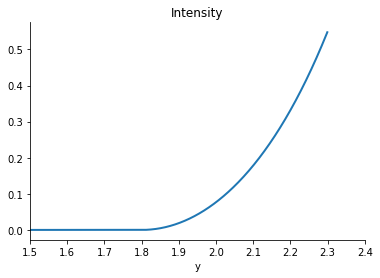

In [897]:
y = np.arange(0,2.3,0.001)
r1 = 1.5
r2=2.5
y_lower=1.8
intensity = r1*(np.exp(r2/2*(y- y_lower)**2)-1)*(y >= y_lower)
intensity2 = r1*(np.exp(r2/2*(y- 1.5)**2)-1)*(y >= 1.5)
plt.plot(y, intensity, label="1.7")
# plt.plot(y, intensity2, label="1.5")
plt.title('Intensity')
plt.xlabel('y')
plt.xlim(1.5, 2.4)
# plt.savefig('intensity_1p8.png', dpi=300)

In [898]:
y_grid[numy_bar]

2.4000000000000004

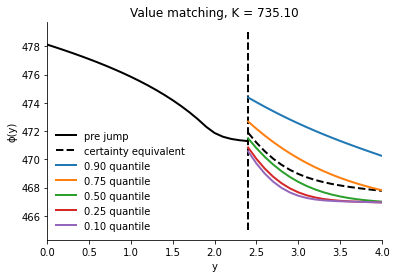

In [901]:
loc1 = np.abs(np.exp(k_grid) - 700).argmin()
plt.plot(y_grid_cap, ϕ[:, loc1], label='pre jump', color="black")
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar-1:-1, loc1], label="certainty equivalent", 
         color="black", linestyle="dashed")
quantile_list = [0.1, 0.25, 0.5, 0.75, 0.9]
for i in range(len(quantile_list)):
    plt.plot(y_grid[numy_bar:], np.quantile(v_list[:, numy_bar-1:-1, loc1], quantile_list[4-i], axis=0), 
             label="{:.2f} quantile".format(quantile_list[4-i]))
# plt.plot(y_grid[numy_bar:], v_list[1][numy_bar:, loc1])
# plt.plot(y_grid[numy_bar:], v_list[2][numy_bar:, loc1])
# plt.plot(y_grid[numy_bar:], v_list[3][numy_bar:, loc1])
# plt.plot(y_grid[numy_bar:], v_list[4][numy_bar:, loc1])
plt.xlabel('y')
plt.vlines(2.4, 465, 479, color="black", linestyle="dashed")
plt.legend(loc=3)

plt.ylabel('ϕ(y)')
plt.title('Value matching, K = {:.2f}'.format(np.exp(k_grid[loc1])))
plt.xlim(0,4)
plt.savefig('../figures/DICE_like/value_10_24.png', dpi=300)
plt.show()

In [902]:
ϕ.mean(), ϕ[-1, loc1], ϕ[-2, loc1], ϕ_bound[numy_bar-1, loc1]

(271.12825583059333, 471.28954064224536, 471.3495415461923, 471.8849378042959)

In [903]:
(ϕ[-1, loc1] -  ϕ_bound[numy_bar-1, loc1])#/ϕ[-1, loc1]

-0.5953971620505172

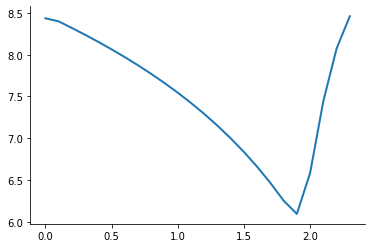

In [891]:
plt.plot(y_grid_cap, ems[:, loc1])

# Simulation

??:

$$
ME_t = \vartheta_t \theta \frac{1}{\lambda_t} \left[1 -  \frac{\mathcal{E}_t}{\alpha \lambda_t K_t }\right]^{\theta - 1}
$$

In [654]:
class GridInterp_2d():

    def __init__(self, grids, values, method = 'Linear'):

        # unpacking
        self.grids = grids
        (self.xs, self.ys) = grids
        self.nx = len(self.xs)
        self.ny = len(self.ys)
        
        self.values = values

        assert (self.nx, self.ny) == values.shape, "ValueError: Dimensions not match"
        self.method = method

    def get_value(self, x, y):

        if self.method == 'Linear':
            
            func = RegularGridInterpolator(self.grids, self.values)
            return func([x,y])[0]

        elif self.method == 'Spline':

            func1 = CubicSpline(self.xs, self.values)
            ySpace = func1(x)
            
            func2 = CubicSpline(self.ys, ySpace)
            return func2(y)

        else:
            raise ValueError('Method Not Supported')

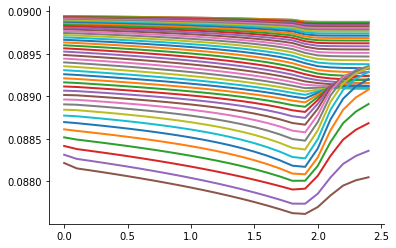

In [808]:
plt.plot(y_grid_cap, i_new)
plt.show()

In [809]:
def simulate(res, y_grid, k_grid, Time=70, ppy=4):
    ems = res['ems']
    i = res['i']
    pers = ppy * Time
    # pers = 100
    dt = Time / pers
    nDims = 3 
    its = 1

    gridpoints = (y_grid, k_grid)
    # interpolate emission
    e_func_r = GridInterp_2d(gridpoints, ems, 'Linear')
    def e_func(x):
        return e_func_r.get_value(x[0], x[1]) # match order
    # interpolate investment
    i_func_r = GridInterp_2d(gridpoints, i, 'Linear')
    def i_func(x):
        return i_func_r.get_value(x[0], x[1])

    # drifts for each diffusion process
    def compute_μlogk(x):
        return μk +  i_func(x)  - 0.5*κ*i_func(x)**2 - 0.5*σk**2
    def compute_μy(E_x):
        return  E_x*np.mean(θ_list)
    def compute_μlogd(x, E_x):
        Y_x = x[0]
        dΛ = γ1 + γ2*Y_x + γ3*(Y_x - y_bar)*(Y_x >y_bar)
        ddΛ = γ2 + γ3*(Y_x > y_bar)  
        return dΛ*compute_μy(E_x) + 0.5*ddΛ*σy**2*E_x**2

    # initial points

    K_0 = 80/α
    Y_0 = 1.1
    D_0 = -γ1*Y_0 - 0.5*γ2*Y_0**2

    hist = np.zeros([pers, nDims])
    e_hist = np.zeros([pers])
    i_hist = np.zeros([pers])

    for tm in range(pers):
        if tm == 0:
            # initial points
            hist[0,:] = [Y_0, np.log(K_0), D_0]
            e_hist[0] = e_func(hist[0,:])
            i_hist[0] = i_func(hist[0,:])

        else:
            # other periods
            hist[tm,0] = hist[tm - 1,0] + compute_μy(e_hist[tm-1])*dt# Y
            hist[tm,1] = hist[tm - 1,1] + compute_μlogk(hist[tm-1,:])*dt# logK
            hist[tm,2] = hist[tm - 1,2] + compute_μlogd(hist[tm-1,:], e_hist[tm-1])*dt # logDt
            e_hist[tm] = e_func(hist[tm,:])
            i_hist[tm] = i_func(hist[tm,:])

    e_k_ratio = e_hist/np.exp(hist[:,1])/α
    Iota_t = 1 - e_hist/np.exp(hist[:,1])/(α*λ_bar)
    XK_t = α*θ_bar*Iota_t**θ
    MUe = θ*θ_bar/λ_bar*Iota_t**(θ-1)

    simul = dict(e= e_hist, states= hist)
    return simul

In [810]:
simul_list = []
for i in range(len(res_list)):
    simul = simulate(res_list[i], y_grid, k_grid, Time=70)
    simul_list.append(simul)

Text(0.5, 0, 'Years')

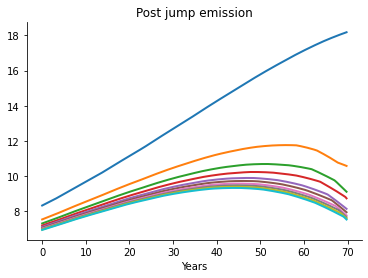

In [811]:
for i in range(len(res_list)):
    plt.plot(np.arange(0, 70, 1/4), simul_list[i]['e'])
plt.title('Post jump emission')
plt.xlabel('Years')

In [817]:
Time = 68
ppy = 1
pers = ppy * Time
# pers = 100
dt = Time / pers
nDims = 3 
its = 1

ems_pre_jump = solution['ems']
i_pre_jump = solution['i']

gridpoints = (y_grid_cap, k_grid)
# interpolate emission
e_func_r = GridInterp_2d(gridpoints, ems_pre_jump, 'Linear')
def e_func(x):
    return e_func_r.get_value(x[0], x[1]) # match order
# interpolate investment
i_func_r = GridInterp_2d(gridpoints, i_pre_jump, 'Linear')
def i_func(x):
    return i_func_r.get_value(x[0], x[1])

# drifts for each diffusion process
def compute_μlogk(x):
    return μk +  i_func(x)  - 0.5*κ*i_func(x)**2 - 0.5*σk**2
def compute_μy(E_x):
    return  E_x*np.mean(θ_list)
def compute_μlogd(x, E_x):
    Y_x = x[0]
    dΛ = γ1 + γ2*Y_x + γ3*(Y_x - y_bar)*(Y_x >y_bar)
    ddΛ = γ2 + γ3*(Y_x > y_bar)  
    return dΛ*compute_μy(E_x) + 0.5*ddΛ*σy**2*E_x**2

# initial points

K_0 = 80/α
Y_0 = 1.1
D_0 = -γ1*Y_0 - 0.5*γ2*Y_0**2

hist = np.zeros([pers, nDims])
e_hist = np.zeros([pers])
i_hist = np.zeros([pers])
prob_hist = np.zeros([pers])

for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [Y_0, np.log(K_0), D_0]
        e_hist[0] = e_func(hist[0,:])
        i_hist[0] = i_func(hist[0,:])
        prob_hist[0] = 1 - r1*(np.exp(r2/2*(hist[0,0]- y_lower)**2)-1)*(hist[0,0] >= y_lower)*dt

    else:
        # other periods
        if hist[tm - 1 , 0] <= 2.35:
            hist[tm,0] = hist[tm - 1,0] + compute_μy(e_hist[tm-1])*dt# Y
            hist[tm,1] = hist[tm - 1,1] + compute_μlogk(hist[tm-1,:])*dt# logK
            hist[tm,2] = hist[tm - 1,2] + compute_μlogd(hist[tm-1,:], e_hist[tm-1])*dt # logDt
            e_hist[tm] = e_func(hist[tm,:])
            i_hist[tm] = i_func(hist[tm,:])
            prob_hist[tm] = (1 - r1*(np.exp(r2/2*(hist[tm,0]- y_lower)**2)-1)*(hist[tm,0] >= y_lower)*dt)*prob_hist[tm-1]
        else:
            break

e_k_ratio = e_hist/np.exp(hist[:,1])/α
Iota_t = 1 - e_hist/np.exp(hist[:,1])/(α*λ_bar)
XK_t = α*θ_bar*Iota_t**θ
MUe = θ*θ_bar/λ_bar*Iota_t**(θ-1)

simul = dict(e= e_hist, states= hist)

(0.0, 21.694946479589046)

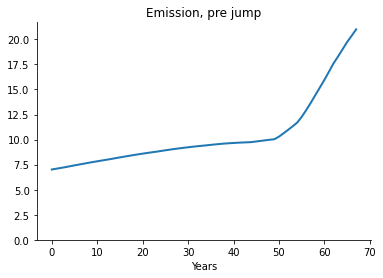

In [835]:
plt.plot(np.arange(0, Time, dt), e_hist)
plt.xlabel('Years')
plt.title('Emission, pre jump')
plt.ylim(0)
# plt.savefig('Et_pre_jump_24.png', dpi=300)

In [819]:
prob_hist.shape, prob_hist

((68,),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99997815,
        0.99910569, 0.99613006, 0.98978752, 0.97883074, 0.96207329,
        0.93845035, 0.90691551, 0.86657224, 0.81683762, 0.75757707,
        0.68924079, 0.61274212, 0.52969694, 0.44258128, 0.35470438,
        0.27007712, 0.19297394, 0.12726611, 0.07571794, 0.03936402,
        0.01701973, 0.00562055, 0.00118883]))

Text(0.5, 0, 'Years')

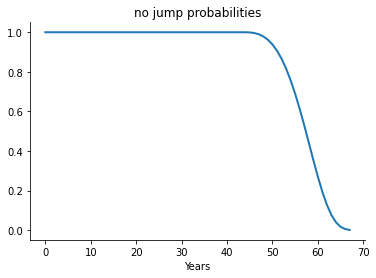

In [820]:
plt.plot(prob_hist)
plt.title('no jump probabilities')
plt.xlabel('Years')
# plt.savefig('no_jump_prob_238.png', dpi=300)

Text(0.5, 1.0, '$\\frac{E_t}{\\alpha K_t}$')

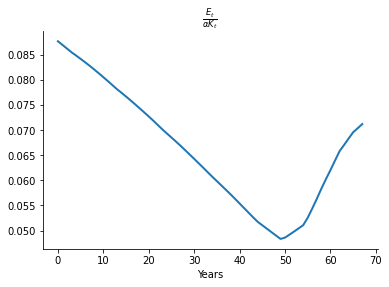

In [713]:
plt.plot(np.arange(0, Time, dt), e_k_ratio)
plt.xlabel('Years')
plt.title(r'$\frac{E_t}{\alpha K_t}$')
# plt.savefig('ratio.png')

Text(0.5, 1.0, '$\\iota_t$')

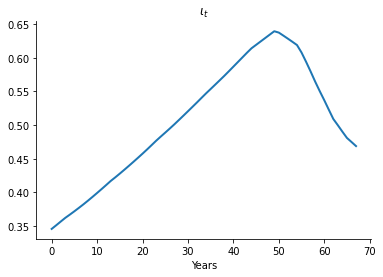

In [714]:
plt.plot(np.arange(0, Time, dt), Iota_t)
plt.xlabel('Years')
plt.title(r"$\iota_t$")
# plt.savefig('iota_t_18.png')

In [726]:
hist[:,0]

array([1.1       , 1.11305987, 1.12626755, 1.13962115, 1.15312255,
       1.16678685, 1.18061176, 1.19459496, 1.20873411, 1.22302493,
       1.23746375, 1.25204803, 1.26677521, 1.28164271, 1.29664794,
       1.3118082 , 1.3271183 , 1.34257406, 1.35817219, 1.37390939,
       1.38978233, 1.40578766, 1.42192001, 1.4381723 , 1.45454094,
       1.47103725, 1.48766376, 1.5044163 , 1.52128876, 1.53827138,
       1.55535972, 1.57254934, 1.58983578, 1.6072146 , 1.62467737,
       1.6422232 , 1.65986011, 1.67758271, 1.69538563, 1.71326351,
       1.73120171, 1.7491914 , 1.76722699, 1.78530295, 1.80341374,
       1.82156819, 1.83983526, 1.85821206, 1.87669568, 1.89528318,
       1.91397168, 1.93313099, 1.95290467, 1.97331531, 1.99438644,
       2.01614261, 2.03897051, 2.06306203, 2.0884962 , 2.11535758,
       2.14363544, 2.17333677, 2.20454689, 2.23730006, 2.27133328,
       2.30670625, 2.34343558, 2.3813262 ])

Text(0.5, 1.0, 'Yt')

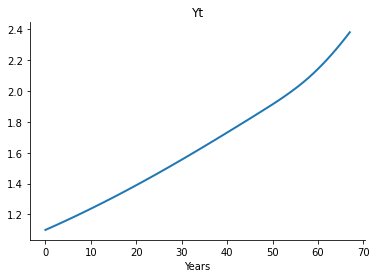

In [716]:
plt.plot(np.arange(0, Time, dt), hist[:,0])
plt.xlabel('Years')
plt.title("Yt")
# plt.savefig('Yt.png')

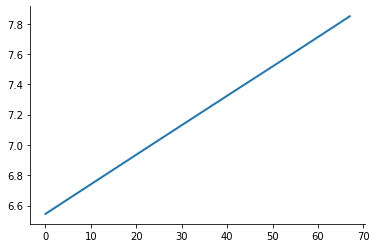

In [717]:
plt.plot(simul['states'][:, 1])